 # MNIST Classification Project - Unsupervised Domain Adaptation (UDA)

---

**For learning purpose only.**

## Goal

Using SVHN full dataset (i.e. observations + annotations/labels), classify MNIST digits but without using its own annotations/labels.

Labeling datasets is costly.


## Procedure: train 2 main models

- First, train a CNN classifier to classify SVHN dataset, by using both observations and labels (supervised learning way)

- Train a conditional GAN or cGAN to rebalance the noise distribution as described in the paper https://arxiv.org/pdf/2001.02950.pdf: "Generative Pseudo-label Refinement for Unsupervised Domain Adaptation (unsupervised learning)

Advantages of such a solution: simplicity and efficiency.


## Context: Unsupervised Domain Adaptation (UDA) learning context

Deep learning models such as classifiers are robust against gaussian noise. Moreover, such
data augmentation allows the model to avoid overfitting and to increase the model performance
and accuracy.

However, classifiers are not robust against **“shift noise”** or “label noise” resulting from
domain shift.

While the performance of the trained classifier on SVHN in a supervised context on MNIST is
not so bad (see results below on the left) with up to 70% accuracy on the test dataset - a first
idea would be to use these labels to train a deep learning model. However, the initial accuracy is
not good enough and the domain shift - which could be interpreted as noise - is too important
and not uniform. Thus it is a bad idea to train a classifier using such noisy data.

Domain shift can be interpreted as "noise". cGAN or conditional Generative Adversarial
Networks are relatively resilient to such "structured" noise as proven in the paper - and thus a
solution to the problem of learning with noise. cGANs are indeed able to denoise and filter
such noise and generate cleaner targets. Indeed, “the labels of the generated samples obey a
noise distribution which is closer to the uniform than the shift noise one”. By training the
classifier on the “cleaned” samples produced by cGAN, the accuracy of the classification on
SVHN is considerably improved.

Hence, their UDA strategy intelligently exploits the properties of both cGAN, which is robust to
shift noise, and classifier, which is robust against uniform noise.


## About SVHN and MNIST datasets

- SVHN "Street View Houses Number" representing house numbers (one or several digits)

- MNIST "Modified National Institute of Standards and Technology" representing handwritten digits

Both datasets, represent one or several digits i.e. the same "semantic" data but the representations/forms of each digit from the two datasets are quite different. The two datasets belong to different distributions.

## Setup and configuration

**Python 3.6.6**

Model trained on **Quadro P4000** (8GB)

#### Imports

In [ ]:
#!pip install tensorflow_addons

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate, LeakyReLU, multiply
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

# keras
import keras
from keras import backend as K

# visu: seaborn, matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# set seed
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

Using TensorFlow backend.


#### Utility functions (display and image prepossessing)

In [ ]:
INPUT_IMG_SIZE = 28

def display_image(x_train, y_train, position):
    image = x_train[position]
    label = y_train[position]
    plt.title('Example %d. Label: %d' % (position, label))
    plt.imshow(image, cmap="gray_r")  # cmap=plt.cm.gray_r

def rgb2gray(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

def normalize_img(img):
    """Map values in the range [-1, 1]"""
    return img * 2 - 1.0

def preprocess_test_image(img):
    img = tf.cast(img, dtype=tf.float32)
    # ==> IF NOT ALREADY DONE ELSEWHERE, NORMALIZE HERE <==
    img = normalize_img(img)
    if img.shape[-1] != 3:
        img = tf.expand_dims(img, -1)
        #img = tf.image.grayscale_to_rgb(img)
    else:
        img = rgb2gray(svnh_x_test)
    img = tf.image.resize(img, size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
    return img

def preprocess_train_image(img):
    return preprocess_test_image(img)

print(f"INPUT_IMG_SIZE={INPUT_IMG_SIZE}!!!")

INPUT_IMG_SIZE=28!!!


#### Configuration

In [ ]:
IMAGES_DIR = "./images/"
WEIGHTS_DIR = "./weights/"

if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

VERBOSE = True
BATCH_SIZE = 128

CLASSIFIER_EPOCHS = 200
CGAN_EPOCHS = 100

TRAIN_CLASSIFIER = True
TEST_CGAN = True  # checking that the GAN works properly
TRAIN_CGAN = True 

DEBUG_MODE_CGAN = False  # using less data (while checking out hyperparameters....)

print(f"TRAIN_CLASSIFIER={TRAIN_CLASSIFIER}!!!")
print(f"TEST_CGAN={TEST_CGAN}!!!")
print(f"TRAIN_CGAN={TRAIN_CGAN}!!!")
print(f"DEBUG_MODE_CGAN={DEBUG_MODE_CGAN}!!!")

TRAIN_CLASSIFIER=True!!!
TEST_CGAN=True!!!
TRAIN_CGAN=True!!!
DEBUG_MODE_CGAN=False!!!


#### Checking out GPU configuration

In [ ]:
host = os.uname()
nodename = host.nodename
nodename

'tp-5d02-01'

In [ ]:
!nvidia-smi

Sat May 15 11:48:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.181.07   Driver Version: 418.181.07   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:9E:00.0  On |                  N/A |
| 46%   24C    P8     6W / 105W |     53MiB /  8111MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 0) Loading, preparing and analysing data

#### a) MNIST

Dataset loaded with Keras.

- About:

Black-and-white/grayscale handwritten digits. Only 1 channel.

- Transformations:

Black-and-white/grayscale pictures will not be converted to RGB but arrays will be normalized between 0 and 1.

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
mnist_y_train = mnist_y_train.reshape(-1, 1)
mnist_y_test = mnist_y_test.reshape(-1, 1)

In [ ]:
# normalize here
mnist_x_train = mnist_x_train / 255.
mnist_x_test = mnist_x_test / 255.

In [ ]:
print(f"mnist_x_train.shape={mnist_x_train.shape}")
print(f"mnist_y_train.shape={mnist_y_train.shape}")
print(f"mnist_x_test.shape={mnist_x_test.shape}")
print(f"mnist_y_test.shape={mnist_y_test.shape}")

mnist_x_train.shape=(60000, 28, 28)
mnist_y_train.shape=(60000, 1)
mnist_x_test.shape=(10000, 28, 28)
mnist_y_test.shape=(10000, 1)


In [ ]:
print(mnist_x_train.min(), mnist_x_train.max(), mnist_x_train.mean(), mnist_x_train.std())
print(mnist_x_test.min(), mnist_x_test.max(), mnist_x_test.mean(), mnist_x_test.std())

0.0 1.0 0.1306604762738429 0.3081078038564622
0.0 1.0 0.13251460584233699 0.3104802479305348


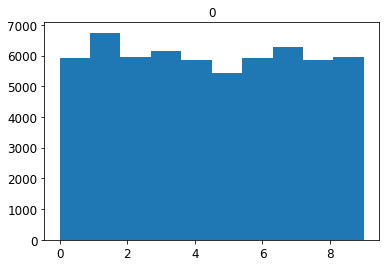

In [ ]:
pd.DataFrame(mnist_y_train).hist(grid=False, xlabelsize=12, ylabelsize=12);

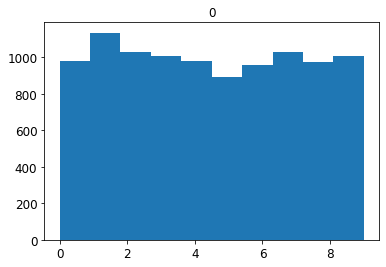

In [ ]:
pd.DataFrame(mnist_y_test).hist(grid=False, xlabelsize=12, ylabelsize=12);

**=> There is no clear under/over representation of one class among another. The dataset is quite well balanced.**

In [ ]:
print(np.unique(mnist_y_train))
print(np.unique(mnist_y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


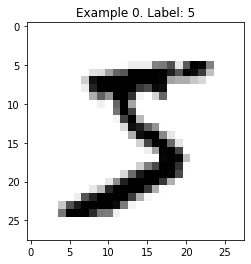

In [ ]:
display_image(mnist_x_train, mnist_y_train, position=0)

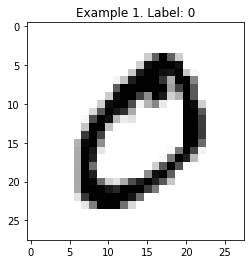

In [ ]:
display_image(mnist_x_train, mnist_y_train, position=1)

#### b) SVHN

Dataset taken from here:

http://ufldl.stanford.edu/housenumbers (**for non-commercial use only**)

- About:

Colored/RGB (street view) houses numbers.

- Transformations:

Pictures will be converted to grayscale pictures (1 channel only) and arrays will be normalized between 0 and 1.

In [ ]:
if not os.path.exists("train_32x32.mat"):
    !wget --no-check-certificate "http://ufldl.stanford.edu/housenumbers/train_32x32.mat" -O "train_32x32.mat"
if not os.path.exists("test_32x32.mat"):
    !wget --no-check-certificate "http://ufldl.stanford.edu/housenumbers/test_32x32.mat" -O "test_32x32.mat"

In [ ]:
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

# train and test are python dictionaries
# keys are ['__header__', '__version__', '__globals__', 'X', 'y']

x_train = train['X'].copy()
y_train = train['y'].copy()
x_test = test['X'].copy()
y_test = test['y'].copy()

print(x_train.shape)
x_train = np.moveaxis(x_train, [-1], [0])
#svnh_x_train = rgb2gray(x_train)
svnh_x_train = x_train
print(svnh_x_train.shape)

svnh_y_train = train['y']
svnh_y_train[svnh_y_train == 10] = 0
y_test[y_test==10] = 0

print(x_test.shape)
x_test = np.moveaxis(x_test, [-1], [0])
#svnh_x_test = rgb2gray(x_test)
svnh_x_test = x_test
print(svnh_x_test.shape)

svnh_y_test = test['y']
svnh_y_test[svnh_y_test == 10] = 0

(32, 32, 3, 73257)
(73257, 32, 32, 3)
(32, 32, 3, 26032)
(26032, 32, 32, 3)


In [ ]:
# normalize here
svnh_x_train = svnh_x_train / 255.
svnh_x_test = svnh_x_test / 255.

In [ ]:
# rgb to greyscale
svnh_x_train = rgb2gray(svnh_x_train)
svnh_x_test = rgb2gray(svnh_x_test)

In [ ]:
print(svnh_x_train.min(), svnh_x_train.max(), svnh_x_train.mean(), svnh_x_train.std())
print(svnh_x_test.min(), svnh_x_test.max(), svnh_x_test.mean(), svnh_x_test.std())

0.0 0.9998999999999999 0.4452157017808891 0.196951887299712
0.0 0.9998999999999999 0.45430773446587264 0.2219736007647014


In [ ]:
print(f"svnh_x_train.shape={svnh_x_train.shape}")
print(f"svnh_y_train.shape={svnh_y_train.shape}")
print(f"svnh_x_test.shape={svnh_x_test.shape}")
print(f"svnh_y_test.shape={svnh_y_test.shape}")

svnh_x_train.shape=(73257, 32, 32)
svnh_y_train.shape=(73257, 1)
svnh_x_test.shape=(26032, 32, 32)
svnh_y_test.shape=(26032, 1)


In [ ]:
print(np.unique(svnh_y_train))
print(np.unique(svnh_y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


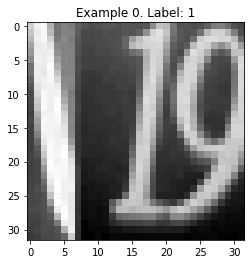

In [ ]:
display_image(svnh_x_train, svnh_y_train, position=0)

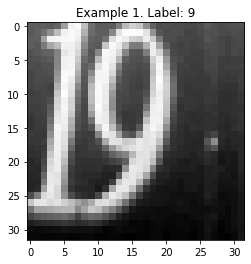

In [ ]:
display_image(svnh_x_train, svnh_y_train, position=1)

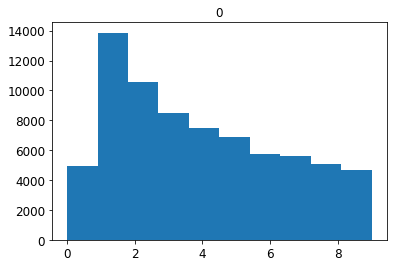

In [ ]:
pd.DataFrame(svnh_y_train).hist(grid=False, xlabelsize=12, ylabelsize=12);

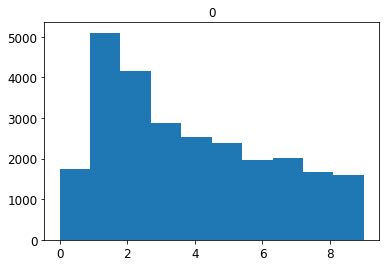

In [ ]:
pd.DataFrame(svnh_y_test).hist(grid=False, xlabelsize=12, ylabelsize=12);

**=> There is a clear over-representation of the class 1 (from 1-9,0 exponentially, specificity of the dataset). The dataset is clearly unbalanced. We might want to use a weighted cross-entropy to consider/respect the proportion of each class when using the dataset.**

### 1) First model: CNN classifier


Model architecture inspired from here: https://github.com/dyckia/house-number-recognition/blob/master/SVHN.ipynb


N.B. What is the difference between sparse_categorical_crossentropy and categorical_crossentropy?

https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy#:~:text=2%20Answers&text=Use%20sparse%20categorical%20crossentropy%20when,0.5%2C%200.3%2C%200.2%5D).

- use sparse categorical crossentropy (scce) when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) 

- use categorical crossentropy (cce) otherwise


#### a) Model architecture

In [ ]:
dropout = .3
d = INPUT_IMG_SIZE
classifier = Sequential([
    #BatchNormalization(),
    Conv2D(d, (3,3), activation='relu', input_shape=(d, d, 1)),
    Conv2D(d, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(dropout),
    Conv2D(d*2, (3,3), activation='relu'),
    Conv2D(d*2, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(dropout),
    Flatten(),
    Dense(d*16, activation='relu'),
    Dropout(dropout),
    Dense(10, activation='softmax')
], name="classifier")

classifier.summary()
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 28)        7084      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 56)        14168     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 56)          28280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 56)          0

#### b) Training

In [ ]:
if TRAIN_CLASSIFIER:
    
    print(f"CLASSIFIER_EPOCHS={CLASSIFIER_EPOCHS}")
    
    from tensorflow.keras import backend as K
    K.clear_session()

    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint("./weights/classifier.{epoch:03d}.h5", 
                                 verbose=VERBOSE, 
                                 monitor='accuracy', 
                                 save_best_only=True, 
                                 mode='auto')  
    
    history = classifier.fit(preprocess_train_image(svnh_x_train), svnh_y_train, 
                             epochs=CLASSIFIER_EPOCHS,
                             batch_size=BATCH_SIZE, 
                             verbose=VERBOSE, 
                             callbacks=[checkpoint])
    #np.expand_dims(svnh_x_train, axis=-1)
    #preprocess_train_image(svnh_x_train)

CLASSIFIER_EPOCHS=200
Epoch 1/200
573/573 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.6984
Epoch 00001: accuracy improved from -inf to 0.69843, saving model to ./weights/classifier.001.h5
573/573 [==============================] - 5s 9ms/step - loss: 0.9250 - accuracy: 0.6984
Epoch 2/200
568/573 [============================>.] - ETA: 0s - loss: 0.4427 - accuracy: 0.8673
Epoch 00002: accuracy improved from 0.69843 to 0.86751, saving model to ./weights/classifier.002.h5
573/573 [==============================] - 5s 9ms/step - loss: 0.4417 - accuracy: 0.8675
Epoch 3/200
569/573 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8905
Epoch 00003: accuracy improved from 0.86751 to 0.89062, saving model to ./weights/classifier.003.h5
573/573 [==============================] - 5s 9ms/step - loss: 0.3631 - accuracy: 0.8906
Epoch 4/200
571/573 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.9030
Epoch 00004: accuracy impr

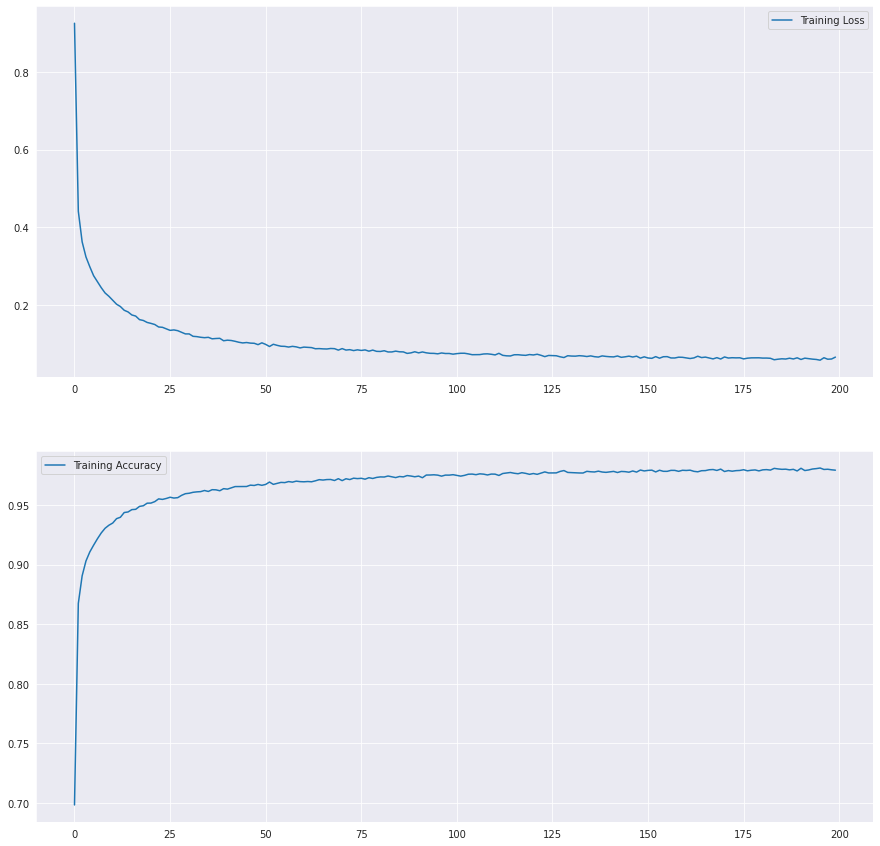

In [ ]:
if TRAIN_CLASSIFIER:
    
    his_dict = history.history
    fig = plt.figure(figsize=(15, 15))
    x_range = range(len(history.history['loss']))
    sns.set_style('darkgrid')

    fig.add_subplot(2,1,1)
    sns.lineplot(x=x_range , y=his_dict["loss"],label='Training Loss')

    fig.add_subplot(2,1,2)
    sns.lineplot(x=x_range , y=his_dict["accuracy"],label='Training Accuracy')

    plt.show()

#### c) Performance on test dataset

In [ ]:
from tensorflow import keras

files = (os.listdir(WEIGHTS_DIR))
files = [f for f in files if "classifier" in f]
files = sorted(files)
print(f"Loading checkpoint '{files[-1]}'")

classifier = keras.models.load_model(f"{WEIGHTS_DIR}/{files[-1]}")
loss, acc = classifier.evaluate(preprocess_test_image(svnh_x_test), svnh_y_test)
print(f"Classifier test accuracy: {'%.4f' % acc}")

Loading checkpoint 'classifier.196.h5'
814/814 [==============================] - 4s 5ms/step - loss: 0.3190 - accuracy: 0.9423
Classifier test accuracy: 0.9423


**=> The accuracy on the SVHN test dataset is quite good/satisfying (up to 94%).**

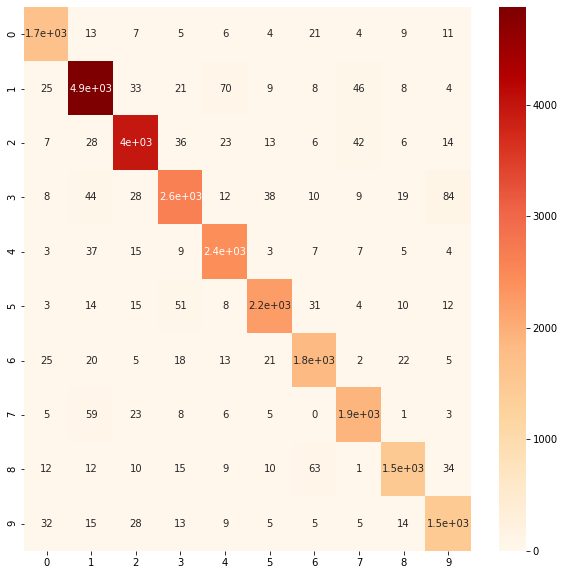

In [ ]:
preds = classifier.predict(preprocess_test_image(svnh_x_test))
y_preds = np.argmax(preds, axis=1)

# Plot heatmap of the predictions on the SVNH test dataset
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(svnh_y_test, y_preds), cmap='OrRd',annot = True);

**=> The errors are properly balanced ("gaussian noise").**

#### d) Performance on MNIST test dataset: +67% (caracterisation of the "Domain shift" or structured "noise")

In [ ]:
# classifier on MNIST
x = preprocess_test_image(mnist_x_test)
y = mnist_y_test
print(x.shape, y.shape)
loss, acc = classifier.evaluate(x, y)
print(f"Classifier test accuracy: {'%.4f' % acc} (MNIST)")

(10000, 28, 28, 1) (10000, 1)
313/313 [==============================] - 1s 5ms/step - loss: 3.3427 - accuracy: 0.6714
Classifier test accuracy: 0.6714 (MNIST)


<AxesSubplot:>

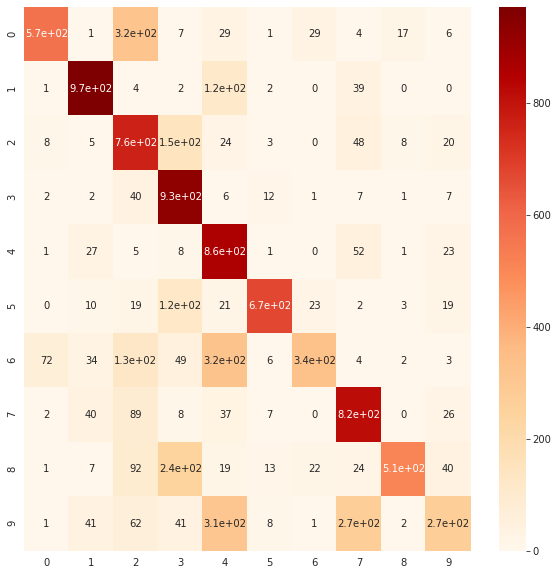

In [ ]:
preds = classifier.predict(preprocess_test_image(mnist_x_test))
y_preds = np.argmax(preds, axis=1)

# Plot heatmap of the predictions on the SVHN test dataset
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(mnist_y_test, y_preds), cmap='OrRd',annot = True);

**=> The errors are typically unbalanced due to the domain shift ("structured noise"), especially for classes 6 and 9, as well as for 0, 1, 2, and 8.**

### 2) Second model: conditional GAN or cGAN

Model architecture and code have largely been inspired or taken from here: 

- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

- https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py



#### a) Prepare datasets

In [ ]:
mnist_x_train.shape

(60000, 28, 28)

In [ ]:
svnh_x_train.shape

(73257, 32, 32)

#### b) Create datasets

In [ ]:
dataset_train_size = len(mnist_x_train)
dataset_test_size = len(mnist_x_test)

buffer_size = BATCH_SIZE

if not DEBUG_MODE_CGAN:
    dataset_train_size = ((dataset_train_size // 1) // BATCH_SIZE) * BATCH_SIZE
    dataset_test_size = ((dataset_test_size // 1) // BATCH_SIZE) * BATCH_SIZE  
else:
    dataset_train_size = ((dataset_train_size // 10) // BATCH_SIZE) * BATCH_SIZE
    dataset_test_size = ((dataset_test_size // 10) // BATCH_SIZE) * BATCH_SIZE                
            
print(f"dataset_train_size={dataset_train_size}")
print(f"dataset_test_size={dataset_test_size}")

mnist_x_train_dataset = tf.data.Dataset.from_tensor_slices(mnist_x_train[:dataset_train_size, ...])
mnist_x_train_dataset = (
    mnist_x_train_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    #.cache()
    #.shuffle(buffer_size)
    .batch(BATCH_SIZE)
)


mnist_x_test_dataset = tf.data.Dataset.from_tensor_slices(mnist_x_test[:dataset_test_size, ...])
mnist_x_test_dataset = (
    mnist_x_test_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    #.cache()
    #.shuffle(buffer_size)
    .batch(BATCH_SIZE)
)

mnist_y_train_dataset = tf.data.Dataset.from_tensor_slices(mnist_y_train[:dataset_train_size, ...])
mnist_y_train_dataset = (
    mnist_y_train_dataset#.map(preprocess_train_image, num_parallel_calls=autotune)
    #.cache()
    #.shuffle(buffer_size)
    .batch(BATCH_SIZE)
)

mnist_y_test_dataset = tf.data.Dataset.from_tensor_slices(mnist_y_test[:dataset_test_size, ...])
mnist_y_test_dataset = (
    mnist_y_test_dataset#.map(preprocess_test_image, num_parallel_calls=autotune)
    #.cache()
    #.shuffle(buffer_size)
    .batch(BATCH_SIZE)
)

dataset_train_size=59904
dataset_test_size=9984


#### c) Visualize some examples

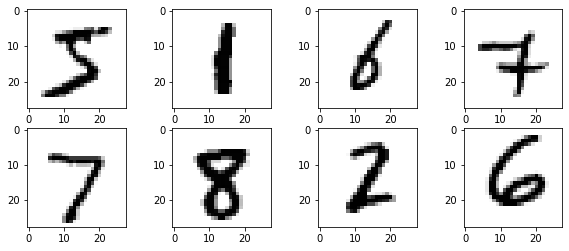

In [ ]:
_, ax = plt.subplots(2, 4, figsize=(10, 4))
for i, samples in enumerate(zip(mnist_x_train_dataset.take(4), mnist_x_test_dataset.take(4))):
    img_mnist_train = samples[0][0]
    img_mnist_test = samples[1][0]
    
    img_mnist_train += 1.0
    img_mnist_test += 1.0
    img_mnist_train /= 2.0
    img_mnist_test /= 2.0
    
    ax[0, i].imshow(img_mnist_train, cmap="gray_r")
    ax[1, i].imshow(img_mnist_test, cmap="gray_r")
plt.show()

#### d) Build the generator

In [ ]:
def build_generator(latent_dim=100, n_classes=10, in_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,1)):
    
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(in_shape), activation='tanh'))
    model.add(Reshape(in_shape))

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return tf.keras.Model([noise, label], img, name="generator")

gen = build_generator()
gen.summary() 

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________

#### e) Build the discriminator

In [ ]:
def build_discriminator(in_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,1), n_classes=10):
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(in_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=in_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(n_classes, np.prod(in_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return tf.keras.Model([img, label], validity, name="discriminator")

disc = build_discriminator()
disc.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 784)       7840        input_8[0][0]                    
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 784)          0           input_7[0][0]                    
______________________________________________________________________________________

#### f) Build the cGAN model

In [ ]:
def generate_latent_points(latent_dim=100, n_samples=BATCH_SIZE, n_classes=10):
    """Generate points in latent space as input for the generator"""
    z_input = tf.random.normal(shape=(n_samples, latent_dim))
    labels = tf.random.uniform(shape=(n_samples,), minval=0, maxval=n_classes, dtype=tf.int32)
    return z_input, labels

class cGan(keras.Model):
    
    def __init__(
        self,
        generator,
        discriminator,
        classifier=None,
        pretrained=False
    ):
        super(cGan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.classifier = classifier
        self.pretrained = pretrained

    def compile(
        self,
    ):
        super(cGan, self).compile()
        self.generator_optimizer     = keras.optimizers.Adam(learning_rate=2e-4)
        self.discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4)
        self.classifier_optimizer    = keras.optimizers.Adam(learning_rate=2e-4)

    def train_step(self, batch_data):
        # batch_data => MNIST
        x_real, y_real = batch_data
        batch_size = len(x_real)  
        
        valid = tf.ones((batch_size, 1))
        fake = tf.zeros((batch_size, 1))

        z_noise, y_sampled = generate_latent_points(latent_dim=100, n_samples=batch_size, n_classes=10)

        with tf.GradientTape(persistent=True) as tape:
            
            ####
            # Train classifier
            ####
            
            if self.classifier is not None and self.pretrained: 
                print(f"Train classifier")
                x_tilde = self.generator([z_noise, y_sampled], training=False)
                y_tilde = self.classifier(x_tilde, training=True)

                # Compute the loss 
                cce = tf.keras.losses.SparseCategoricalCrossentropy()
                classifier_loss = cce(y_sampled, y_tilde)

                # Compute the gradient    
                classifier_grads = tape.gradient(classifier_loss, self.classifier.trainable_variables)

                # Update the weights
                self.classifier_optimizer.apply_gradients(zip(classifier_grads, self.classifier.trainable_variables))
            else:
                print(f"Classifier won't be trained!!!")
                classifier_loss = 0
                
        with tf.GradientTape(persistent=True) as tape:
            
            ####
            # Train discriminator
            ####
            
            if self.classifier is not None:
                y_tilde = self.classifier(x_real, training=False)
                y_tilde = tf.math.argmax(y_tilde, axis=-1)
                y_tilde = tf.expand_dims(y_tilde, 1)
            else:
                print(f"Using y_real!!!")
                y_tilde = y_real
            x_tilde = self.generator([z_noise, y_tilde], training=False)
                        
            # Compute the loss 
            loss_real = tf.keras.losses.binary_crossentropy(valid, self.discriminator([x_real, y_tilde], training=True), from_logits=False)
            loss_fake = tf.keras.losses.binary_crossentropy(fake, self.discriminator([x_tilde, y_tilde], training=True), from_logits=False)
            discriminator_loss = (loss_real + loss_fake) * .5
            
            # Compute the gradient    
            discriminator_grads = tape.gradient(discriminator_loss, self.discriminator.trainable_variables)

            # Update the weights
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grads, self.discriminator.trainable_variables))

        with tf.GradientTape(persistent=True) as tape:    
            
            ####
            # Train generator
            ####
            
            if self.classifier is not None:
                y_tilde = self.classifier(x_real, training=False)
                y_tilde = tf.math.argmax(y_tilde, axis=-1)
                y_tilde = tf.expand_dims(y_tilde, 1)
            else:
                print(f"Using y_sampled!!!")
                y_tilde = y_sampled
            x_tilde = self.generator([z_noise, y_tilde], training=True)
            
            # Compute the loss 
            generator_loss = tf.keras.losses.binary_crossentropy(valid, self.discriminator([x_tilde, y_tilde], training=False), from_logits=False)
            
            # Compute the gradient    
            generator_grads = tape.gradient(generator_loss, self.generator.trainable_variables)

            # Update the weights
            self.generator_optimizer.apply_gradients(zip(generator_grads, self.generator.trainable_variables))      
                        
        return {
            "generator_loss": generator_loss,
            "discriminator_loss": discriminator_loss,
            "classifier_loss": classifier_loss
        }
    
# Create cGAN models
classifier_copy = tf.keras.models.clone_model(classifier)  # Careful, it clones only the archi, not the weights!!!!
files = (os.listdir(WEIGHTS_DIR))
files = [f for f in files if "classifier" in f]
files = sorted(files)
print(f"Loading checkpoint '{files[-1]}'")
classifier_copy = keras.models.load_model(f"{WEIGHTS_DIR}/{files[-1]}")
gangan = cGan(
    generator=build_generator(), 
    discriminator=build_discriminator(), 
    classifier=classifier_copy,
    pretrained=False,
)
gangan.compile()

Loading checkpoint 'classifier.196.h5'


**=> Important remark: in order to be able to test the cGAN (supervised training) and for simplification and comprehension (of the code) purposes, the classifier is passed to the cGAN model for both pretraining and training phases (unsupervised trainings). We might have wanted to create a specific dataset of pseudo-labels to be passed to the cGAN for the pretraining phase in order to speed up the computation (predict() would have been called only once for that phase).**

#### g) Train the end-to-end model

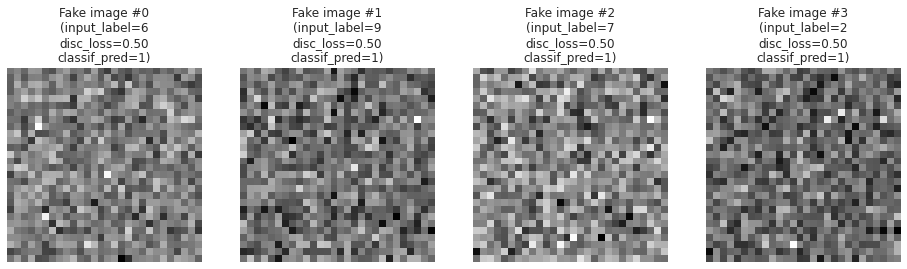

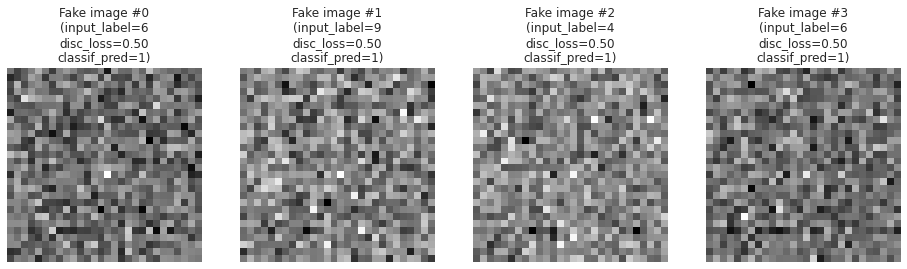

In [ ]:
# Callback
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4, base_image_name="cgan_generated_img"):
        self.num_img = num_img
        self.base_image_name = base_image_name

    def on_epoch_end(self, epoch, logs=None):
        n = 4
        
        _, ax = plt.subplots(1, n, figsize=(16, 4))
        for i in range(n):   
            try: 
                model = self.model
            except:
                model = gangan
            
            z_noise, y_sampled = generate_latent_points(latent_dim=100, n_samples=1)
            
            # Override sampled y, show the most interesting ones? (see major errors shown in previous heatmap)
            if i == 0:
                # tf EagerTensor and item assignement...
                y_sampled = tf.Variable(y_sampled)
                y_sampled = y_sampled[0,].assign(6)
            if i == 1:
                # tf EagerTensor and item assignement...
                y_sampled = tf.Variable(y_sampled)
                y_sampled = y_sampled[0,].assign(9)
            
            x_tilde = model.generator([z_noise, y_sampled], training=False)
            is_fake = model.discriminator([x_tilde, y_sampled], training=False)
            
            if model.classifier is not None:
                pred = tf.math.argmax(model.classifier(x_tilde, training=False), axis=-1)
            else:
                pred = tf.math.argmax(classifier(x_tilde, training=False), axis=-1)

            # take first element from batch of BATCH_SIZE
            x_tilde = x_tilde[0, ...]            
            x_tilde += 1.0
            x_tilde /= 2.0
            
            ax[i].imshow(x_tilde, cmap="gray_r")
            ax[i].set_title(f"Fake image #{i}\n(input_label={y_sampled[0]}\ndisc_loss={'%.2f' % is_fake}\nclassif_pred={pred[0]})")
            ax[i].axis("off")

            if epoch % 10:
                x_tilde = keras.preprocessing.image.array_to_img(x_tilde)
                x_tilde.save(f"./{IMAGES_DIR}/{self.base_image_name}_{i}_{epoch+1}.png")

        plt.show()
        plt.close()

gangan_plotter = GANMonitor(base_image_name="cgan_generated_img")
gangan_plotter.on_epoch_end(-1)

gangan_noclassifier_plotter = GANMonitor(base_image_name="cgan_noclassifier_generated_img")
gangan_noclassifier_plotter.on_epoch_end(-1)


**=> Training takes some time! (several hours on the machine described in the introduction of the notebook). If needed (debug/testing purpose), simply use less data (see `DEBUG_MODE_CYCLEGAN` variable defined at the beginning of the notebook).**

#### Phase 0) Testing the architecture of GAN

CGAN_EPOCHS=100
Training cGAN without classifier (for debug purpose only)
Epoch 1/100
Classifier won't be trained!!!
Using y_real!!!


Using y_sampled!!!
Classifier won't be trained!!!
Using y_real!!!
Using y_sampled!!!
468/468 [==============================] - ETA: 0s - generator_loss: 3.8349 - discriminator_loss: 0.2516 - classifier_loss: 0.0000e+00

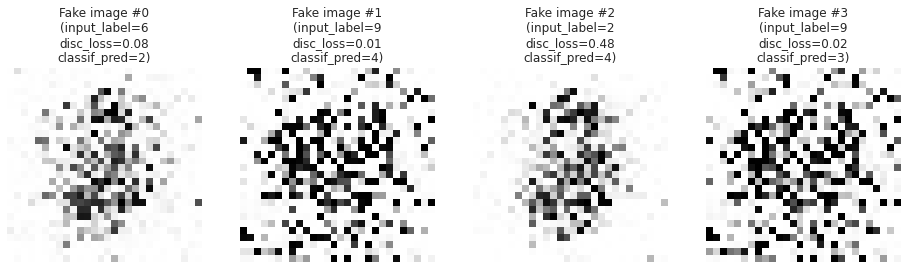


Epoch 00001: saving model to ./weights/cgan_noclassifier_checkpoints.001.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 3.8336 - discriminator_loss: 0.2515 - classifier_loss: 0.0000e+00
Epoch 2/100
468/468 [==============================] - ETA: 0s - generator_loss: 2.4436 - discriminator_loss: 0.3895 - classifier_loss: 0.0000e+00

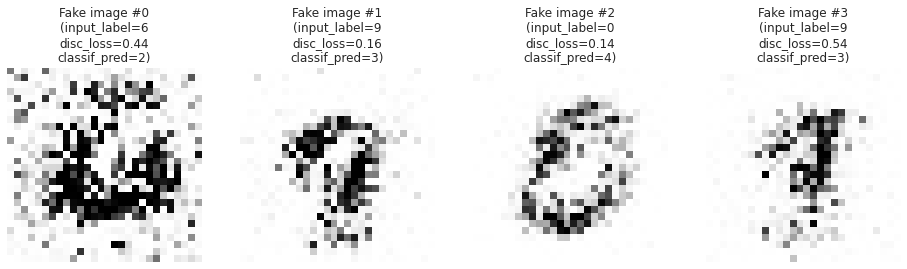


Epoch 00002: saving model to ./weights/cgan_noclassifier_checkpoints.002.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 2.4417 - discriminator_loss: 0.3895 - classifier_loss: 0.0000e+00
Epoch 3/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.5759 - discriminator_loss: 0.4672 - classifier_loss: 0.0000e+00

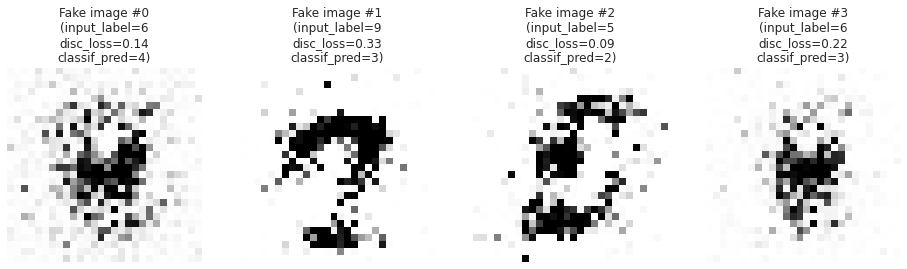


Epoch 00003: saving model to ./weights/cgan_noclassifier_checkpoints.003.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.5801 - discriminator_loss: 0.4665 - classifier_loss: 0.0000e+00
Epoch 4/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.5769 - discriminator_loss: 0.4459 - classifier_loss: 0.0000e+00

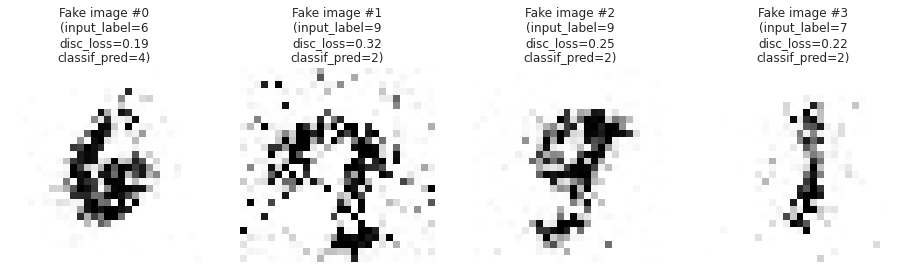


Epoch 00004: saving model to ./weights/cgan_noclassifier_checkpoints.004.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.5767 - discriminator_loss: 0.4457 - classifier_loss: 0.0000e+00
Epoch 5/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.4141 - discriminator_loss: 0.4808 - classifier_loss: 0.0000e+00

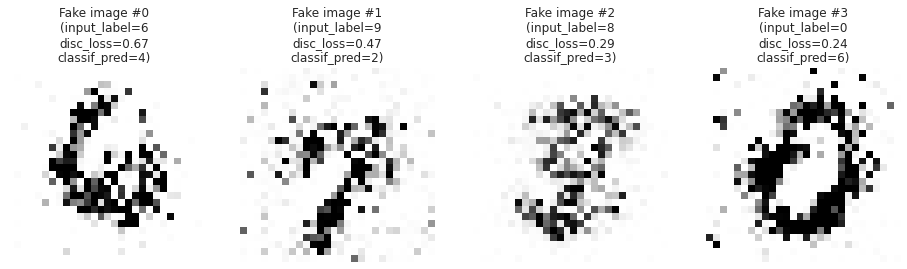


Epoch 00005: saving model to ./weights/cgan_noclassifier_checkpoints.005.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.4139 - discriminator_loss: 0.4807 - classifier_loss: 0.0000e+00
Epoch 6/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.2720 - discriminator_loss: 0.5189 - classifier_loss: 0.0000e+00

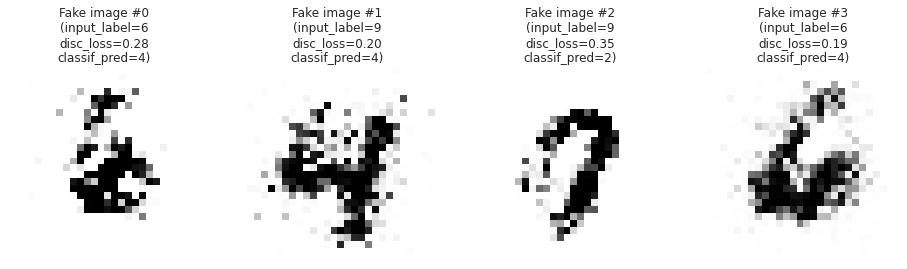


Epoch 00006: saving model to ./weights/cgan_noclassifier_checkpoints.006.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.2718 - discriminator_loss: 0.5188 - classifier_loss: 0.0000e+00
Epoch 7/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.2166 - discriminator_loss: 0.5290 - classifier_loss: 0.0000e+00

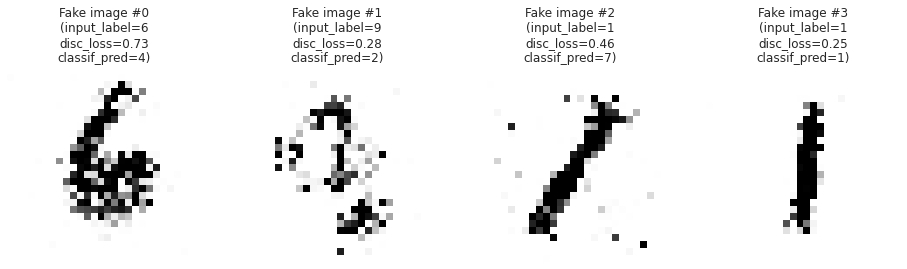


Epoch 00007: saving model to ./weights/cgan_noclassifier_checkpoints.007.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.2170 - discriminator_loss: 0.5287 - classifier_loss: 0.0000e+00
Epoch 8/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1480 - discriminator_loss: 0.5479 - classifier_loss: 0.0000e+00

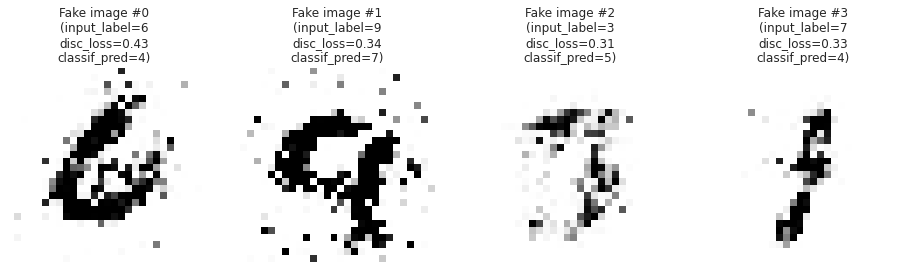


Epoch 00008: saving model to ./weights/cgan_noclassifier_checkpoints.008.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.1491 - discriminator_loss: 0.5477 - classifier_loss: 0.0000e+00
Epoch 9/100
465/468 [============================>.] - ETA: 0s - generator_loss: 1.2809 - discriminator_loss: 0.5171 - classifier_loss: 0.0000e+00

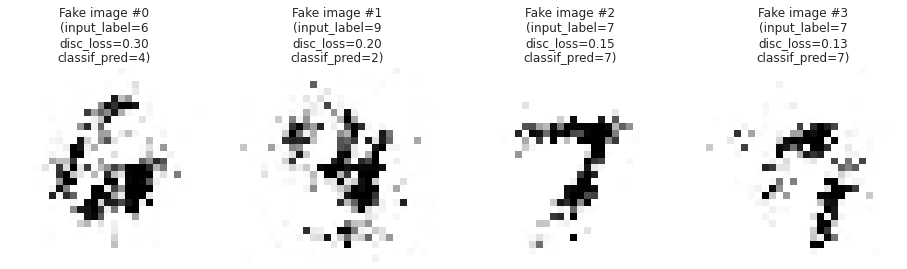


Epoch 00009: saving model to ./weights/cgan_noclassifier_checkpoints.009.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.2810 - discriminator_loss: 0.5167 - classifier_loss: 0.0000e+00
Epoch 10/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.3509 - discriminator_loss: 0.4968 - classifier_loss: 0.0000e+00

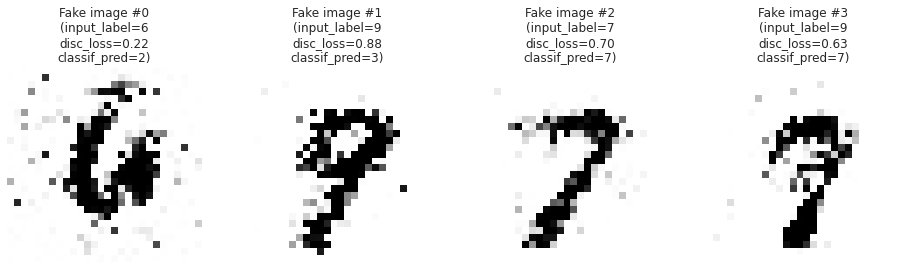


Epoch 00010: saving model to ./weights/cgan_noclassifier_checkpoints.010.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.3516 - discriminator_loss: 0.4965 - classifier_loss: 0.0000e+00
Epoch 11/100
465/468 [============================>.] - ETA: 0s - generator_loss: 1.3464 - discriminator_loss: 0.4942 - classifier_loss: 0.0000e+00

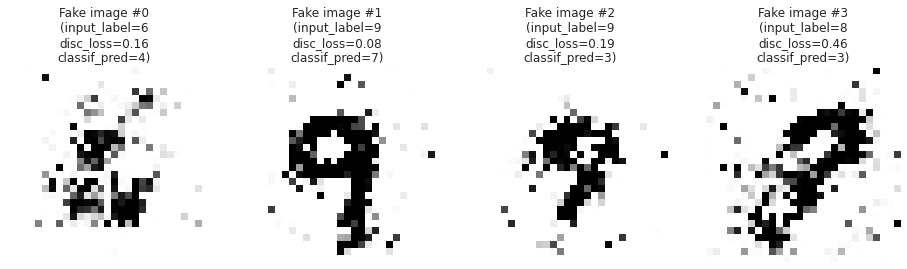


Epoch 00011: saving model to ./weights/cgan_noclassifier_checkpoints.011.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.3481 - discriminator_loss: 0.4938 - classifier_loss: 0.0000e+00
Epoch 12/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.2989 - discriminator_loss: 0.5121 - classifier_loss: 0.0000e+00

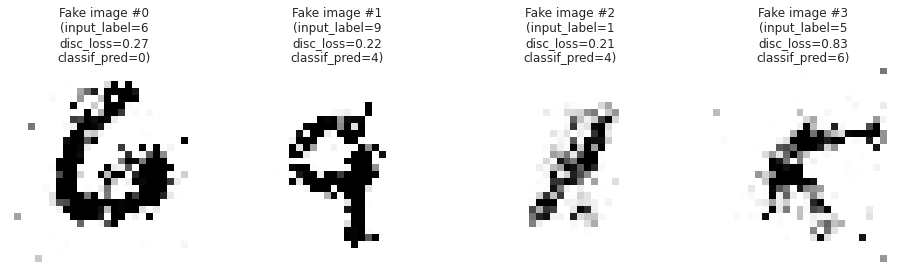


Epoch 00012: saving model to ./weights/cgan_noclassifier_checkpoints.012.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.2983 - discriminator_loss: 0.5124 - classifier_loss: 0.0000e+00
Epoch 13/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.3099 - discriminator_loss: 0.5024 - classifier_loss: 0.0000e+00

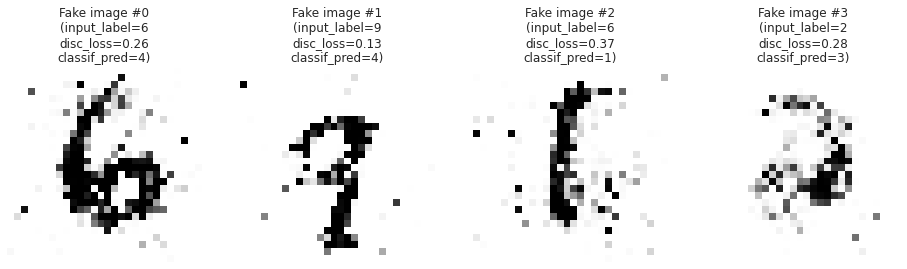


Epoch 00013: saving model to ./weights/cgan_noclassifier_checkpoints.013.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.3105 - discriminator_loss: 0.5021 - classifier_loss: 0.0000e+00
Epoch 14/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.3028 - discriminator_loss: 0.5099 - classifier_loss: 0.0000e+00

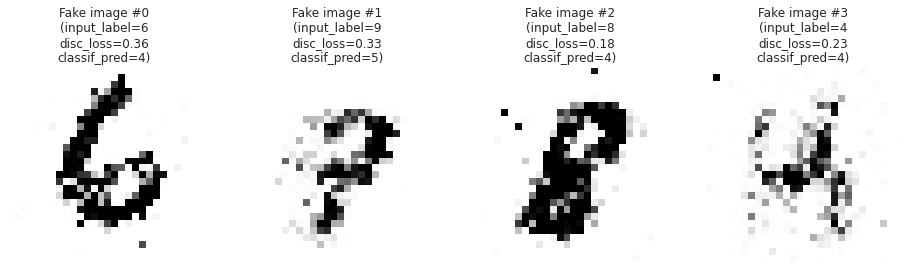


Epoch 00014: saving model to ./weights/cgan_noclassifier_checkpoints.014.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.3038 - discriminator_loss: 0.5094 - classifier_loss: 0.0000e+00
Epoch 15/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.2140 - discriminator_loss: 0.5333 - classifier_loss: 0.0000e+00

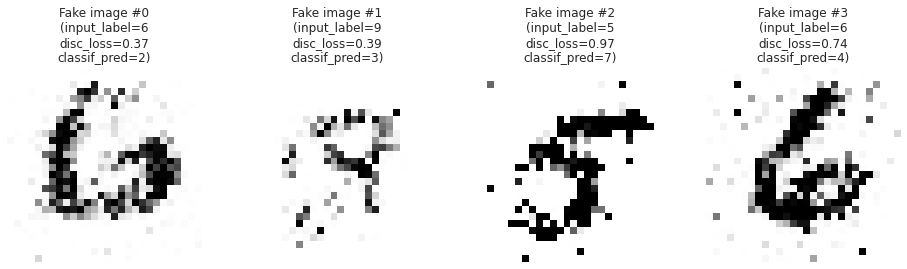


Epoch 00015: saving model to ./weights/cgan_noclassifier_checkpoints.015.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.2142 - discriminator_loss: 0.5331 - classifier_loss: 0.0000e+00
Epoch 16/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.1781 - discriminator_loss: 0.5399 - classifier_loss: 0.0000e+00

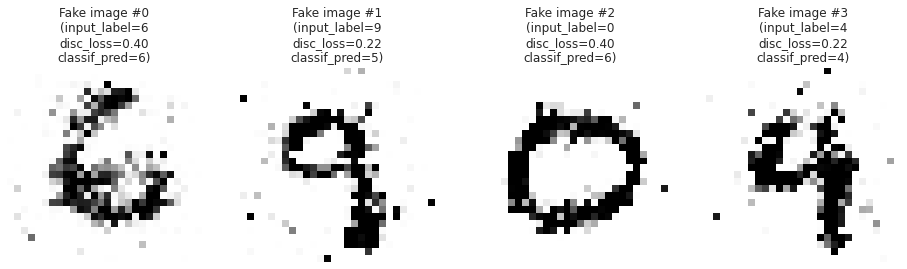


Epoch 00016: saving model to ./weights/cgan_noclassifier_checkpoints.016.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.1780 - discriminator_loss: 0.5399 - classifier_loss: 0.0000e+00
Epoch 17/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.1771 - discriminator_loss: 0.5400 - classifier_loss: 0.0000e+00

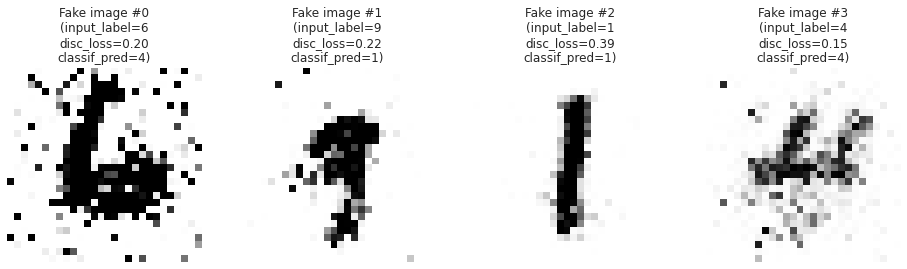


Epoch 00017: saving model to ./weights/cgan_noclassifier_checkpoints.017.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.1778 - discriminator_loss: 0.5400 - classifier_loss: 0.0000e+00
Epoch 18/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1219 - discriminator_loss: 0.5579 - classifier_loss: 0.0000e+00

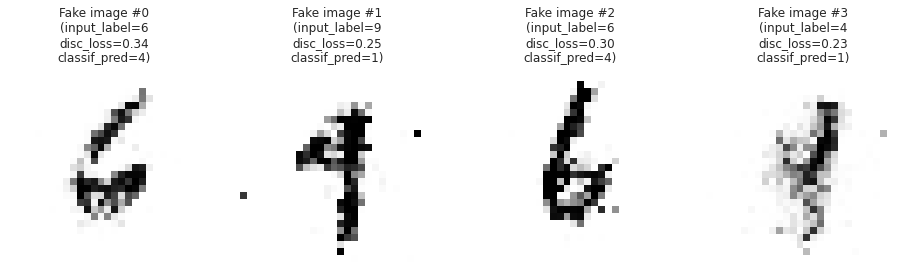


Epoch 00018: saving model to ./weights/cgan_noclassifier_checkpoints.018.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.1231 - discriminator_loss: 0.5573 - classifier_loss: 0.0000e+00
Epoch 19/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0592 - discriminator_loss: 0.5743 - classifier_loss: 0.0000e+00

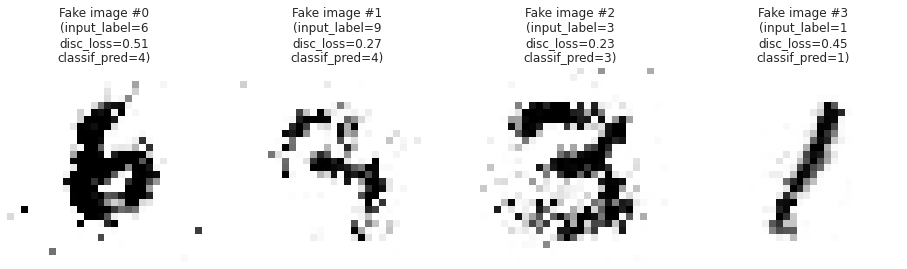


Epoch 00019: saving model to ./weights/cgan_noclassifier_checkpoints.019.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0593 - discriminator_loss: 0.5742 - classifier_loss: 0.0000e+00
Epoch 20/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0738 - discriminator_loss: 0.5670 - classifier_loss: 0.0000e+00

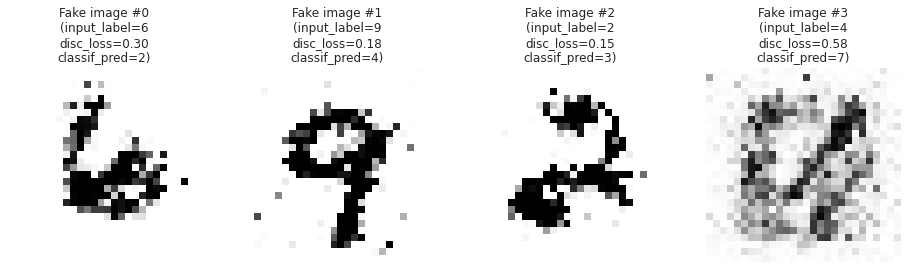


Epoch 00020: saving model to ./weights/cgan_noclassifier_checkpoints.020.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0743 - discriminator_loss: 0.5668 - classifier_loss: 0.0000e+00
Epoch 21/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0811 - discriminator_loss: 0.5671 - classifier_loss: 0.0000e+00

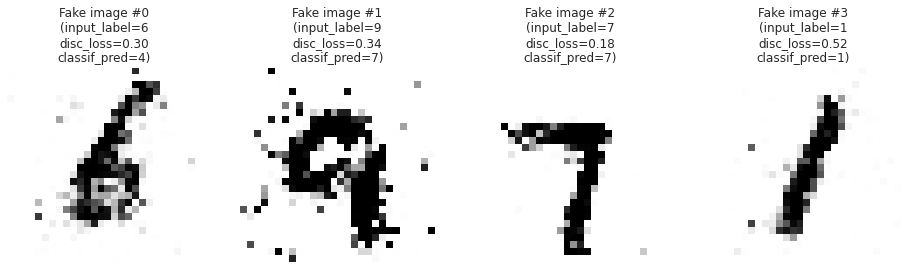


Epoch 00021: saving model to ./weights/cgan_noclassifier_checkpoints.021.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0811 - discriminator_loss: 0.5667 - classifier_loss: 0.0000e+00
Epoch 22/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0566 - discriminator_loss: 0.5720 - classifier_loss: 0.0000e+00

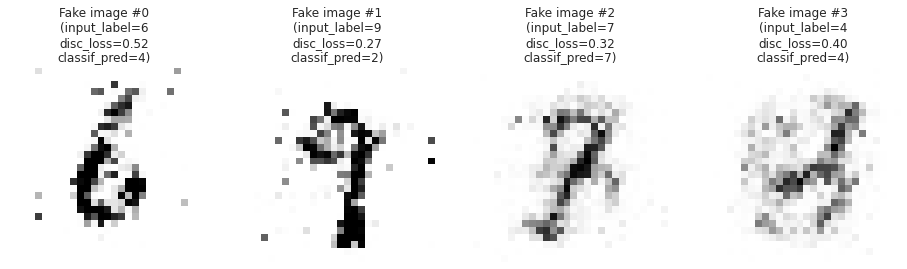


Epoch 00022: saving model to ./weights/cgan_noclassifier_checkpoints.022.h5
468/468 [==============================] - 9s 20ms/step - generator_loss: 1.0567 - discriminator_loss: 0.5719 - classifier_loss: 0.0000e+00
Epoch 23/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0250 - discriminator_loss: 0.5817 - classifier_loss: 0.0000e+00

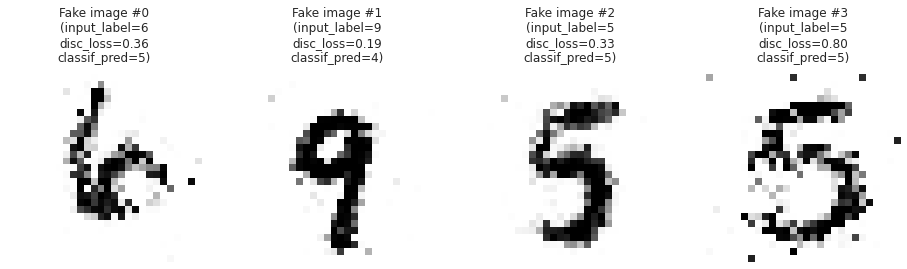


Epoch 00023: saving model to ./weights/cgan_noclassifier_checkpoints.023.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0256 - discriminator_loss: 0.5816 - classifier_loss: 0.0000e+00
Epoch 24/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0513 - discriminator_loss: 0.5772 - classifier_loss: 0.0000e+00

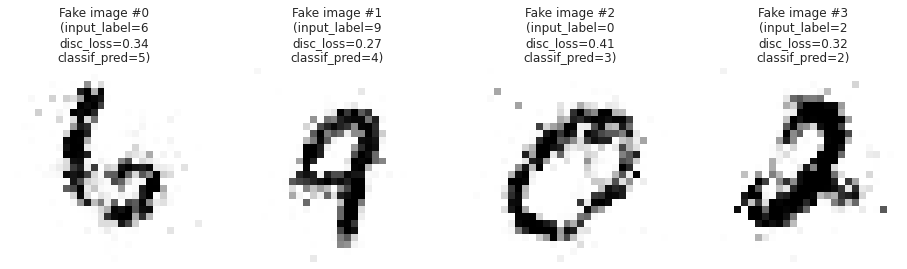


Epoch 00024: saving model to ./weights/cgan_noclassifier_checkpoints.024.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0521 - discriminator_loss: 0.5772 - classifier_loss: 0.0000e+00
Epoch 25/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0396 - discriminator_loss: 0.5752 - classifier_loss: 0.0000e+00

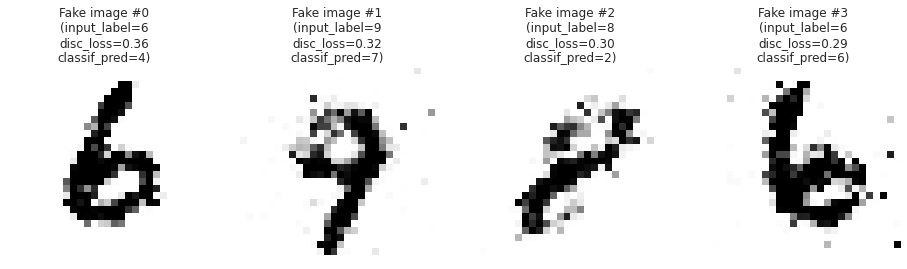


Epoch 00025: saving model to ./weights/cgan_noclassifier_checkpoints.025.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0399 - discriminator_loss: 0.5752 - classifier_loss: 0.0000e+00
Epoch 26/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0385 - discriminator_loss: 0.5754 - classifier_loss: 0.0000e+00

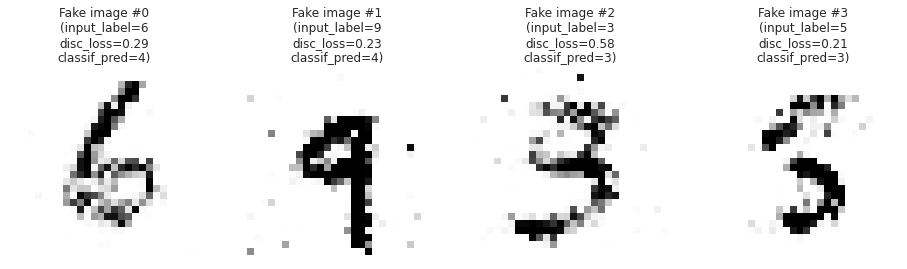


Epoch 00026: saving model to ./weights/cgan_noclassifier_checkpoints.026.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0386 - discriminator_loss: 0.5752 - classifier_loss: 0.0000e+00
Epoch 27/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0074 - discriminator_loss: 0.5871 - classifier_loss: 0.0000e+00

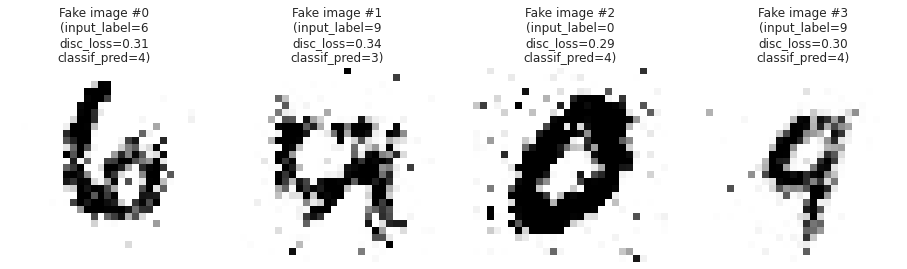


Epoch 00027: saving model to ./weights/cgan_noclassifier_checkpoints.027.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 1.0077 - discriminator_loss: 0.5869 - classifier_loss: 0.0000e+00
Epoch 28/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9960 - discriminator_loss: 0.5917 - classifier_loss: 0.0000e+00

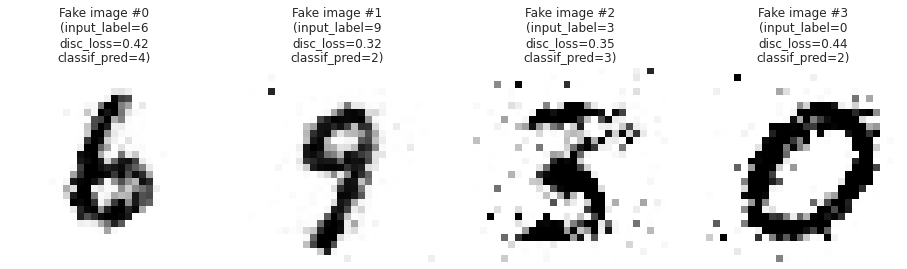


Epoch 00028: saving model to ./weights/cgan_noclassifier_checkpoints.028.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9959 - discriminator_loss: 0.5919 - classifier_loss: 0.0000e+00
Epoch 29/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9979 - discriminator_loss: 0.5861 - classifier_loss: 0.0000e+00

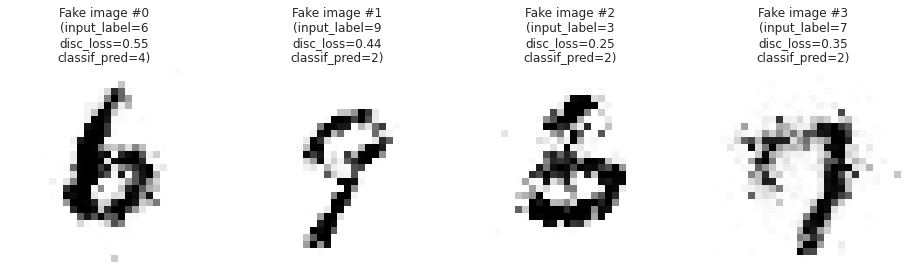


Epoch 00029: saving model to ./weights/cgan_noclassifier_checkpoints.029.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9985 - discriminator_loss: 0.5858 - classifier_loss: 0.0000e+00
Epoch 30/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9727 - discriminator_loss: 0.5989 - classifier_loss: 0.0000e+00

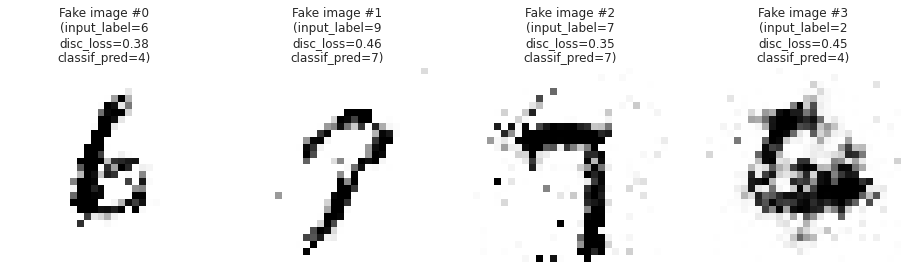


Epoch 00030: saving model to ./weights/cgan_noclassifier_checkpoints.030.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9729 - discriminator_loss: 0.5989 - classifier_loss: 0.0000e+00
Epoch 31/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9399 - discriminator_loss: 0.6122 - classifier_loss: 0.0000e+00

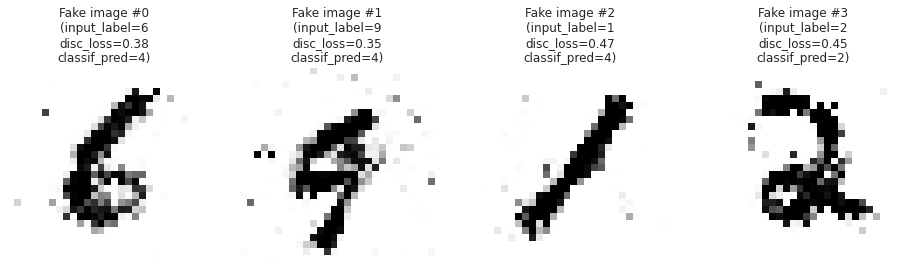


Epoch 00031: saving model to ./weights/cgan_noclassifier_checkpoints.031.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9400 - discriminator_loss: 0.6122 - classifier_loss: 0.0000e+00
Epoch 32/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9270 - discriminator_loss: 0.6140 - classifier_loss: 0.0000e+00

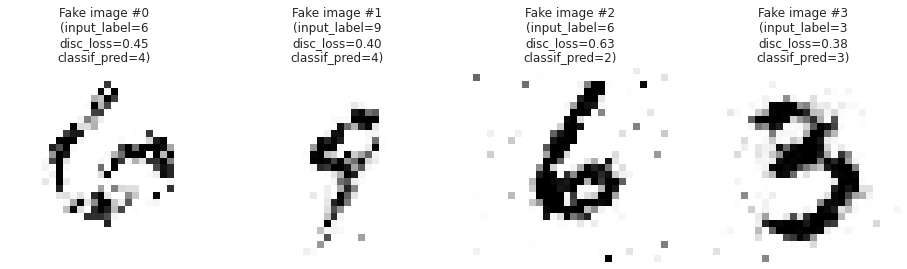


Epoch 00032: saving model to ./weights/cgan_noclassifier_checkpoints.032.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9269 - discriminator_loss: 0.6139 - classifier_loss: 0.0000e+00
Epoch 33/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.9444 - discriminator_loss: 0.6074 - classifier_loss: 0.0000e+00

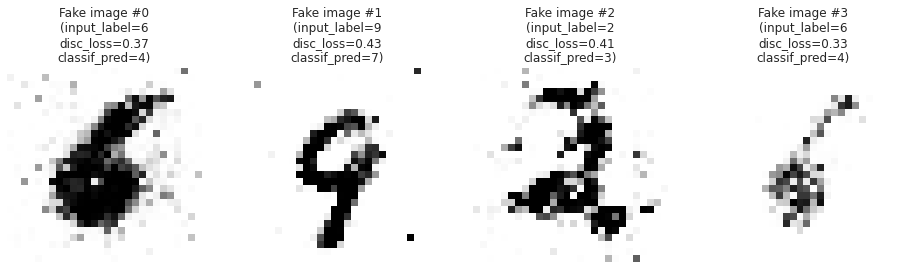


Epoch 00033: saving model to ./weights/cgan_noclassifier_checkpoints.033.h5
468/468 [==============================] - 9s 20ms/step - generator_loss: 0.9448 - discriminator_loss: 0.6072 - classifier_loss: 0.0000e+00
Epoch 34/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9580 - discriminator_loss: 0.6022 - classifier_loss: 0.0000e+00

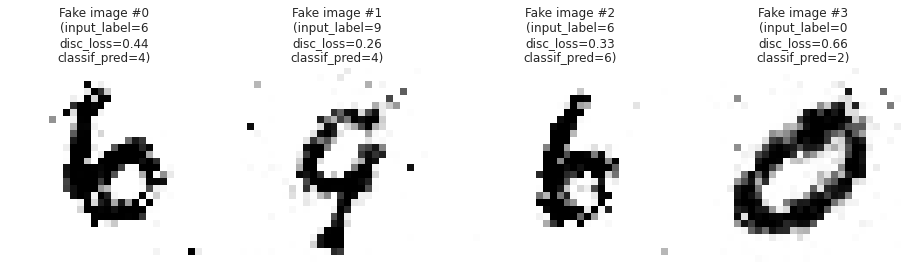


Epoch 00034: saving model to ./weights/cgan_noclassifier_checkpoints.034.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9581 - discriminator_loss: 0.6021 - classifier_loss: 0.0000e+00
Epoch 35/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9538 - discriminator_loss: 0.6013 - classifier_loss: 0.0000e+00

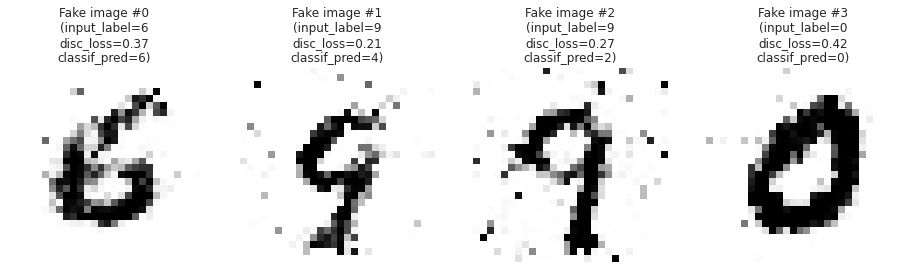


Epoch 00035: saving model to ./weights/cgan_noclassifier_checkpoints.035.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9542 - discriminator_loss: 0.6013 - classifier_loss: 0.0000e+00
Epoch 36/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9500 - discriminator_loss: 0.6084 - classifier_loss: 0.0000e+00

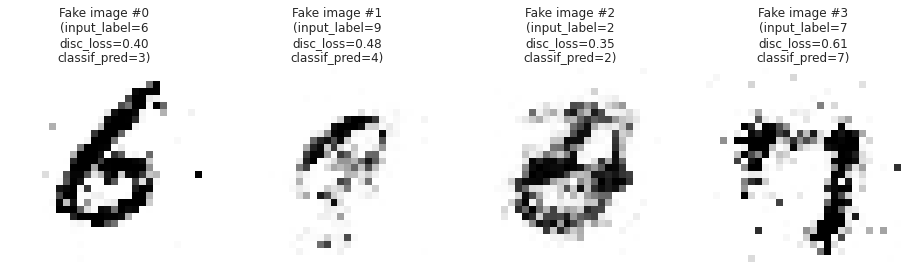


Epoch 00036: saving model to ./weights/cgan_noclassifier_checkpoints.036.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9499 - discriminator_loss: 0.6083 - classifier_loss: 0.0000e+00
Epoch 37/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9208 - discriminator_loss: 0.6139 - classifier_loss: 0.0000e+00

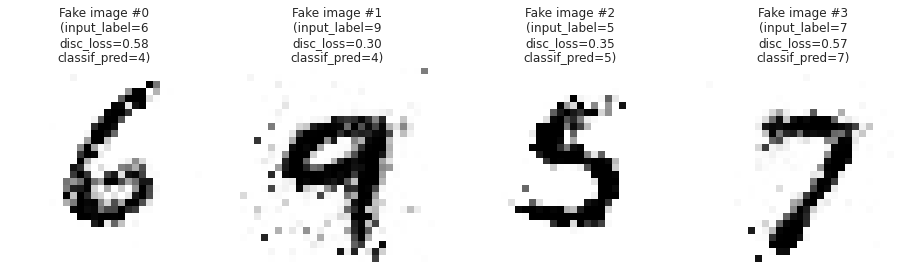


Epoch 00037: saving model to ./weights/cgan_noclassifier_checkpoints.037.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9209 - discriminator_loss: 0.6135 - classifier_loss: 0.0000e+00
Epoch 38/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9716 - discriminator_loss: 0.5982 - classifier_loss: 0.0000e+00

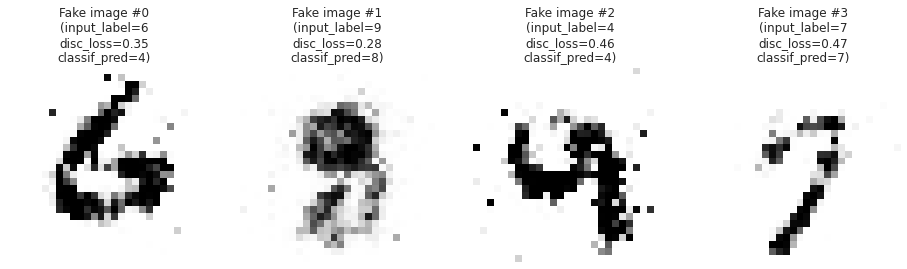


Epoch 00038: saving model to ./weights/cgan_noclassifier_checkpoints.038.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9722 - discriminator_loss: 0.5982 - classifier_loss: 0.0000e+00
Epoch 39/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.9424 - discriminator_loss: 0.6096 - classifier_loss: 0.0000e+00

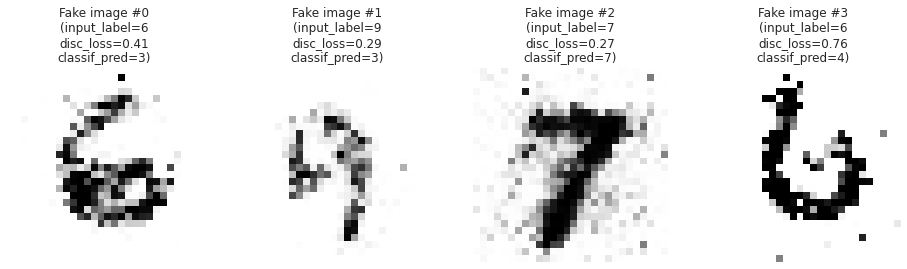


Epoch 00039: saving model to ./weights/cgan_noclassifier_checkpoints.039.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9424 - discriminator_loss: 0.6096 - classifier_loss: 0.0000e+00
Epoch 40/100
465/468 [============================>.] - ETA: 0s - generator_loss: 0.9099 - discriminator_loss: 0.6202 - classifier_loss: 0.0000e+00

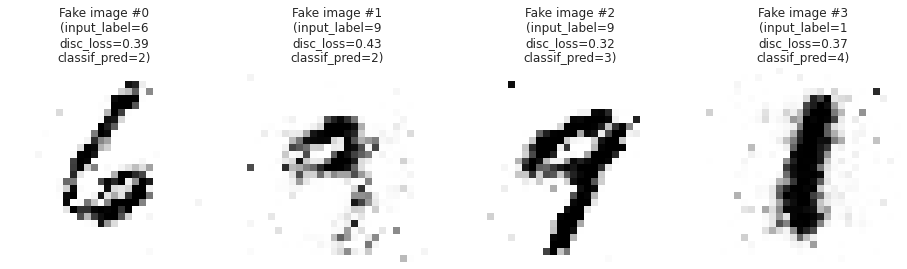


Epoch 00040: saving model to ./weights/cgan_noclassifier_checkpoints.040.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9098 - discriminator_loss: 0.6197 - classifier_loss: 0.0000e+00
Epoch 41/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9302 - discriminator_loss: 0.6122 - classifier_loss: 0.0000e+00

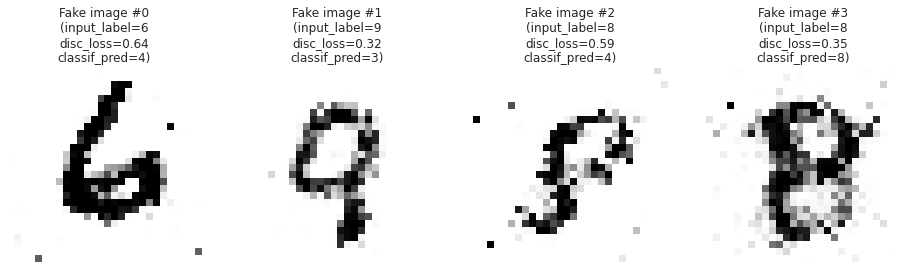


Epoch 00041: saving model to ./weights/cgan_noclassifier_checkpoints.041.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9304 - discriminator_loss: 0.6123 - classifier_loss: 0.0000e+00
Epoch 42/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9220 - discriminator_loss: 0.6140 - classifier_loss: 0.0000e+00

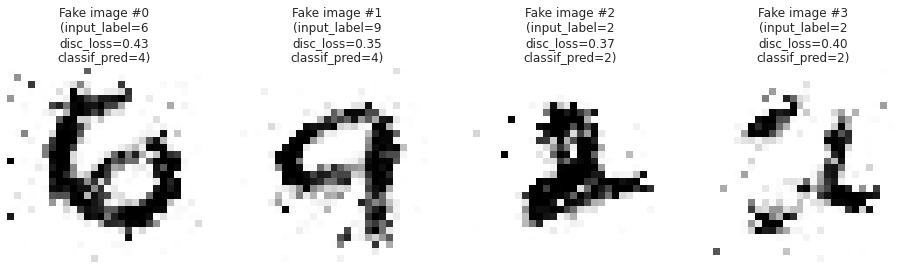


Epoch 00042: saving model to ./weights/cgan_noclassifier_checkpoints.042.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9222 - discriminator_loss: 0.6140 - classifier_loss: 0.0000e+00
Epoch 43/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.9313 - discriminator_loss: 0.6130 - classifier_loss: 0.0000e+00

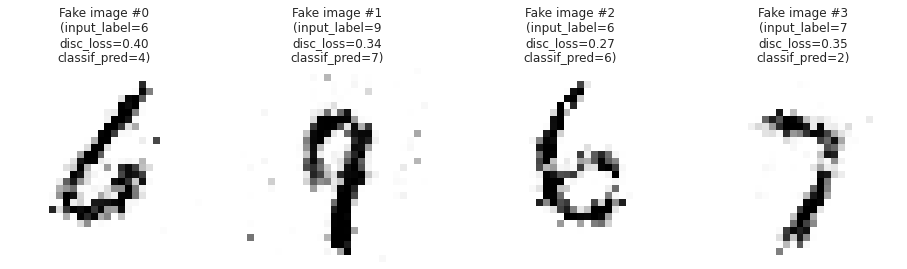


Epoch 00043: saving model to ./weights/cgan_noclassifier_checkpoints.043.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9319 - discriminator_loss: 0.6131 - classifier_loss: 0.0000e+00
Epoch 44/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9028 - discriminator_loss: 0.6223 - classifier_loss: 0.0000e+00

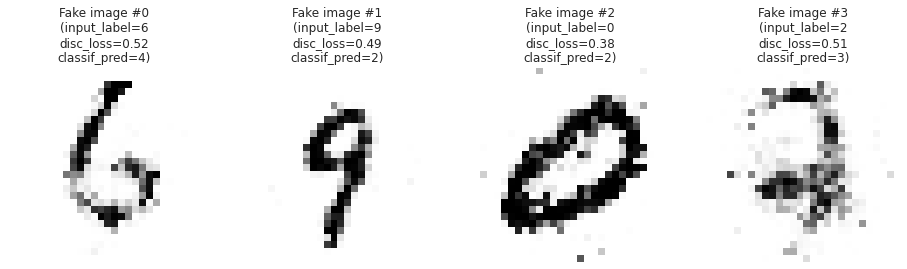


Epoch 00044: saving model to ./weights/cgan_noclassifier_checkpoints.044.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9028 - discriminator_loss: 0.6222 - classifier_loss: 0.0000e+00
Epoch 45/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9102 - discriminator_loss: 0.6200 - classifier_loss: 0.0000e+00

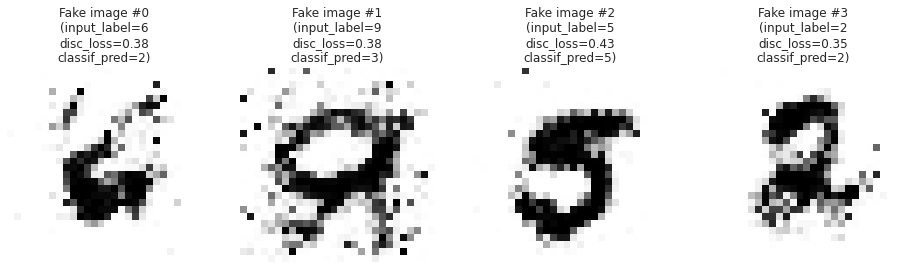


Epoch 00045: saving model to ./weights/cgan_noclassifier_checkpoints.045.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9102 - discriminator_loss: 0.6201 - classifier_loss: 0.0000e+00
Epoch 46/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8870 - discriminator_loss: 0.6279 - classifier_loss: 0.0000e+00

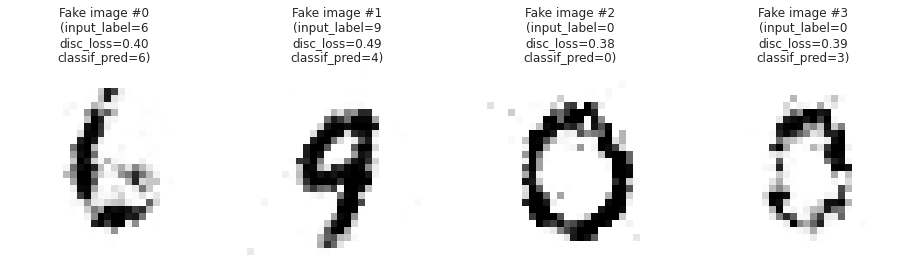


Epoch 00046: saving model to ./weights/cgan_noclassifier_checkpoints.046.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8872 - discriminator_loss: 0.6274 - classifier_loss: 0.0000e+00
Epoch 47/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8787 - discriminator_loss: 0.6315 - classifier_loss: 0.0000e+00

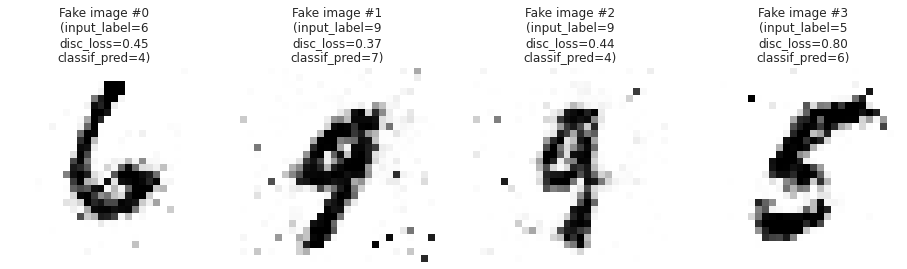


Epoch 00047: saving model to ./weights/cgan_noclassifier_checkpoints.047.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8789 - discriminator_loss: 0.6313 - classifier_loss: 0.0000e+00
Epoch 48/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8849 - discriminator_loss: 0.6274 - classifier_loss: 0.0000e+00

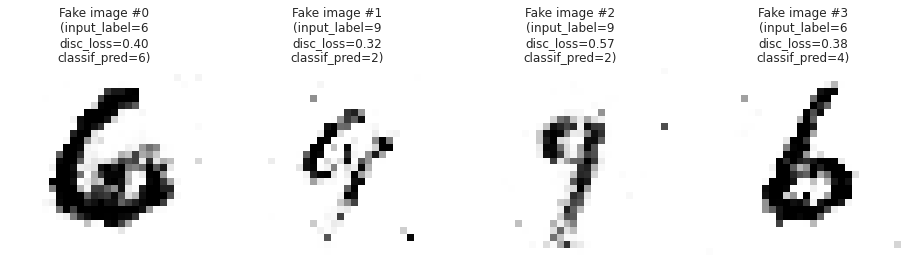


Epoch 00048: saving model to ./weights/cgan_noclassifier_checkpoints.048.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8853 - discriminator_loss: 0.6273 - classifier_loss: 0.0000e+00
Epoch 49/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9079 - discriminator_loss: 0.6204 - classifier_loss: 0.0000e+00

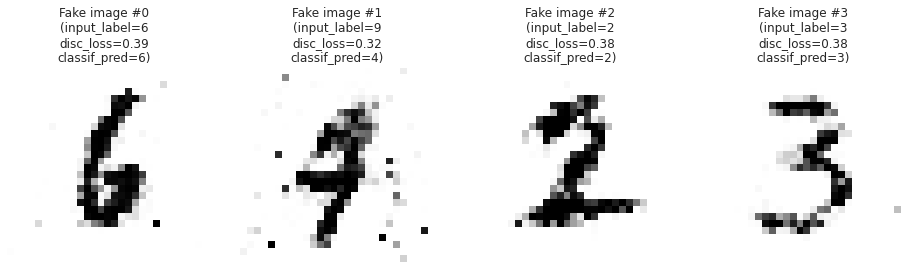


Epoch 00049: saving model to ./weights/cgan_noclassifier_checkpoints.049.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9087 - discriminator_loss: 0.6204 - classifier_loss: 0.0000e+00
Epoch 50/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.9191 - discriminator_loss: 0.6178 - classifier_loss: 0.0000e+00

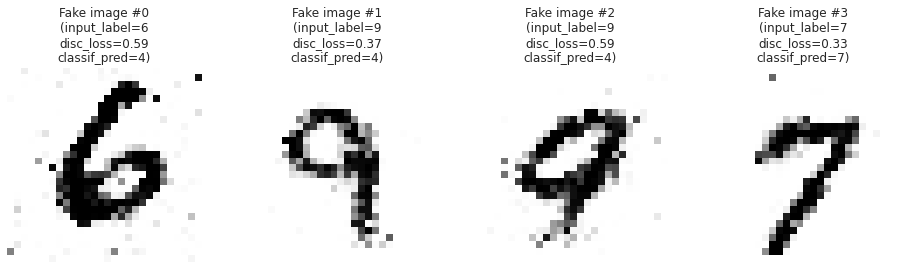


Epoch 00050: saving model to ./weights/cgan_noclassifier_checkpoints.050.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9192 - discriminator_loss: 0.6175 - classifier_loss: 0.0000e+00
Epoch 51/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8908 - discriminator_loss: 0.6265 - classifier_loss: 0.0000e+00

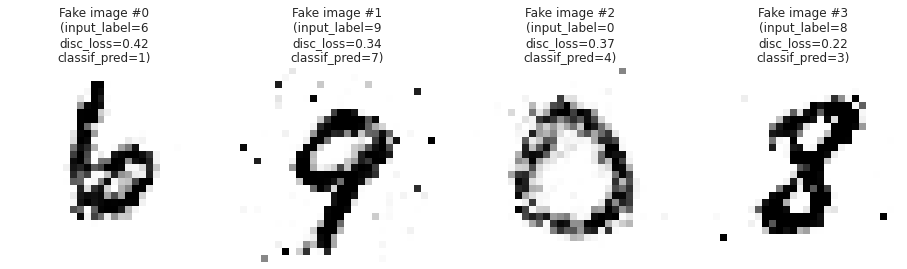


Epoch 00051: saving model to ./weights/cgan_noclassifier_checkpoints.051.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8915 - discriminator_loss: 0.6265 - classifier_loss: 0.0000e+00
Epoch 52/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8957 - discriminator_loss: 0.6262 - classifier_loss: 0.0000e+00

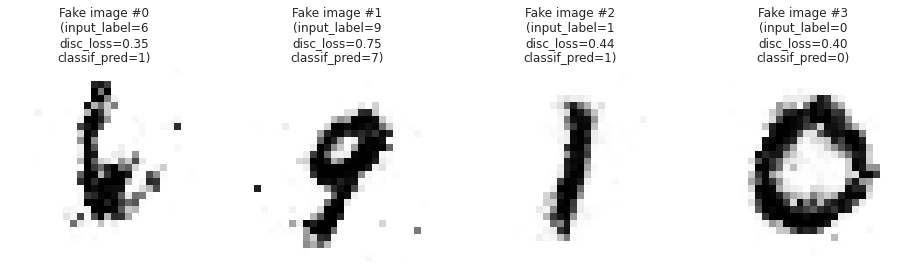


Epoch 00052: saving model to ./weights/cgan_noclassifier_checkpoints.052.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8959 - discriminator_loss: 0.6261 - classifier_loss: 0.0000e+00
Epoch 53/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8938 - discriminator_loss: 0.6262 - classifier_loss: 0.0000e+00

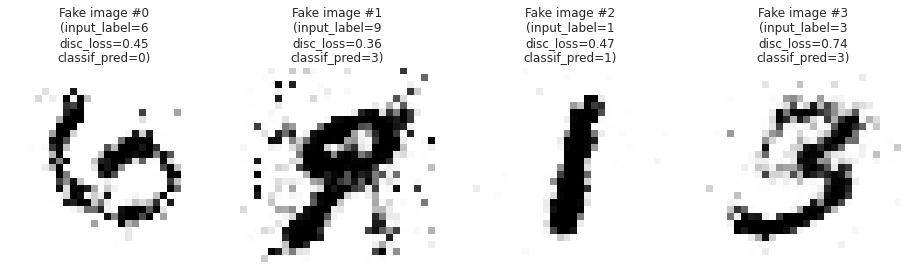


Epoch 00053: saving model to ./weights/cgan_noclassifier_checkpoints.053.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8939 - discriminator_loss: 0.6263 - classifier_loss: 0.0000e+00
Epoch 54/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8870 - discriminator_loss: 0.6322 - classifier_loss: 0.0000e+00

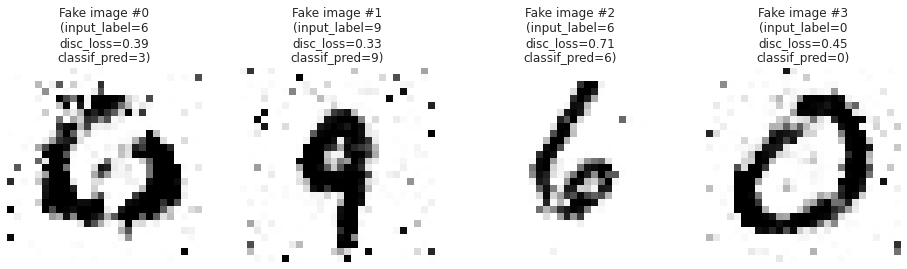


Epoch 00054: saving model to ./weights/cgan_noclassifier_checkpoints.054.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8873 - discriminator_loss: 0.6323 - classifier_loss: 0.0000e+00
Epoch 55/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8710 - discriminator_loss: 0.6374 - classifier_loss: 0.0000e+00

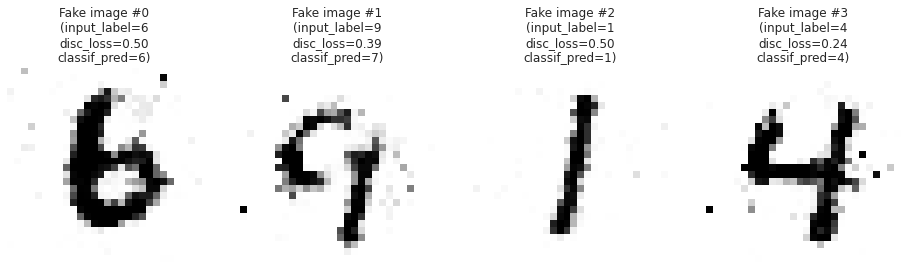


Epoch 00055: saving model to ./weights/cgan_noclassifier_checkpoints.055.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8715 - discriminator_loss: 0.6373 - classifier_loss: 0.0000e+00
Epoch 56/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8794 - discriminator_loss: 0.6325 - classifier_loss: 0.0000e+00

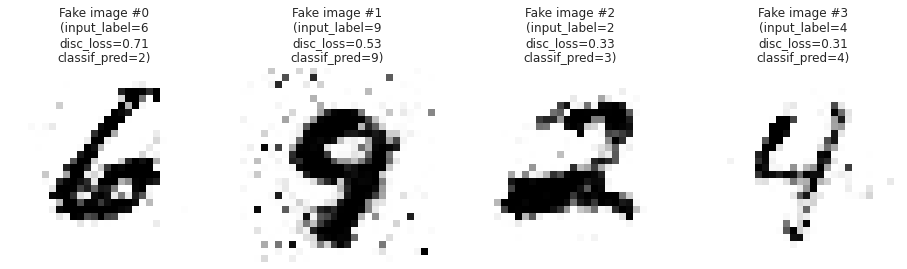


Epoch 00056: saving model to ./weights/cgan_noclassifier_checkpoints.056.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8797 - discriminator_loss: 0.6323 - classifier_loss: 0.0000e+00
Epoch 57/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8781 - discriminator_loss: 0.6338 - classifier_loss: 0.0000e+00

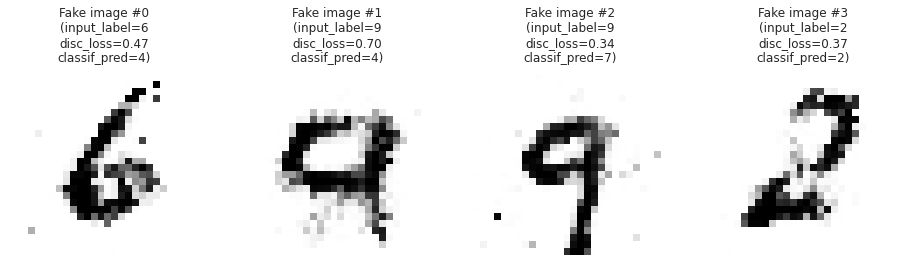


Epoch 00057: saving model to ./weights/cgan_noclassifier_checkpoints.057.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8782 - discriminator_loss: 0.6339 - classifier_loss: 0.0000e+00
Epoch 58/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9118 - discriminator_loss: 0.6233 - classifier_loss: 0.0000e+00

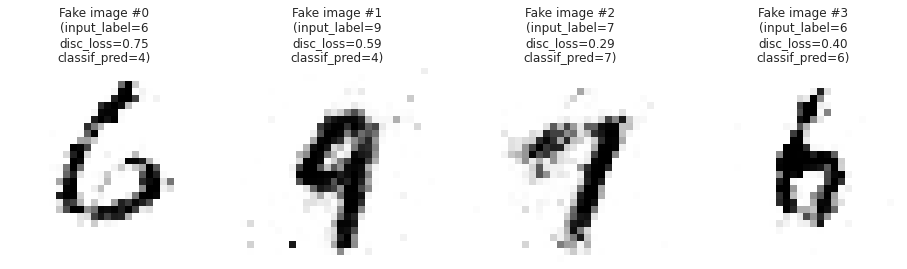


Epoch 00058: saving model to ./weights/cgan_noclassifier_checkpoints.058.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9121 - discriminator_loss: 0.6232 - classifier_loss: 0.0000e+00
Epoch 59/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9160 - discriminator_loss: 0.6221 - classifier_loss: 0.0000e+00

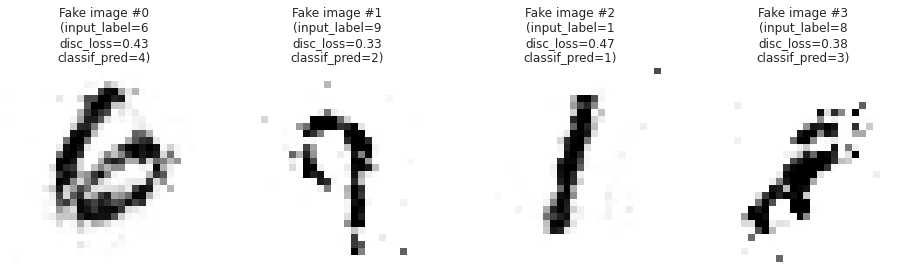


Epoch 00059: saving model to ./weights/cgan_noclassifier_checkpoints.059.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9164 - discriminator_loss: 0.6219 - classifier_loss: 0.0000e+00
Epoch 60/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9053 - discriminator_loss: 0.6257 - classifier_loss: 0.0000e+00

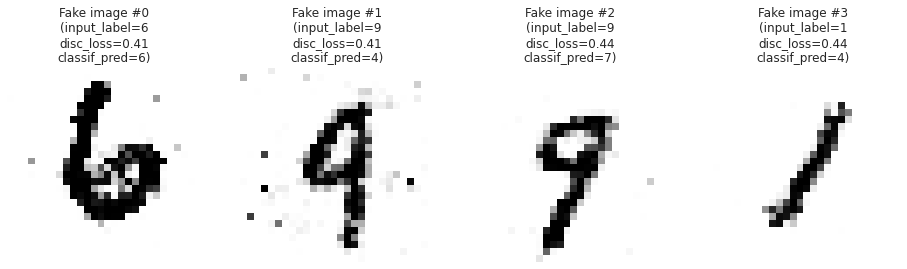


Epoch 00060: saving model to ./weights/cgan_noclassifier_checkpoints.060.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9053 - discriminator_loss: 0.6258 - classifier_loss: 0.0000e+00
Epoch 61/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8931 - discriminator_loss: 0.6295 - classifier_loss: 0.0000e+00

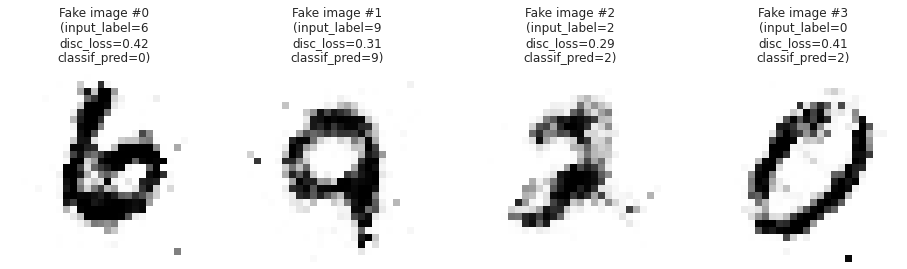


Epoch 00061: saving model to ./weights/cgan_noclassifier_checkpoints.061.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8932 - discriminator_loss: 0.6296 - classifier_loss: 0.0000e+00
Epoch 62/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9066 - discriminator_loss: 0.6251 - classifier_loss: 0.0000e+00

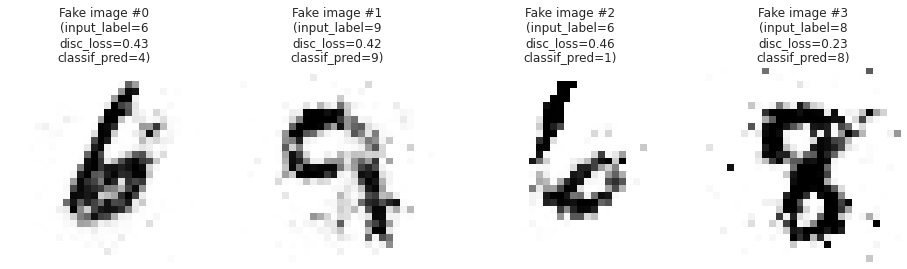


Epoch 00062: saving model to ./weights/cgan_noclassifier_checkpoints.062.h5
468/468 [==============================] - 9s 18ms/step - generator_loss: 0.9066 - discriminator_loss: 0.6250 - classifier_loss: 0.0000e+00
Epoch 63/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9044 - discriminator_loss: 0.6245 - classifier_loss: 0.0000e+00

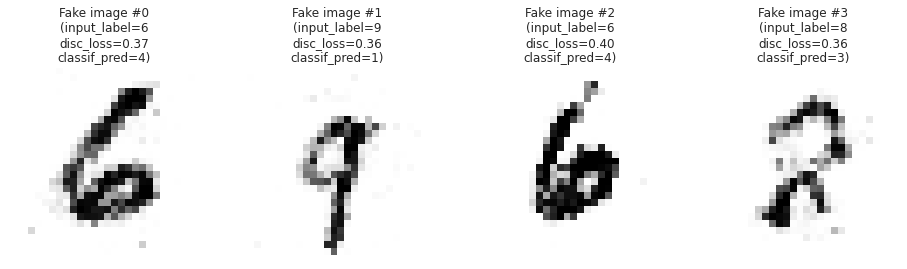


Epoch 00063: saving model to ./weights/cgan_noclassifier_checkpoints.063.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9049 - discriminator_loss: 0.6242 - classifier_loss: 0.0000e+00
Epoch 64/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8890 - discriminator_loss: 0.6332 - classifier_loss: 0.0000e+00

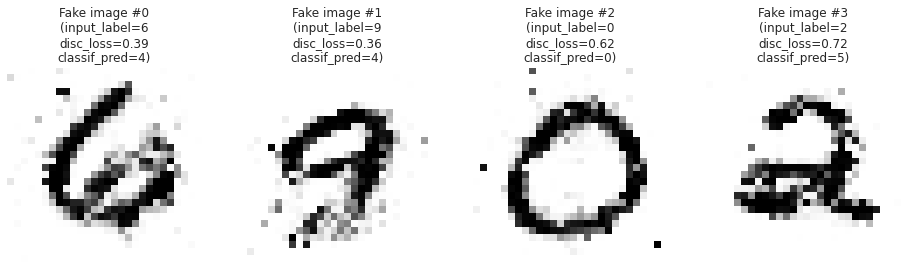


Epoch 00064: saving model to ./weights/cgan_noclassifier_checkpoints.064.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8890 - discriminator_loss: 0.6333 - classifier_loss: 0.0000e+00
Epoch 65/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8847 - discriminator_loss: 0.6319 - classifier_loss: 0.0000e+00

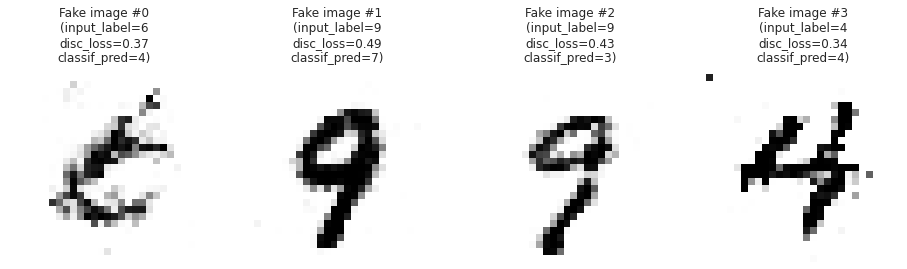


Epoch 00065: saving model to ./weights/cgan_noclassifier_checkpoints.065.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8849 - discriminator_loss: 0.6317 - classifier_loss: 0.0000e+00
Epoch 66/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8886 - discriminator_loss: 0.6335 - classifier_loss: 0.0000e+00

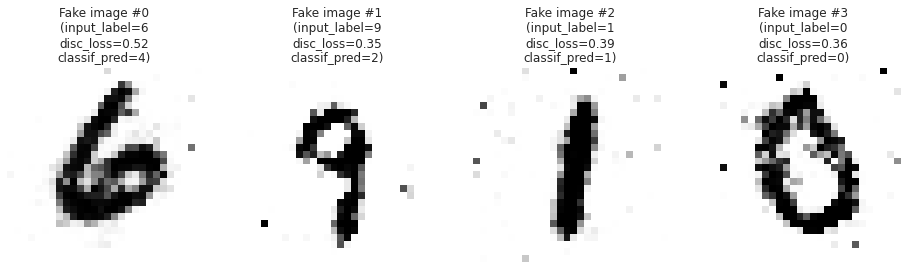


Epoch 00066: saving model to ./weights/cgan_noclassifier_checkpoints.066.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8889 - discriminator_loss: 0.6336 - classifier_loss: 0.0000e+00
Epoch 67/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8852 - discriminator_loss: 0.6332 - classifier_loss: 0.0000e+00

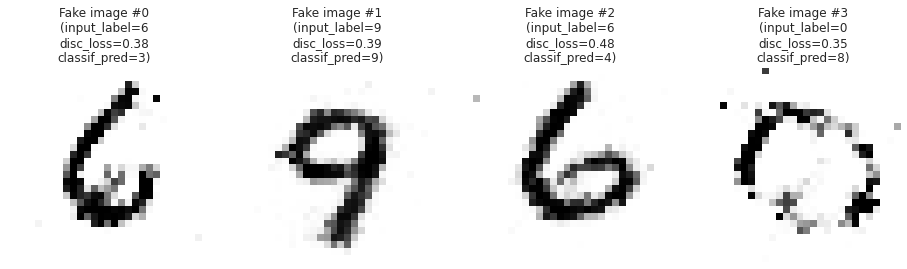


Epoch 00067: saving model to ./weights/cgan_noclassifier_checkpoints.067.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8854 - discriminator_loss: 0.6332 - classifier_loss: 0.0000e+00
Epoch 68/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8888 - discriminator_loss: 0.6319 - classifier_loss: 0.0000e+00

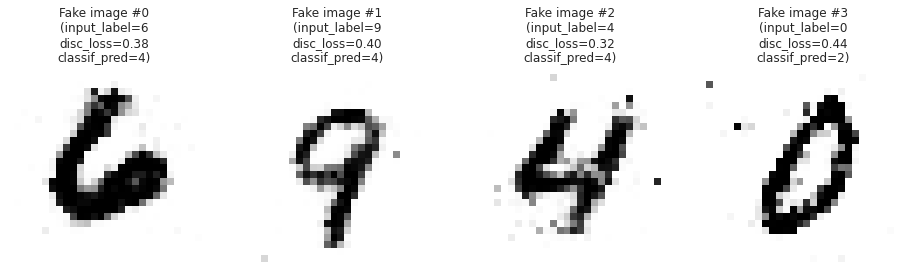


Epoch 00068: saving model to ./weights/cgan_noclassifier_checkpoints.068.h5
468/468 [==============================] - 9s 18ms/step - generator_loss: 0.8890 - discriminator_loss: 0.6320 - classifier_loss: 0.0000e+00
Epoch 69/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8925 - discriminator_loss: 0.6283 - classifier_loss: 0.0000e+00

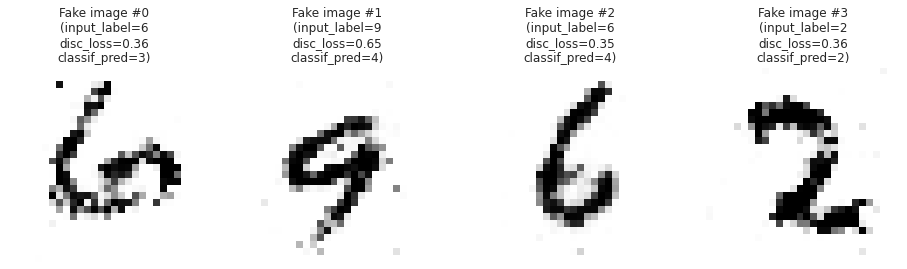


Epoch 00069: saving model to ./weights/cgan_noclassifier_checkpoints.069.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8929 - discriminator_loss: 0.6284 - classifier_loss: 0.0000e+00
Epoch 70/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.9143 - discriminator_loss: 0.6251 - classifier_loss: 0.0000e+00

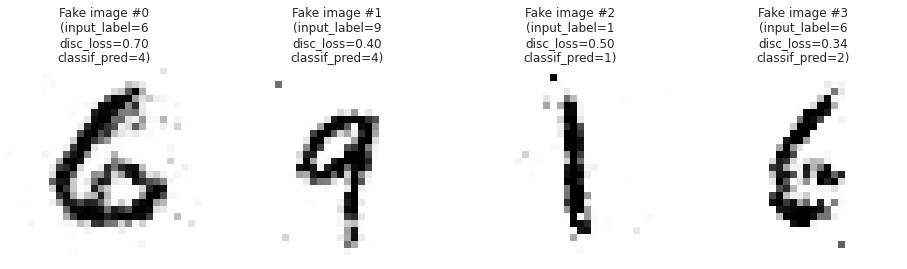


Epoch 00070: saving model to ./weights/cgan_noclassifier_checkpoints.070.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9145 - discriminator_loss: 0.6251 - classifier_loss: 0.0000e+00
Epoch 71/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.9044 - discriminator_loss: 0.6271 - classifier_loss: 0.0000e+00

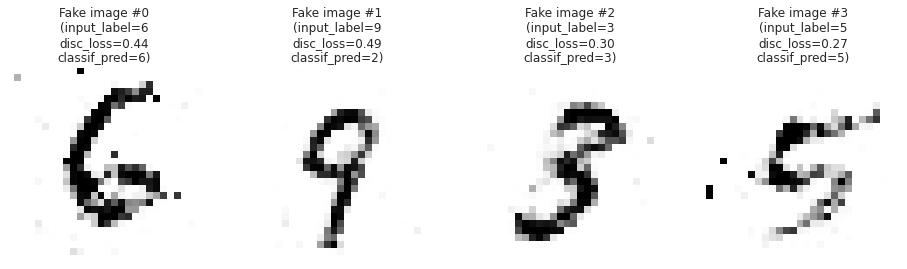


Epoch 00071: saving model to ./weights/cgan_noclassifier_checkpoints.071.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9046 - discriminator_loss: 0.6270 - classifier_loss: 0.0000e+00
Epoch 72/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8848 - discriminator_loss: 0.6339 - classifier_loss: 0.0000e+00

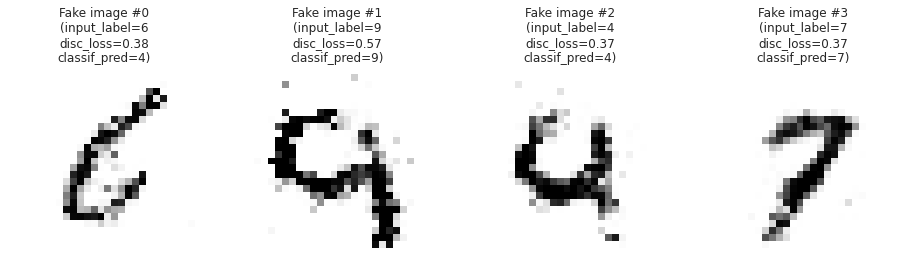


Epoch 00072: saving model to ./weights/cgan_noclassifier_checkpoints.072.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8850 - discriminator_loss: 0.6337 - classifier_loss: 0.0000e+00
Epoch 73/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8840 - discriminator_loss: 0.6329 - classifier_loss: 0.0000e+00

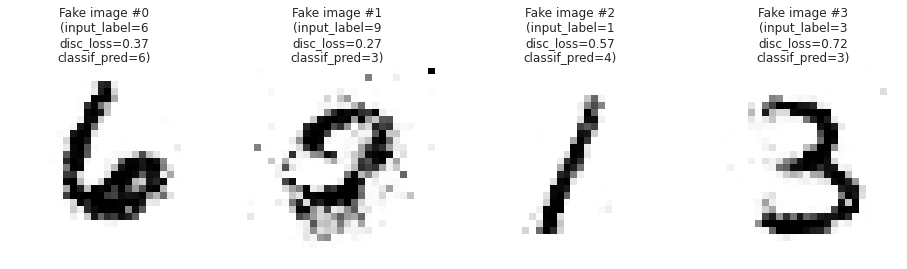


Epoch 00073: saving model to ./weights/cgan_noclassifier_checkpoints.073.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8845 - discriminator_loss: 0.6326 - classifier_loss: 0.0000e+00
Epoch 74/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8886 - discriminator_loss: 0.6327 - classifier_loss: 0.0000e+00

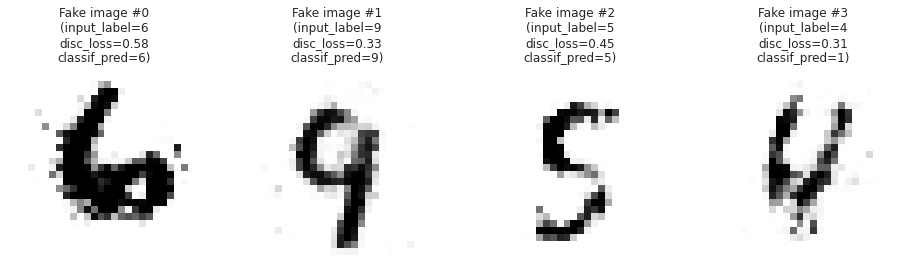


Epoch 00074: saving model to ./weights/cgan_noclassifier_checkpoints.074.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8888 - discriminator_loss: 0.6324 - classifier_loss: 0.0000e+00
Epoch 75/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8994 - discriminator_loss: 0.6319 - classifier_loss: 0.0000e+00

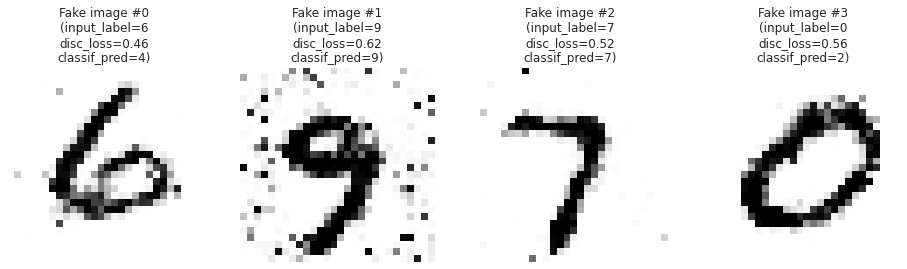


Epoch 00075: saving model to ./weights/cgan_noclassifier_checkpoints.075.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8994 - discriminator_loss: 0.6319 - classifier_loss: 0.0000e+00
Epoch 76/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8694 - discriminator_loss: 0.6400 - classifier_loss: 0.0000e+00

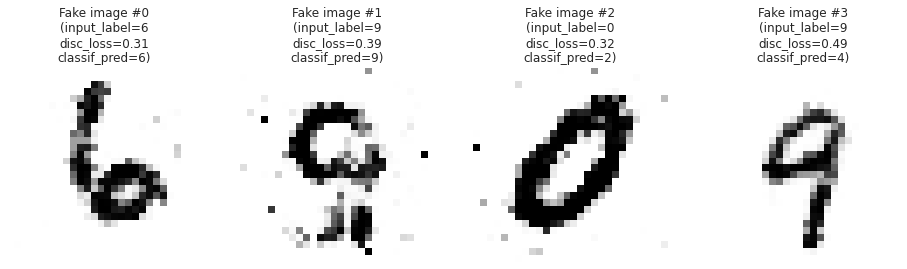


Epoch 00076: saving model to ./weights/cgan_noclassifier_checkpoints.076.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8699 - discriminator_loss: 0.6401 - classifier_loss: 0.0000e+00
Epoch 77/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8765 - discriminator_loss: 0.6382 - classifier_loss: 0.0000e+00

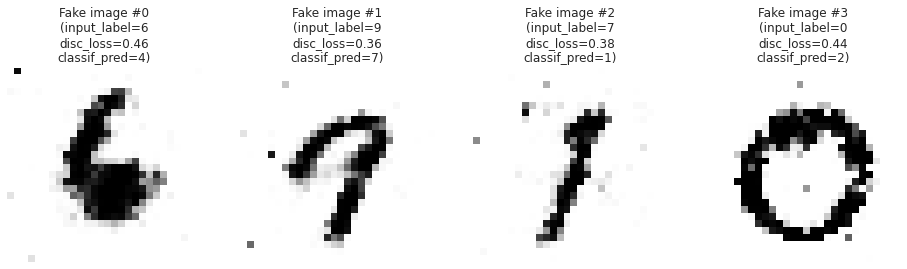


Epoch 00077: saving model to ./weights/cgan_noclassifier_checkpoints.077.h5
468/468 [==============================] - 9s 18ms/step - generator_loss: 0.8766 - discriminator_loss: 0.6381 - classifier_loss: 0.0000e+00
Epoch 78/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8811 - discriminator_loss: 0.6375 - classifier_loss: 0.0000e+00

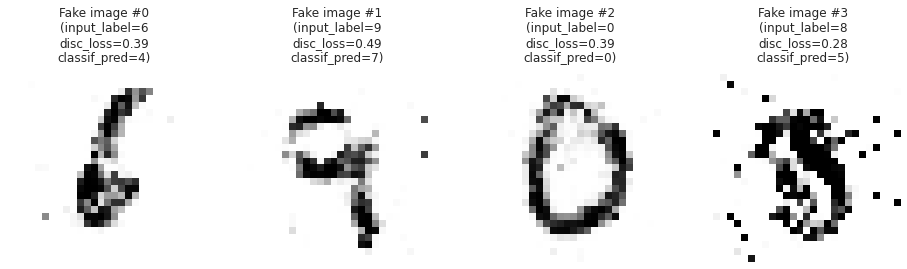


Epoch 00078: saving model to ./weights/cgan_noclassifier_checkpoints.078.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8814 - discriminator_loss: 0.6373 - classifier_loss: 0.0000e+00
Epoch 79/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8841 - discriminator_loss: 0.6359 - classifier_loss: 0.0000e+00

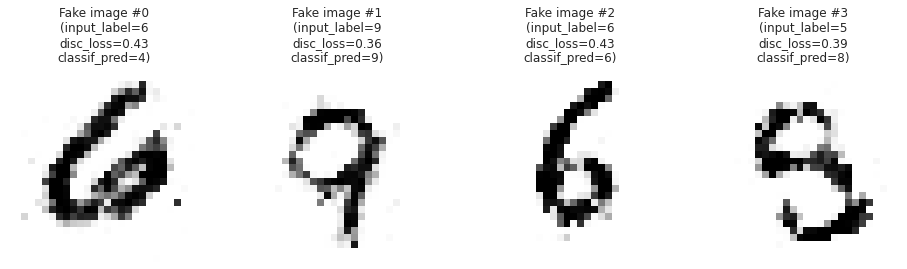


Epoch 00079: saving model to ./weights/cgan_noclassifier_checkpoints.079.h5
468/468 [==============================] - 8s 18ms/step - generator_loss: 0.8841 - discriminator_loss: 0.6358 - classifier_loss: 0.0000e+00
Epoch 80/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8720 - discriminator_loss: 0.6411 - classifier_loss: 0.0000e+00

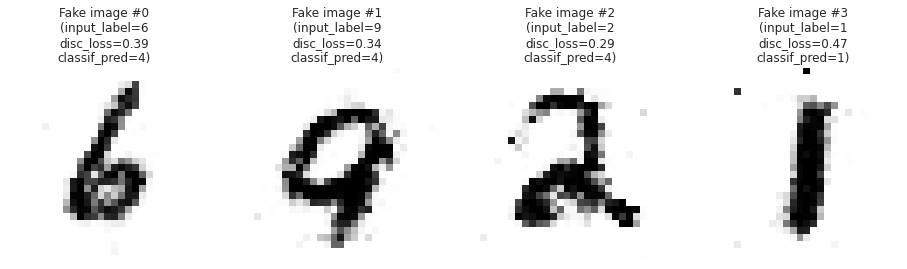


Epoch 00080: saving model to ./weights/cgan_noclassifier_checkpoints.080.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8727 - discriminator_loss: 0.6411 - classifier_loss: 0.0000e+00
Epoch 81/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8695 - discriminator_loss: 0.6426 - classifier_loss: 0.0000e+00

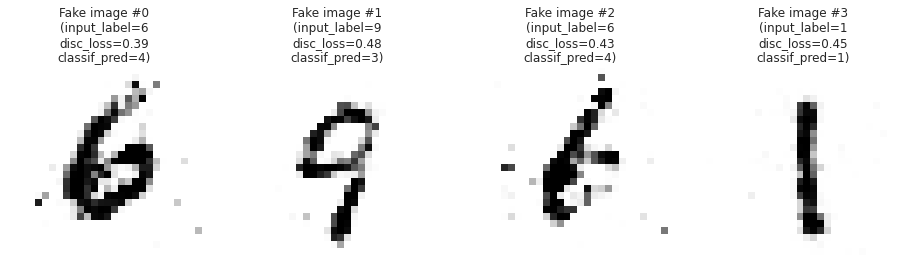


Epoch 00081: saving model to ./weights/cgan_noclassifier_checkpoints.081.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8696 - discriminator_loss: 0.6425 - classifier_loss: 0.0000e+00
Epoch 82/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8656 - discriminator_loss: 0.6434 - classifier_loss: 0.0000e+00

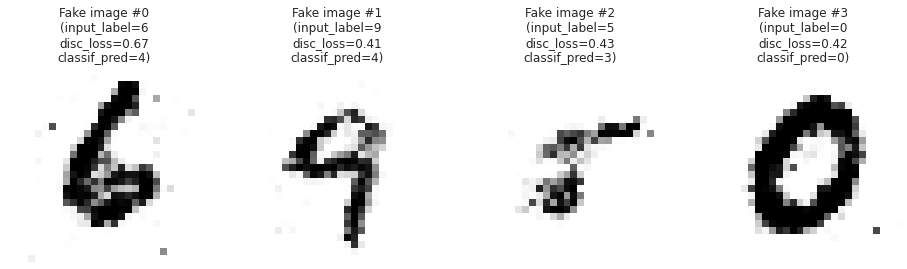


Epoch 00082: saving model to ./weights/cgan_noclassifier_checkpoints.082.h5
468/468 [==============================] - 9s 18ms/step - generator_loss: 0.8655 - discriminator_loss: 0.6435 - classifier_loss: 0.0000e+00
Epoch 83/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8551 - discriminator_loss: 0.6441 - classifier_loss: 0.0000e+00

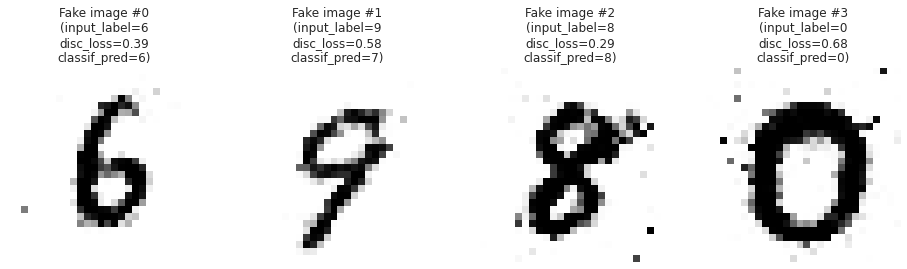


Epoch 00083: saving model to ./weights/cgan_noclassifier_checkpoints.083.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8554 - discriminator_loss: 0.6440 - classifier_loss: 0.0000e+00
Epoch 84/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8900 - discriminator_loss: 0.6345 - classifier_loss: 0.0000e+00

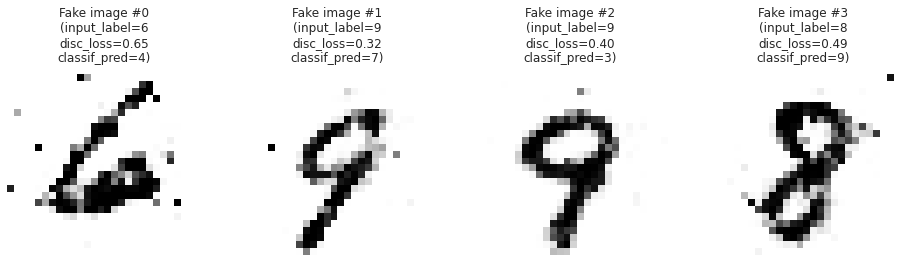


Epoch 00084: saving model to ./weights/cgan_noclassifier_checkpoints.084.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8906 - discriminator_loss: 0.6343 - classifier_loss: 0.0000e+00
Epoch 85/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8812 - discriminator_loss: 0.6393 - classifier_loss: 0.0000e+00

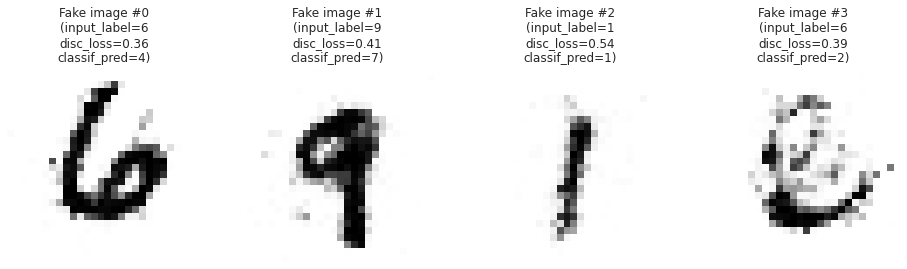


Epoch 00085: saving model to ./weights/cgan_noclassifier_checkpoints.085.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8814 - discriminator_loss: 0.6393 - classifier_loss: 0.0000e+00
Epoch 86/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8788 - discriminator_loss: 0.6390 - classifier_loss: 0.0000e+00

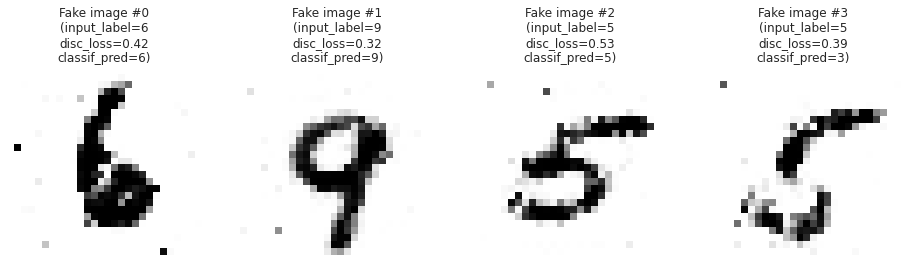


Epoch 00086: saving model to ./weights/cgan_noclassifier_checkpoints.086.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8789 - discriminator_loss: 0.6386 - classifier_loss: 0.0000e+00
Epoch 87/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8815 - discriminator_loss: 0.6384 - classifier_loss: 0.0000e+00

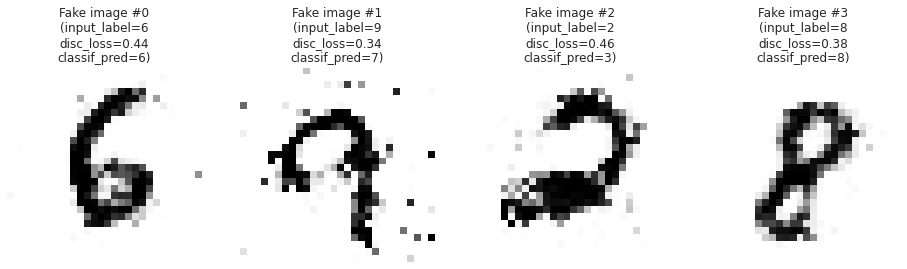


Epoch 00087: saving model to ./weights/cgan_noclassifier_checkpoints.087.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8816 - discriminator_loss: 0.6383 - classifier_loss: 0.0000e+00
Epoch 88/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8789 - discriminator_loss: 0.6399 - classifier_loss: 0.0000e+00

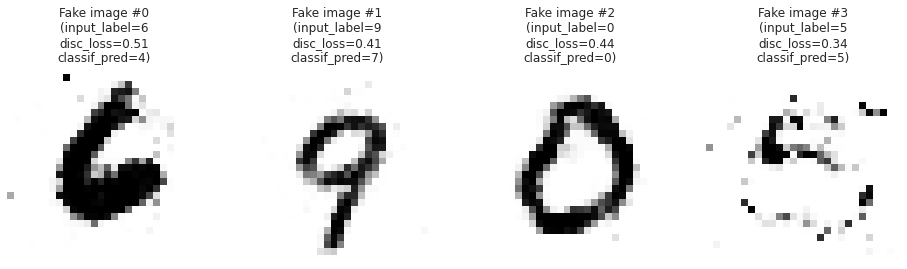


Epoch 00088: saving model to ./weights/cgan_noclassifier_checkpoints.088.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8791 - discriminator_loss: 0.6399 - classifier_loss: 0.0000e+00
Epoch 89/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8846 - discriminator_loss: 0.6381 - classifier_loss: 0.0000e+00

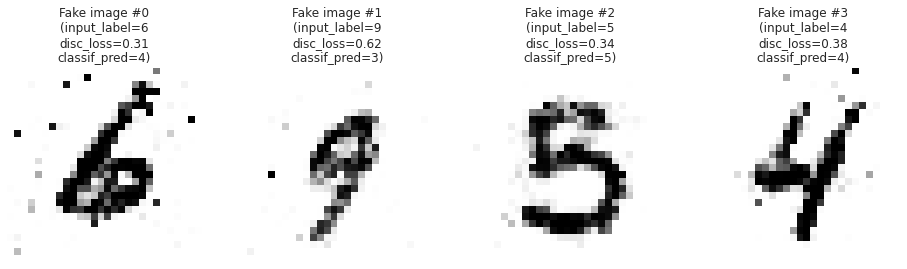


Epoch 00089: saving model to ./weights/cgan_noclassifier_checkpoints.089.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8846 - discriminator_loss: 0.6382 - classifier_loss: 0.0000e+00
Epoch 90/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8825 - discriminator_loss: 0.6376 - classifier_loss: 0.0000e+00

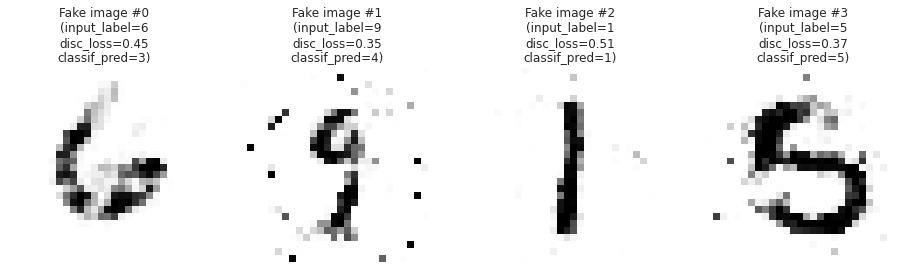


Epoch 00090: saving model to ./weights/cgan_noclassifier_checkpoints.090.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8827 - discriminator_loss: 0.6375 - classifier_loss: 0.0000e+00
Epoch 91/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8967 - discriminator_loss: 0.6332 - classifier_loss: 0.0000e+00

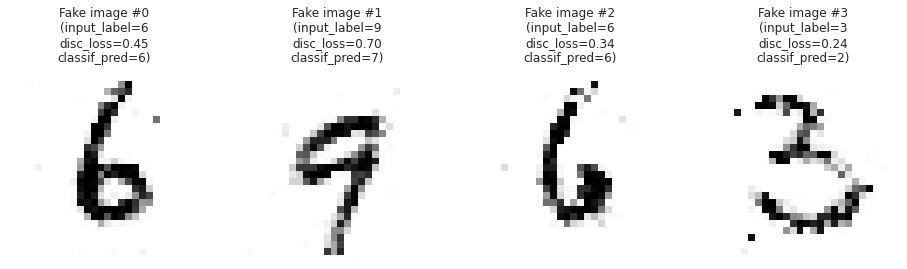


Epoch 00091: saving model to ./weights/cgan_noclassifier_checkpoints.091.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8971 - discriminator_loss: 0.6330 - classifier_loss: 0.0000e+00
Epoch 92/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8862 - discriminator_loss: 0.6385 - classifier_loss: 0.0000e+00

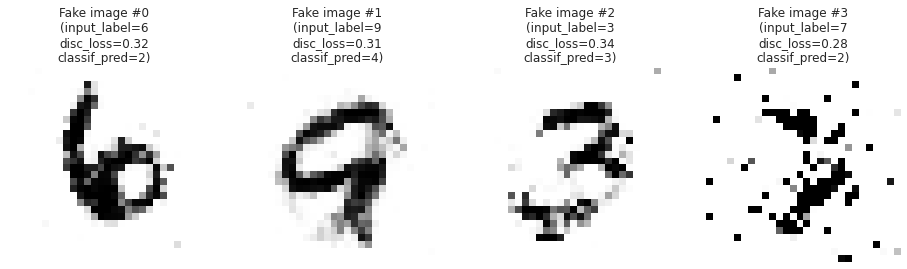


Epoch 00092: saving model to ./weights/cgan_noclassifier_checkpoints.092.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8863 - discriminator_loss: 0.6385 - classifier_loss: 0.0000e+00
Epoch 93/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8886 - discriminator_loss: 0.6348 - classifier_loss: 0.0000e+00

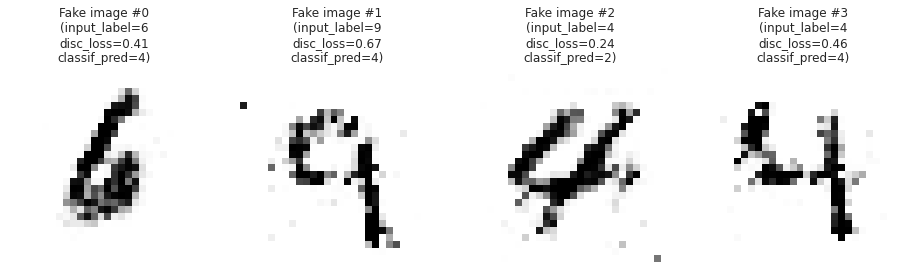


Epoch 00093: saving model to ./weights/cgan_noclassifier_checkpoints.093.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8889 - discriminator_loss: 0.6346 - classifier_loss: 0.0000e+00
Epoch 94/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9025 - discriminator_loss: 0.6358 - classifier_loss: 0.0000e+00

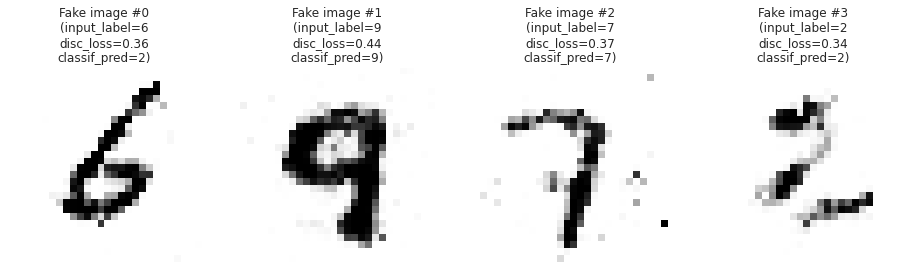


Epoch 00094: saving model to ./weights/cgan_noclassifier_checkpoints.094.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.9026 - discriminator_loss: 0.6357 - classifier_loss: 0.0000e+00
Epoch 95/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8658 - discriminator_loss: 0.6445 - classifier_loss: 0.0000e+00

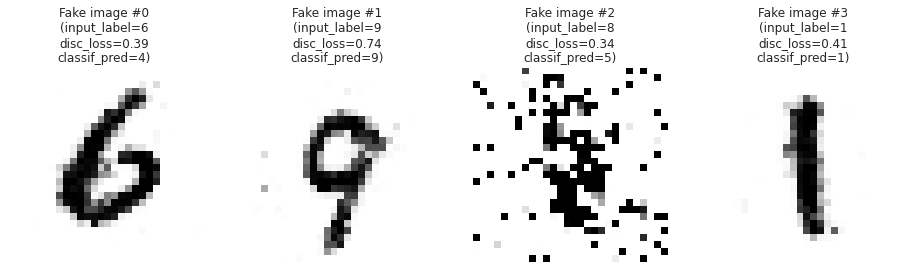


Epoch 00095: saving model to ./weights/cgan_noclassifier_checkpoints.095.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8661 - discriminator_loss: 0.6447 - classifier_loss: 0.0000e+00
Epoch 96/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8750 - discriminator_loss: 0.6422 - classifier_loss: 0.0000e+00

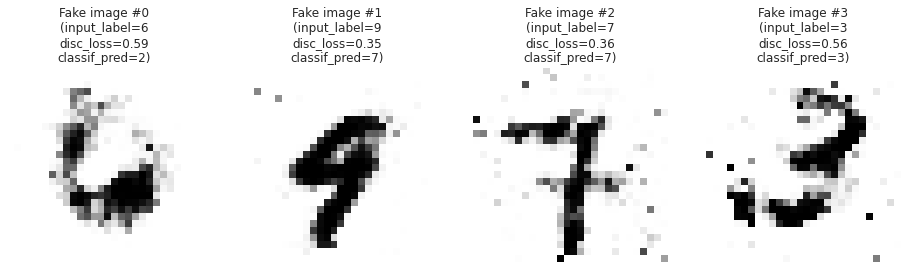


Epoch 00096: saving model to ./weights/cgan_noclassifier_checkpoints.096.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8754 - discriminator_loss: 0.6420 - classifier_loss: 0.0000e+00
Epoch 97/100
467/468 [============================>.] - ETA: 0s - generator_loss: 0.8660 - discriminator_loss: 0.6460 - classifier_loss: 0.0000e+00

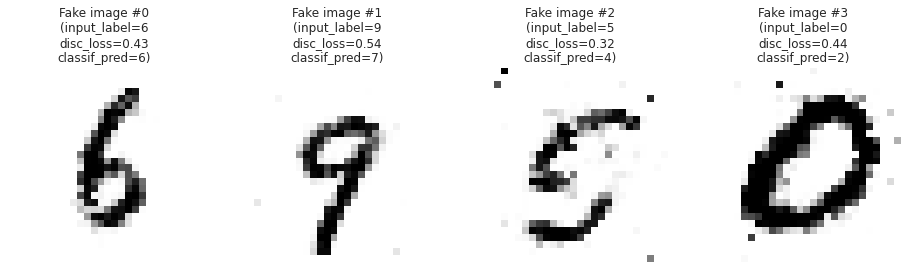


Epoch 00097: saving model to ./weights/cgan_noclassifier_checkpoints.097.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8659 - discriminator_loss: 0.6458 - classifier_loss: 0.0000e+00
Epoch 98/100
465/468 [============================>.] - ETA: 0s - generator_loss: 0.8773 - discriminator_loss: 0.6410 - classifier_loss: 0.0000e+00

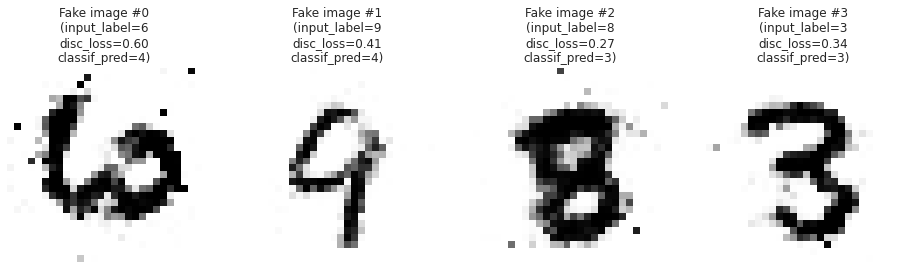


Epoch 00098: saving model to ./weights/cgan_noclassifier_checkpoints.098.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8775 - discriminator_loss: 0.6407 - classifier_loss: 0.0000e+00
Epoch 99/100
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8739 - discriminator_loss: 0.6447 - classifier_loss: 0.0000e+00

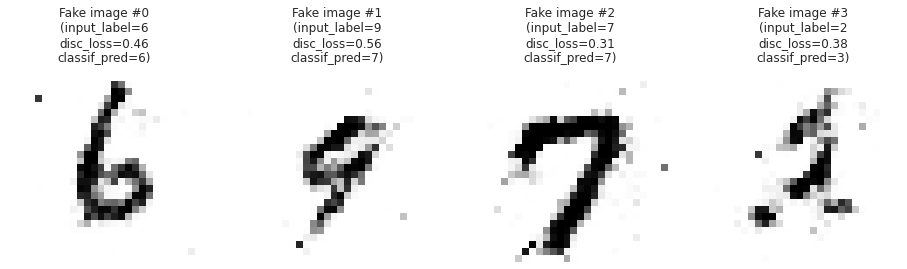


Epoch 00099: saving model to ./weights/cgan_noclassifier_checkpoints.099.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8743 - discriminator_loss: 0.6448 - classifier_loss: 0.0000e+00
Epoch 100/100
468/468 [==============================] - ETA: 0s - generator_loss: 0.8597 - discriminator_loss: 0.6484 - classifier_loss: 0.0000e+00

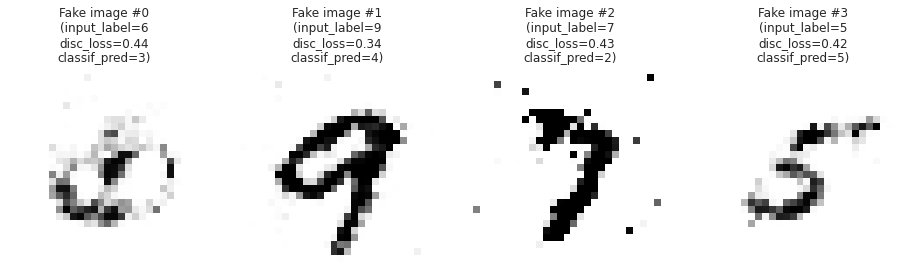


Epoch 00100: saving model to ./weights/cgan_noclassifier_checkpoints.100.h5
468/468 [==============================] - 9s 19ms/step - generator_loss: 0.8597 - discriminator_loss: 0.6483 - classifier_loss: 0.0000e+00


In [ ]:
if TEST_CGAN:
    
    # For debug purpose (in order to test the cGAN architecture and its generation capacity under conditions)
    gangan_noclassifier = cGan(
        generator=build_generator(), 
        discriminator=build_discriminator(), 
        classifier=None,
        pretrained=False,
    )
    gangan_noclassifier.compile()

    print(f"CGAN_EPOCHS={CGAN_EPOCHS}")
    print(f"Training cGAN without classifier (for debug purpose only)")
    
    from tensorflow.keras import backend as K
    K.clear_session()
    
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint("./weights/cgan_noclassifier_checkpoints.{epoch:03d}.h5", verbose=VERBOSE)  
    
    gangan_noclassifier.fit(
        tf.data.Dataset.zip((mnist_x_train_dataset, mnist_y_train_dataset)),
        epochs=CGAN_EPOCHS,
        callbacks=[gangan_noclassifier_plotter, checkpoint],
        verbose=VERBOSE,
    )

#### Phase 1) Pretraining phase of cGAN

CGAN_EPOCHS=100
Training cGAN with classifier (pretraining phase)
pretrained=False
Epoch 1/200
Classifier won't be trained!!!
Classifier won't be trained!!!
466/468 [============================>.] - ETA: 0s - generator_loss: 4.2576 - discriminator_loss: 0.2267 - classifier_loss: 0.0000e+00

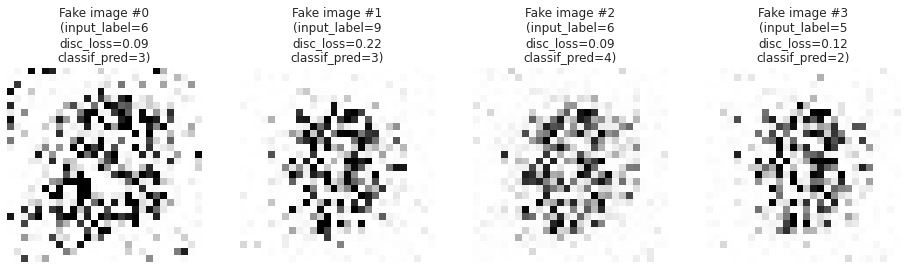


Epoch 00001: saving model to ./weights/cgan_pretrained=False_checkpoints.001.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 4.2524 - discriminator_loss: 0.2270 - classifier_loss: 0.0000e+00
Epoch 2/200
466/468 [============================>.] - ETA: 0s - generator_loss: 2.5641 - discriminator_loss: 0.3427 - classifier_loss: 0.0000e+00

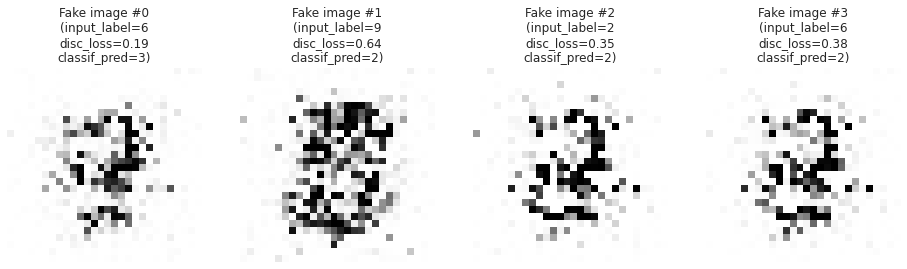


Epoch 00002: saving model to ./weights/cgan_pretrained=False_checkpoints.002.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 2.5601 - discriminator_loss: 0.3428 - classifier_loss: 0.0000e+00
Epoch 3/200
466/468 [============================>.] - ETA: 0s - generator_loss: 2.0039 - discriminator_loss: 0.3549 - classifier_loss: 0.0000e+00

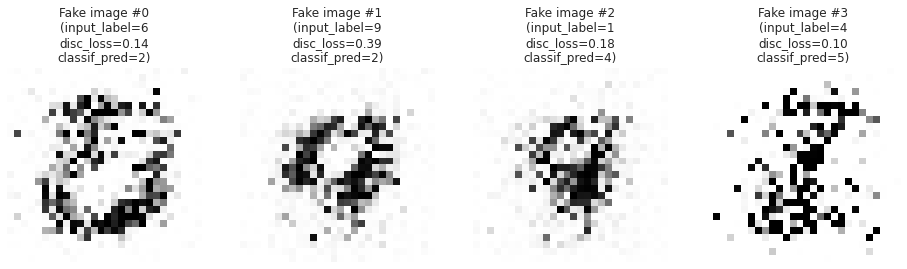


Epoch 00003: saving model to ./weights/cgan_pretrained=False_checkpoints.003.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 2.0027 - discriminator_loss: 0.3544 - classifier_loss: 0.0000e+00
Epoch 4/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.7782 - discriminator_loss: 0.3932 - classifier_loss: 0.0000e+00

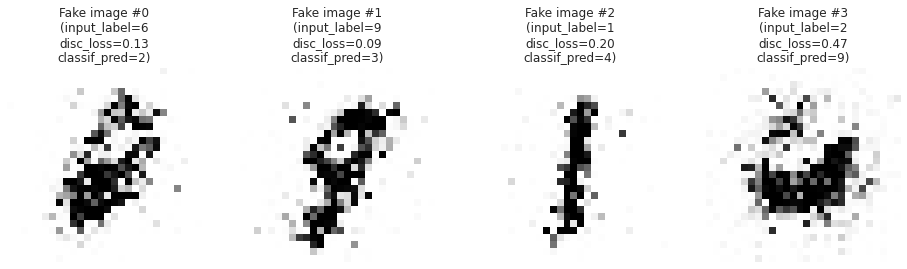


Epoch 00004: saving model to ./weights/cgan_pretrained=False_checkpoints.004.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.7777 - discriminator_loss: 0.3930 - classifier_loss: 0.0000e+00
Epoch 5/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.5390 - discriminator_loss: 0.4454 - classifier_loss: 0.0000e+00

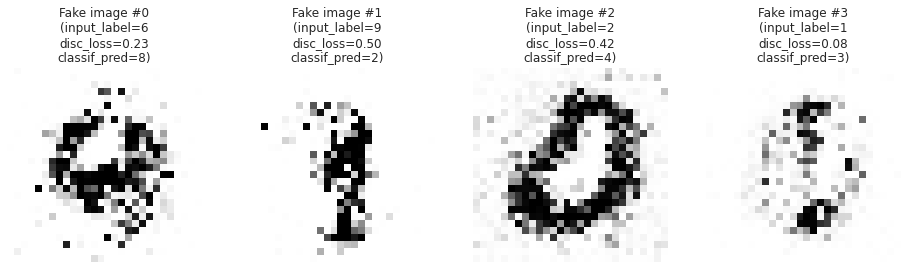


Epoch 00005: saving model to ./weights/cgan_pretrained=False_checkpoints.005.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.5395 - discriminator_loss: 0.4454 - classifier_loss: 0.0000e+00
Epoch 6/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.3340 - discriminator_loss: 0.4975 - classifier_loss: 0.0000e+00

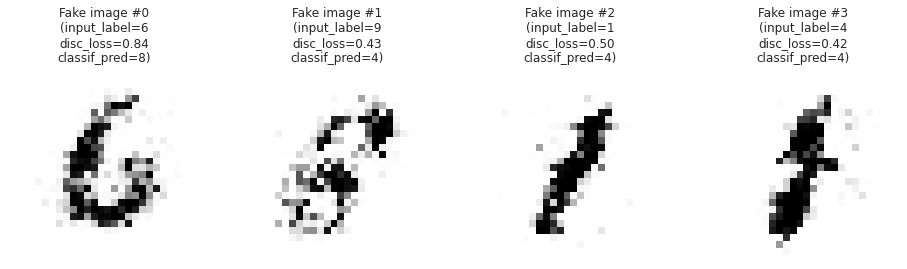


Epoch 00006: saving model to ./weights/cgan_pretrained=False_checkpoints.006.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.3329 - discriminator_loss: 0.4974 - classifier_loss: 0.0000e+00
Epoch 7/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1555 - discriminator_loss: 0.5426 - classifier_loss: 0.0000e+00

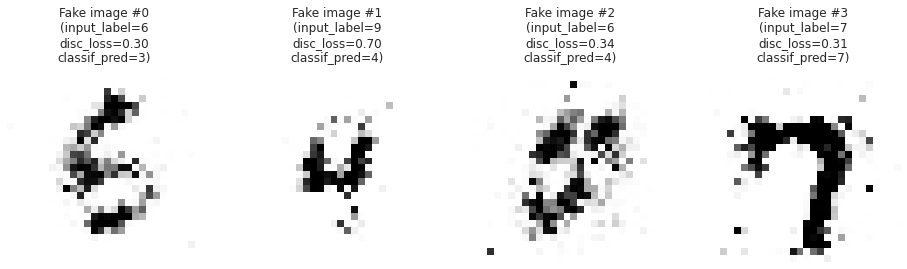


Epoch 00007: saving model to ./weights/cgan_pretrained=False_checkpoints.007.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1554 - discriminator_loss: 0.5426 - classifier_loss: 0.0000e+00
Epoch 8/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1587 - discriminator_loss: 0.5442 - classifier_loss: 0.0000e+00

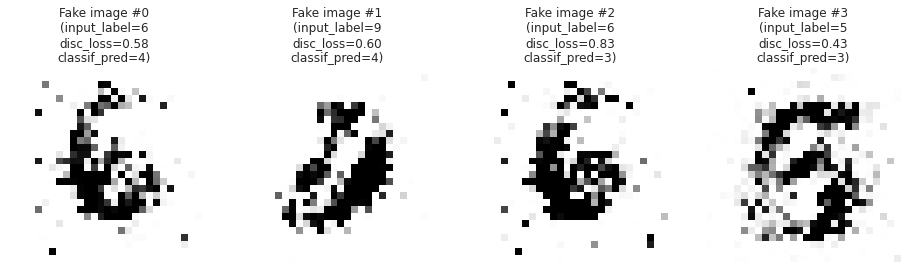


Epoch 00008: saving model to ./weights/cgan_pretrained=False_checkpoints.008.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1592 - discriminator_loss: 0.5439 - classifier_loss: 0.0000e+00
Epoch 9/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1796 - discriminator_loss: 0.5354 - classifier_loss: 0.0000e+00

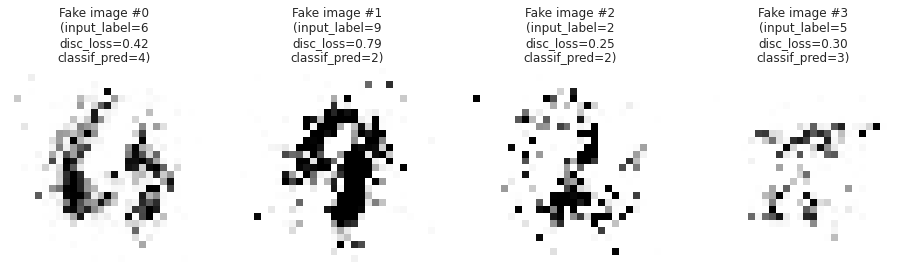


Epoch 00009: saving model to ./weights/cgan_pretrained=False_checkpoints.009.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1801 - discriminator_loss: 0.5351 - classifier_loss: 0.0000e+00
Epoch 10/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.2414 - discriminator_loss: 0.5195 - classifier_loss: 0.0000e+00

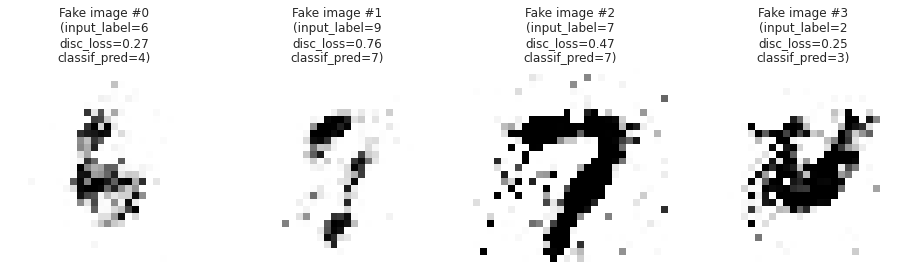


Epoch 00010: saving model to ./weights/cgan_pretrained=False_checkpoints.010.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.2419 - discriminator_loss: 0.5191 - classifier_loss: 0.0000e+00
Epoch 11/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.2995 - discriminator_loss: 0.5078 - classifier_loss: 0.0000e+00

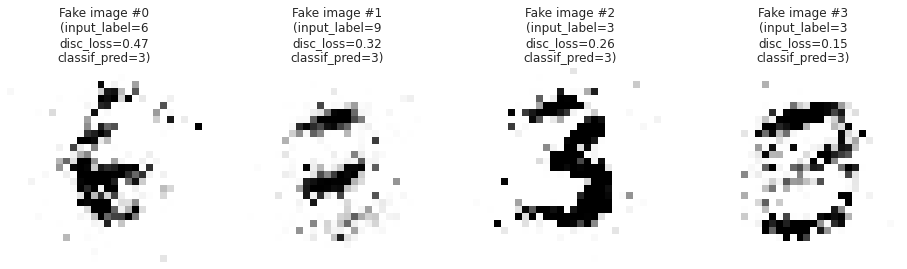


Epoch 00011: saving model to ./weights/cgan_pretrained=False_checkpoints.011.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.3008 - discriminator_loss: 0.5075 - classifier_loss: 0.0000e+00
Epoch 12/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.3742 - discriminator_loss: 0.4830 - classifier_loss: 0.0000e+00

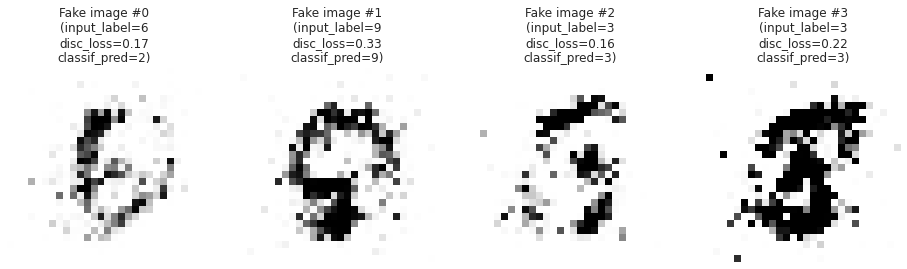


Epoch 00012: saving model to ./weights/cgan_pretrained=False_checkpoints.012.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.3747 - discriminator_loss: 0.4829 - classifier_loss: 0.0000e+00
Epoch 13/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.4207 - discriminator_loss: 0.4747 - classifier_loss: 0.0000e+00

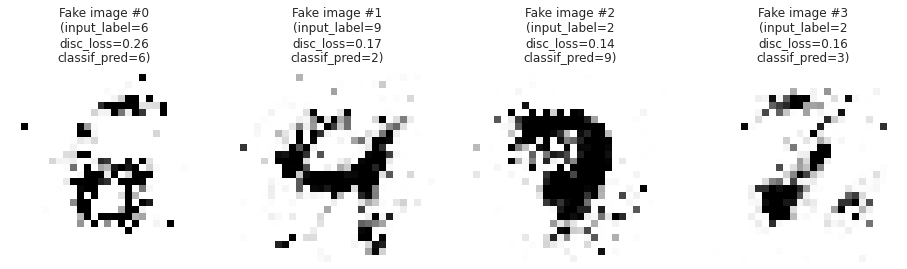


Epoch 00013: saving model to ./weights/cgan_pretrained=False_checkpoints.013.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.4224 - discriminator_loss: 0.4742 - classifier_loss: 0.0000e+00
Epoch 14/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.4261 - discriminator_loss: 0.4719 - classifier_loss: 0.0000e+00

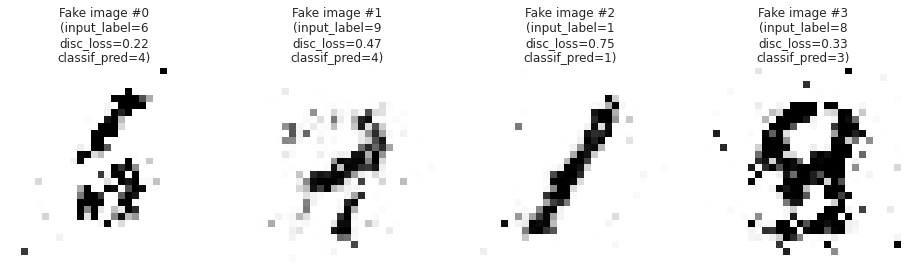


Epoch 00014: saving model to ./weights/cgan_pretrained=False_checkpoints.014.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.4263 - discriminator_loss: 0.4718 - classifier_loss: 0.0000e+00
Epoch 15/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.3595 - discriminator_loss: 0.4927 - classifier_loss: 0.0000e+00

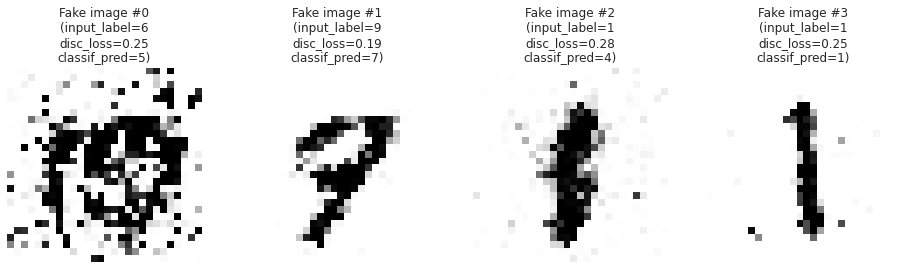


Epoch 00015: saving model to ./weights/cgan_pretrained=False_checkpoints.015.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.3597 - discriminator_loss: 0.4923 - classifier_loss: 0.0000e+00
Epoch 16/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.3314 - discriminator_loss: 0.4998 - classifier_loss: 0.0000e+00

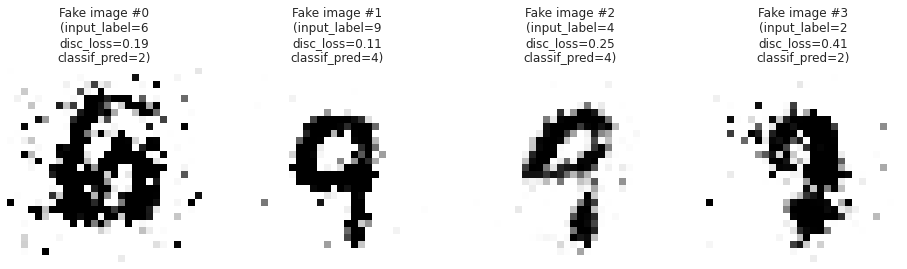


Epoch 00016: saving model to ./weights/cgan_pretrained=False_checkpoints.016.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.3310 - discriminator_loss: 0.4997 - classifier_loss: 0.0000e+00
Epoch 17/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.2906 - discriminator_loss: 0.5088 - classifier_loss: 0.0000e+00

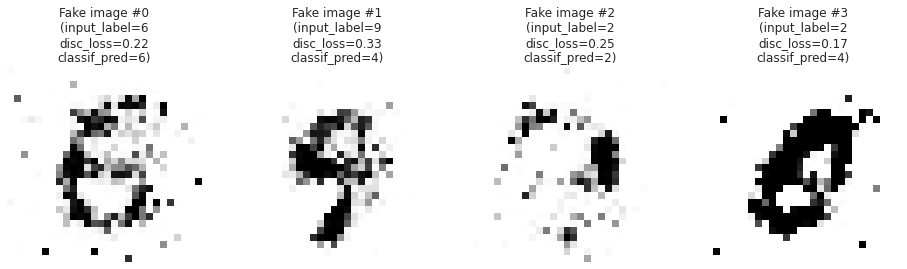


Epoch 00017: saving model to ./weights/cgan_pretrained=False_checkpoints.017.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.2914 - discriminator_loss: 0.5085 - classifier_loss: 0.0000e+00
Epoch 18/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.2518 - discriminator_loss: 0.5207 - classifier_loss: 0.0000e+00

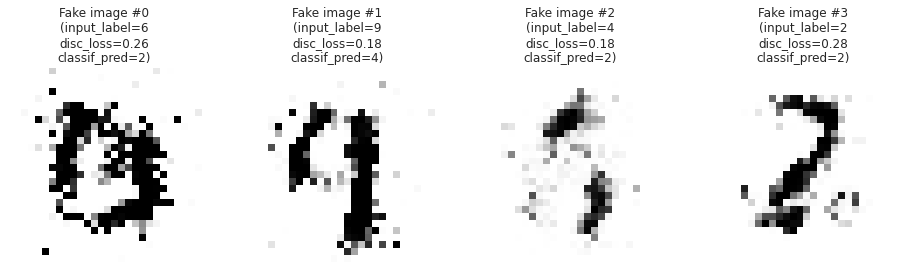


Epoch 00018: saving model to ./weights/cgan_pretrained=False_checkpoints.018.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.2528 - discriminator_loss: 0.5204 - classifier_loss: 0.0000e+00
Epoch 19/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1999 - discriminator_loss: 0.5342 - classifier_loss: 0.0000e+00

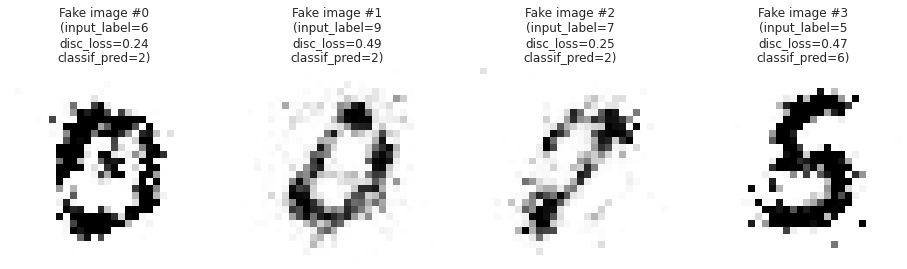


Epoch 00019: saving model to ./weights/cgan_pretrained=False_checkpoints.019.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1996 - discriminator_loss: 0.5340 - classifier_loss: 0.0000e+00
Epoch 20/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1517 - discriminator_loss: 0.5471 - classifier_loss: 0.0000e+00

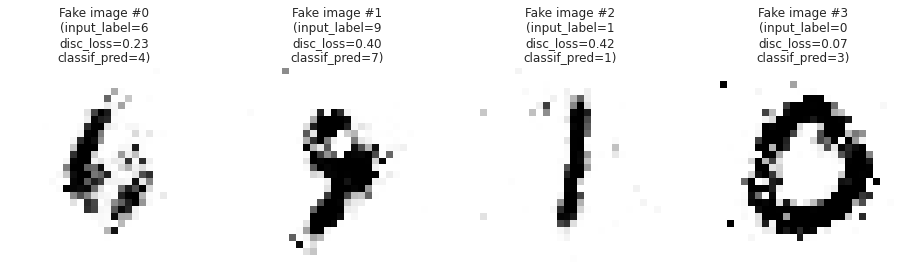


Epoch 00020: saving model to ./weights/cgan_pretrained=False_checkpoints.020.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1517 - discriminator_loss: 0.5476 - classifier_loss: 0.0000e+00
Epoch 21/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1320 - discriminator_loss: 0.5503 - classifier_loss: 0.0000e+00

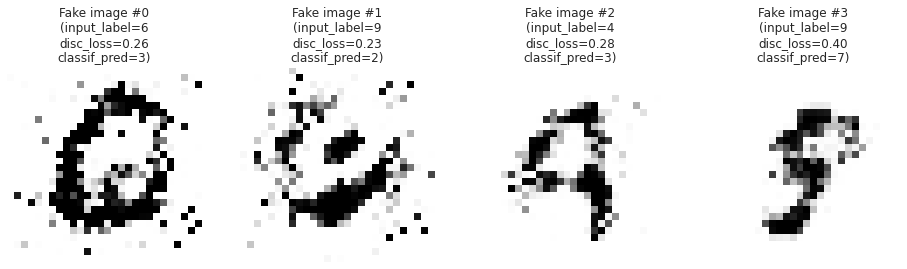


Epoch 00021: saving model to ./weights/cgan_pretrained=False_checkpoints.021.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1331 - discriminator_loss: 0.5497 - classifier_loss: 0.0000e+00
Epoch 22/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1362 - discriminator_loss: 0.5512 - classifier_loss: 0.0000e+00

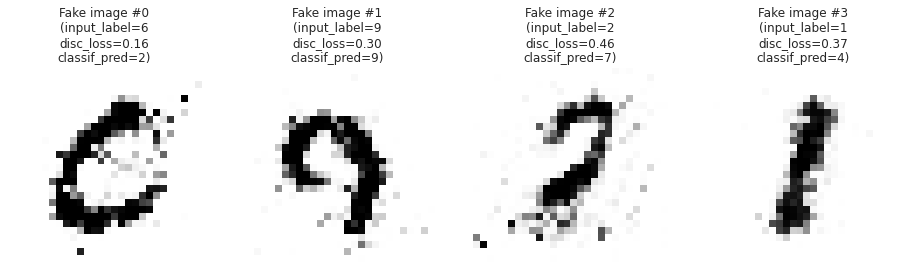


Epoch 00022: saving model to ./weights/cgan_pretrained=False_checkpoints.022.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1358 - discriminator_loss: 0.5510 - classifier_loss: 0.0000e+00
Epoch 23/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1149 - discriminator_loss: 0.5575 - classifier_loss: 0.0000e+00

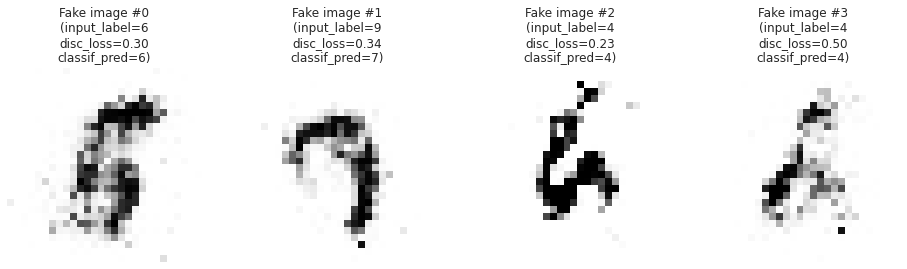


Epoch 00023: saving model to ./weights/cgan_pretrained=False_checkpoints.023.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1152 - discriminator_loss: 0.5578 - classifier_loss: 0.0000e+00
Epoch 24/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0520 - discriminator_loss: 0.5746 - classifier_loss: 0.0000e+00

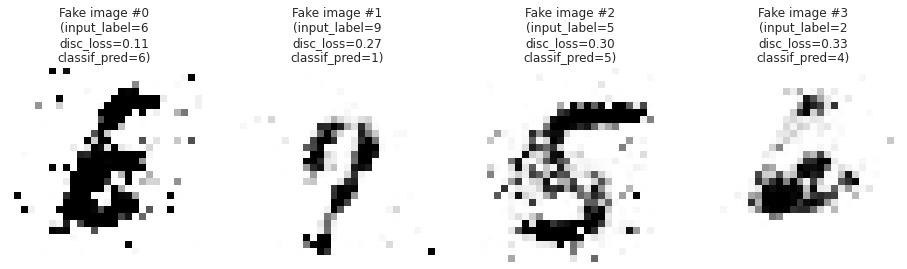


Epoch 00024: saving model to ./weights/cgan_pretrained=False_checkpoints.024.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0527 - discriminator_loss: 0.5747 - classifier_loss: 0.0000e+00
Epoch 25/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0620 - discriminator_loss: 0.5707 - classifier_loss: 0.0000e+00

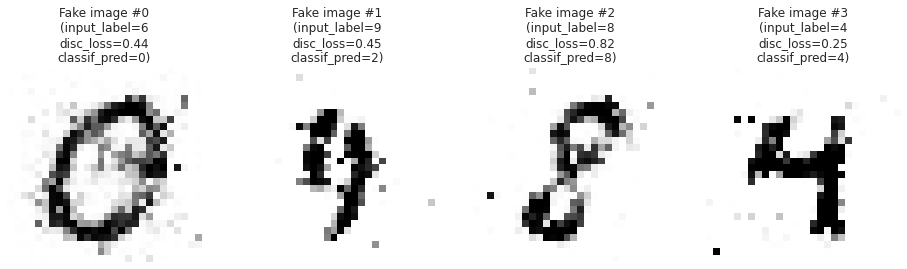


Epoch 00025: saving model to ./weights/cgan_pretrained=False_checkpoints.025.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0619 - discriminator_loss: 0.5705 - classifier_loss: 0.0000e+00
Epoch 26/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0554 - discriminator_loss: 0.5722 - classifier_loss: 0.0000e+00

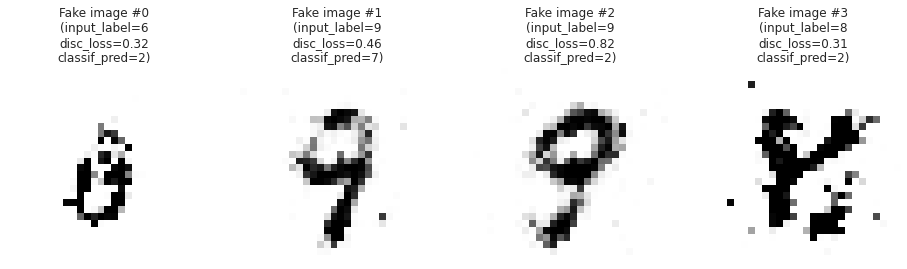


Epoch 00026: saving model to ./weights/cgan_pretrained=False_checkpoints.026.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0557 - discriminator_loss: 0.5720 - classifier_loss: 0.0000e+00
Epoch 27/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0772 - discriminator_loss: 0.5651 - classifier_loss: 0.0000e+00

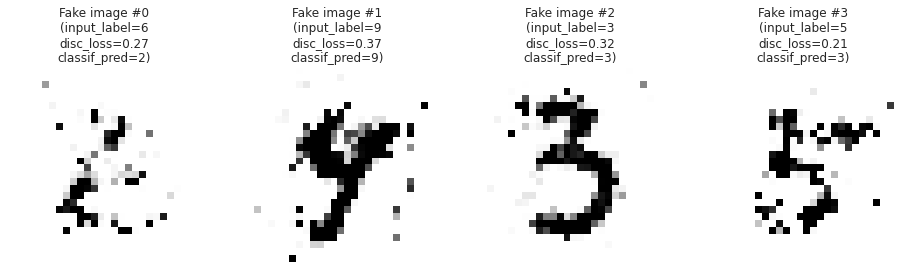


Epoch 00027: saving model to ./weights/cgan_pretrained=False_checkpoints.027.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0774 - discriminator_loss: 0.5653 - classifier_loss: 0.0000e+00
Epoch 28/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0157 - discriminator_loss: 0.5885 - classifier_loss: 0.0000e+00

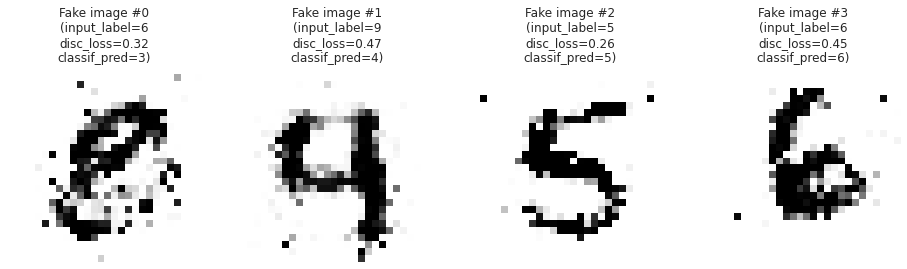


Epoch 00028: saving model to ./weights/cgan_pretrained=False_checkpoints.028.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0158 - discriminator_loss: 0.5883 - classifier_loss: 0.0000e+00
Epoch 29/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9884 - discriminator_loss: 0.5938 - classifier_loss: 0.0000e+00

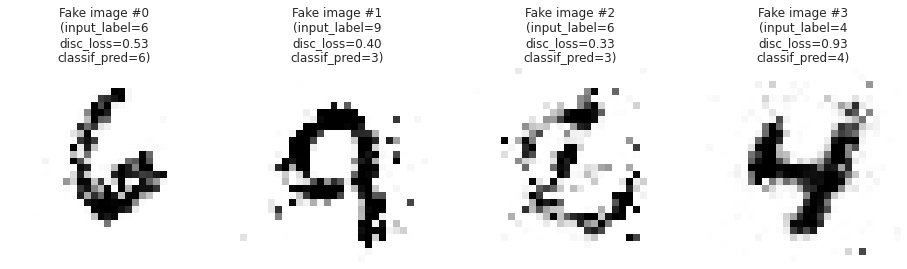


Epoch 00029: saving model to ./weights/cgan_pretrained=False_checkpoints.029.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9886 - discriminator_loss: 0.5938 - classifier_loss: 0.0000e+00
Epoch 30/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9796 - discriminator_loss: 0.5975 - classifier_loss: 0.0000e+00

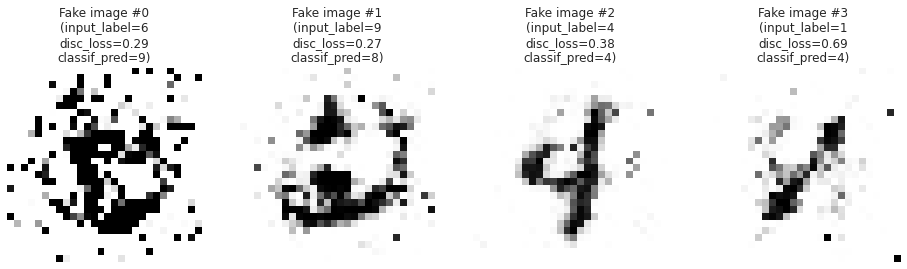


Epoch 00030: saving model to ./weights/cgan_pretrained=False_checkpoints.030.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9796 - discriminator_loss: 0.5974 - classifier_loss: 0.0000e+00
Epoch 31/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0070 - discriminator_loss: 0.5869 - classifier_loss: 0.0000e+00

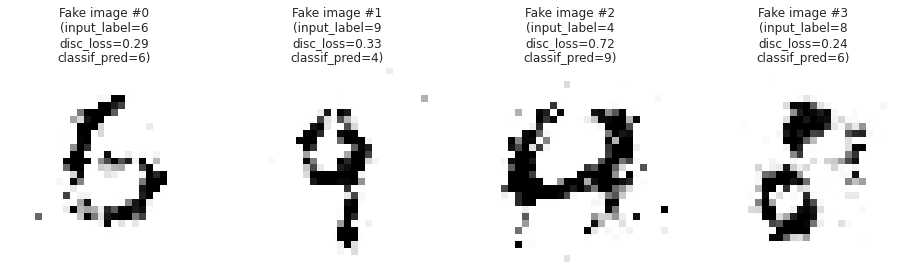


Epoch 00031: saving model to ./weights/cgan_pretrained=False_checkpoints.031.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0077 - discriminator_loss: 0.5868 - classifier_loss: 0.0000e+00
Epoch 32/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9798 - discriminator_loss: 0.5987 - classifier_loss: 0.0000e+00

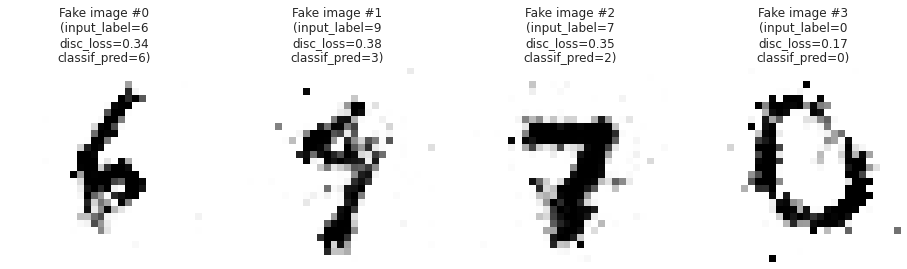


Epoch 00032: saving model to ./weights/cgan_pretrained=False_checkpoints.032.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9804 - discriminator_loss: 0.5985 - classifier_loss: 0.0000e+00
Epoch 33/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9520 - discriminator_loss: 0.6069 - classifier_loss: 0.0000e+00

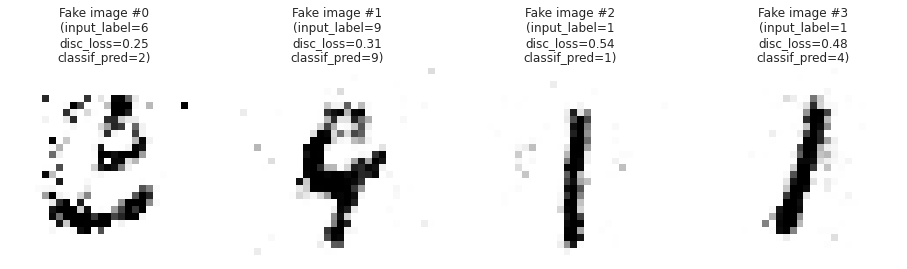


Epoch 00033: saving model to ./weights/cgan_pretrained=False_checkpoints.033.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9526 - discriminator_loss: 0.6070 - classifier_loss: 0.0000e+00
Epoch 34/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9651 - discriminator_loss: 0.6029 - classifier_loss: 0.0000e+00

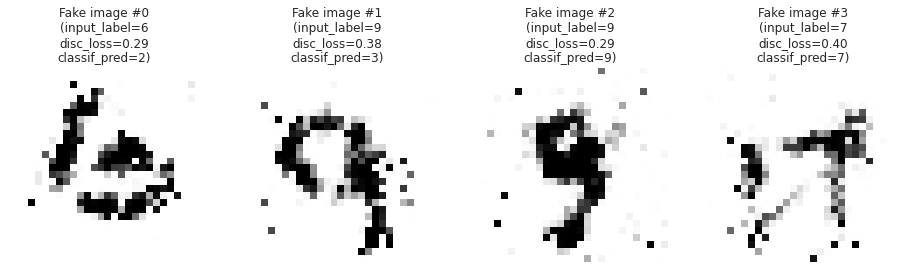


Epoch 00034: saving model to ./weights/cgan_pretrained=False_checkpoints.034.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9652 - discriminator_loss: 0.6028 - classifier_loss: 0.0000e+00
Epoch 35/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9564 - discriminator_loss: 0.6028 - classifier_loss: 0.0000e+00

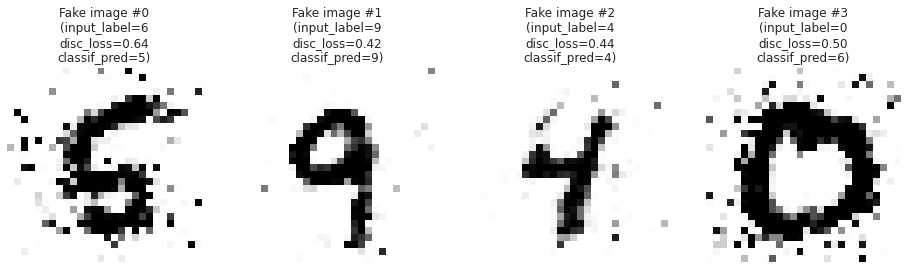


Epoch 00035: saving model to ./weights/cgan_pretrained=False_checkpoints.035.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9565 - discriminator_loss: 0.6028 - classifier_loss: 0.0000e+00
Epoch 36/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9700 - discriminator_loss: 0.5989 - classifier_loss: 0.0000e+00

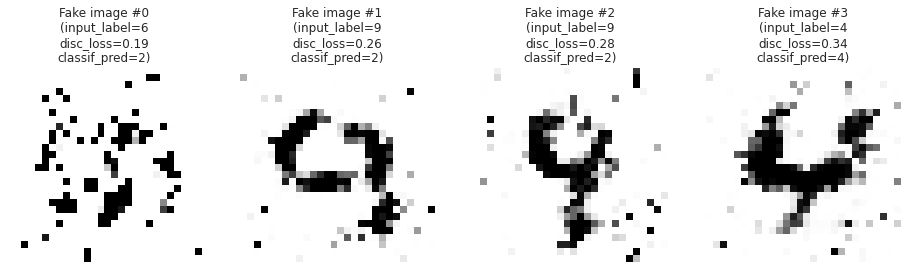


Epoch 00036: saving model to ./weights/cgan_pretrained=False_checkpoints.036.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9706 - discriminator_loss: 0.5986 - classifier_loss: 0.0000e+00
Epoch 37/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9518 - discriminator_loss: 0.6090 - classifier_loss: 0.0000e+00

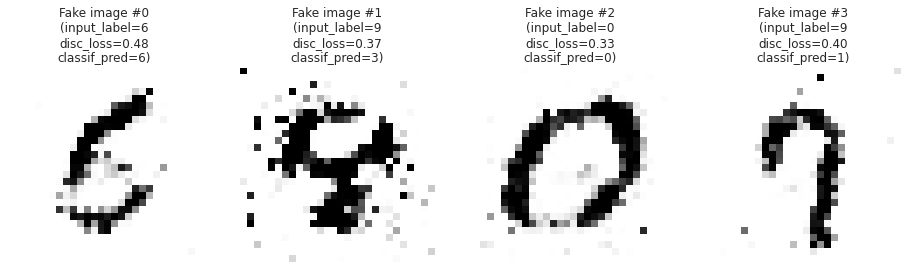


Epoch 00037: saving model to ./weights/cgan_pretrained=False_checkpoints.037.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9514 - discriminator_loss: 0.6090 - classifier_loss: 0.0000e+00
Epoch 38/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9326 - discriminator_loss: 0.6144 - classifier_loss: 0.0000e+00

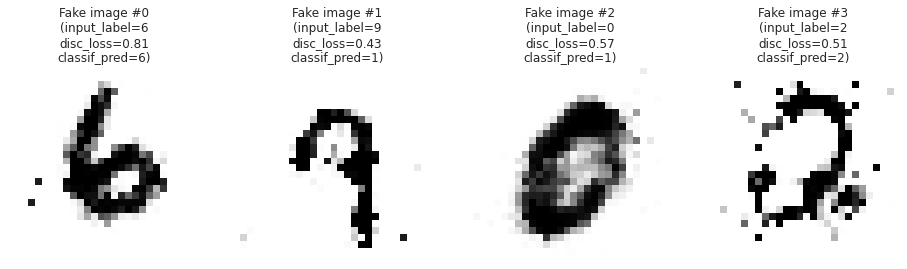


Epoch 00038: saving model to ./weights/cgan_pretrained=False_checkpoints.038.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9328 - discriminator_loss: 0.6143 - classifier_loss: 0.0000e+00
Epoch 39/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9431 - discriminator_loss: 0.6097 - classifier_loss: 0.0000e+00

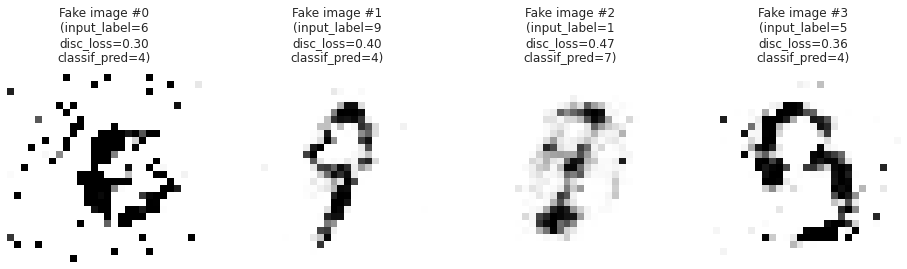


Epoch 00039: saving model to ./weights/cgan_pretrained=False_checkpoints.039.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9432 - discriminator_loss: 0.6099 - classifier_loss: 0.0000e+00
Epoch 40/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9723 - discriminator_loss: 0.6023 - classifier_loss: 0.0000e+00

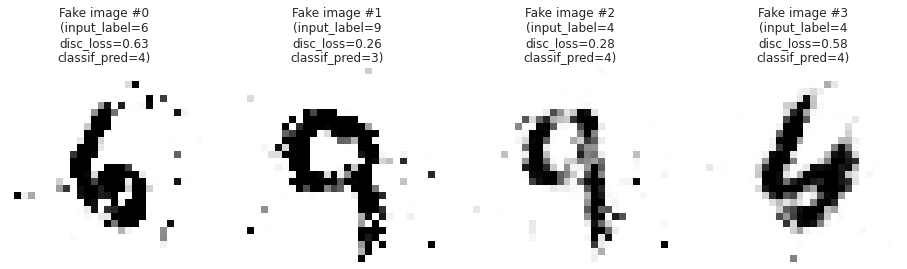


Epoch 00040: saving model to ./weights/cgan_pretrained=False_checkpoints.040.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9723 - discriminator_loss: 0.6022 - classifier_loss: 0.0000e+00
Epoch 41/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9476 - discriminator_loss: 0.6084 - classifier_loss: 0.0000e+00

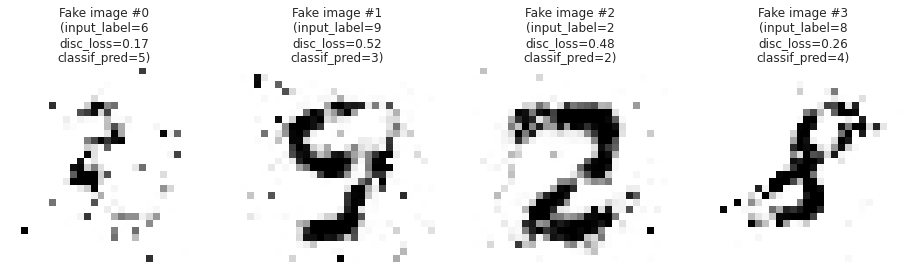


Epoch 00041: saving model to ./weights/cgan_pretrained=False_checkpoints.041.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9480 - discriminator_loss: 0.6078 - classifier_loss: 0.0000e+00
Epoch 42/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9601 - discriminator_loss: 0.6073 - classifier_loss: 0.0000e+00

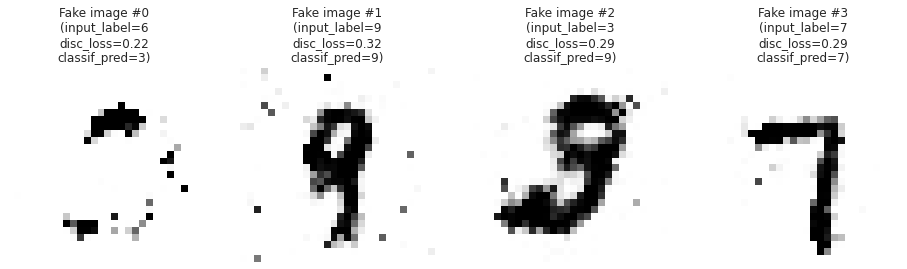


Epoch 00042: saving model to ./weights/cgan_pretrained=False_checkpoints.042.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9609 - discriminator_loss: 0.6073 - classifier_loss: 0.0000e+00
Epoch 43/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9633 - discriminator_loss: 0.6031 - classifier_loss: 0.0000e+00

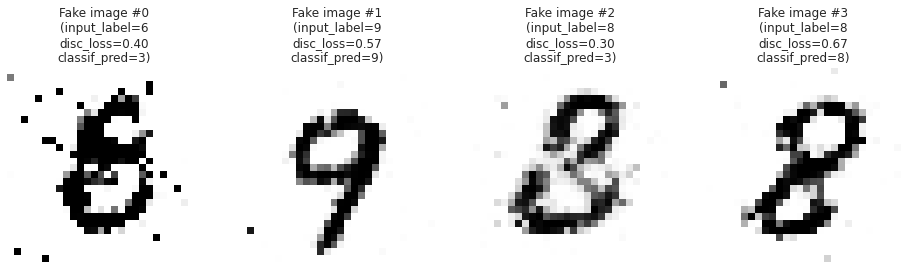


Epoch 00043: saving model to ./weights/cgan_pretrained=False_checkpoints.043.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9638 - discriminator_loss: 0.6031 - classifier_loss: 0.0000e+00
Epoch 44/200
468/468 [==============================] - ETA: 0s - generator_loss: 0.9498 - discriminator_loss: 0.6109 - classifier_loss: 0.0000e+00

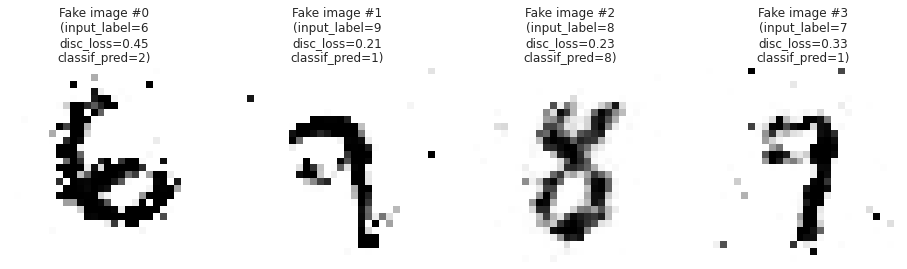


Epoch 00044: saving model to ./weights/cgan_pretrained=False_checkpoints.044.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9499 - discriminator_loss: 0.6110 - classifier_loss: 0.0000e+00
Epoch 45/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9489 - discriminator_loss: 0.6113 - classifier_loss: 0.0000e+00

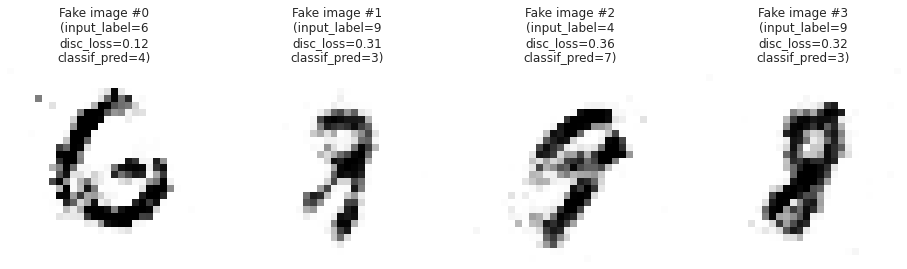


Epoch 00045: saving model to ./weights/cgan_pretrained=False_checkpoints.045.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9495 - discriminator_loss: 0.6113 - classifier_loss: 0.0000e+00
Epoch 46/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9473 - discriminator_loss: 0.6109 - classifier_loss: 0.0000e+00

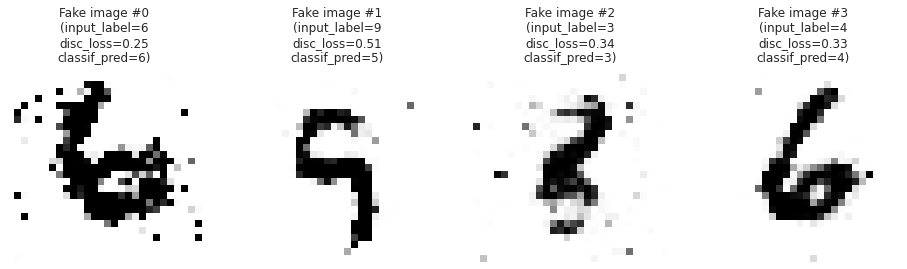


Epoch 00046: saving model to ./weights/cgan_pretrained=False_checkpoints.046.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9475 - discriminator_loss: 0.6109 - classifier_loss: 0.0000e+00
Epoch 47/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9295 - discriminator_loss: 0.6191 - classifier_loss: 0.0000e+00

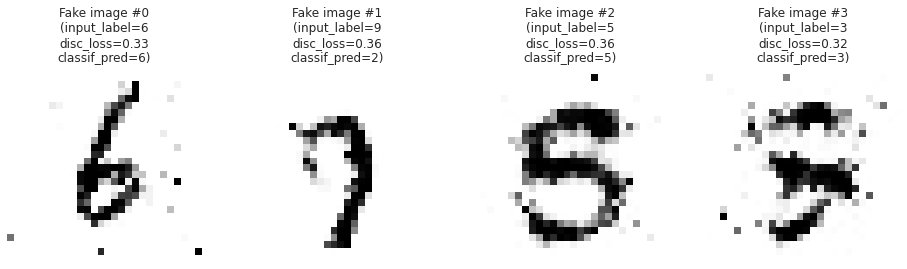


Epoch 00047: saving model to ./weights/cgan_pretrained=False_checkpoints.047.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9296 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00
Epoch 48/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9376 - discriminator_loss: 0.6158 - classifier_loss: 0.0000e+00

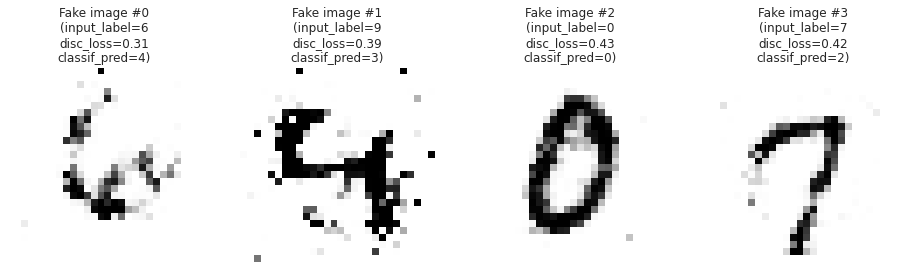


Epoch 00048: saving model to ./weights/cgan_pretrained=False_checkpoints.048.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9374 - discriminator_loss: 0.6157 - classifier_loss: 0.0000e+00
Epoch 49/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9456 - discriminator_loss: 0.6097 - classifier_loss: 0.0000e+00

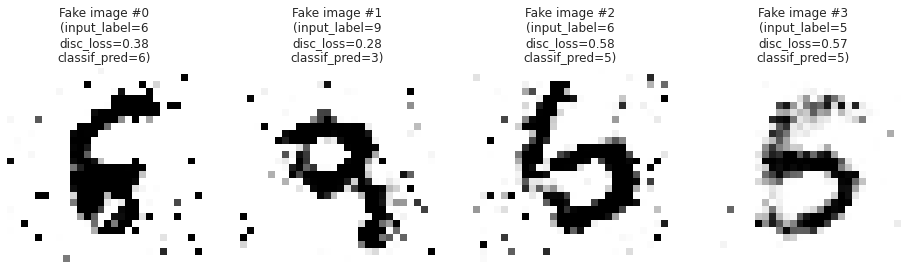


Epoch 00049: saving model to ./weights/cgan_pretrained=False_checkpoints.049.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9463 - discriminator_loss: 0.6094 - classifier_loss: 0.0000e+00
Epoch 50/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9432 - discriminator_loss: 0.6150 - classifier_loss: 0.0000e+00

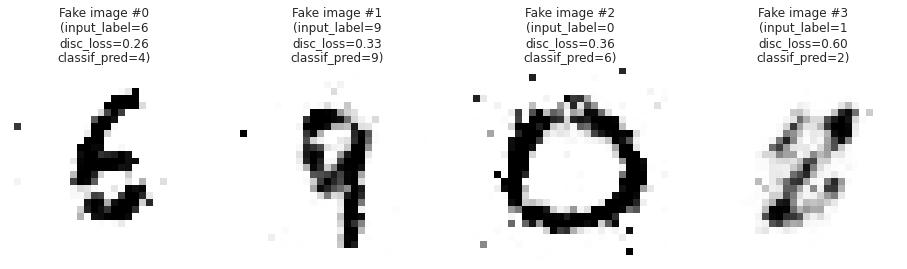


Epoch 00050: saving model to ./weights/cgan_pretrained=False_checkpoints.050.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9436 - discriminator_loss: 0.6151 - classifier_loss: 0.0000e+00
Epoch 51/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9321 - discriminator_loss: 0.6167 - classifier_loss: 0.0000e+00

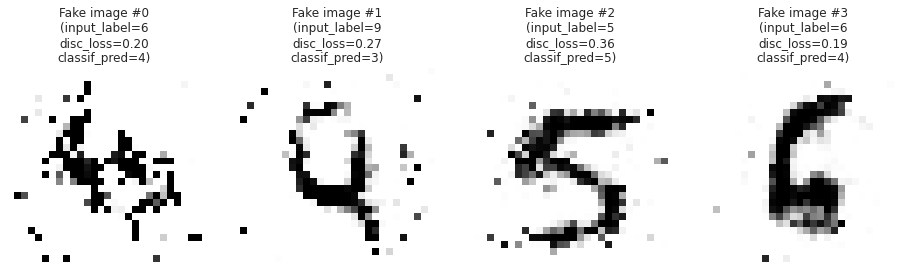


Epoch 00051: saving model to ./weights/cgan_pretrained=False_checkpoints.051.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9325 - discriminator_loss: 0.6166 - classifier_loss: 0.0000e+00
Epoch 52/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9332 - discriminator_loss: 0.6189 - classifier_loss: 0.0000e+00

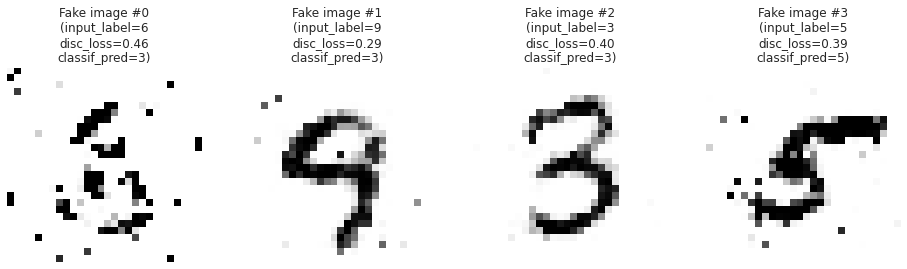


Epoch 00052: saving model to ./weights/cgan_pretrained=False_checkpoints.052.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9331 - discriminator_loss: 0.6189 - classifier_loss: 0.0000e+00
Epoch 53/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9403 - discriminator_loss: 0.6162 - classifier_loss: 0.0000e+00

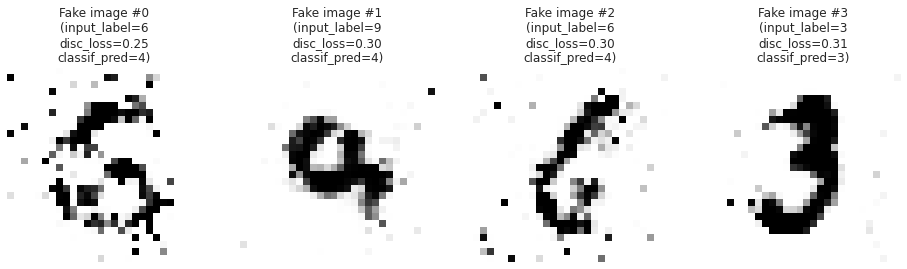


Epoch 00053: saving model to ./weights/cgan_pretrained=False_checkpoints.053.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9403 - discriminator_loss: 0.6162 - classifier_loss: 0.0000e+00
Epoch 54/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.8981 - discriminator_loss: 0.6304 - classifier_loss: 0.0000e+00

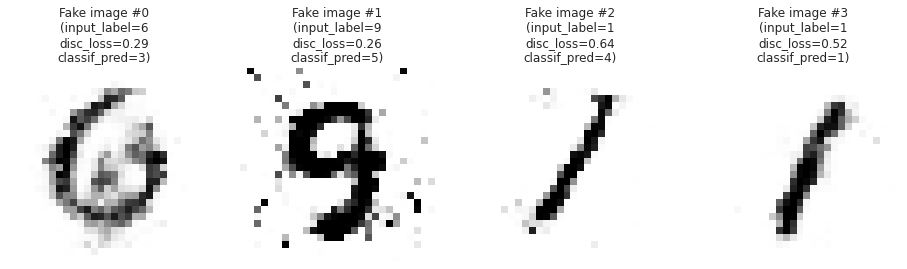


Epoch 00054: saving model to ./weights/cgan_pretrained=False_checkpoints.054.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.8982 - discriminator_loss: 0.6305 - classifier_loss: 0.0000e+00
Epoch 55/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9080 - discriminator_loss: 0.6258 - classifier_loss: 0.0000e+00

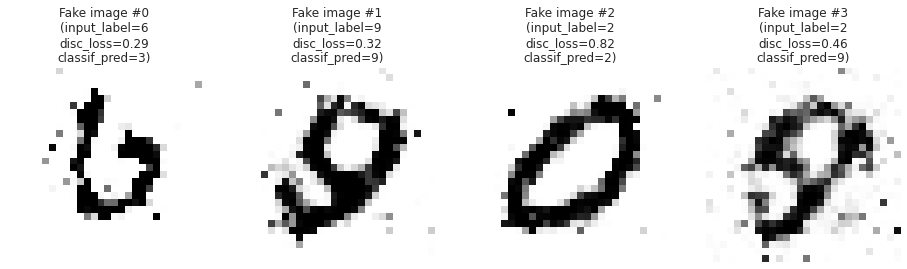


Epoch 00055: saving model to ./weights/cgan_pretrained=False_checkpoints.055.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9086 - discriminator_loss: 0.6260 - classifier_loss: 0.0000e+00
Epoch 56/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9105 - discriminator_loss: 0.6278 - classifier_loss: 0.0000e+00

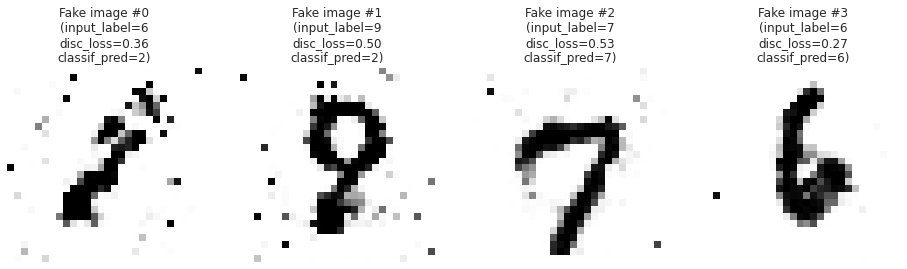


Epoch 00056: saving model to ./weights/cgan_pretrained=False_checkpoints.056.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9103 - discriminator_loss: 0.6278 - classifier_loss: 0.0000e+00
Epoch 57/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9311 - discriminator_loss: 0.6192 - classifier_loss: 0.0000e+00

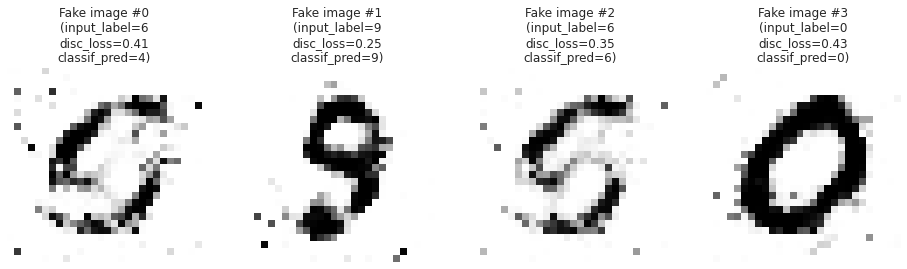


Epoch 00057: saving model to ./weights/cgan_pretrained=False_checkpoints.057.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9312 - discriminator_loss: 0.6191 - classifier_loss: 0.0000e+00
Epoch 58/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9170 - discriminator_loss: 0.6267 - classifier_loss: 0.0000e+00

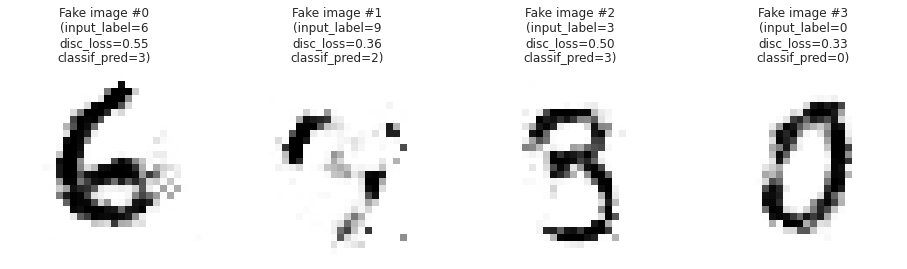


Epoch 00058: saving model to ./weights/cgan_pretrained=False_checkpoints.058.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9174 - discriminator_loss: 0.6265 - classifier_loss: 0.0000e+00
Epoch 59/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9258 - discriminator_loss: 0.6237 - classifier_loss: 0.0000e+00

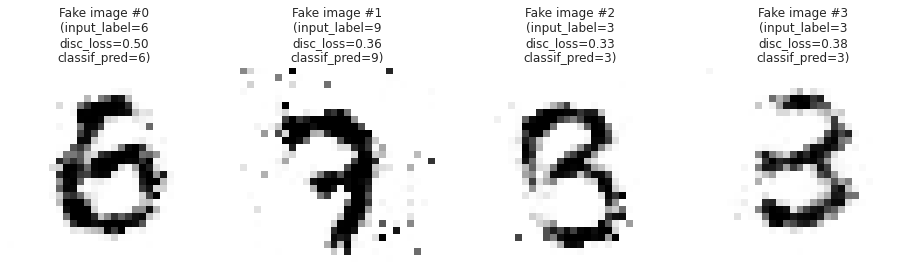


Epoch 00059: saving model to ./weights/cgan_pretrained=False_checkpoints.059.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9260 - discriminator_loss: 0.6236 - classifier_loss: 0.0000e+00
Epoch 60/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9419 - discriminator_loss: 0.6184 - classifier_loss: 0.0000e+00

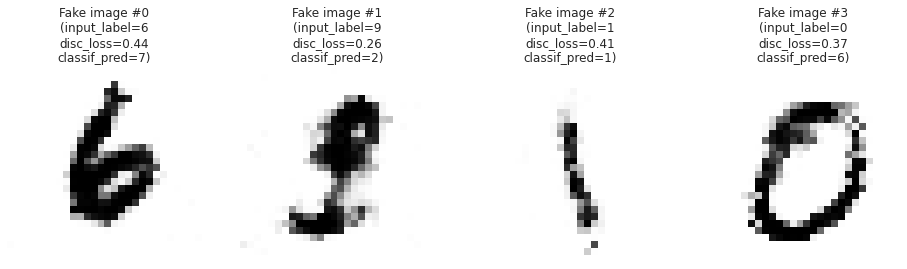


Epoch 00060: saving model to ./weights/cgan_pretrained=False_checkpoints.060.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9420 - discriminator_loss: 0.6184 - classifier_loss: 0.0000e+00
Epoch 61/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9229 - discriminator_loss: 0.6241 - classifier_loss: 0.0000e+00

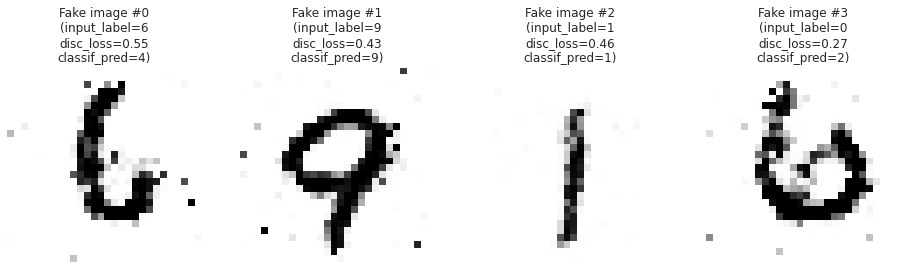


Epoch 00061: saving model to ./weights/cgan_pretrained=False_checkpoints.061.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9230 - discriminator_loss: 0.6238 - classifier_loss: 0.0000e+00
Epoch 62/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9124 - discriminator_loss: 0.6281 - classifier_loss: 0.0000e+00

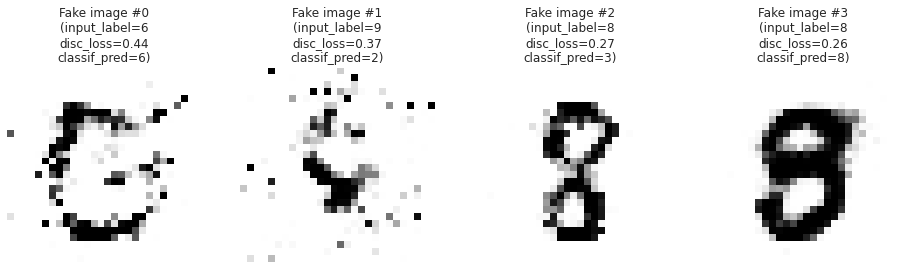


Epoch 00062: saving model to ./weights/cgan_pretrained=False_checkpoints.062.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9125 - discriminator_loss: 0.6279 - classifier_loss: 0.0000e+00
Epoch 63/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9303 - discriminator_loss: 0.6211 - classifier_loss: 0.0000e+00

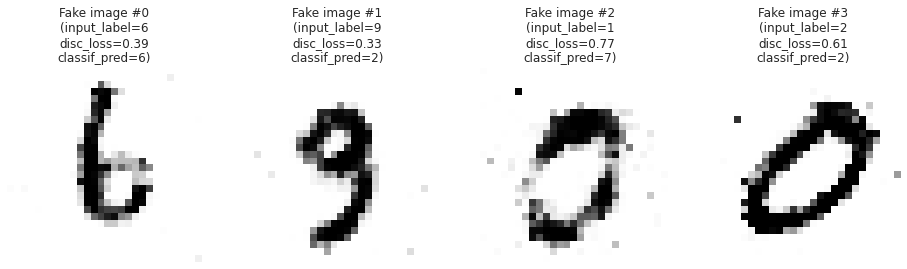


Epoch 00063: saving model to ./weights/cgan_pretrained=False_checkpoints.063.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9304 - discriminator_loss: 0.6210 - classifier_loss: 0.0000e+00
Epoch 64/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9172 - discriminator_loss: 0.6254 - classifier_loss: 0.0000e+00

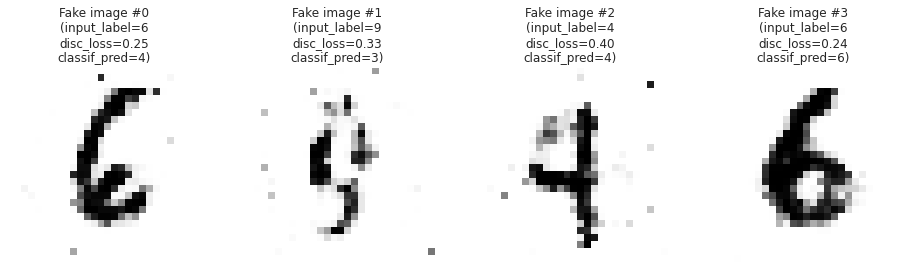


Epoch 00064: saving model to ./weights/cgan_pretrained=False_checkpoints.064.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9173 - discriminator_loss: 0.6253 - classifier_loss: 0.0000e+00
Epoch 65/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9222 - discriminator_loss: 0.6273 - classifier_loss: 0.0000e+00

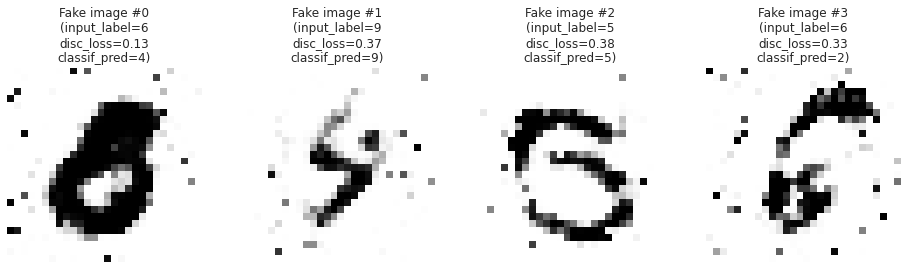


Epoch 00065: saving model to ./weights/cgan_pretrained=False_checkpoints.065.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9228 - discriminator_loss: 0.6271 - classifier_loss: 0.0000e+00
Epoch 66/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9373 - discriminator_loss: 0.6218 - classifier_loss: 0.0000e+00

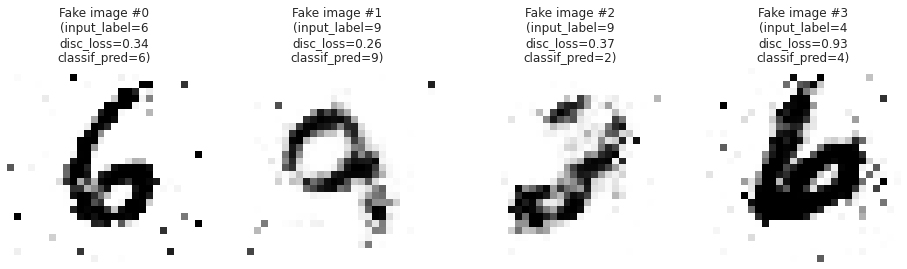


Epoch 00066: saving model to ./weights/cgan_pretrained=False_checkpoints.066.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9377 - discriminator_loss: 0.6215 - classifier_loss: 0.0000e+00
Epoch 67/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9500 - discriminator_loss: 0.6168 - classifier_loss: 0.0000e+00

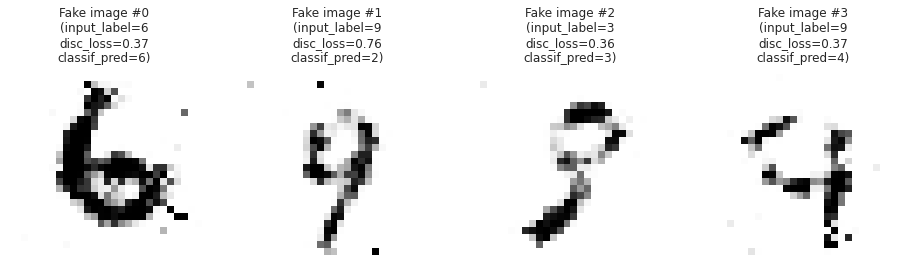


Epoch 00067: saving model to ./weights/cgan_pretrained=False_checkpoints.067.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9506 - discriminator_loss: 0.6169 - classifier_loss: 0.0000e+00
Epoch 68/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9469 - discriminator_loss: 0.6207 - classifier_loss: 0.0000e+00

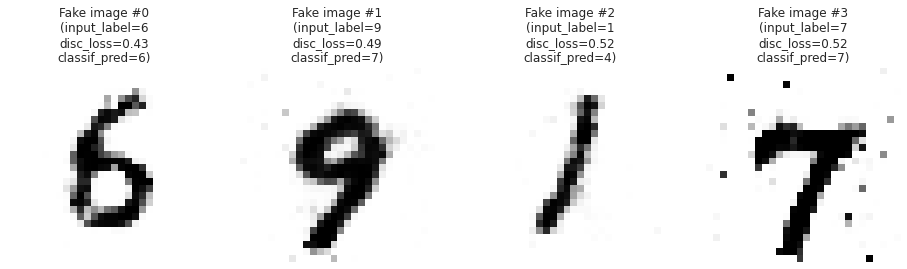


Epoch 00068: saving model to ./weights/cgan_pretrained=False_checkpoints.068.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9466 - discriminator_loss: 0.6207 - classifier_loss: 0.0000e+00
Epoch 69/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9320 - discriminator_loss: 0.6232 - classifier_loss: 0.0000e+00

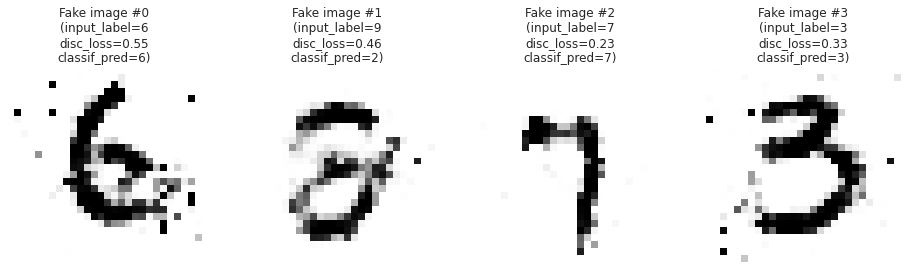


Epoch 00069: saving model to ./weights/cgan_pretrained=False_checkpoints.069.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9327 - discriminator_loss: 0.6231 - classifier_loss: 0.0000e+00
Epoch 70/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9474 - discriminator_loss: 0.6212 - classifier_loss: 0.0000e+00

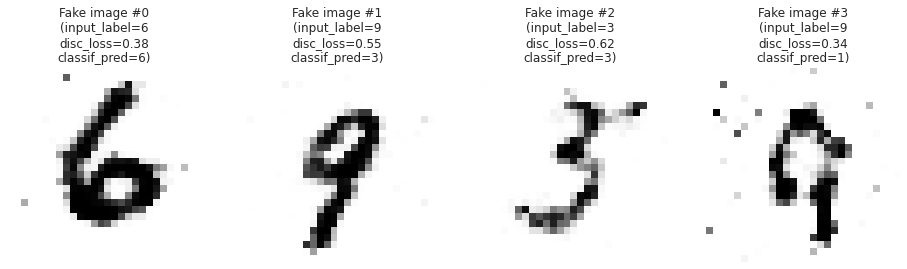


Epoch 00070: saving model to ./weights/cgan_pretrained=False_checkpoints.070.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9475 - discriminator_loss: 0.6213 - classifier_loss: 0.0000e+00
Epoch 71/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9341 - discriminator_loss: 0.6266 - classifier_loss: 0.0000e+00

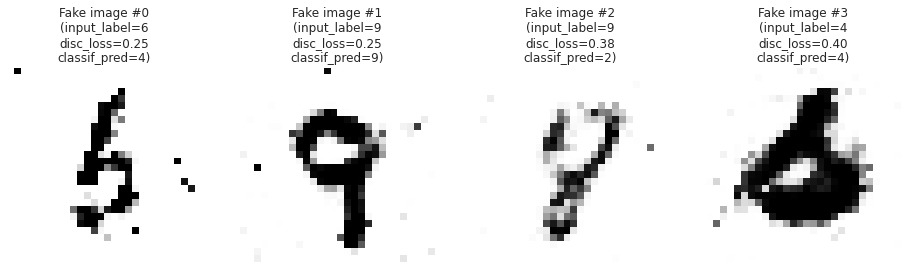


Epoch 00071: saving model to ./weights/cgan_pretrained=False_checkpoints.071.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9342 - discriminator_loss: 0.6264 - classifier_loss: 0.0000e+00
Epoch 72/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9345 - discriminator_loss: 0.6246 - classifier_loss: 0.0000e+00

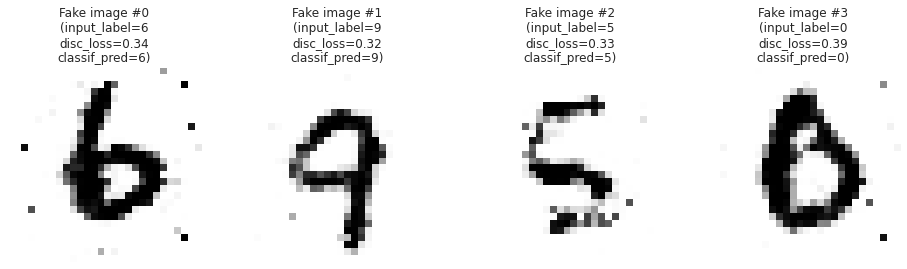


Epoch 00072: saving model to ./weights/cgan_pretrained=False_checkpoints.072.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9349 - discriminator_loss: 0.6246 - classifier_loss: 0.0000e+00
Epoch 73/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9347 - discriminator_loss: 0.6249 - classifier_loss: 0.0000e+00

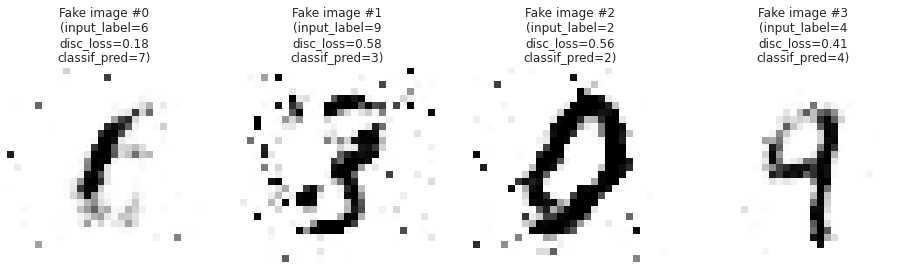


Epoch 00073: saving model to ./weights/cgan_pretrained=False_checkpoints.073.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9349 - discriminator_loss: 0.6248 - classifier_loss: 0.0000e+00
Epoch 74/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9343 - discriminator_loss: 0.6259 - classifier_loss: 0.0000e+00

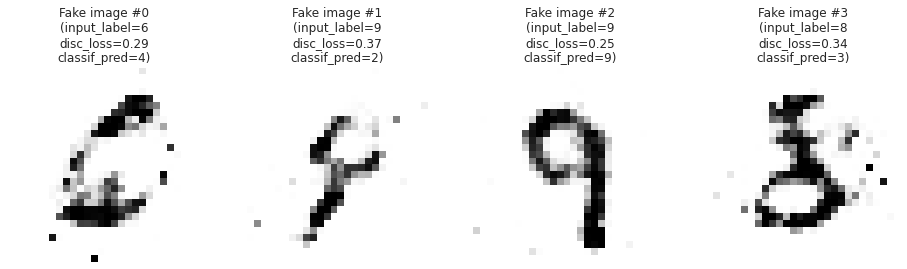


Epoch 00074: saving model to ./weights/cgan_pretrained=False_checkpoints.074.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9348 - discriminator_loss: 0.6258 - classifier_loss: 0.0000e+00
Epoch 75/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9294 - discriminator_loss: 0.6276 - classifier_loss: 0.0000e+00

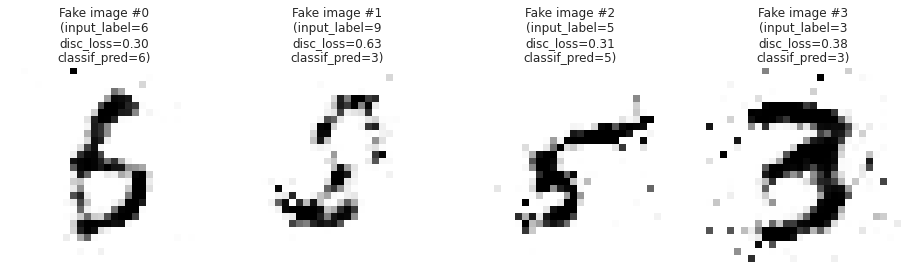


Epoch 00075: saving model to ./weights/cgan_pretrained=False_checkpoints.075.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9297 - discriminator_loss: 0.6274 - classifier_loss: 0.0000e+00
Epoch 76/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9504 - discriminator_loss: 0.6235 - classifier_loss: 0.0000e+00

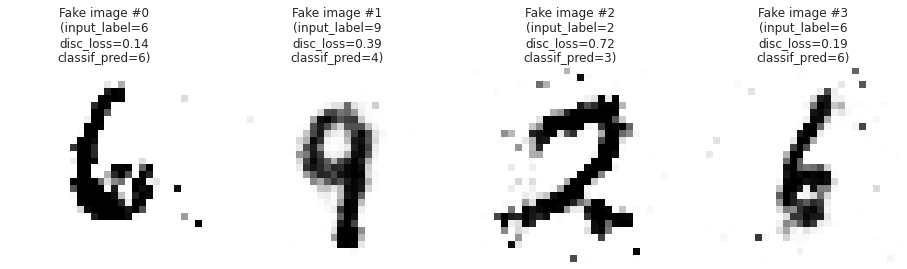


Epoch 00076: saving model to ./weights/cgan_pretrained=False_checkpoints.076.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9508 - discriminator_loss: 0.6234 - classifier_loss: 0.0000e+00
Epoch 77/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9620 - discriminator_loss: 0.6173 - classifier_loss: 0.0000e+00

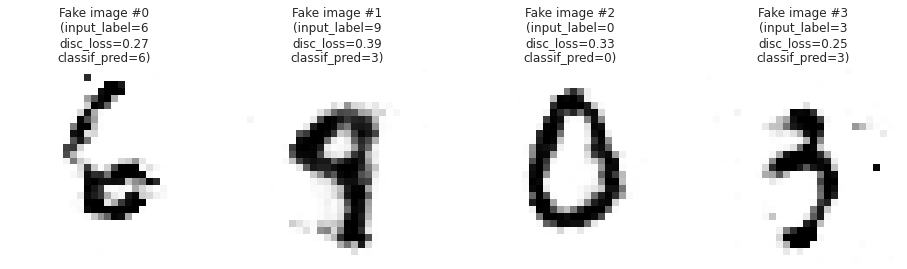


Epoch 00077: saving model to ./weights/cgan_pretrained=False_checkpoints.077.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9622 - discriminator_loss: 0.6172 - classifier_loss: 0.0000e+00
Epoch 78/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9536 - discriminator_loss: 0.6222 - classifier_loss: 0.0000e+00

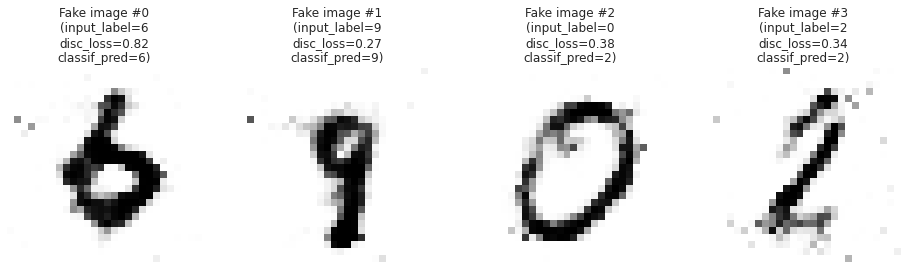


Epoch 00078: saving model to ./weights/cgan_pretrained=False_checkpoints.078.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9536 - discriminator_loss: 0.6224 - classifier_loss: 0.0000e+00
Epoch 79/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9487 - discriminator_loss: 0.6220 - classifier_loss: 0.0000e+00

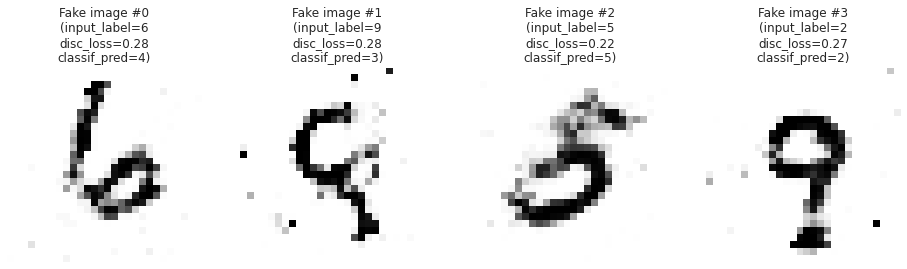


Epoch 00079: saving model to ./weights/cgan_pretrained=False_checkpoints.079.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9494 - discriminator_loss: 0.6218 - classifier_loss: 0.0000e+00
Epoch 80/200
468/468 [==============================] - ETA: 0s - generator_loss: 0.9381 - discriminator_loss: 0.6263 - classifier_loss: 0.0000e+00

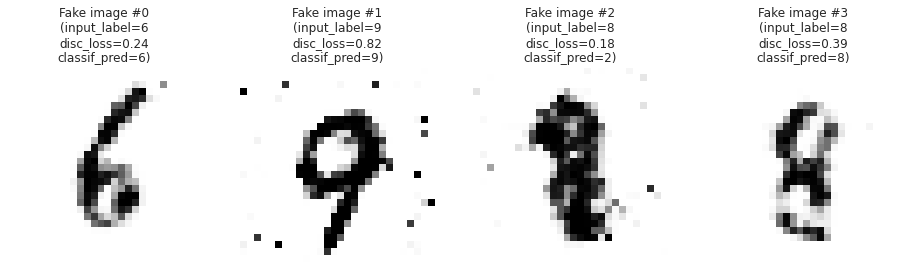


Epoch 00080: saving model to ./weights/cgan_pretrained=False_checkpoints.080.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9382 - discriminator_loss: 0.6263 - classifier_loss: 0.0000e+00
Epoch 81/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9459 - discriminator_loss: 0.6260 - classifier_loss: 0.0000e+00

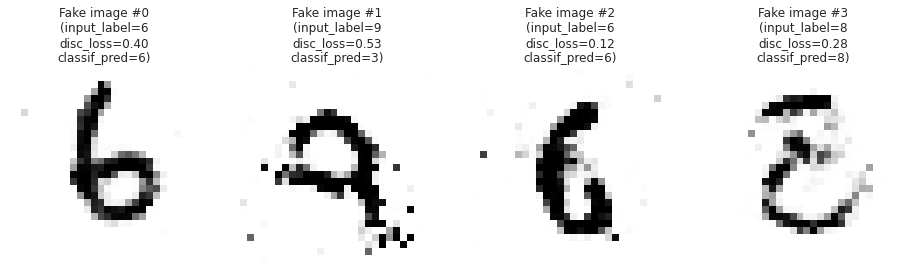


Epoch 00081: saving model to ./weights/cgan_pretrained=False_checkpoints.081.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9456 - discriminator_loss: 0.6262 - classifier_loss: 0.0000e+00
Epoch 82/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9445 - discriminator_loss: 0.6232 - classifier_loss: 0.0000e+00

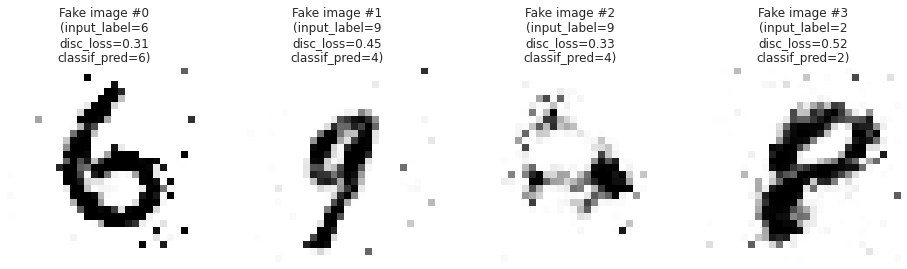


Epoch 00082: saving model to ./weights/cgan_pretrained=False_checkpoints.082.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9452 - discriminator_loss: 0.6234 - classifier_loss: 0.0000e+00
Epoch 83/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9591 - discriminator_loss: 0.6208 - classifier_loss: 0.0000e+00

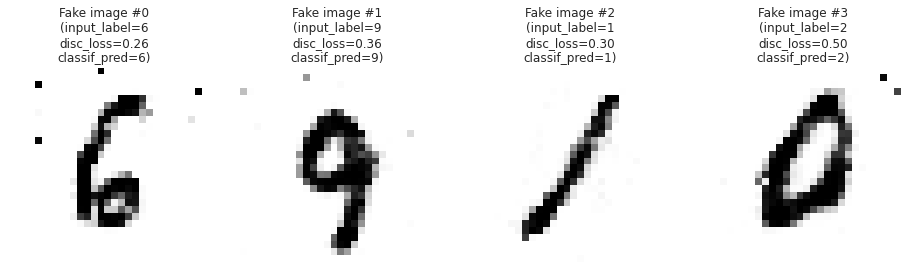


Epoch 00083: saving model to ./weights/cgan_pretrained=False_checkpoints.083.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9597 - discriminator_loss: 0.6210 - classifier_loss: 0.0000e+00
Epoch 84/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9641 - discriminator_loss: 0.6191 - classifier_loss: 0.0000e+00

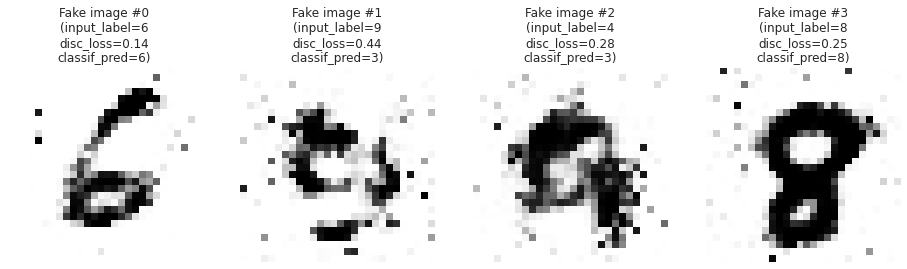


Epoch 00084: saving model to ./weights/cgan_pretrained=False_checkpoints.084.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9643 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00
Epoch 85/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9628 - discriminator_loss: 0.6220 - classifier_loss: 0.0000e+00

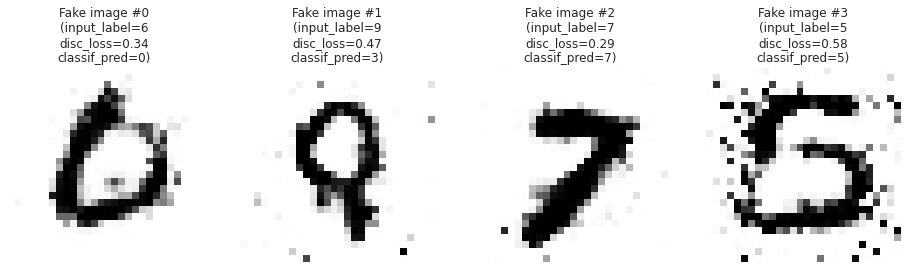


Epoch 00085: saving model to ./weights/cgan_pretrained=False_checkpoints.085.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9628 - discriminator_loss: 0.6221 - classifier_loss: 0.0000e+00
Epoch 86/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9566 - discriminator_loss: 0.6215 - classifier_loss: 0.0000e+00

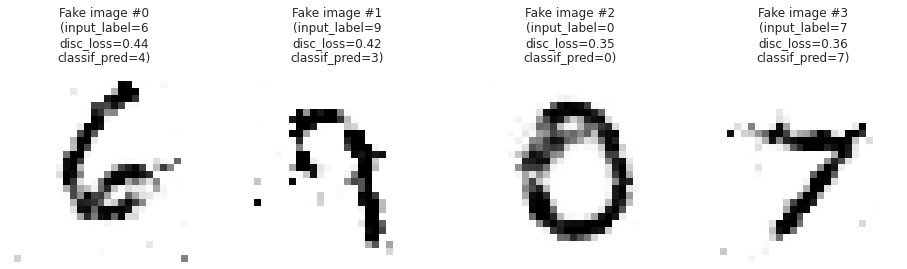


Epoch 00086: saving model to ./weights/cgan_pretrained=False_checkpoints.086.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9569 - discriminator_loss: 0.6212 - classifier_loss: 0.0000e+00
Epoch 87/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9409 - discriminator_loss: 0.6250 - classifier_loss: 0.0000e+00

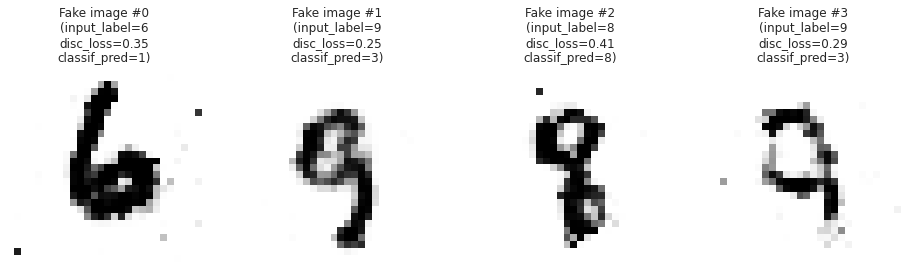


Epoch 00087: saving model to ./weights/cgan_pretrained=False_checkpoints.087.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9409 - discriminator_loss: 0.6250 - classifier_loss: 0.0000e+00
Epoch 88/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9619 - discriminator_loss: 0.6216 - classifier_loss: 0.0000e+00

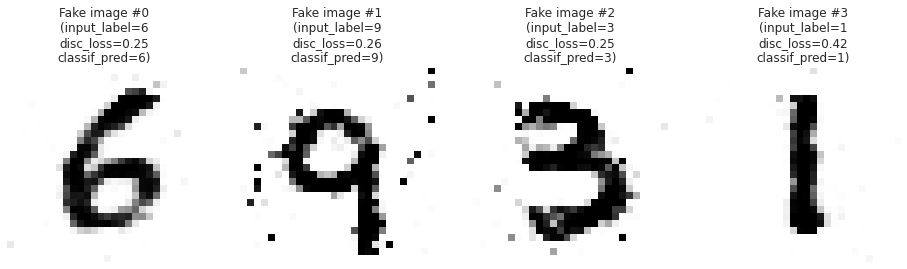


Epoch 00088: saving model to ./weights/cgan_pretrained=False_checkpoints.088.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9621 - discriminator_loss: 0.6216 - classifier_loss: 0.0000e+00
Epoch 89/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9597 - discriminator_loss: 0.6225 - classifier_loss: 0.0000e+00

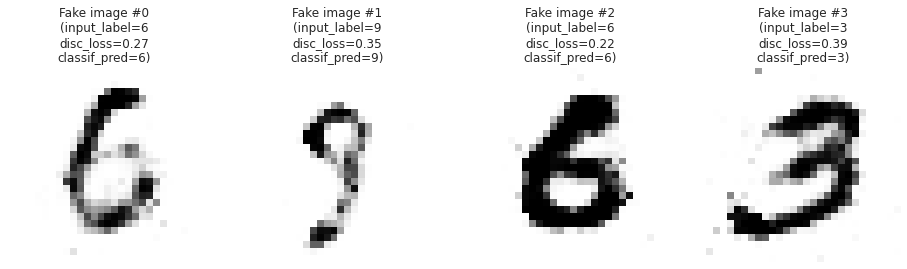


Epoch 00089: saving model to ./weights/cgan_pretrained=False_checkpoints.089.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9601 - discriminator_loss: 0.6228 - classifier_loss: 0.0000e+00
Epoch 90/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9640 - discriminator_loss: 0.6212 - classifier_loss: 0.0000e+00

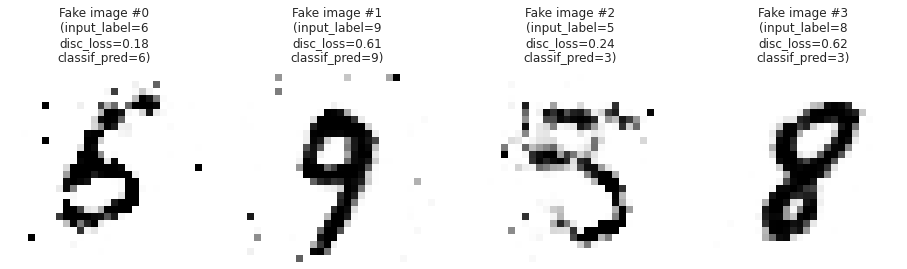


Epoch 00090: saving model to ./weights/cgan_pretrained=False_checkpoints.090.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9651 - discriminator_loss: 0.6210 - classifier_loss: 0.0000e+00
Epoch 91/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9425 - discriminator_loss: 0.6271 - classifier_loss: 0.0000e+00

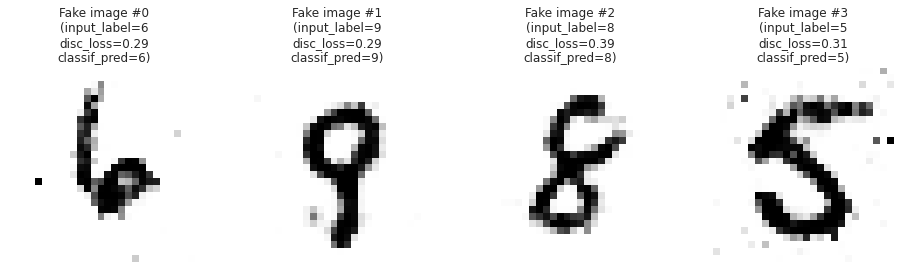


Epoch 00091: saving model to ./weights/cgan_pretrained=False_checkpoints.091.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9431 - discriminator_loss: 0.6271 - classifier_loss: 0.0000e+00
Epoch 92/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9441 - discriminator_loss: 0.6279 - classifier_loss: 0.0000e+00

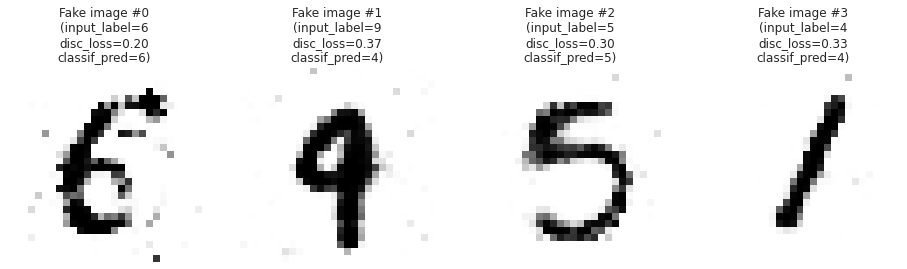


Epoch 00092: saving model to ./weights/cgan_pretrained=False_checkpoints.092.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9451 - discriminator_loss: 0.6277 - classifier_loss: 0.0000e+00
Epoch 93/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9546 - discriminator_loss: 0.6255 - classifier_loss: 0.0000e+00

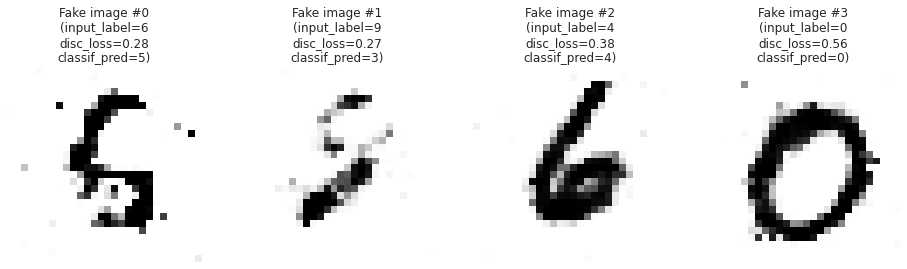


Epoch 00093: saving model to ./weights/cgan_pretrained=False_checkpoints.093.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9548 - discriminator_loss: 0.6255 - classifier_loss: 0.0000e+00
Epoch 94/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9560 - discriminator_loss: 0.6227 - classifier_loss: 0.0000e+00

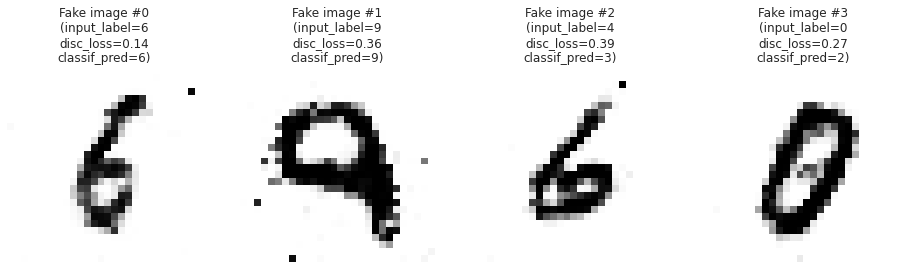


Epoch 00094: saving model to ./weights/cgan_pretrained=False_checkpoints.094.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9562 - discriminator_loss: 0.6227 - classifier_loss: 0.0000e+00
Epoch 95/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9623 - discriminator_loss: 0.6233 - classifier_loss: 0.0000e+00

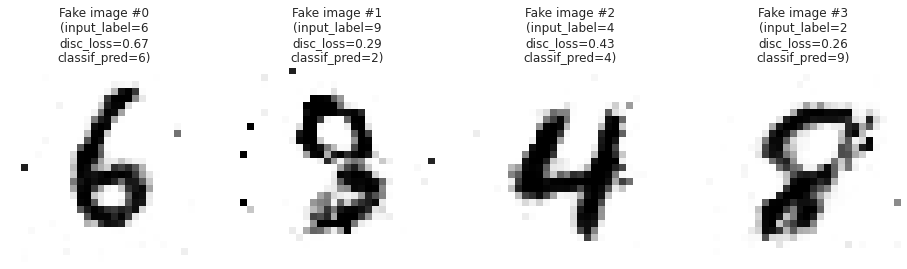


Epoch 00095: saving model to ./weights/cgan_pretrained=False_checkpoints.095.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9633 - discriminator_loss: 0.6230 - classifier_loss: 0.0000e+00
Epoch 96/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9654 - discriminator_loss: 0.6253 - classifier_loss: 0.0000e+00

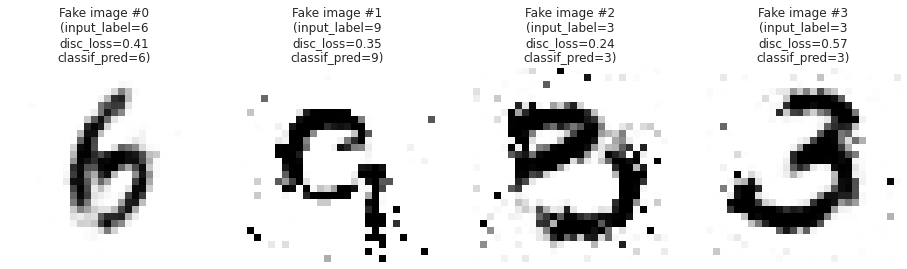


Epoch 00096: saving model to ./weights/cgan_pretrained=False_checkpoints.096.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9655 - discriminator_loss: 0.6252 - classifier_loss: 0.0000e+00
Epoch 97/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9664 - discriminator_loss: 0.6227 - classifier_loss: 0.0000e+00

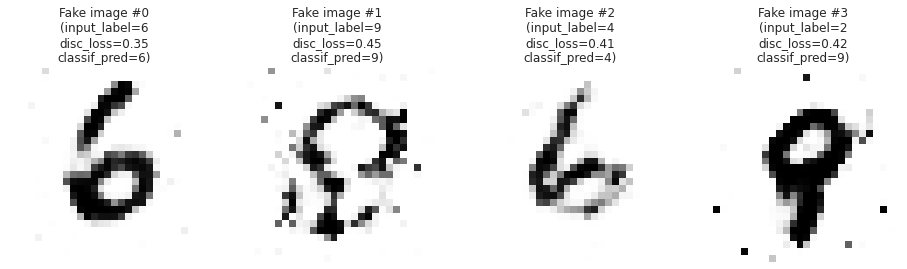


Epoch 00097: saving model to ./weights/cgan_pretrained=False_checkpoints.097.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9663 - discriminator_loss: 0.6226 - classifier_loss: 0.0000e+00
Epoch 98/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9538 - discriminator_loss: 0.6269 - classifier_loss: 0.0000e+00

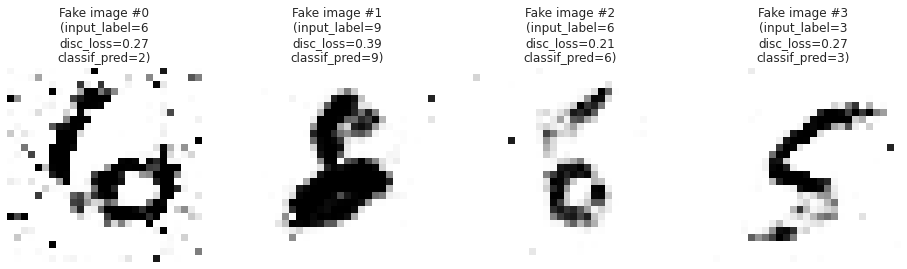


Epoch 00098: saving model to ./weights/cgan_pretrained=False_checkpoints.098.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9540 - discriminator_loss: 0.6269 - classifier_loss: 0.0000e+00
Epoch 99/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9662 - discriminator_loss: 0.6220 - classifier_loss: 0.0000e+00

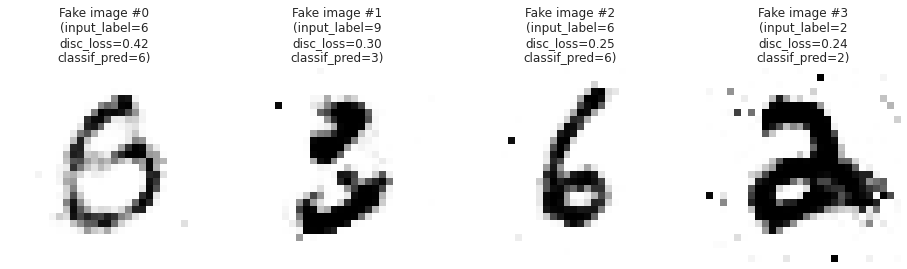


Epoch 00099: saving model to ./weights/cgan_pretrained=False_checkpoints.099.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9665 - discriminator_loss: 0.6223 - classifier_loss: 0.0000e+00
Epoch 100/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9564 - discriminator_loss: 0.6235 - classifier_loss: 0.0000e+00

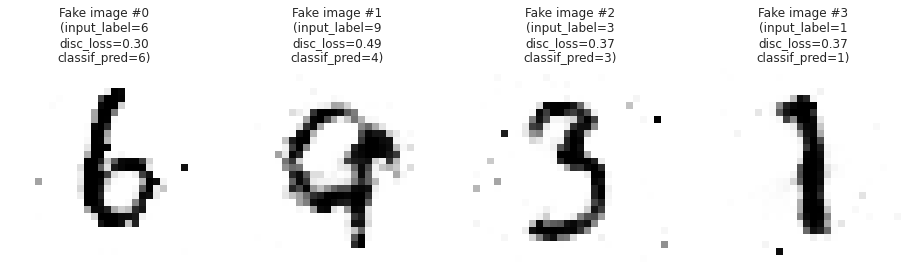


Epoch 00100: saving model to ./weights/cgan_pretrained=False_checkpoints.100.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9566 - discriminator_loss: 0.6235 - classifier_loss: 0.0000e+00
Epoch 101/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9602 - discriminator_loss: 0.6247 - classifier_loss: 0.0000e+00

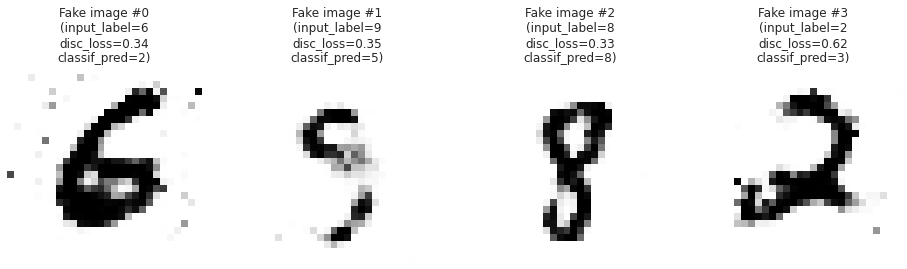


Epoch 00101: saving model to ./weights/cgan_pretrained=False_checkpoints.101.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9604 - discriminator_loss: 0.6246 - classifier_loss: 0.0000e+00
Epoch 102/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9514 - discriminator_loss: 0.6260 - classifier_loss: 0.0000e+00

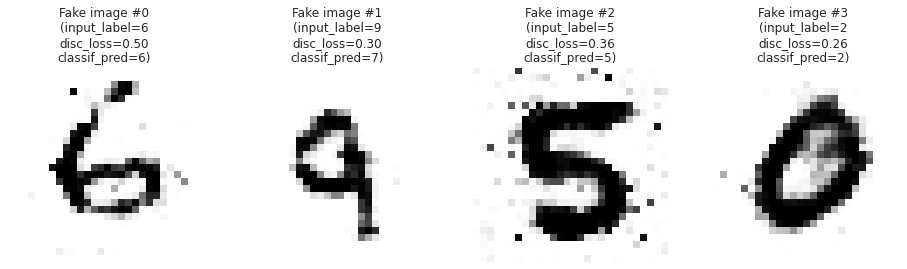


Epoch 00102: saving model to ./weights/cgan_pretrained=False_checkpoints.102.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9518 - discriminator_loss: 0.6261 - classifier_loss: 0.0000e+00
Epoch 103/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9527 - discriminator_loss: 0.6252 - classifier_loss: 0.0000e+00

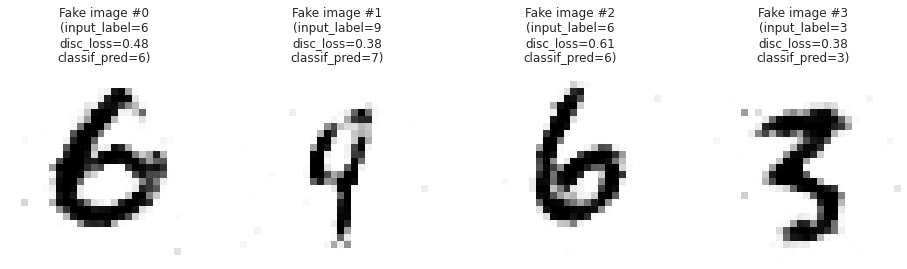


Epoch 00103: saving model to ./weights/cgan_pretrained=False_checkpoints.103.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9528 - discriminator_loss: 0.6250 - classifier_loss: 0.0000e+00
Epoch 104/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9596 - discriminator_loss: 0.6232 - classifier_loss: 0.0000e+00

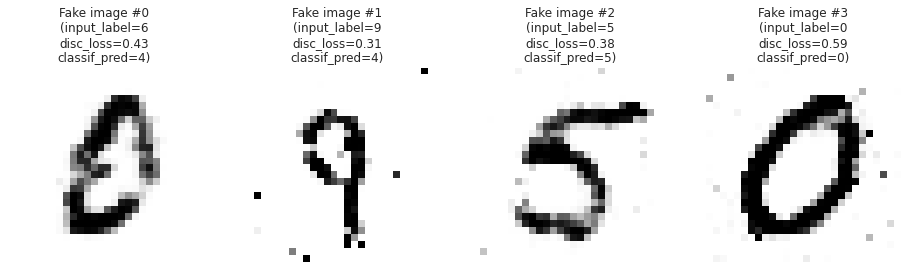


Epoch 00104: saving model to ./weights/cgan_pretrained=False_checkpoints.104.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9598 - discriminator_loss: 0.6234 - classifier_loss: 0.0000e+00
Epoch 105/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9653 - discriminator_loss: 0.6218 - classifier_loss: 0.0000e+00

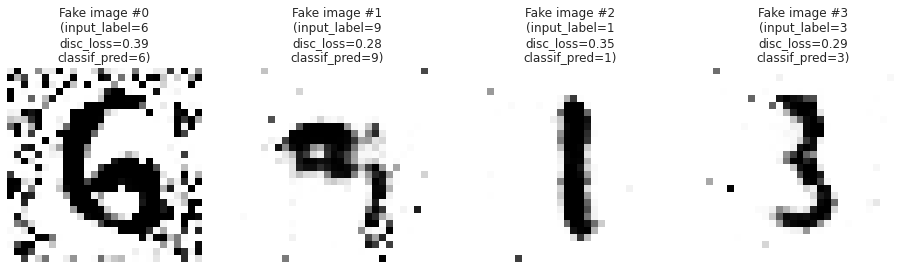


Epoch 00105: saving model to ./weights/cgan_pretrained=False_checkpoints.105.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9655 - discriminator_loss: 0.6220 - classifier_loss: 0.0000e+00
Epoch 106/200
468/468 [==============================] - ETA: 0s - generator_loss: 0.9822 - discriminator_loss: 0.6206 - classifier_loss: 0.0000e+00

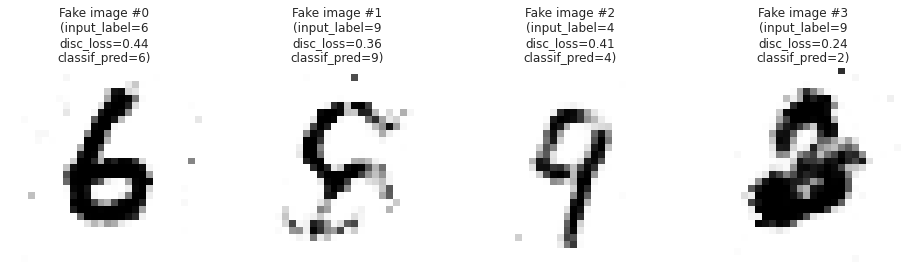


Epoch 00106: saving model to ./weights/cgan_pretrained=False_checkpoints.106.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9821 - discriminator_loss: 0.6206 - classifier_loss: 0.0000e+00
Epoch 107/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9780 - discriminator_loss: 0.6226 - classifier_loss: 0.0000e+00

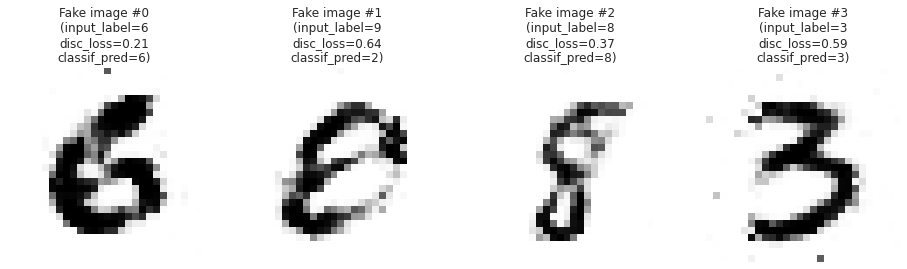


Epoch 00107: saving model to ./weights/cgan_pretrained=False_checkpoints.107.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9782 - discriminator_loss: 0.6227 - classifier_loss: 0.0000e+00
Epoch 108/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9722 - discriminator_loss: 0.6198 - classifier_loss: 0.0000e+00

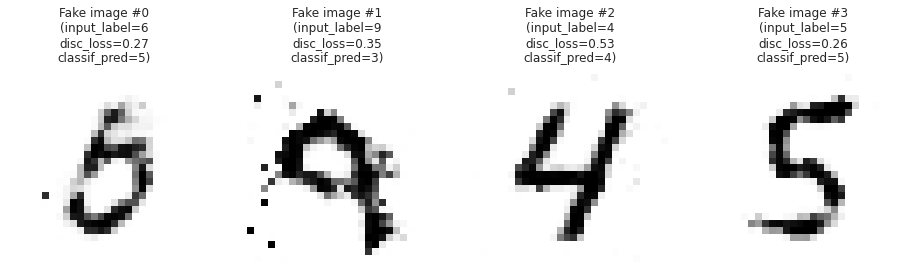


Epoch 00108: saving model to ./weights/cgan_pretrained=False_checkpoints.108.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9730 - discriminator_loss: 0.6200 - classifier_loss: 0.0000e+00
Epoch 109/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9604 - discriminator_loss: 0.6283 - classifier_loss: 0.0000e+00

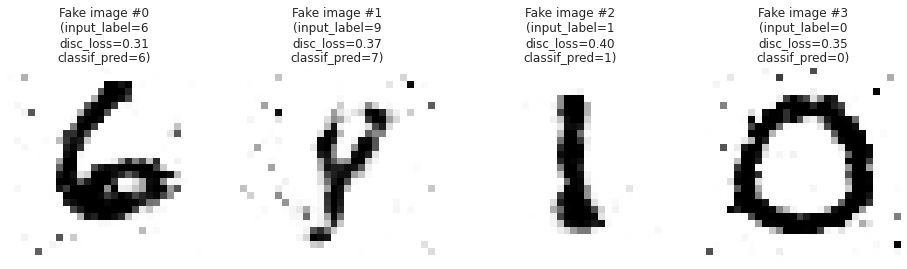


Epoch 00109: saving model to ./weights/cgan_pretrained=False_checkpoints.109.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9609 - discriminator_loss: 0.6281 - classifier_loss: 0.0000e+00
Epoch 110/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9794 - discriminator_loss: 0.6203 - classifier_loss: 0.0000e+00

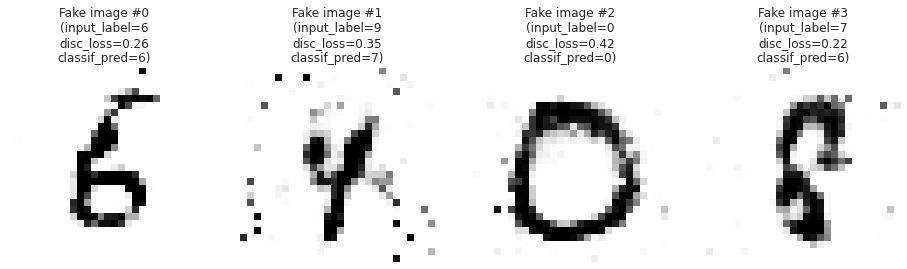


Epoch 00110: saving model to ./weights/cgan_pretrained=False_checkpoints.110.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9794 - discriminator_loss: 0.6200 - classifier_loss: 0.0000e+00
Epoch 111/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9949 - discriminator_loss: 0.6188 - classifier_loss: 0.0000e+00

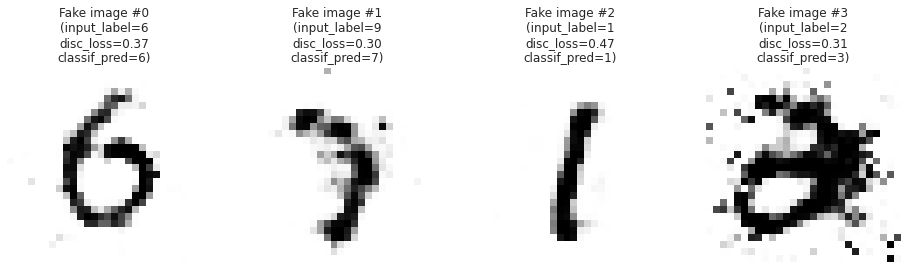


Epoch 00111: saving model to ./weights/cgan_pretrained=False_checkpoints.111.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9944 - discriminator_loss: 0.6191 - classifier_loss: 0.0000e+00
Epoch 112/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9572 - discriminator_loss: 0.6259 - classifier_loss: 0.0000e+00

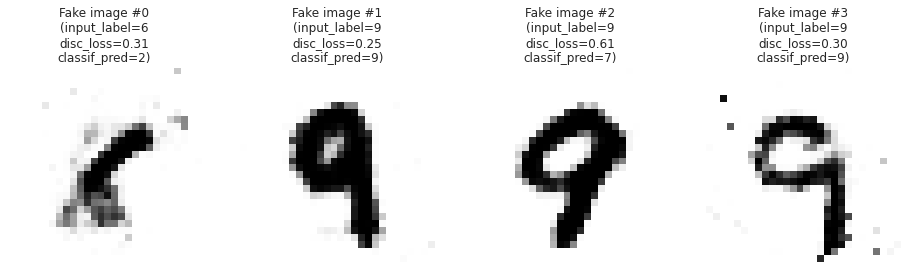


Epoch 00112: saving model to ./weights/cgan_pretrained=False_checkpoints.112.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9573 - discriminator_loss: 0.6260 - classifier_loss: 0.0000e+00
Epoch 113/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9463 - discriminator_loss: 0.6286 - classifier_loss: 0.0000e+00

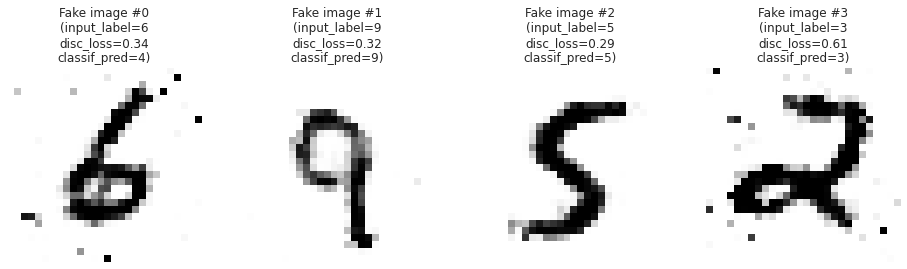


Epoch 00113: saving model to ./weights/cgan_pretrained=False_checkpoints.113.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9464 - discriminator_loss: 0.6289 - classifier_loss: 0.0000e+00
Epoch 114/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9616 - discriminator_loss: 0.6241 - classifier_loss: 0.0000e+00

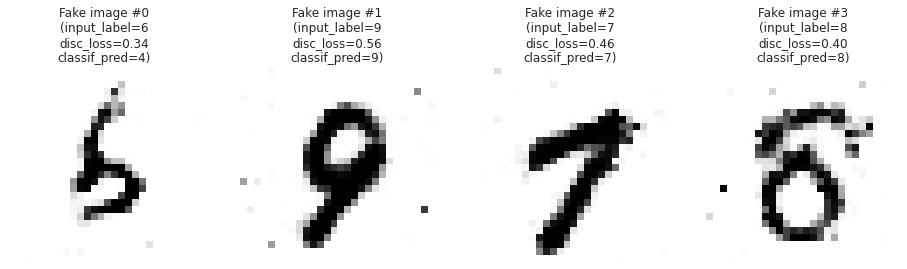


Epoch 00114: saving model to ./weights/cgan_pretrained=False_checkpoints.114.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9622 - discriminator_loss: 0.6240 - classifier_loss: 0.0000e+00
Epoch 115/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9828 - discriminator_loss: 0.6202 - classifier_loss: 0.0000e+00

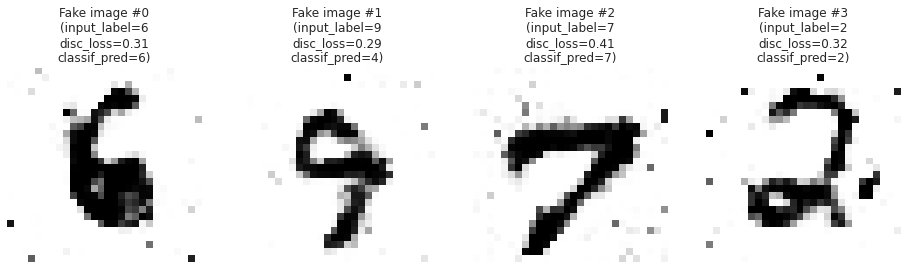


Epoch 00115: saving model to ./weights/cgan_pretrained=False_checkpoints.115.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9833 - discriminator_loss: 0.6203 - classifier_loss: 0.0000e+00
Epoch 116/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9929 - discriminator_loss: 0.6197 - classifier_loss: 0.0000e+00

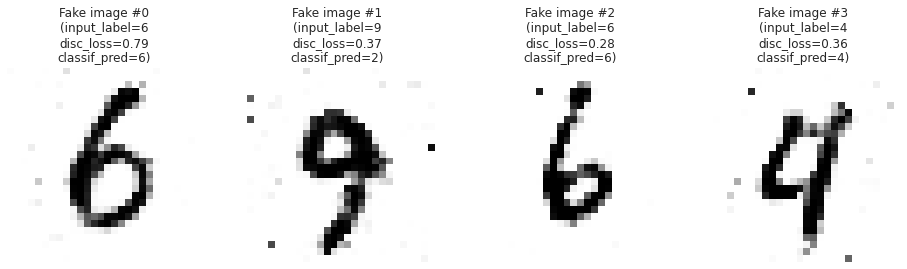


Epoch 00116: saving model to ./weights/cgan_pretrained=False_checkpoints.116.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9926 - discriminator_loss: 0.6198 - classifier_loss: 0.0000e+00
Epoch 117/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9994 - discriminator_loss: 0.6170 - classifier_loss: 0.0000e+00

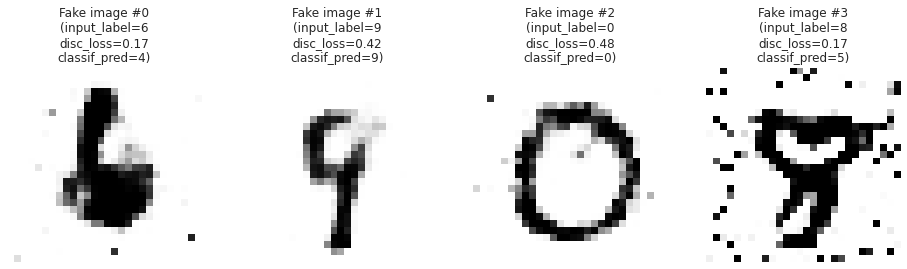


Epoch 00117: saving model to ./weights/cgan_pretrained=False_checkpoints.117.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9995 - discriminator_loss: 0.6172 - classifier_loss: 0.0000e+00
Epoch 118/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9808 - discriminator_loss: 0.6213 - classifier_loss: 0.0000e+00

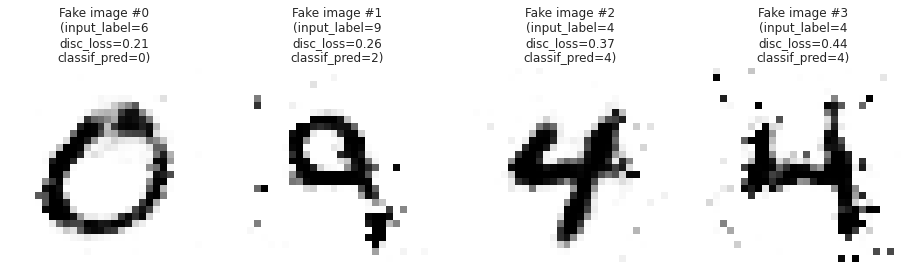


Epoch 00118: saving model to ./weights/cgan_pretrained=False_checkpoints.118.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 0.9816 - discriminator_loss: 0.6214 - classifier_loss: 0.0000e+00
Epoch 119/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9920 - discriminator_loss: 0.6180 - classifier_loss: 0.0000e+00

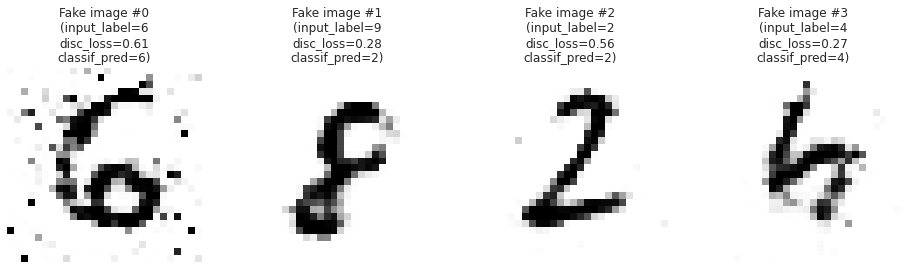


Epoch 00119: saving model to ./weights/cgan_pretrained=False_checkpoints.119.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9930 - discriminator_loss: 0.6178 - classifier_loss: 0.0000e+00
Epoch 120/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9945 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00

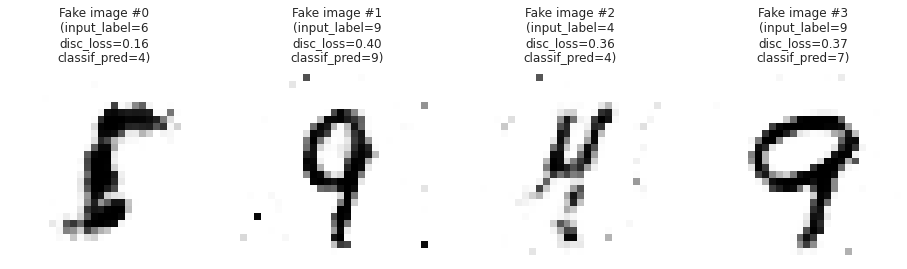


Epoch 00120: saving model to ./weights/cgan_pretrained=False_checkpoints.120.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9946 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00
Epoch 121/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9997 - discriminator_loss: 0.6161 - classifier_loss: 0.0000e+00

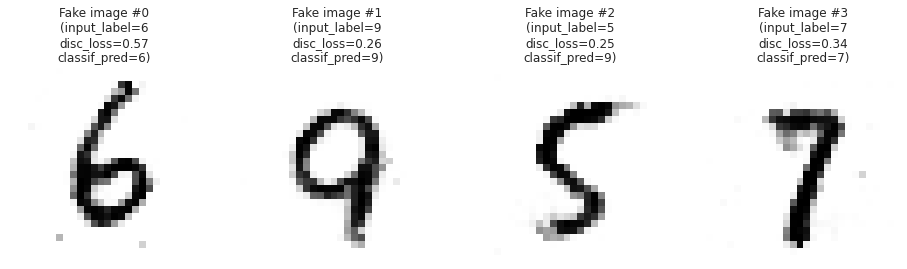


Epoch 00121: saving model to ./weights/cgan_pretrained=False_checkpoints.121.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0002 - discriminator_loss: 0.6161 - classifier_loss: 0.0000e+00
Epoch 122/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9888 - discriminator_loss: 0.6193 - classifier_loss: 0.0000e+00

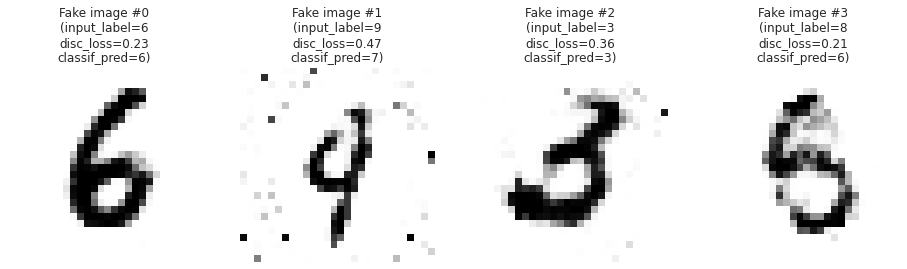


Epoch 00122: saving model to ./weights/cgan_pretrained=False_checkpoints.122.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9889 - discriminator_loss: 0.6192 - classifier_loss: 0.0000e+00
Epoch 123/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9816 - discriminator_loss: 0.6218 - classifier_loss: 0.0000e+00

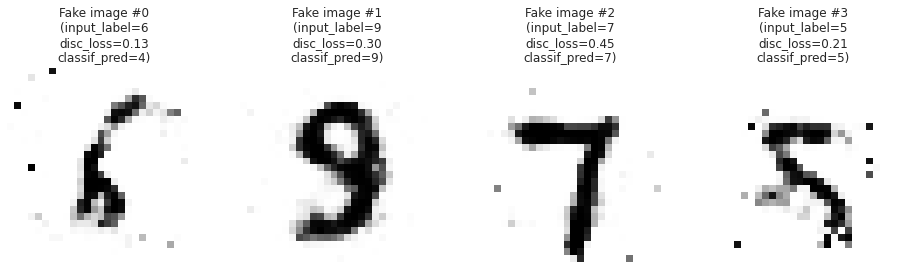


Epoch 00123: saving model to ./weights/cgan_pretrained=False_checkpoints.123.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9821 - discriminator_loss: 0.6219 - classifier_loss: 0.0000e+00
Epoch 124/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9849 - discriminator_loss: 0.6205 - classifier_loss: 0.0000e+00

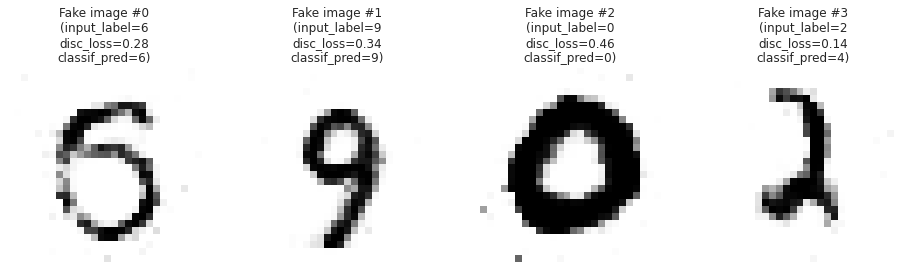


Epoch 00124: saving model to ./weights/cgan_pretrained=False_checkpoints.124.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9853 - discriminator_loss: 0.6206 - classifier_loss: 0.0000e+00
Epoch 125/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9931 - discriminator_loss: 0.6193 - classifier_loss: 0.0000e+00

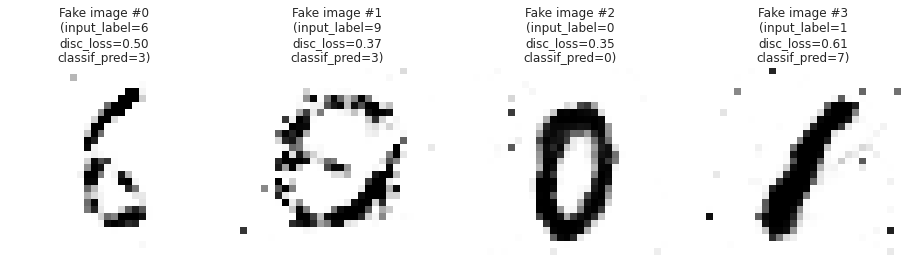


Epoch 00125: saving model to ./weights/cgan_pretrained=False_checkpoints.125.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9937 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00
Epoch 126/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0088 - discriminator_loss: 0.6165 - classifier_loss: 0.0000e+00

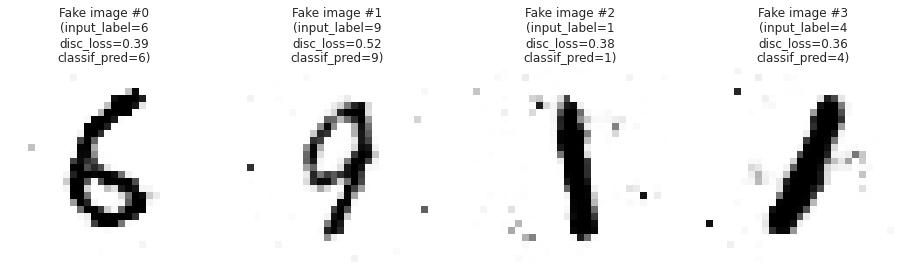


Epoch 00126: saving model to ./weights/cgan_pretrained=False_checkpoints.126.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0089 - discriminator_loss: 0.6164 - classifier_loss: 0.0000e+00
Epoch 127/200
468/468 [==============================] - ETA: 0s - generator_loss: 0.9927 - discriminator_loss: 0.6201 - classifier_loss: 0.0000e+00

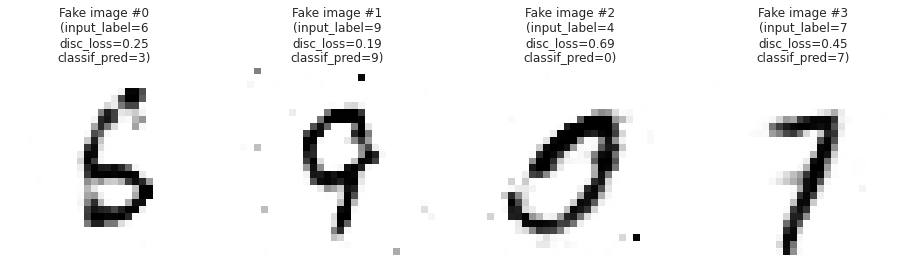


Epoch 00127: saving model to ./weights/cgan_pretrained=False_checkpoints.127.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9930 - discriminator_loss: 0.6201 - classifier_loss: 0.0000e+00
Epoch 128/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9942 - discriminator_loss: 0.6198 - classifier_loss: 0.0000e+00

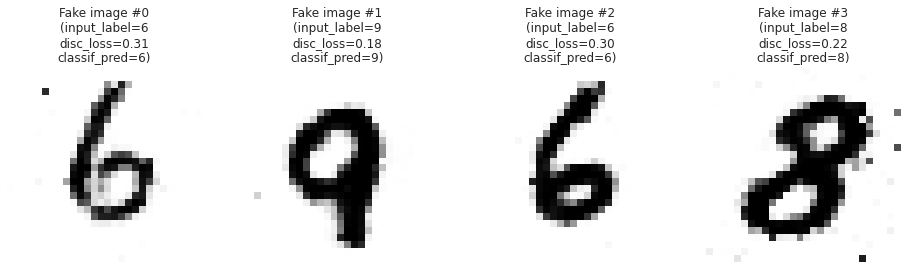


Epoch 00128: saving model to ./weights/cgan_pretrained=False_checkpoints.128.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9945 - discriminator_loss: 0.6196 - classifier_loss: 0.0000e+00
Epoch 129/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9984 - discriminator_loss: 0.6186 - classifier_loss: 0.0000e+00

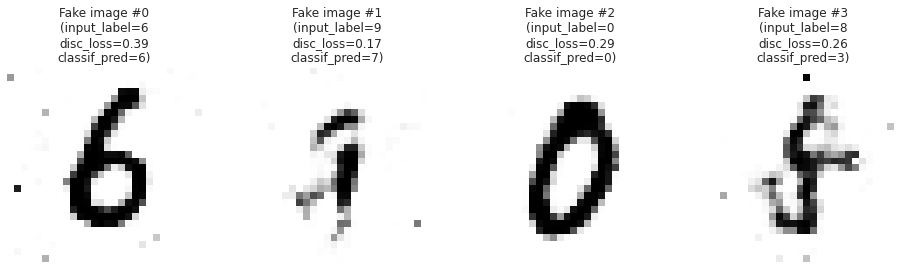


Epoch 00129: saving model to ./weights/cgan_pretrained=False_checkpoints.129.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9993 - discriminator_loss: 0.6184 - classifier_loss: 0.0000e+00
Epoch 130/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0061 - discriminator_loss: 0.6168 - classifier_loss: 0.0000e+00

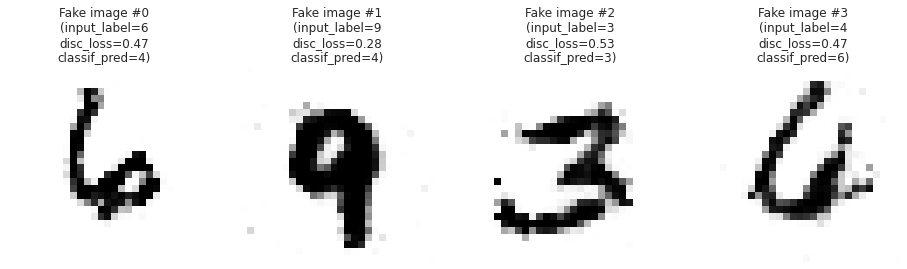


Epoch 00130: saving model to ./weights/cgan_pretrained=False_checkpoints.130.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0059 - discriminator_loss: 0.6168 - classifier_loss: 0.0000e+00
Epoch 131/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0005 - discriminator_loss: 0.6186 - classifier_loss: 0.0000e+00

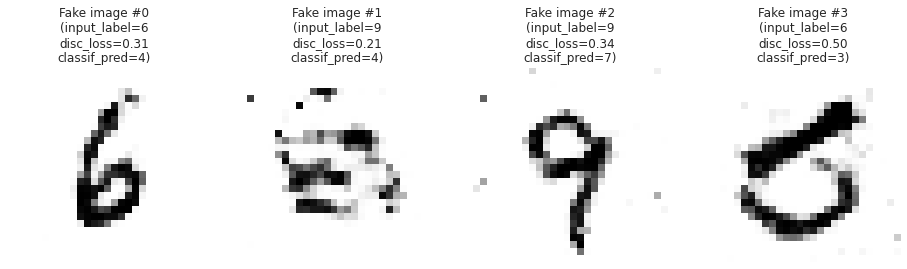


Epoch 00131: saving model to ./weights/cgan_pretrained=False_checkpoints.131.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0003 - discriminator_loss: 0.6186 - classifier_loss: 0.0000e+00
Epoch 132/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9986 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00

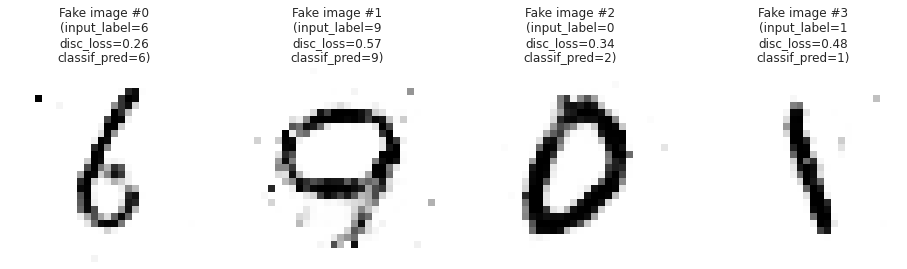


Epoch 00132: saving model to ./weights/cgan_pretrained=False_checkpoints.132.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9986 - discriminator_loss: 0.6192 - classifier_loss: 0.0000e+00
Epoch 133/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0088 - discriminator_loss: 0.6168 - classifier_loss: 0.0000e+00

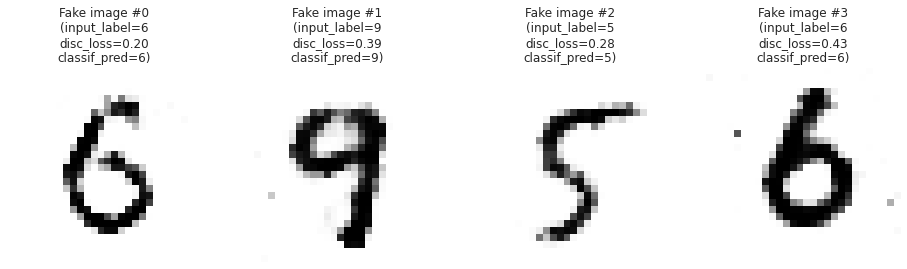


Epoch 00133: saving model to ./weights/cgan_pretrained=False_checkpoints.133.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0090 - discriminator_loss: 0.6169 - classifier_loss: 0.0000e+00
Epoch 134/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0184 - discriminator_loss: 0.6130 - classifier_loss: 0.0000e+00

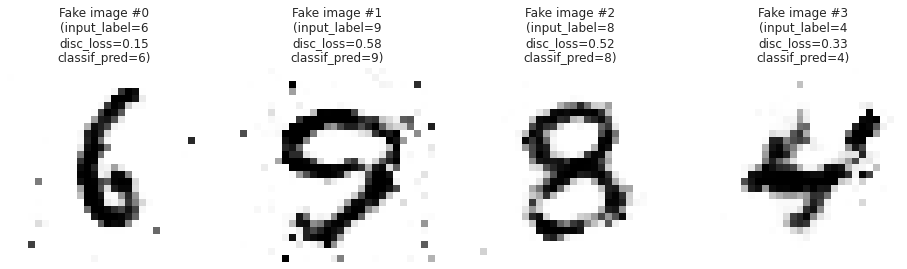


Epoch 00134: saving model to ./weights/cgan_pretrained=False_checkpoints.134.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0189 - discriminator_loss: 0.6129 - classifier_loss: 0.0000e+00
Epoch 135/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0179 - discriminator_loss: 0.6151 - classifier_loss: 0.0000e+00

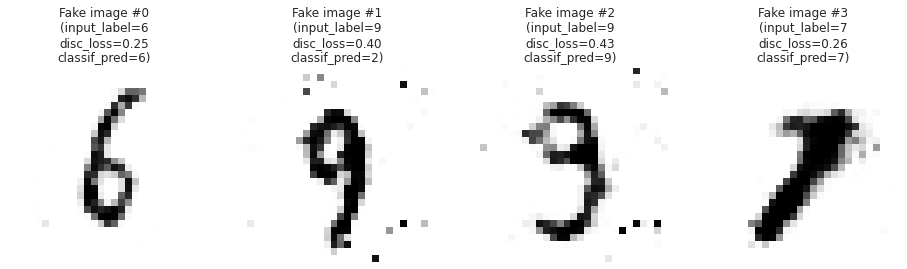


Epoch 00135: saving model to ./weights/cgan_pretrained=False_checkpoints.135.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0182 - discriminator_loss: 0.6152 - classifier_loss: 0.0000e+00
Epoch 136/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0104 - discriminator_loss: 0.6168 - classifier_loss: 0.0000e+00

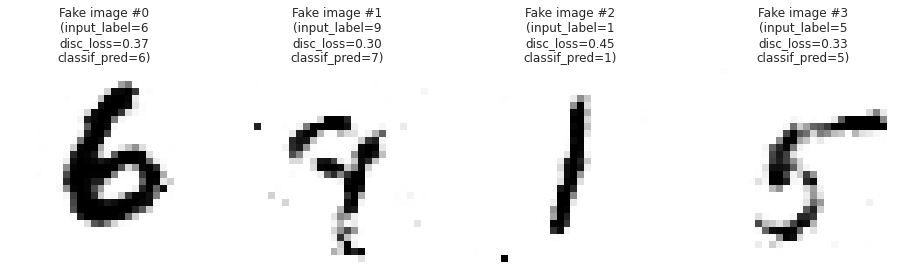


Epoch 00136: saving model to ./weights/cgan_pretrained=False_checkpoints.136.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0104 - discriminator_loss: 0.6170 - classifier_loss: 0.0000e+00
Epoch 137/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0145 - discriminator_loss: 0.6162 - classifier_loss: 0.0000e+00

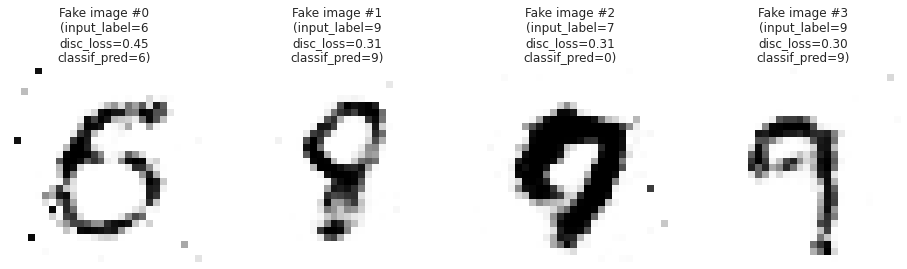


Epoch 00137: saving model to ./weights/cgan_pretrained=False_checkpoints.137.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0144 - discriminator_loss: 0.6163 - classifier_loss: 0.0000e+00
Epoch 138/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0281 - discriminator_loss: 0.6135 - classifier_loss: 0.0000e+00

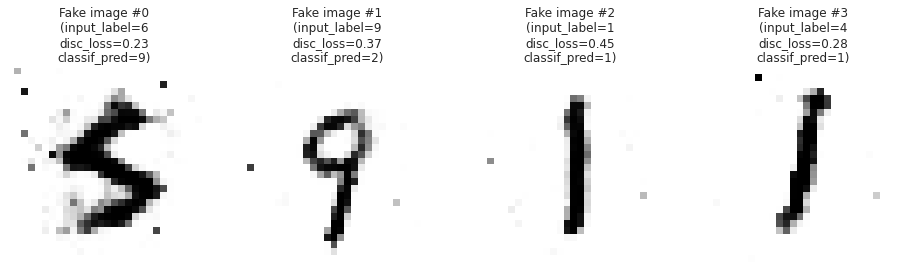


Epoch 00138: saving model to ./weights/cgan_pretrained=False_checkpoints.138.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0281 - discriminator_loss: 0.6138 - classifier_loss: 0.0000e+00
Epoch 139/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0045 - discriminator_loss: 0.6200 - classifier_loss: 0.0000e+00

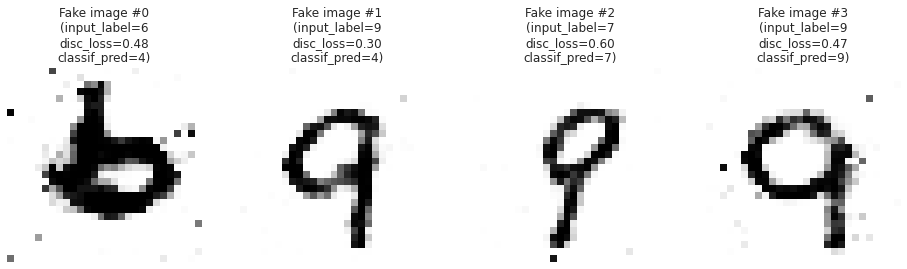


Epoch 00139: saving model to ./weights/cgan_pretrained=False_checkpoints.139.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0045 - discriminator_loss: 0.6201 - classifier_loss: 0.0000e+00
Epoch 140/200
466/468 [============================>.] - ETA: 0s - generator_loss: 0.9993 - discriminator_loss: 0.6193 - classifier_loss: 0.0000e+00

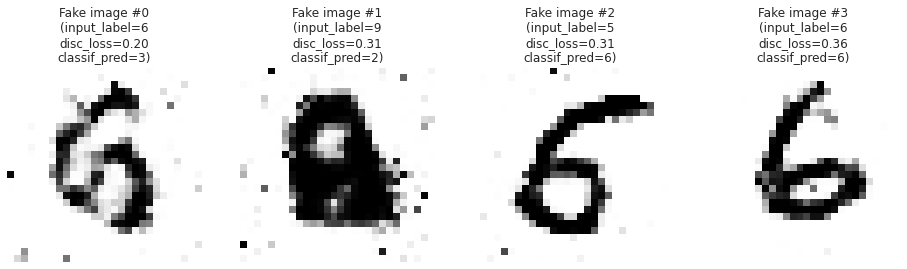


Epoch 00140: saving model to ./weights/cgan_pretrained=False_checkpoints.140.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 0.9995 - discriminator_loss: 0.6193 - classifier_loss: 0.0000e+00
Epoch 141/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0165 - discriminator_loss: 0.6171 - classifier_loss: 0.0000e+00

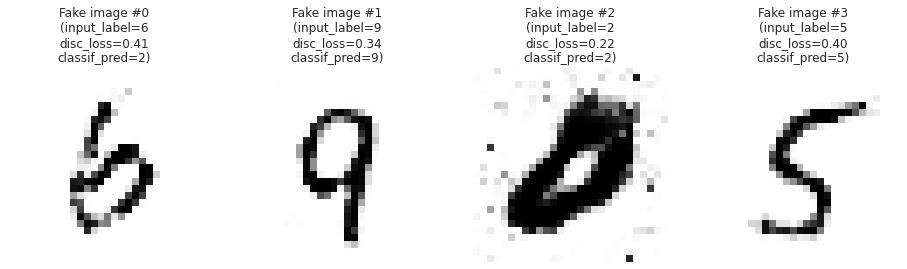


Epoch 00141: saving model to ./weights/cgan_pretrained=False_checkpoints.141.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0166 - discriminator_loss: 0.6172 - classifier_loss: 0.0000e+00
Epoch 142/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0224 - discriminator_loss: 0.6171 - classifier_loss: 0.0000e+00

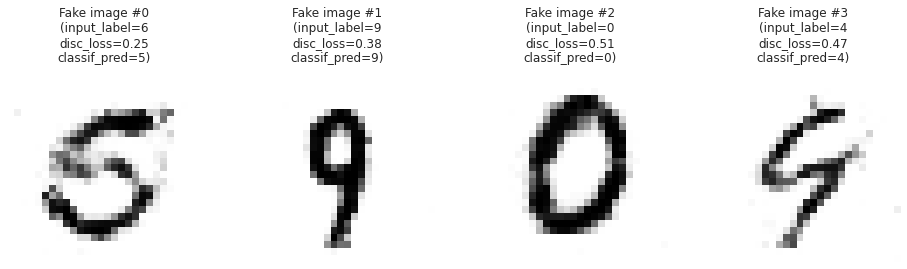


Epoch 00142: saving model to ./weights/cgan_pretrained=False_checkpoints.142.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0220 - discriminator_loss: 0.6172 - classifier_loss: 0.0000e+00
Epoch 143/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0104 - discriminator_loss: 0.6189 - classifier_loss: 0.0000e+00

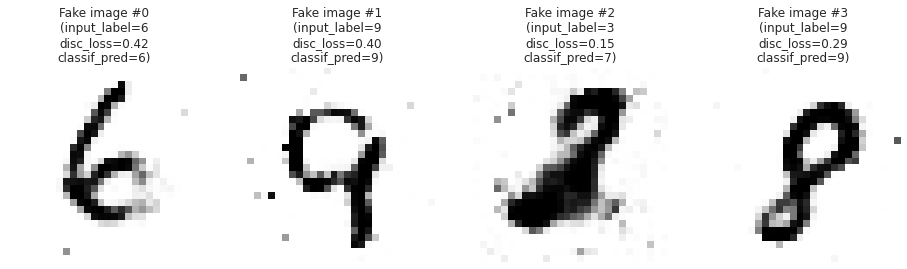


Epoch 00143: saving model to ./weights/cgan_pretrained=False_checkpoints.143.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0105 - discriminator_loss: 0.6190 - classifier_loss: 0.0000e+00
Epoch 144/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0252 - discriminator_loss: 0.6142 - classifier_loss: 0.0000e+00

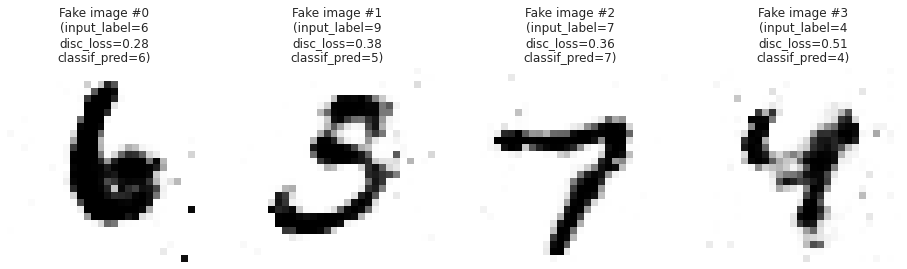


Epoch 00144: saving model to ./weights/cgan_pretrained=False_checkpoints.144.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0251 - discriminator_loss: 0.6144 - classifier_loss: 0.0000e+00
Epoch 145/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0324 - discriminator_loss: 0.6139 - classifier_loss: 0.0000e+00

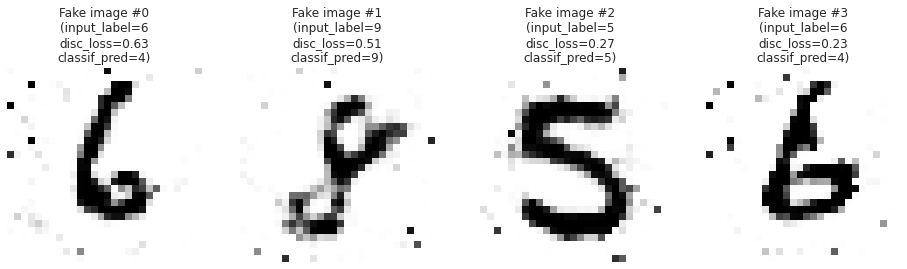


Epoch 00145: saving model to ./weights/cgan_pretrained=False_checkpoints.145.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0319 - discriminator_loss: 0.6139 - classifier_loss: 0.0000e+00
Epoch 146/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0392 - discriminator_loss: 0.6131 - classifier_loss: 0.0000e+00

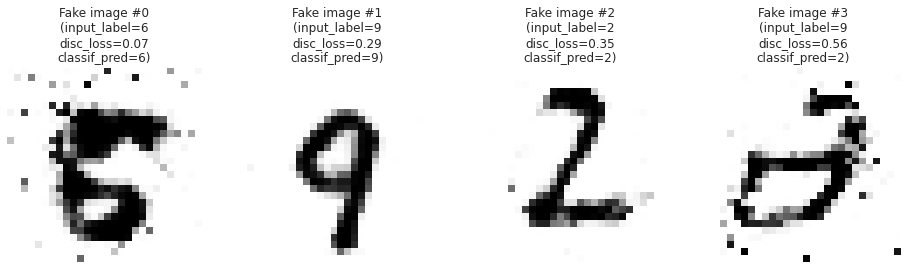


Epoch 00146: saving model to ./weights/cgan_pretrained=False_checkpoints.146.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0393 - discriminator_loss: 0.6133 - classifier_loss: 0.0000e+00
Epoch 147/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0270 - discriminator_loss: 0.6105 - classifier_loss: 0.0000e+00

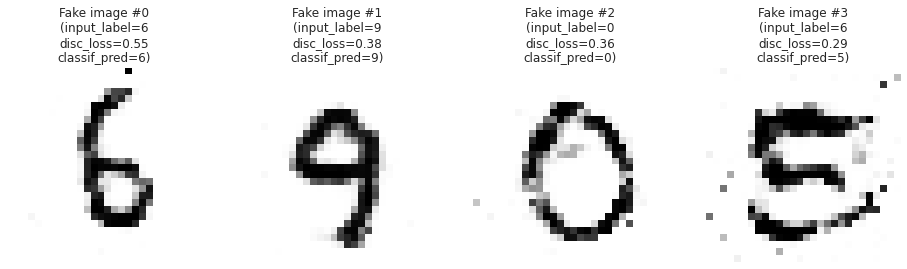


Epoch 00147: saving model to ./weights/cgan_pretrained=False_checkpoints.147.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0275 - discriminator_loss: 0.6106 - classifier_loss: 0.0000e+00
Epoch 148/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0183 - discriminator_loss: 0.6169 - classifier_loss: 0.0000e+00

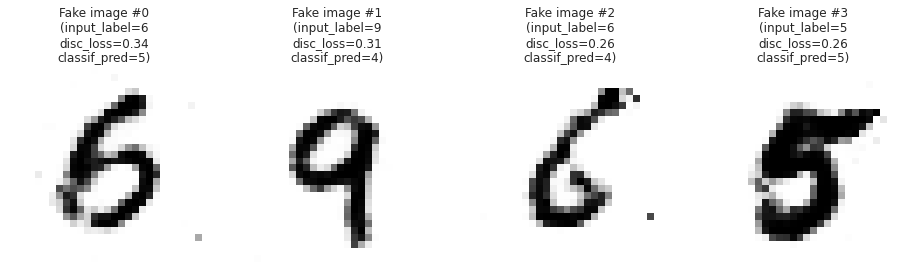


Epoch 00148: saving model to ./weights/cgan_pretrained=False_checkpoints.148.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0186 - discriminator_loss: 0.6169 - classifier_loss: 0.0000e+00
Epoch 149/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0216 - discriminator_loss: 0.6164 - classifier_loss: 0.0000e+00

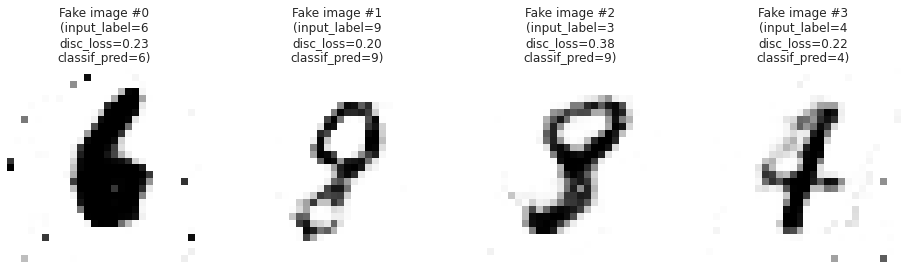


Epoch 00149: saving model to ./weights/cgan_pretrained=False_checkpoints.149.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0220 - discriminator_loss: 0.6163 - classifier_loss: 0.0000e+00
Epoch 150/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0369 - discriminator_loss: 0.6128 - classifier_loss: 0.0000e+00

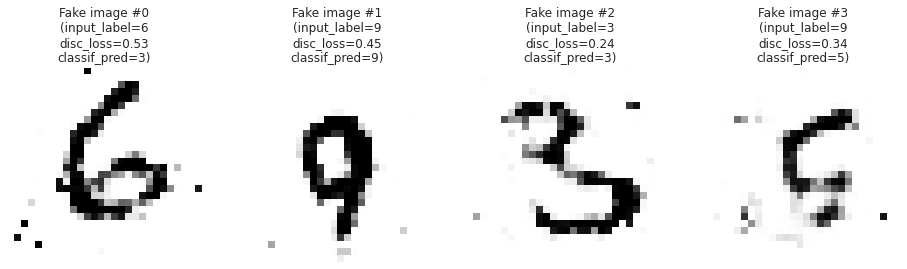


Epoch 00150: saving model to ./weights/cgan_pretrained=False_checkpoints.150.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0368 - discriminator_loss: 0.6133 - classifier_loss: 0.0000e+00
Epoch 151/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0341 - discriminator_loss: 0.6123 - classifier_loss: 0.0000e+00

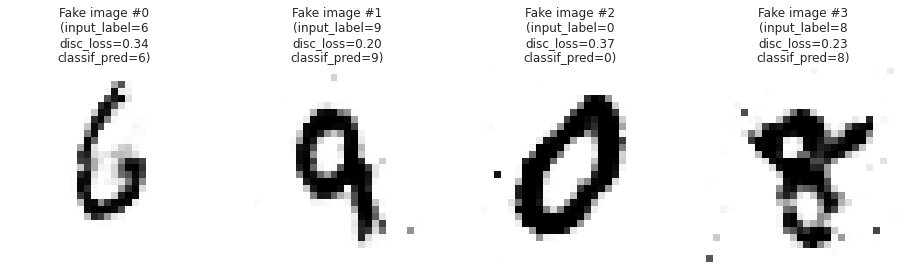


Epoch 00151: saving model to ./weights/cgan_pretrained=False_checkpoints.151.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0341 - discriminator_loss: 0.6124 - classifier_loss: 0.0000e+00
Epoch 152/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0316 - discriminator_loss: 0.6129 - classifier_loss: 0.0000e+00

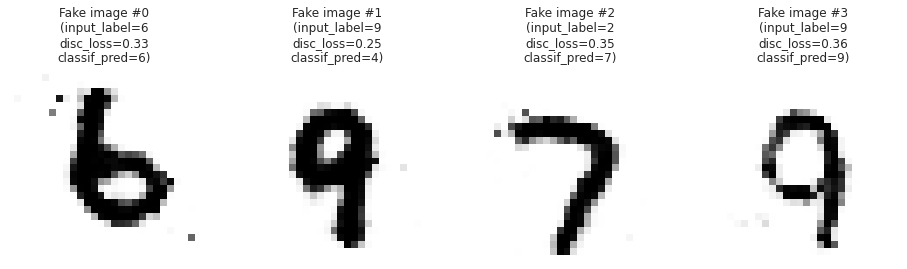


Epoch 00152: saving model to ./weights/cgan_pretrained=False_checkpoints.152.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0321 - discriminator_loss: 0.6130 - classifier_loss: 0.0000e+00
Epoch 153/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0470 - discriminator_loss: 0.6099 - classifier_loss: 0.0000e+00

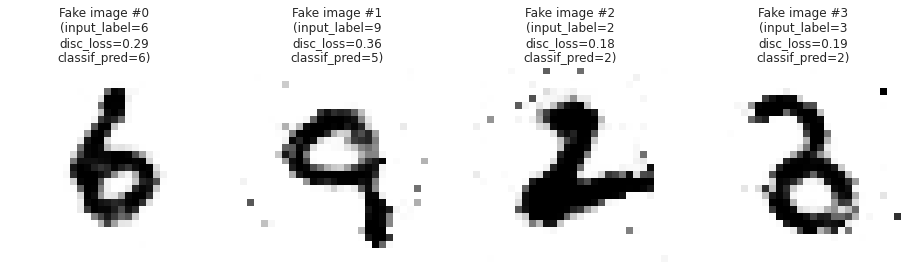


Epoch 00153: saving model to ./weights/cgan_pretrained=False_checkpoints.153.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0471 - discriminator_loss: 0.6103 - classifier_loss: 0.0000e+00
Epoch 154/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0469 - discriminator_loss: 0.6114 - classifier_loss: 0.0000e+00

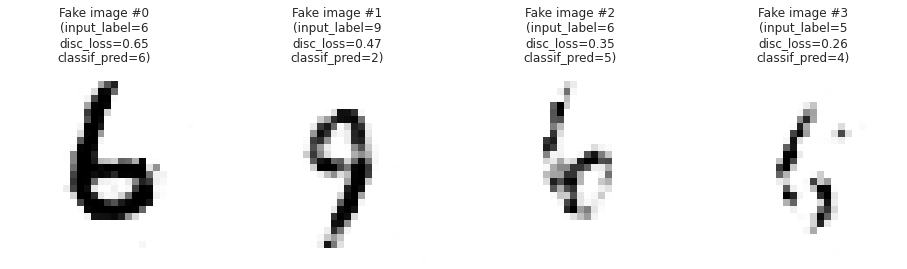


Epoch 00154: saving model to ./weights/cgan_pretrained=False_checkpoints.154.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0466 - discriminator_loss: 0.6115 - classifier_loss: 0.0000e+00
Epoch 155/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0396 - discriminator_loss: 0.6115 - classifier_loss: 0.0000e+00

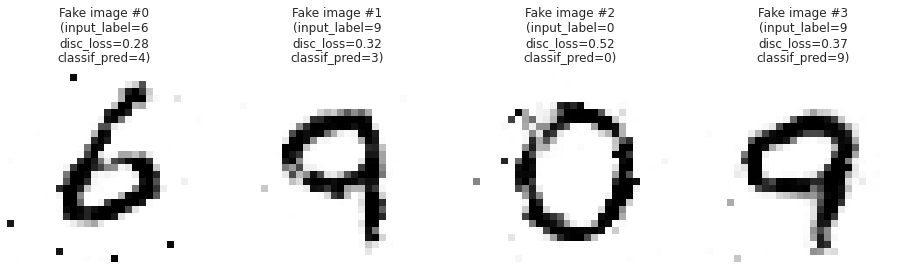


Epoch 00155: saving model to ./weights/cgan_pretrained=False_checkpoints.155.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0394 - discriminator_loss: 0.6117 - classifier_loss: 0.0000e+00
Epoch 156/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0401 - discriminator_loss: 0.6134 - classifier_loss: 0.0000e+00

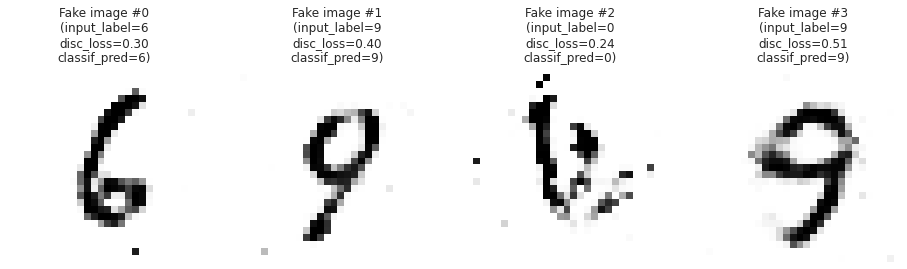


Epoch 00156: saving model to ./weights/cgan_pretrained=False_checkpoints.156.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0399 - discriminator_loss: 0.6136 - classifier_loss: 0.0000e+00
Epoch 157/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0463 - discriminator_loss: 0.6110 - classifier_loss: 0.0000e+00

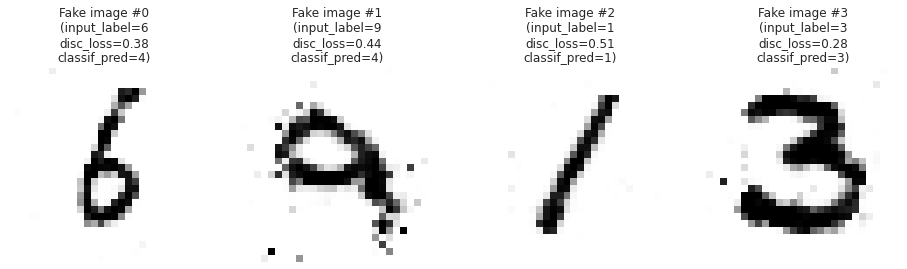


Epoch 00157: saving model to ./weights/cgan_pretrained=False_checkpoints.157.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0460 - discriminator_loss: 0.6110 - classifier_loss: 0.0000e+00
Epoch 158/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0559 - discriminator_loss: 0.6083 - classifier_loss: 0.0000e+00

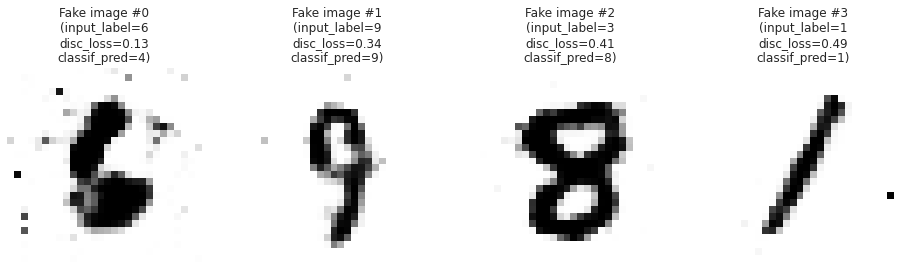


Epoch 00158: saving model to ./weights/cgan_pretrained=False_checkpoints.158.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0559 - discriminator_loss: 0.6085 - classifier_loss: 0.0000e+00
Epoch 159/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0599 - discriminator_loss: 0.6091 - classifier_loss: 0.0000e+00

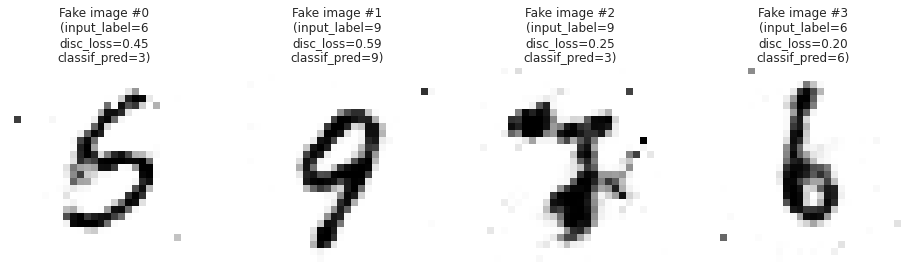


Epoch 00159: saving model to ./weights/cgan_pretrained=False_checkpoints.159.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0597 - discriminator_loss: 0.6092 - classifier_loss: 0.0000e+00
Epoch 160/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0555 - discriminator_loss: 0.6093 - classifier_loss: 0.0000e+00

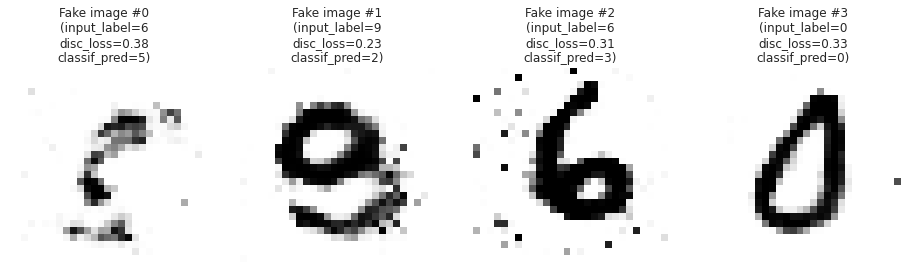


Epoch 00160: saving model to ./weights/cgan_pretrained=False_checkpoints.160.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0555 - discriminator_loss: 0.6093 - classifier_loss: 0.0000e+00
Epoch 161/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0540 - discriminator_loss: 0.6116 - classifier_loss: 0.0000e+00

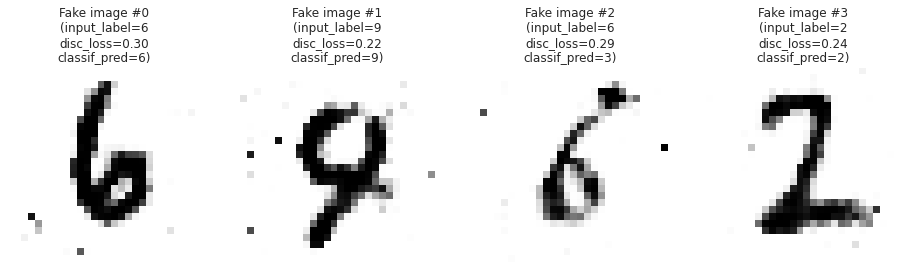


Epoch 00161: saving model to ./weights/cgan_pretrained=False_checkpoints.161.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0543 - discriminator_loss: 0.6116 - classifier_loss: 0.0000e+00
Epoch 162/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0538 - discriminator_loss: 0.6096 - classifier_loss: 0.0000e+00

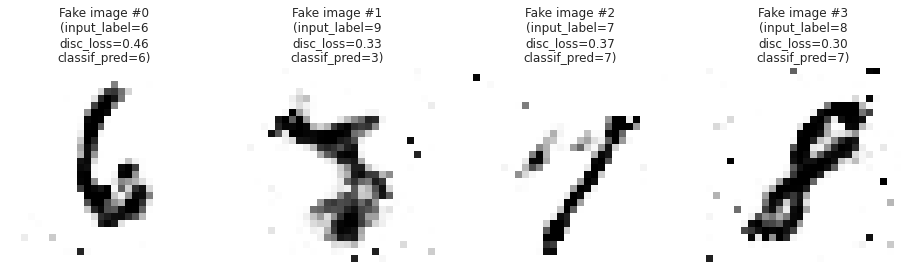


Epoch 00162: saving model to ./weights/cgan_pretrained=False_checkpoints.162.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0536 - discriminator_loss: 0.6099 - classifier_loss: 0.0000e+00
Epoch 163/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0519 - discriminator_loss: 0.6110 - classifier_loss: 0.0000e+00

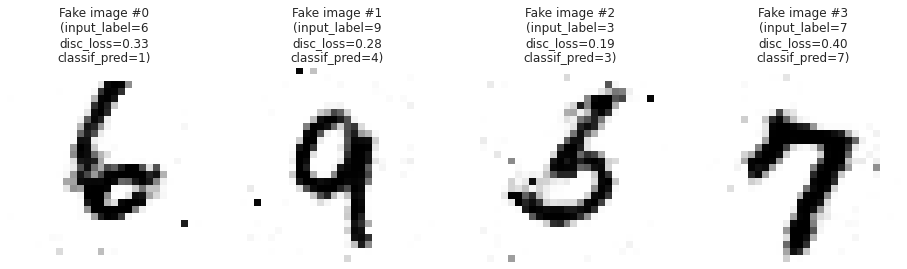


Epoch 00163: saving model to ./weights/cgan_pretrained=False_checkpoints.163.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0521 - discriminator_loss: 0.6110 - classifier_loss: 0.0000e+00
Epoch 164/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0589 - discriminator_loss: 0.6089 - classifier_loss: 0.0000e+00

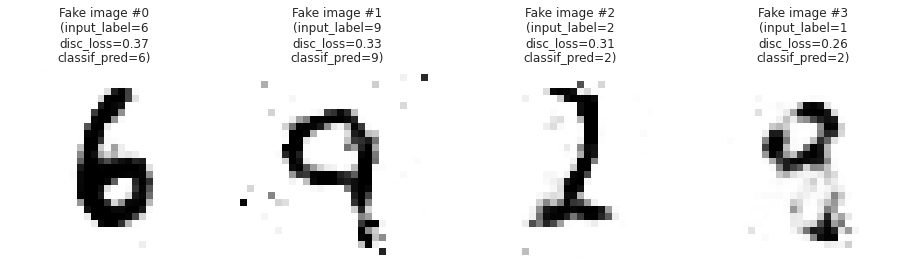


Epoch 00164: saving model to ./weights/cgan_pretrained=False_checkpoints.164.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0585 - discriminator_loss: 0.6090 - classifier_loss: 0.0000e+00
Epoch 165/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0723 - discriminator_loss: 0.6067 - classifier_loss: 0.0000e+00

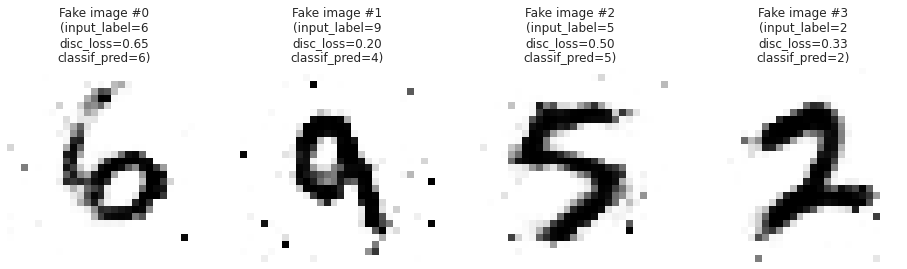


Epoch 00165: saving model to ./weights/cgan_pretrained=False_checkpoints.165.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0719 - discriminator_loss: 0.6067 - classifier_loss: 0.0000e+00
Epoch 166/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0631 - discriminator_loss: 0.6103 - classifier_loss: 0.0000e+00

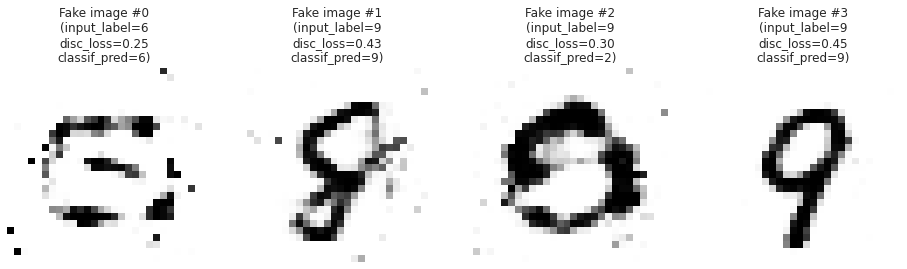


Epoch 00166: saving model to ./weights/cgan_pretrained=False_checkpoints.166.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0628 - discriminator_loss: 0.6104 - classifier_loss: 0.0000e+00
Epoch 167/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0541 - discriminator_loss: 0.6100 - classifier_loss: 0.0000e+00

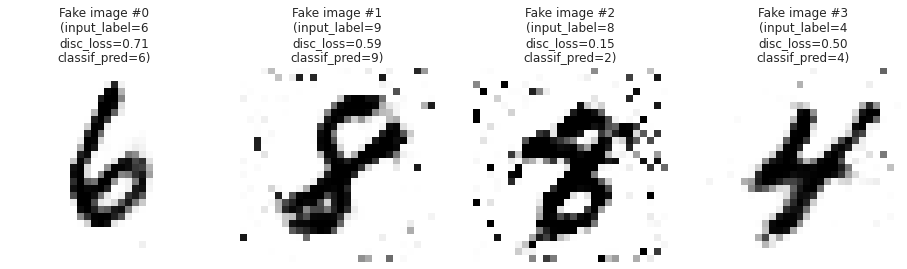


Epoch 00167: saving model to ./weights/cgan_pretrained=False_checkpoints.167.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0540 - discriminator_loss: 0.6101 - classifier_loss: 0.0000e+00
Epoch 168/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0505 - discriminator_loss: 0.6119 - classifier_loss: 0.0000e+00

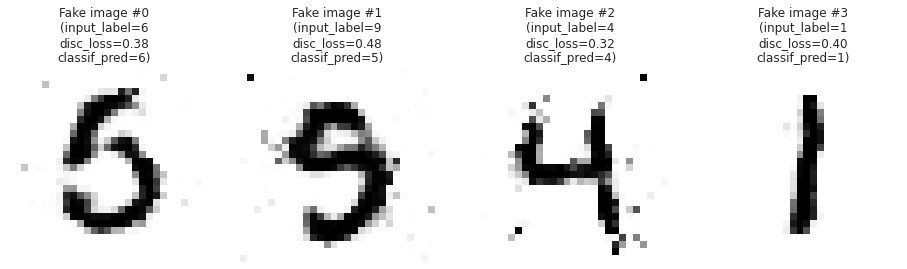


Epoch 00168: saving model to ./weights/cgan_pretrained=False_checkpoints.168.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0507 - discriminator_loss: 0.6118 - classifier_loss: 0.0000e+00
Epoch 169/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0532 - discriminator_loss: 0.6111 - classifier_loss: 0.0000e+00

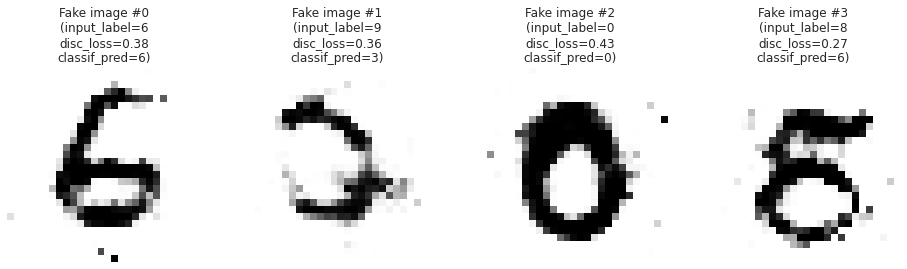


Epoch 00169: saving model to ./weights/cgan_pretrained=False_checkpoints.169.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0531 - discriminator_loss: 0.6111 - classifier_loss: 0.0000e+00
Epoch 170/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0564 - discriminator_loss: 0.6102 - classifier_loss: 0.0000e+00

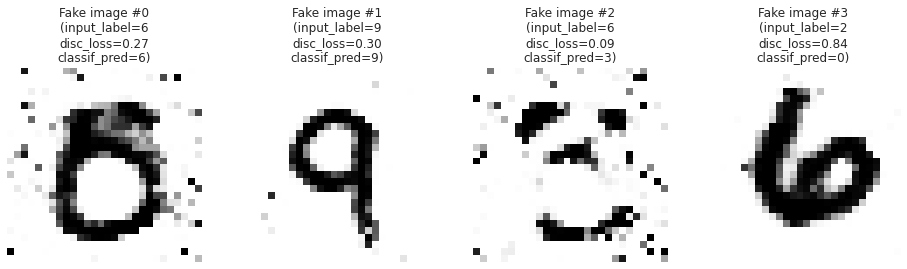


Epoch 00170: saving model to ./weights/cgan_pretrained=False_checkpoints.170.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0563 - discriminator_loss: 0.6103 - classifier_loss: 0.0000e+00
Epoch 171/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0704 - discriminator_loss: 0.6050 - classifier_loss: 0.0000e+00

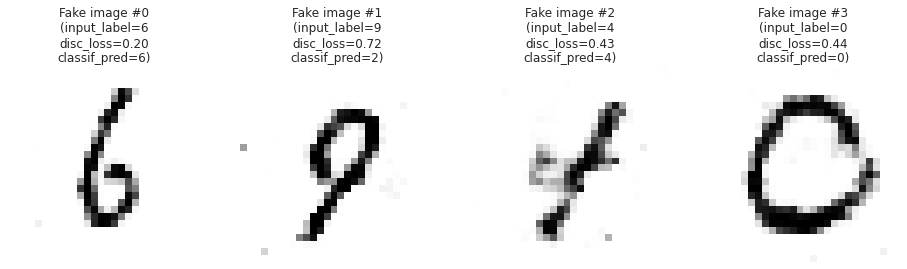


Epoch 00171: saving model to ./weights/cgan_pretrained=False_checkpoints.171.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0706 - discriminator_loss: 0.6051 - classifier_loss: 0.0000e+00
Epoch 172/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0795 - discriminator_loss: 0.6050 - classifier_loss: 0.0000e+00

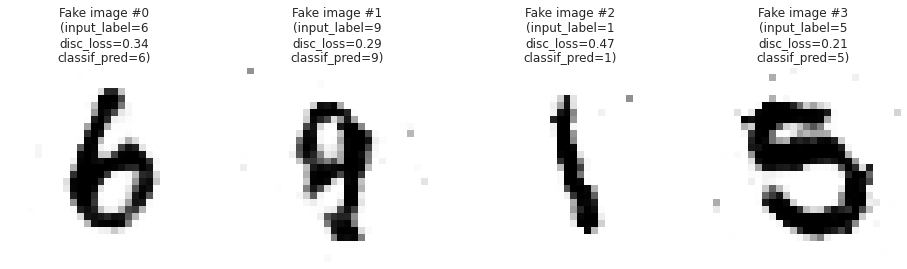


Epoch 00172: saving model to ./weights/cgan_pretrained=False_checkpoints.172.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0793 - discriminator_loss: 0.6052 - classifier_loss: 0.0000e+00
Epoch 173/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0826 - discriminator_loss: 0.6055 - classifier_loss: 0.0000e+00

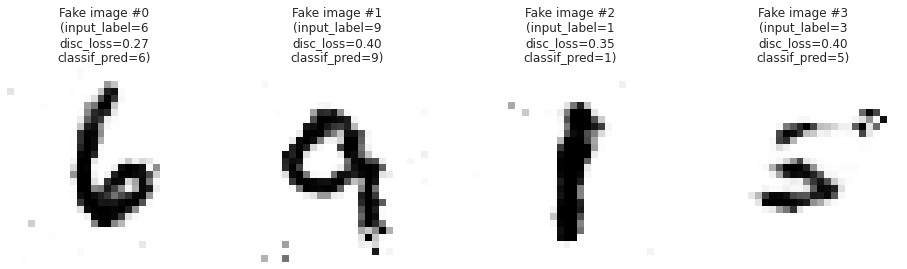


Epoch 00173: saving model to ./weights/cgan_pretrained=False_checkpoints.173.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0828 - discriminator_loss: 0.6056 - classifier_loss: 0.0000e+00
Epoch 174/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0809 - discriminator_loss: 0.6059 - classifier_loss: 0.0000e+00

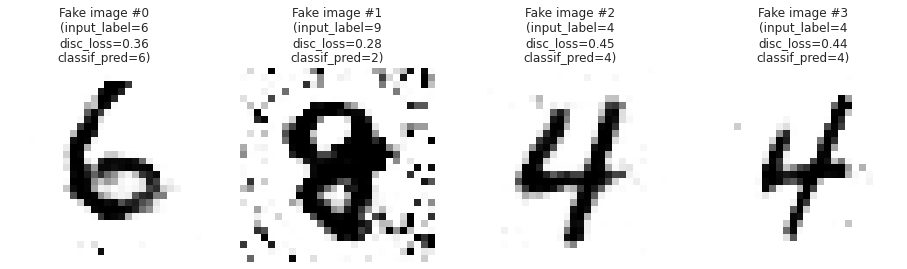


Epoch 00174: saving model to ./weights/cgan_pretrained=False_checkpoints.174.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0807 - discriminator_loss: 0.6059 - classifier_loss: 0.0000e+00
Epoch 175/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0748 - discriminator_loss: 0.6072 - classifier_loss: 0.0000e+00

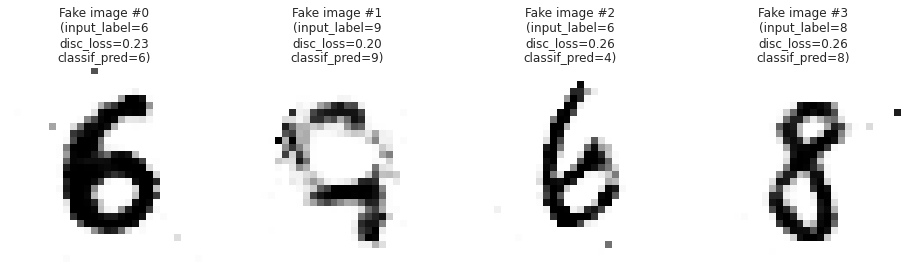


Epoch 00175: saving model to ./weights/cgan_pretrained=False_checkpoints.175.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0750 - discriminator_loss: 0.6073 - classifier_loss: 0.0000e+00
Epoch 176/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0730 - discriminator_loss: 0.6046 - classifier_loss: 0.0000e+00

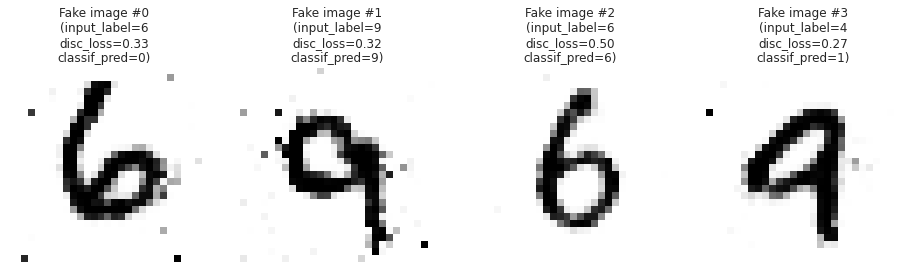


Epoch 00176: saving model to ./weights/cgan_pretrained=False_checkpoints.176.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0734 - discriminator_loss: 0.6047 - classifier_loss: 0.0000e+00
Epoch 177/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0702 - discriminator_loss: 0.6079 - classifier_loss: 0.0000e+00

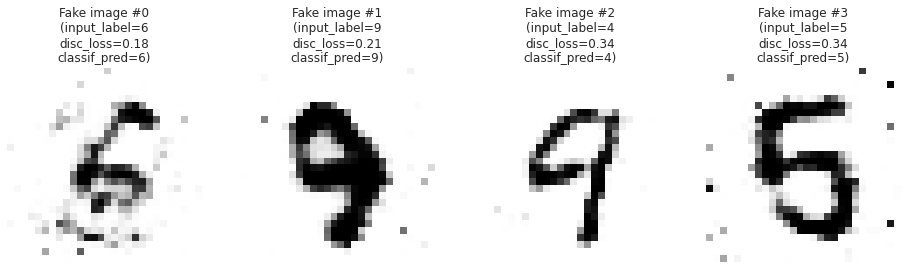


Epoch 00177: saving model to ./weights/cgan_pretrained=False_checkpoints.177.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0708 - discriminator_loss: 0.6081 - classifier_loss: 0.0000e+00
Epoch 178/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0784 - discriminator_loss: 0.6046 - classifier_loss: 0.0000e+00

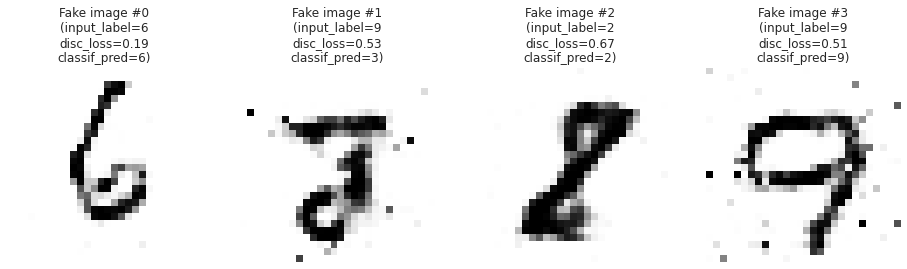


Epoch 00178: saving model to ./weights/cgan_pretrained=False_checkpoints.178.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0784 - discriminator_loss: 0.6048 - classifier_loss: 0.0000e+00
Epoch 179/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0875 - discriminator_loss: 0.6045 - classifier_loss: 0.0000e+00

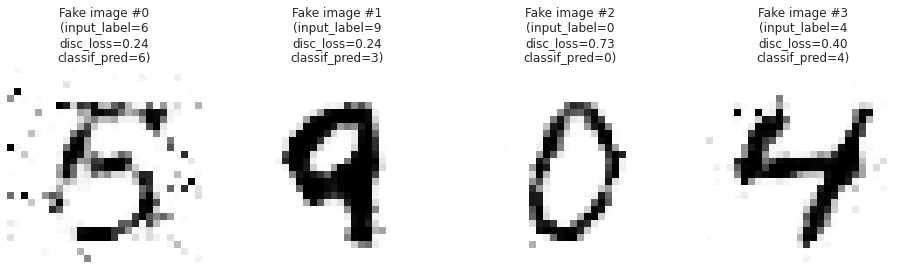


Epoch 00179: saving model to ./weights/cgan_pretrained=False_checkpoints.179.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0871 - discriminator_loss: 0.6048 - classifier_loss: 0.0000e+00
Epoch 180/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0858 - discriminator_loss: 0.6048 - classifier_loss: 0.0000e+00

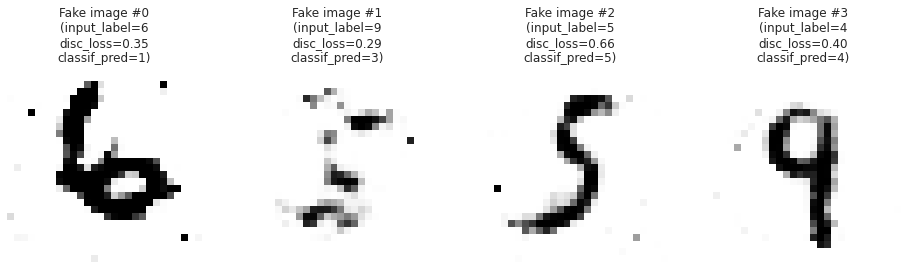


Epoch 00180: saving model to ./weights/cgan_pretrained=False_checkpoints.180.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0856 - discriminator_loss: 0.6047 - classifier_loss: 0.0000e+00
Epoch 181/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0827 - discriminator_loss: 0.6033 - classifier_loss: 0.0000e+00

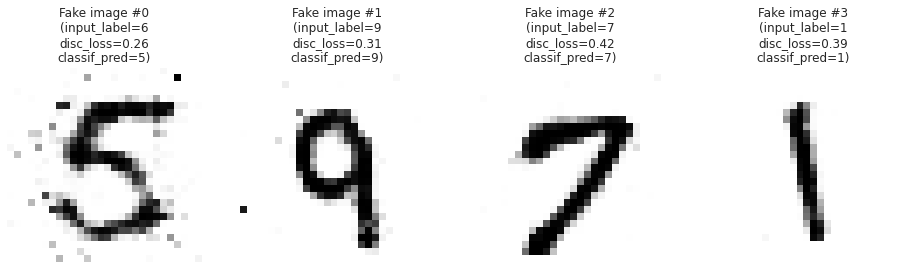


Epoch 00181: saving model to ./weights/cgan_pretrained=False_checkpoints.181.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0826 - discriminator_loss: 0.6036 - classifier_loss: 0.0000e+00
Epoch 182/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0807 - discriminator_loss: 0.6064 - classifier_loss: 0.0000e+00

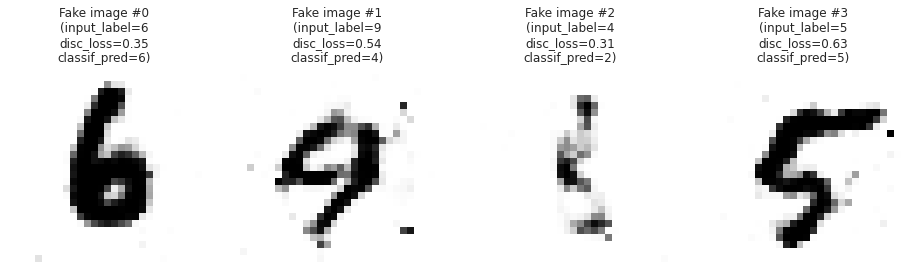


Epoch 00182: saving model to ./weights/cgan_pretrained=False_checkpoints.182.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0809 - discriminator_loss: 0.6064 - classifier_loss: 0.0000e+00
Epoch 183/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0830 - discriminator_loss: 0.6068 - classifier_loss: 0.0000e+00

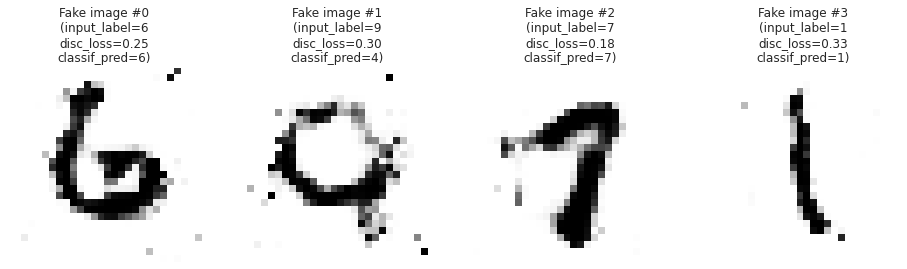


Epoch 00183: saving model to ./weights/cgan_pretrained=False_checkpoints.183.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0836 - discriminator_loss: 0.6067 - classifier_loss: 0.0000e+00
Epoch 184/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0947 - discriminator_loss: 0.5997 - classifier_loss: 0.0000e+00

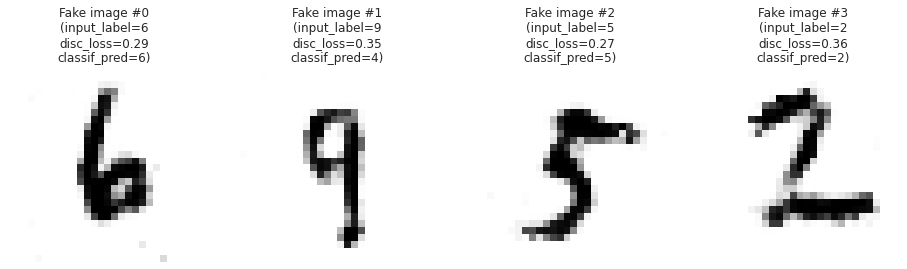


Epoch 00184: saving model to ./weights/cgan_pretrained=False_checkpoints.184.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0944 - discriminator_loss: 0.5999 - classifier_loss: 0.0000e+00
Epoch 185/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0800 - discriminator_loss: 0.6060 - classifier_loss: 0.0000e+00

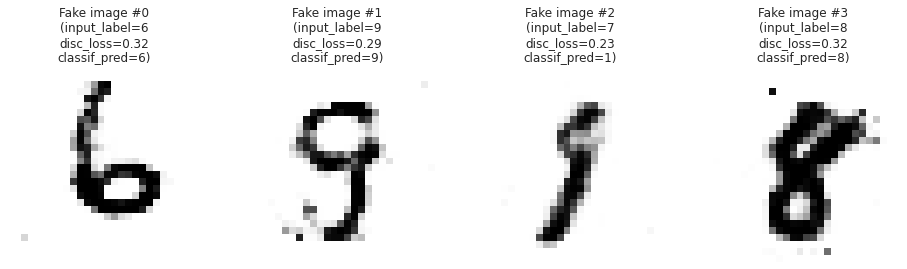


Epoch 00185: saving model to ./weights/cgan_pretrained=False_checkpoints.185.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0801 - discriminator_loss: 0.6063 - classifier_loss: 0.0000e+00
Epoch 186/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0871 - discriminator_loss: 0.6033 - classifier_loss: 0.0000e+00

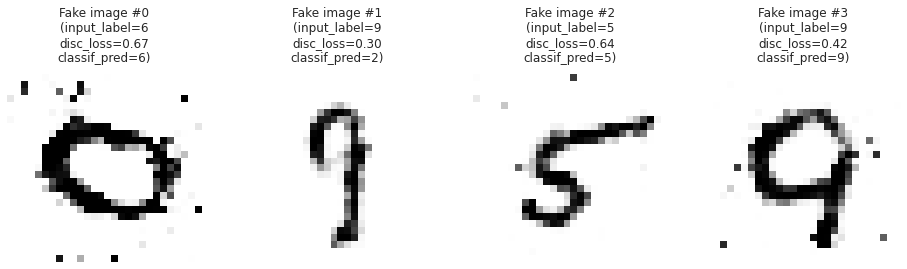


Epoch 00186: saving model to ./weights/cgan_pretrained=False_checkpoints.186.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0874 - discriminator_loss: 0.6034 - classifier_loss: 0.0000e+00
Epoch 187/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0991 - discriminator_loss: 0.6020 - classifier_loss: 0.0000e+00

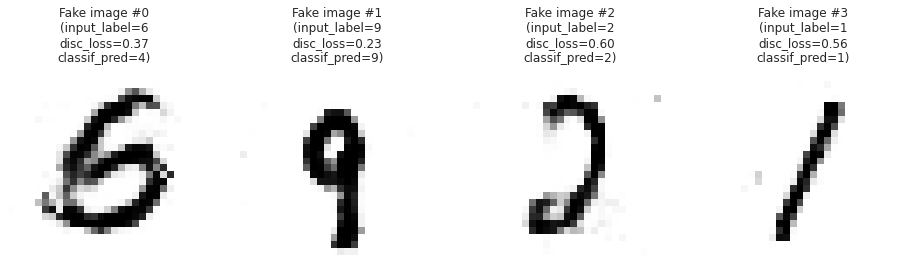


Epoch 00187: saving model to ./weights/cgan_pretrained=False_checkpoints.187.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0991 - discriminator_loss: 0.6020 - classifier_loss: 0.0000e+00
Epoch 188/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1075 - discriminator_loss: 0.5999 - classifier_loss: 0.0000e+00

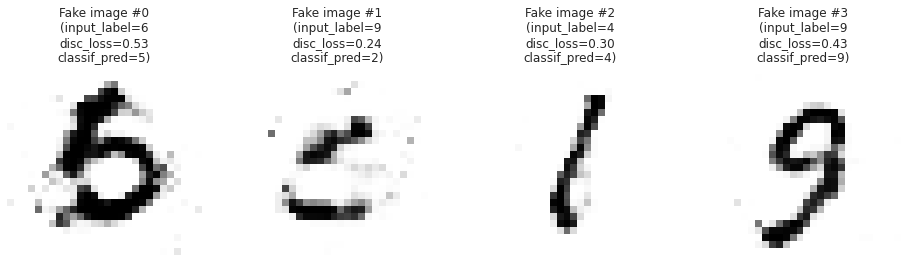


Epoch 00188: saving model to ./weights/cgan_pretrained=False_checkpoints.188.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1076 - discriminator_loss: 0.6001 - classifier_loss: 0.0000e+00
Epoch 189/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0987 - discriminator_loss: 0.6019 - classifier_loss: 0.0000e+00

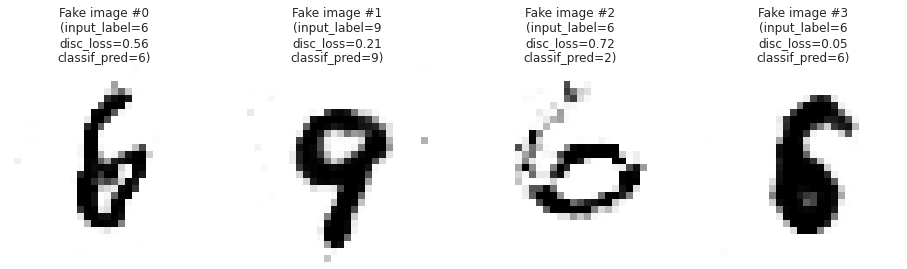


Epoch 00189: saving model to ./weights/cgan_pretrained=False_checkpoints.189.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0993 - discriminator_loss: 0.6018 - classifier_loss: 0.0000e+00
Epoch 190/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0899 - discriminator_loss: 0.6051 - classifier_loss: 0.0000e+00

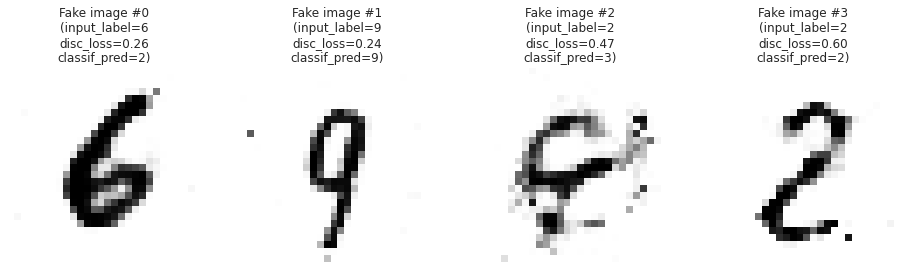


Epoch 00190: saving model to ./weights/cgan_pretrained=False_checkpoints.190.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0899 - discriminator_loss: 0.6052 - classifier_loss: 0.0000e+00
Epoch 191/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0925 - discriminator_loss: 0.6032 - classifier_loss: 0.0000e+00

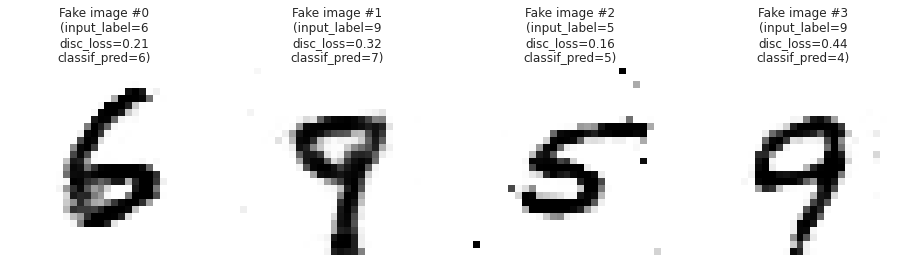


Epoch 00191: saving model to ./weights/cgan_pretrained=False_checkpoints.191.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0927 - discriminator_loss: 0.6032 - classifier_loss: 0.0000e+00
Epoch 192/200
468/468 [==============================] - ETA: 0s - generator_loss: 1.1108 - discriminator_loss: 0.6000 - classifier_loss: 0.0000e+00

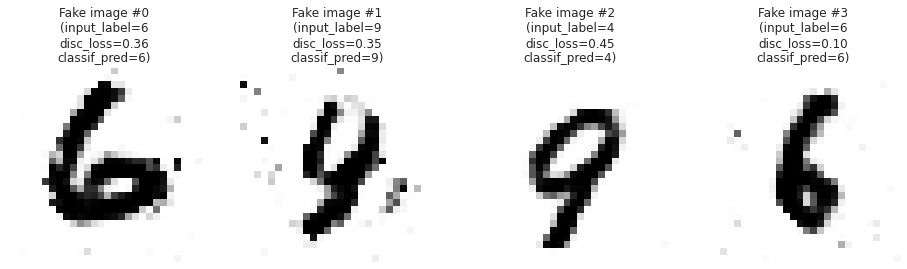


Epoch 00192: saving model to ./weights/cgan_pretrained=False_checkpoints.192.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1108 - discriminator_loss: 0.6000 - classifier_loss: 0.0000e+00
Epoch 193/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1116 - discriminator_loss: 0.6010 - classifier_loss: 0.0000e+00

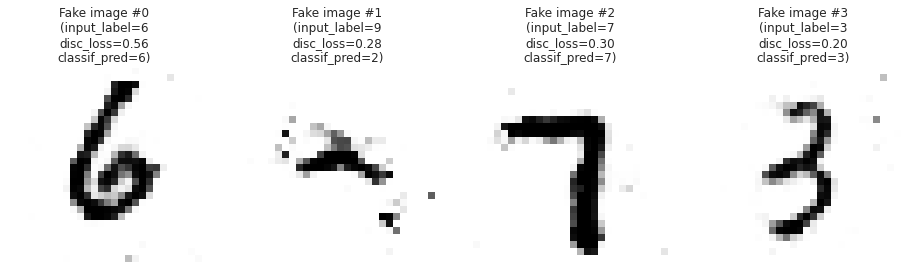


Epoch 00193: saving model to ./weights/cgan_pretrained=False_checkpoints.193.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1117 - discriminator_loss: 0.6015 - classifier_loss: 0.0000e+00
Epoch 194/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0957 - discriminator_loss: 0.6018 - classifier_loss: 0.0000e+00

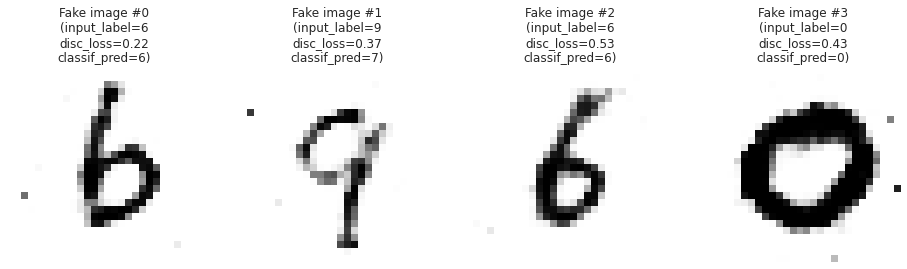


Epoch 00194: saving model to ./weights/cgan_pretrained=False_checkpoints.194.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0961 - discriminator_loss: 0.6019 - classifier_loss: 0.0000e+00
Epoch 195/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0978 - discriminator_loss: 0.6024 - classifier_loss: 0.0000e+00

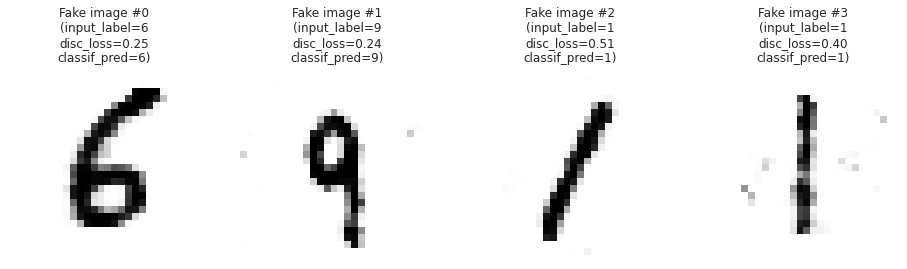


Epoch 00195: saving model to ./weights/cgan_pretrained=False_checkpoints.195.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.0985 - discriminator_loss: 0.6024 - classifier_loss: 0.0000e+00
Epoch 196/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0969 - discriminator_loss: 0.6036 - classifier_loss: 0.0000e+00

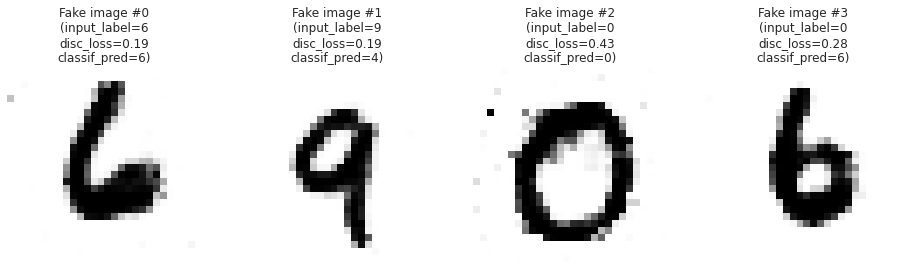


Epoch 00196: saving model to ./weights/cgan_pretrained=False_checkpoints.196.h5
468/468 [==============================] - 10s 22ms/step - generator_loss: 1.0977 - discriminator_loss: 0.6036 - classifier_loss: 0.0000e+00
Epoch 197/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1020 - discriminator_loss: 0.6015 - classifier_loss: 0.0000e+00

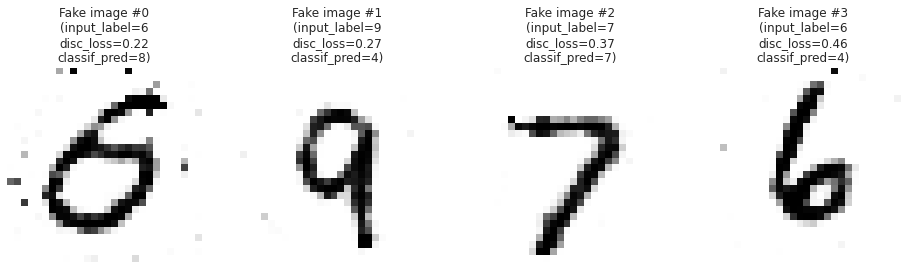


Epoch 00197: saving model to ./weights/cgan_pretrained=False_checkpoints.197.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1029 - discriminator_loss: 0.6016 - classifier_loss: 0.0000e+00
Epoch 198/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1110 - discriminator_loss: 0.6004 - classifier_loss: 0.0000e+00

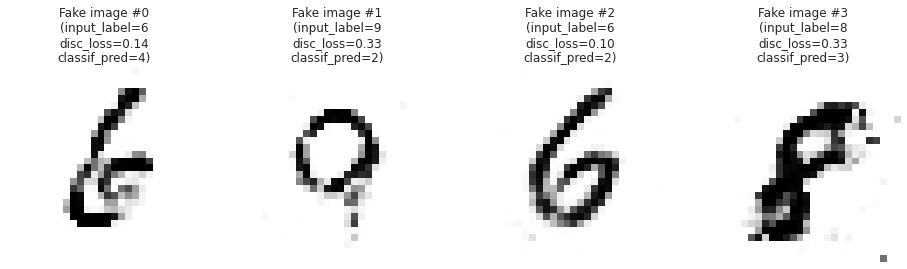


Epoch 00198: saving model to ./weights/cgan_pretrained=False_checkpoints.198.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1115 - discriminator_loss: 0.6005 - classifier_loss: 0.0000e+00
Epoch 199/200
468/468 [==============================] - ETA: 0s - generator_loss: 1.1125 - discriminator_loss: 0.5991 - classifier_loss: 0.0000e+00

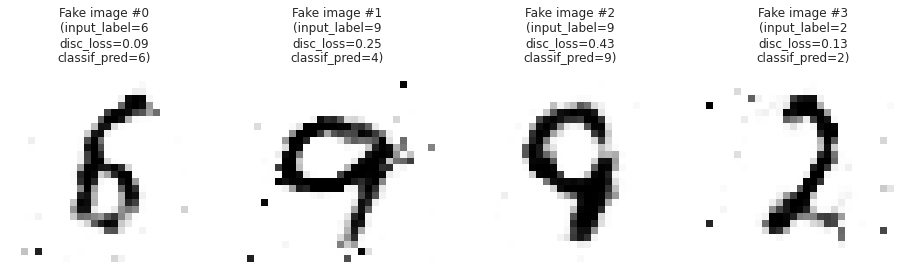


Epoch 00199: saving model to ./weights/cgan_pretrained=False_checkpoints.199.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1126 - discriminator_loss: 0.5992 - classifier_loss: 0.0000e+00
Epoch 200/200
466/468 [============================>.] - ETA: 0s - generator_loss: 1.1141 - discriminator_loss: 0.6016 - classifier_loss: 0.0000e+00

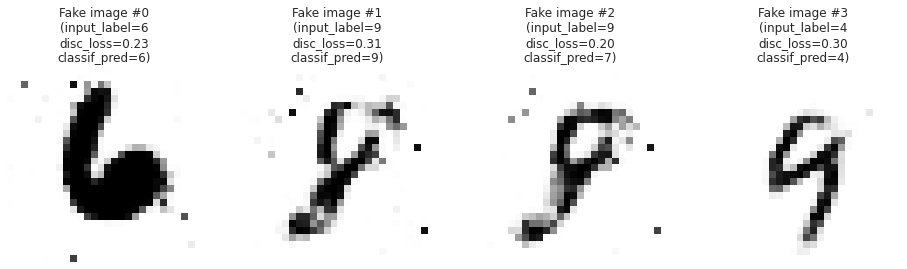


Epoch 00200: saving model to ./weights/cgan_pretrained=False_checkpoints.200.h5
468/468 [==============================] - 10s 21ms/step - generator_loss: 1.1143 - discriminator_loss: 0.6015 - classifier_loss: 0.0000e+00


In [ ]:
if TRAIN_CGAN:

    print(f"CGAN_EPOCHS={CGAN_EPOCHS}")
    print(f"Training cGAN with classifier (pretraining phase)")
    
    from tensorflow.keras import backend as K
    K.clear_session()
    
    ####
    # PRETRAINING PHASE (of the cGAN)
    ####
    
    # "Before starting the joint training procedure, 
    # we also need to train a cGAN on the noisy target distribution, as in the previous section. 
    # This is necessary because we will train C on generated data, 
    # and thus starting with randomly initialized G and D would result in a random classifier C,
    # and consequently in non-informative pseudo-labels."
    
    gangan.pretrained = False  # <========================================== FALSE!
    print(f"pretrained={gangan.pretrained}")
    
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint("./weights/cgan_pretrained=False_checkpoints.{epoch:03d}.h5", verbose=VERBOSE) 
    
    gangan.fit(
        tf.data.Dataset.zip((mnist_x_train_dataset, mnist_y_train_dataset)),  # mnist_y_train_dataset won't be used as classifier is not None!
        epochs=CGAN_EPOCHS * 2,
        callbacks=[gangan_plotter, checkpoint],
        verbose=VERBOSE,
    )

#### Phase 2) Alternative training of Classifier, Generator and Discriminator

Training cGAN with classifier (combined/alternate trainings)
Loading checkpoint 'classifier.196.h5'
Loading checkpoint 'cgan_pretrained=False_checkpoints.200.h5'
status=None
pretrained=True
Epoch 1/100
Train classifier
Train classifier
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0966 - discriminator_loss: 0.6102 - classifier_loss: 1.4913

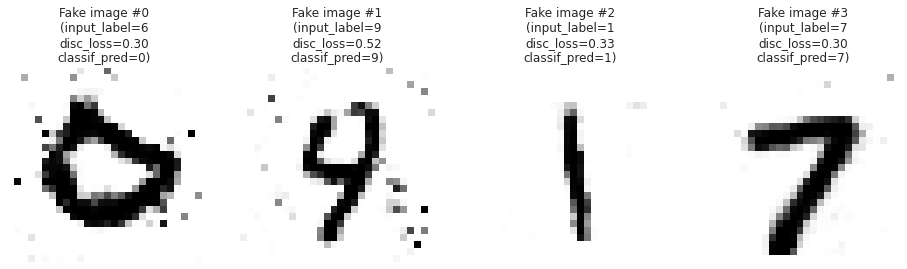


Epoch 00001: saving model to ./weights/cgan_pretrained=True_checkpoints.001.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0971 - discriminator_loss: 0.6103 - classifier_loss: 1.4886
Epoch 2/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0809 - discriminator_loss: 0.6166 - classifier_loss: 0.8566

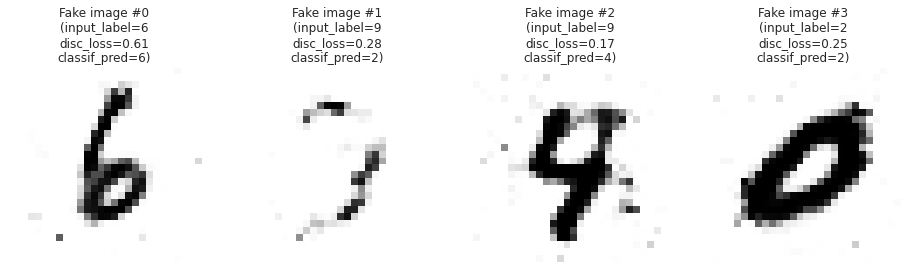


Epoch 00002: saving model to ./weights/cgan_pretrained=True_checkpoints.002.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0810 - discriminator_loss: 0.6167 - classifier_loss: 0.8578
Epoch 3/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0778 - discriminator_loss: 0.6173 - classifier_loss: 0.6958

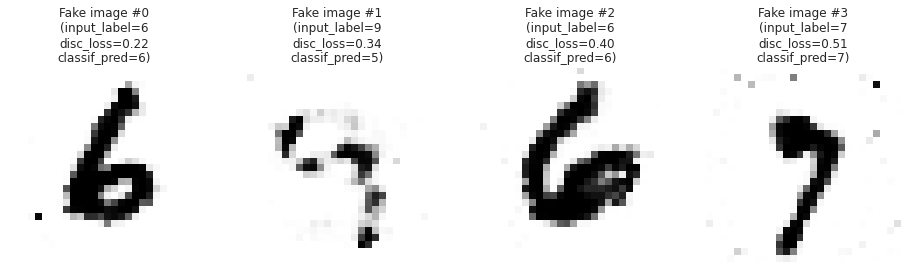


Epoch 00003: saving model to ./weights/cgan_pretrained=True_checkpoints.003.h5
468/468 [==============================] - 13s 29ms/step - generator_loss: 1.0783 - discriminator_loss: 0.6171 - classifier_loss: 0.6965
Epoch 4/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0625 - discriminator_loss: 0.6197 - classifier_loss: 0.5471

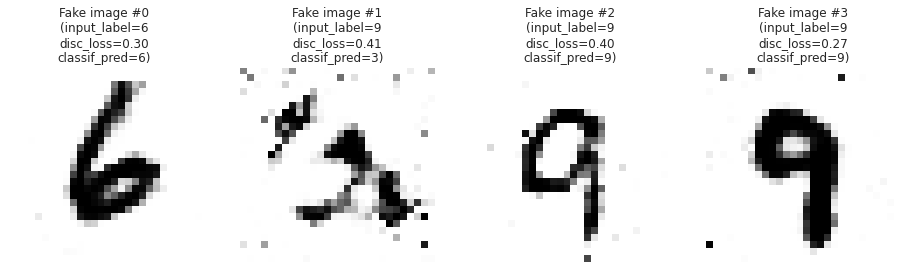


Epoch 00004: saving model to ./weights/cgan_pretrained=True_checkpoints.004.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0625 - discriminator_loss: 0.6198 - classifier_loss: 0.5469
Epoch 5/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0464 - discriminator_loss: 0.6227 - classifier_loss: 0.4510

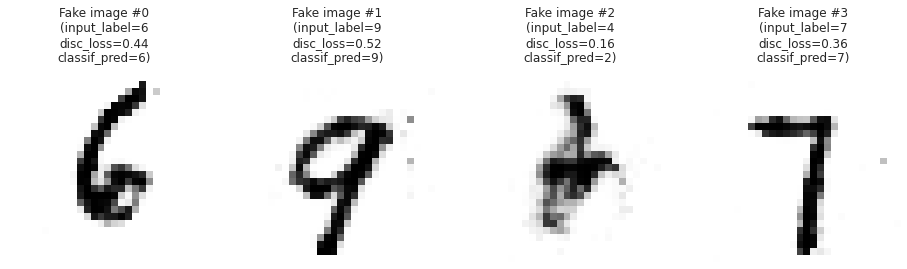


Epoch 00005: saving model to ./weights/cgan_pretrained=True_checkpoints.005.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0465 - discriminator_loss: 0.6228 - classifier_loss: 0.4509
Epoch 6/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0515 - discriminator_loss: 0.6198 - classifier_loss: 0.3849

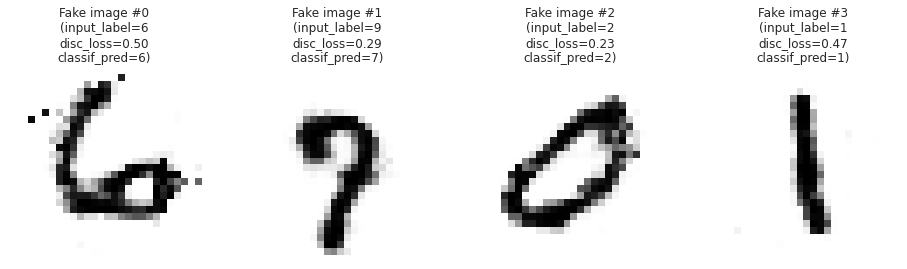


Epoch 00006: saving model to ./weights/cgan_pretrained=True_checkpoints.006.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0516 - discriminator_loss: 0.6198 - classifier_loss: 0.3849
Epoch 7/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0507 - discriminator_loss: 0.6206 - classifier_loss: 0.3439

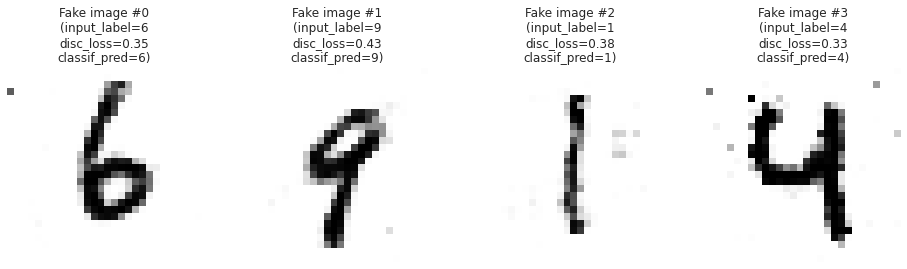


Epoch 00007: saving model to ./weights/cgan_pretrained=True_checkpoints.007.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0508 - discriminator_loss: 0.6208 - classifier_loss: 0.3439
Epoch 8/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0507 - discriminator_loss: 0.6196 - classifier_loss: 0.2854

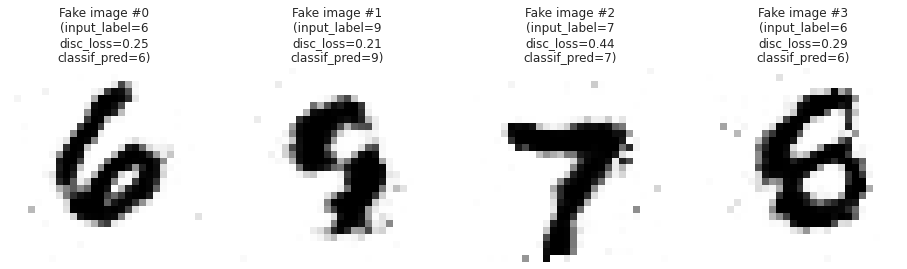


Epoch 00008: saving model to ./weights/cgan_pretrained=True_checkpoints.008.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0506 - discriminator_loss: 0.6197 - classifier_loss: 0.2852
Epoch 9/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0421 - discriminator_loss: 0.6205 - classifier_loss: 0.2421

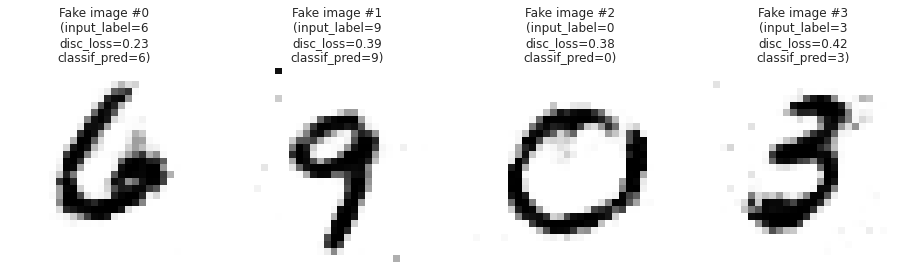


Epoch 00009: saving model to ./weights/cgan_pretrained=True_checkpoints.009.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0426 - discriminator_loss: 0.6205 - classifier_loss: 0.2418
Epoch 10/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0441 - discriminator_loss: 0.6210 - classifier_loss: 0.2195

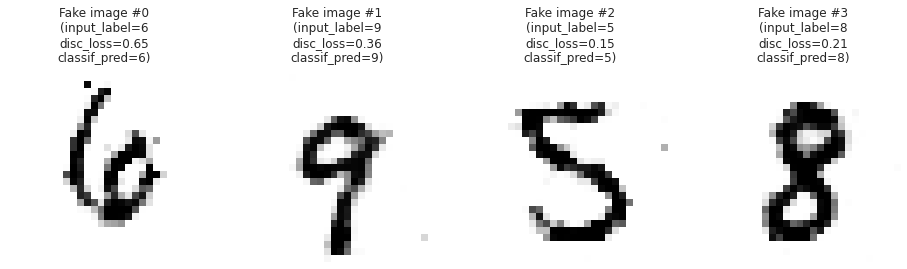


Epoch 00010: saving model to ./weights/cgan_pretrained=True_checkpoints.010.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0441 - discriminator_loss: 0.6212 - classifier_loss: 0.2194
Epoch 11/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0420 - discriminator_loss: 0.6209 - classifier_loss: 0.2029

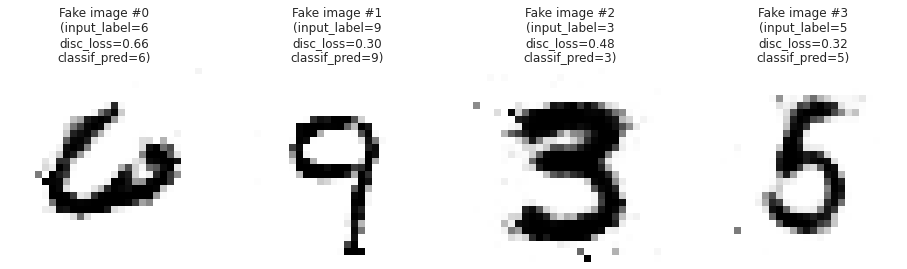


Epoch 00011: saving model to ./weights/cgan_pretrained=True_checkpoints.011.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0417 - discriminator_loss: 0.6211 - classifier_loss: 0.2028
Epoch 12/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0294 - discriminator_loss: 0.6224 - classifier_loss: 0.1779

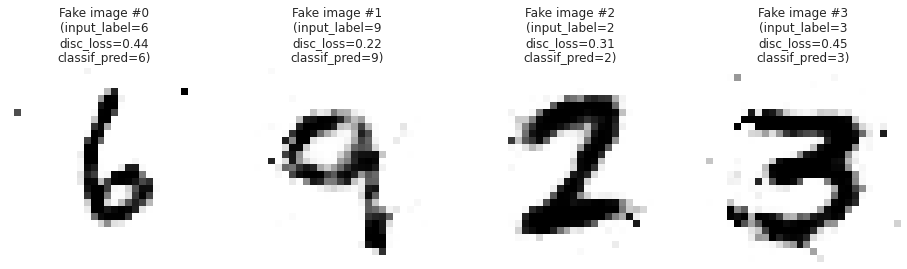


Epoch 00012: saving model to ./weights/cgan_pretrained=True_checkpoints.012.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0299 - discriminator_loss: 0.6226 - classifier_loss: 0.1780
Epoch 13/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0243 - discriminator_loss: 0.6269 - classifier_loss: 0.1762

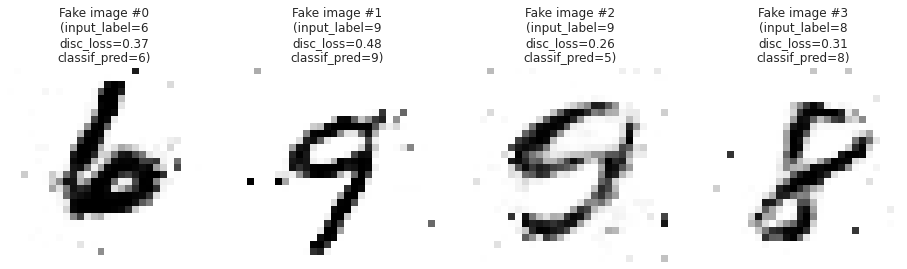


Epoch 00013: saving model to ./weights/cgan_pretrained=True_checkpoints.013.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0243 - discriminator_loss: 0.6269 - classifier_loss: 0.1760
Epoch 14/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0320 - discriminator_loss: 0.6203 - classifier_loss: 0.1420

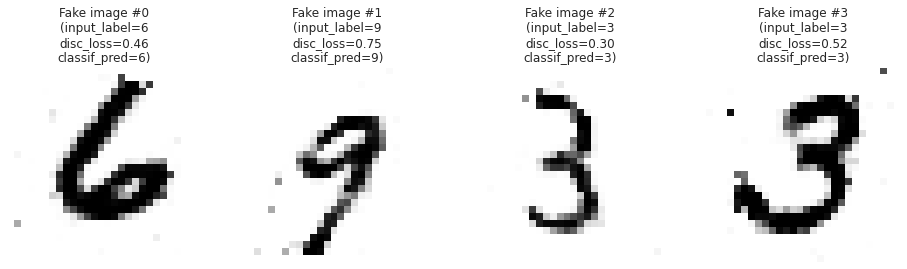


Epoch 00014: saving model to ./weights/cgan_pretrained=True_checkpoints.014.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0324 - discriminator_loss: 0.6205 - classifier_loss: 0.1416
Epoch 15/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0363 - discriminator_loss: 0.6199 - classifier_loss: 0.1195

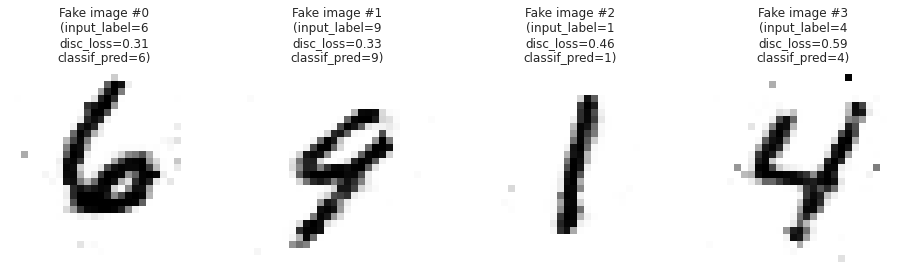


Epoch 00015: saving model to ./weights/cgan_pretrained=True_checkpoints.015.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0369 - discriminator_loss: 0.6199 - classifier_loss: 0.1197
Epoch 16/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0230 - discriminator_loss: 0.6258 - classifier_loss: 0.1298

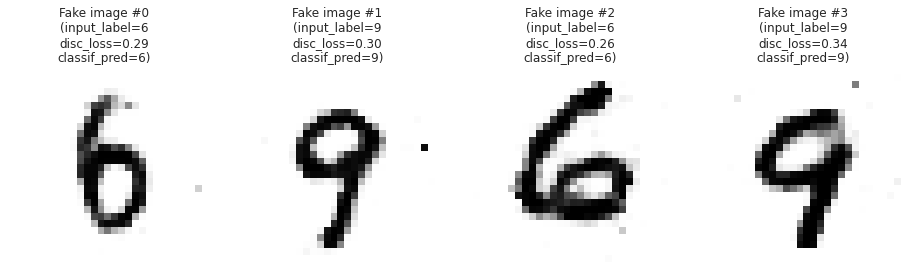


Epoch 00016: saving model to ./weights/cgan_pretrained=True_checkpoints.016.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0231 - discriminator_loss: 0.6258 - classifier_loss: 0.1297
Epoch 17/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0244 - discriminator_loss: 0.6231 - classifier_loss: 0.1226

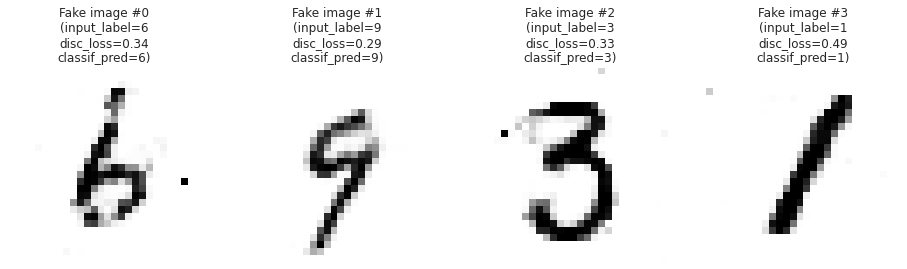


Epoch 00017: saving model to ./weights/cgan_pretrained=True_checkpoints.017.h5
468/468 [==============================] - 13s 29ms/step - generator_loss: 1.0246 - discriminator_loss: 0.6229 - classifier_loss: 0.1227
Epoch 18/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0347 - discriminator_loss: 0.6203 - classifier_loss: 0.1191

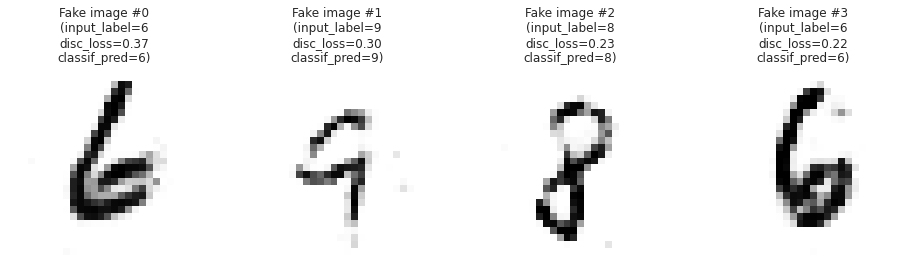


Epoch 00018: saving model to ./weights/cgan_pretrained=True_checkpoints.018.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0350 - discriminator_loss: 0.6206 - classifier_loss: 0.1191
Epoch 19/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0252 - discriminator_loss: 0.6217 - classifier_loss: 0.1038

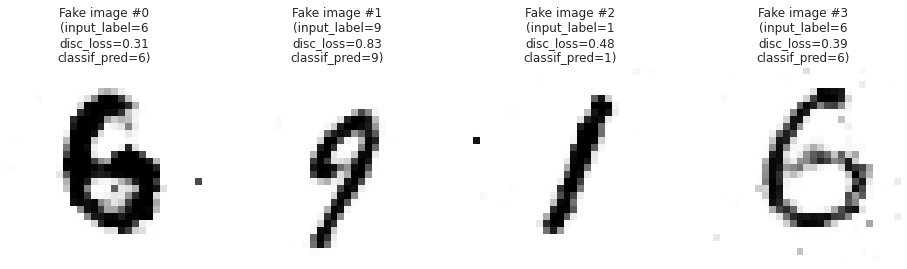


Epoch 00019: saving model to ./weights/cgan_pretrained=True_checkpoints.019.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0250 - discriminator_loss: 0.6216 - classifier_loss: 0.1038
Epoch 20/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0265 - discriminator_loss: 0.6219 - classifier_loss: 0.1027

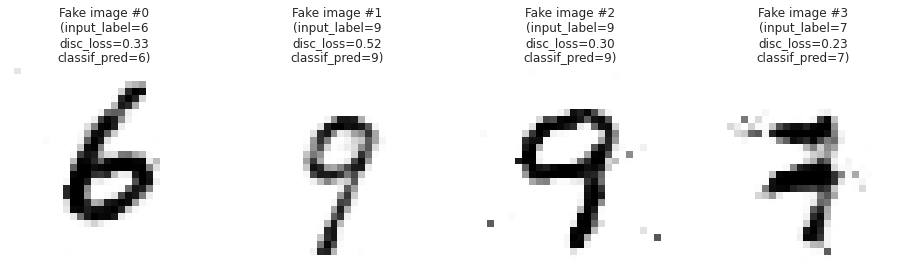


Epoch 00020: saving model to ./weights/cgan_pretrained=True_checkpoints.020.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0266 - discriminator_loss: 0.6219 - classifier_loss: 0.1026
Epoch 21/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0223 - discriminator_loss: 0.6224 - classifier_loss: 0.0911

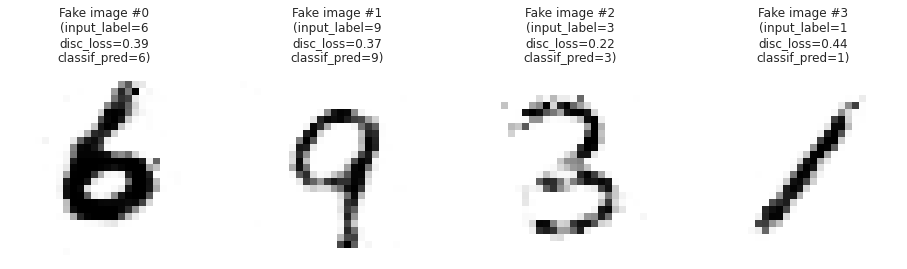


Epoch 00021: saving model to ./weights/cgan_pretrained=True_checkpoints.021.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0224 - discriminator_loss: 0.6225 - classifier_loss: 0.0909
Epoch 22/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0252 - discriminator_loss: 0.6228 - classifier_loss: 0.0902

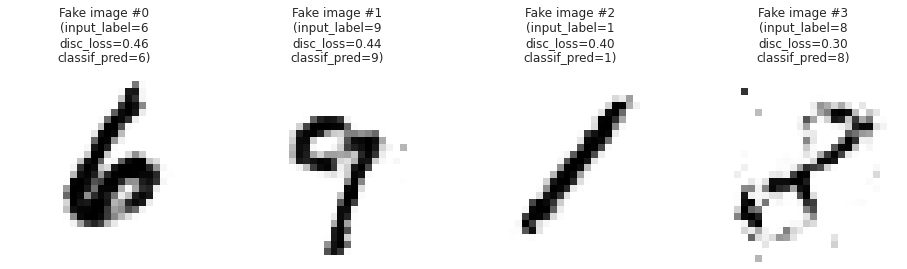


Epoch 00022: saving model to ./weights/cgan_pretrained=True_checkpoints.022.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0255 - discriminator_loss: 0.6230 - classifier_loss: 0.0901
Epoch 23/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0141 - discriminator_loss: 0.6257 - classifier_loss: 0.0742

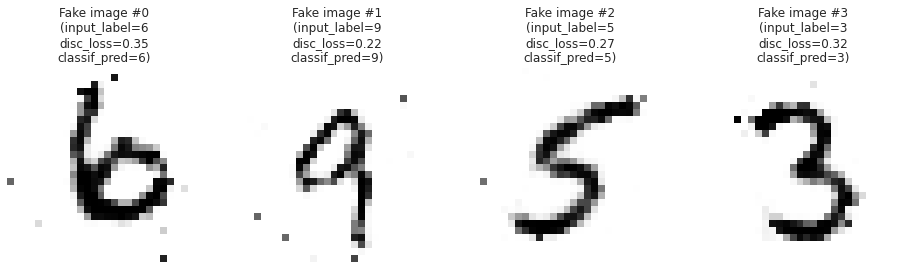


Epoch 00023: saving model to ./weights/cgan_pretrained=True_checkpoints.023.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0143 - discriminator_loss: 0.6257 - classifier_loss: 0.0741
Epoch 24/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0117 - discriminator_loss: 0.6267 - classifier_loss: 0.0755

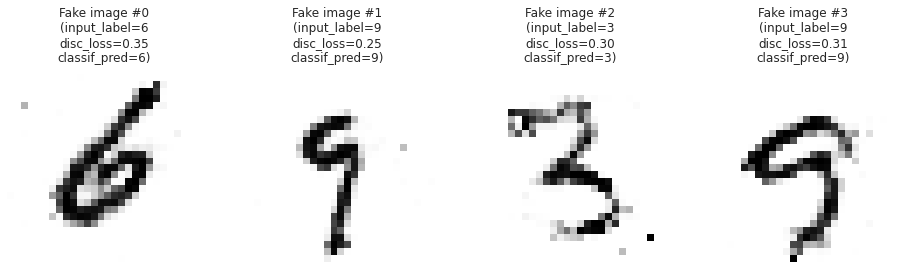


Epoch 00024: saving model to ./weights/cgan_pretrained=True_checkpoints.024.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0118 - discriminator_loss: 0.6268 - classifier_loss: 0.0755
Epoch 25/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0116 - discriminator_loss: 0.6257 - classifier_loss: 0.0778

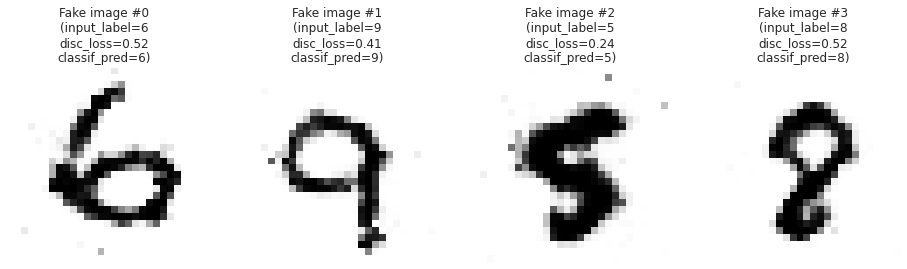


Epoch 00025: saving model to ./weights/cgan_pretrained=True_checkpoints.025.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0119 - discriminator_loss: 0.6257 - classifier_loss: 0.0778
Epoch 26/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0224 - discriminator_loss: 0.6237 - classifier_loss: 0.0747

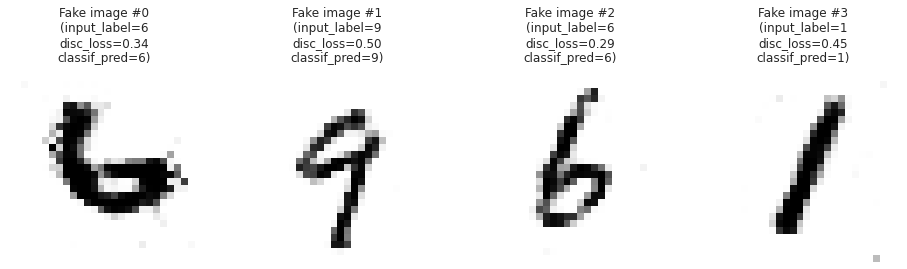


Epoch 00026: saving model to ./weights/cgan_pretrained=True_checkpoints.026.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0226 - discriminator_loss: 0.6238 - classifier_loss: 0.0748
Epoch 27/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0144 - discriminator_loss: 0.6247 - classifier_loss: 0.0823

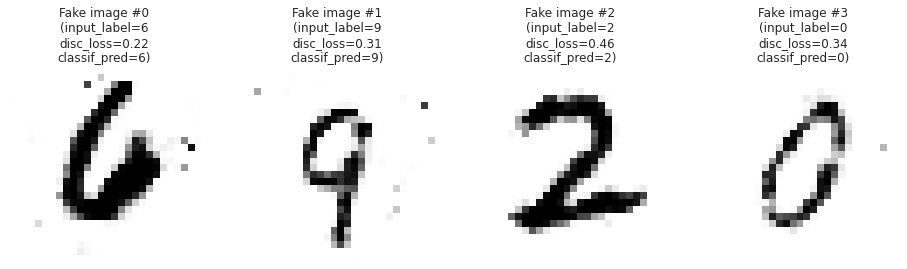


Epoch 00027: saving model to ./weights/cgan_pretrained=True_checkpoints.027.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0145 - discriminator_loss: 0.6247 - classifier_loss: 0.0823
Epoch 28/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0138 - discriminator_loss: 0.6256 - classifier_loss: 0.0727

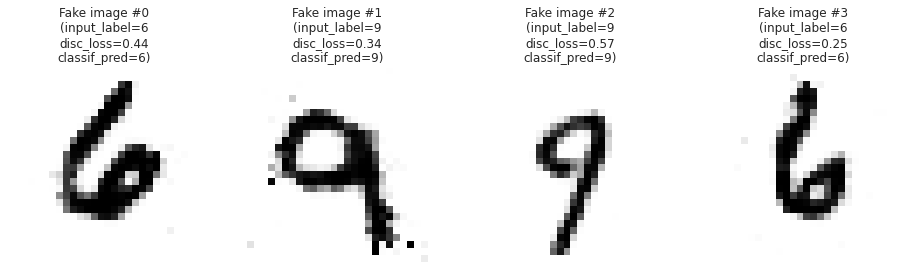


Epoch 00028: saving model to ./weights/cgan_pretrained=True_checkpoints.028.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0139 - discriminator_loss: 0.6256 - classifier_loss: 0.0726
Epoch 29/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0244 - discriminator_loss: 0.6214 - classifier_loss: 0.0775

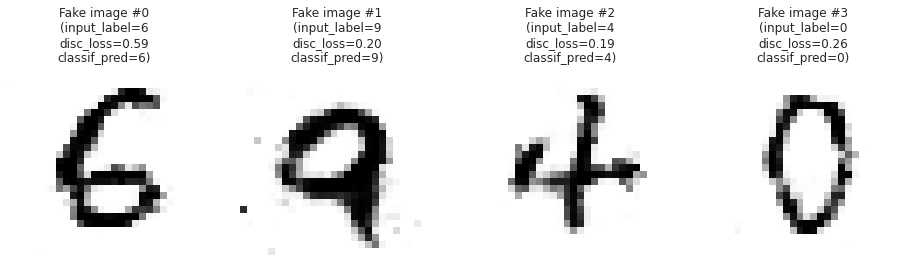


Epoch 00029: saving model to ./weights/cgan_pretrained=True_checkpoints.029.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0243 - discriminator_loss: 0.6215 - classifier_loss: 0.0775
Epoch 30/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0249 - discriminator_loss: 0.6228 - classifier_loss: 0.0673

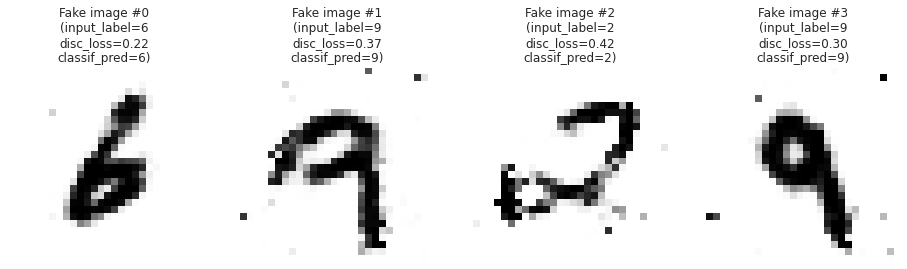


Epoch 00030: saving model to ./weights/cgan_pretrained=True_checkpoints.030.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0248 - discriminator_loss: 0.6229 - classifier_loss: 0.0674
Epoch 31/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0268 - discriminator_loss: 0.6231 - classifier_loss: 0.0740

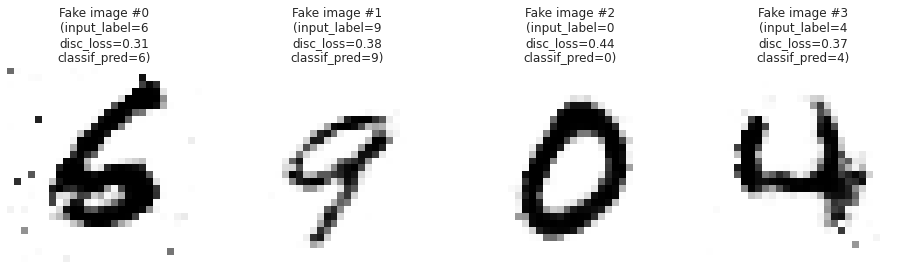


Epoch 00031: saving model to ./weights/cgan_pretrained=True_checkpoints.031.h5
468/468 [==============================] - 13s 29ms/step - generator_loss: 1.0270 - discriminator_loss: 0.6233 - classifier_loss: 0.0740
Epoch 32/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0397 - discriminator_loss: 0.6182 - classifier_loss: 0.0689

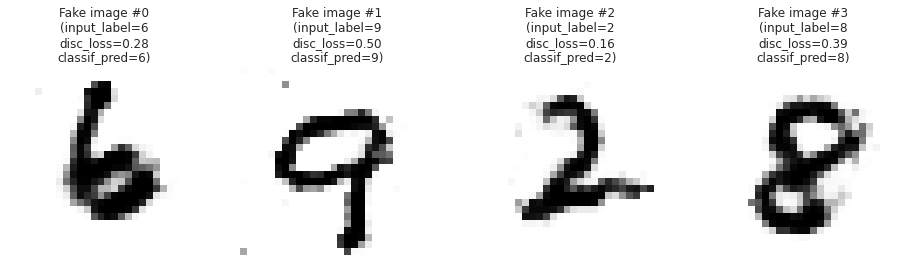


Epoch 00032: saving model to ./weights/cgan_pretrained=True_checkpoints.032.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0398 - discriminator_loss: 0.6184 - classifier_loss: 0.0691
Epoch 33/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0196 - discriminator_loss: 0.6232 - classifier_loss: 0.0714

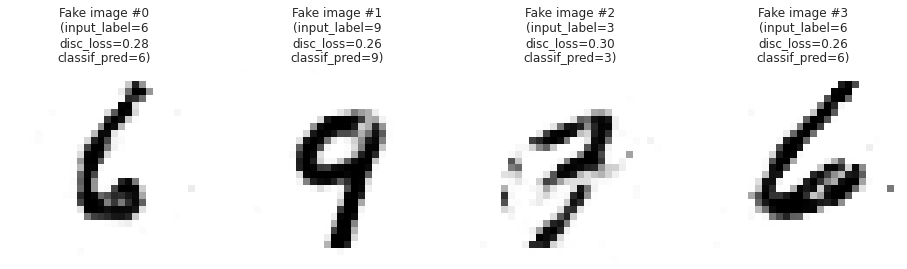


Epoch 00033: saving model to ./weights/cgan_pretrained=True_checkpoints.033.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0201 - discriminator_loss: 0.6234 - classifier_loss: 0.0715
Epoch 34/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0165 - discriminator_loss: 0.6249 - classifier_loss: 0.0617

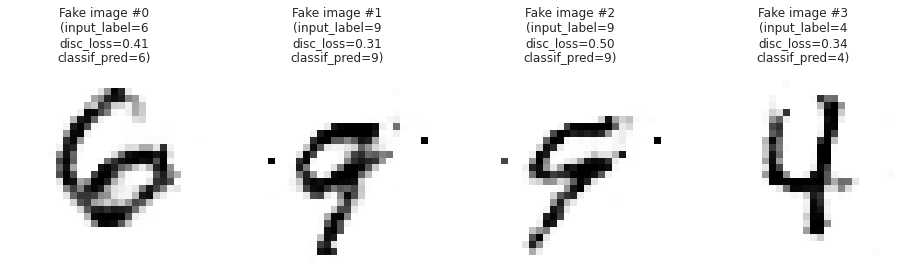


Epoch 00034: saving model to ./weights/cgan_pretrained=True_checkpoints.034.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0163 - discriminator_loss: 0.6252 - classifier_loss: 0.0615
Epoch 35/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0123 - discriminator_loss: 0.6254 - classifier_loss: 0.0585

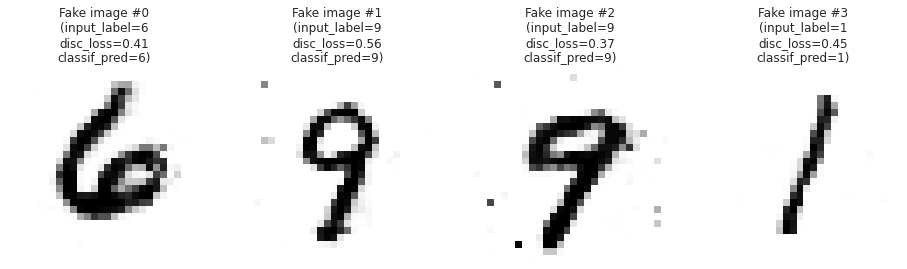


Epoch 00035: saving model to ./weights/cgan_pretrained=True_checkpoints.035.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0124 - discriminator_loss: 0.6256 - classifier_loss: 0.0584
Epoch 36/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0212 - discriminator_loss: 0.6242 - classifier_loss: 0.0667

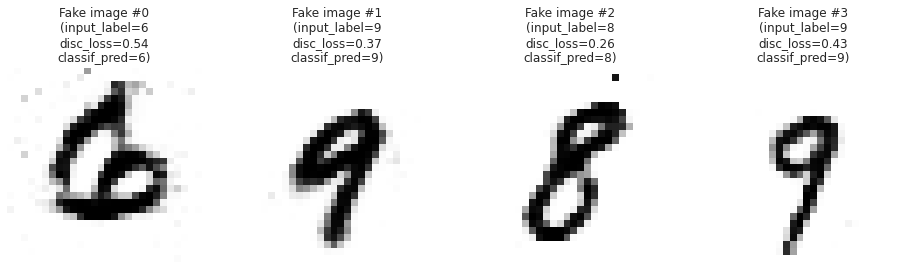


Epoch 00036: saving model to ./weights/cgan_pretrained=True_checkpoints.036.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0213 - discriminator_loss: 0.6242 - classifier_loss: 0.0668
Epoch 37/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0157 - discriminator_loss: 0.6256 - classifier_loss: 0.0559

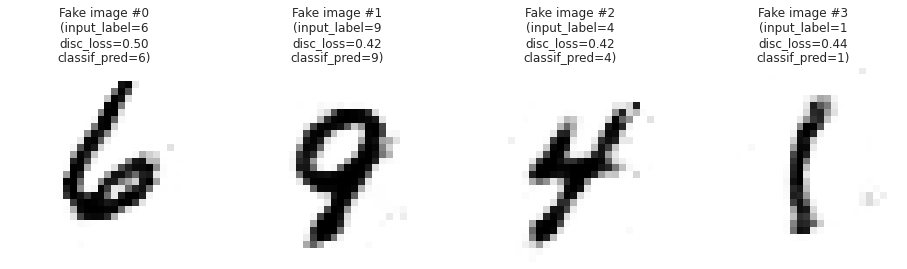


Epoch 00037: saving model to ./weights/cgan_pretrained=True_checkpoints.037.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0156 - discriminator_loss: 0.6257 - classifier_loss: 0.0560
Epoch 38/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0184 - discriminator_loss: 0.6249 - classifier_loss: 0.0491

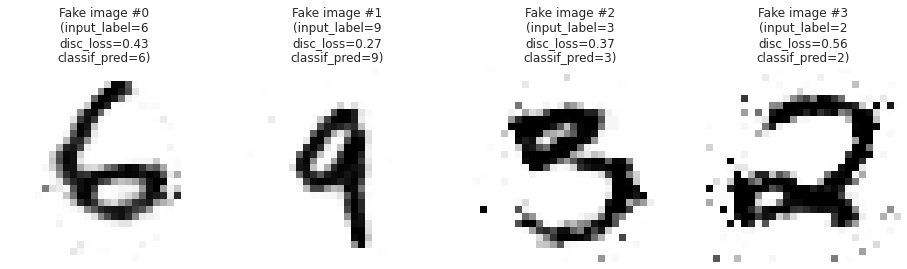


Epoch 00038: saving model to ./weights/cgan_pretrained=True_checkpoints.038.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0182 - discriminator_loss: 0.6250 - classifier_loss: 0.0493
Epoch 39/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0189 - discriminator_loss: 0.6241 - classifier_loss: 0.0526

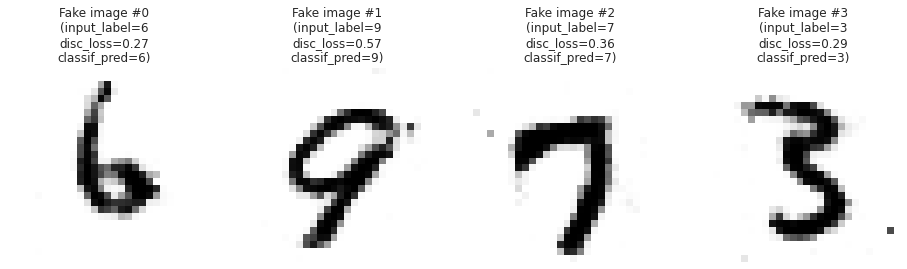


Epoch 00039: saving model to ./weights/cgan_pretrained=True_checkpoints.039.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0191 - discriminator_loss: 0.6242 - classifier_loss: 0.0525
Epoch 40/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0135 - discriminator_loss: 0.6259 - classifier_loss: 0.0584

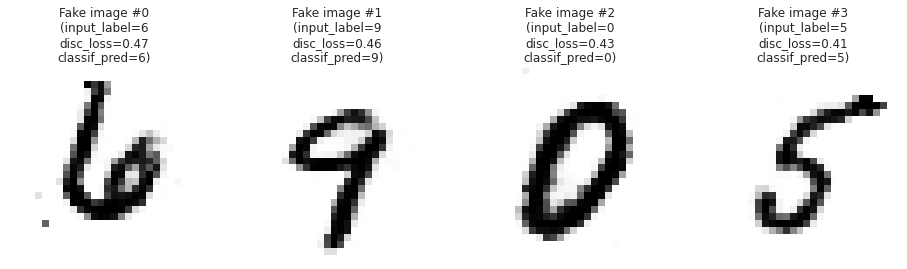


Epoch 00040: saving model to ./weights/cgan_pretrained=True_checkpoints.040.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0138 - discriminator_loss: 0.6260 - classifier_loss: 0.0582
Epoch 41/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0153 - discriminator_loss: 0.6243 - classifier_loss: 0.0551

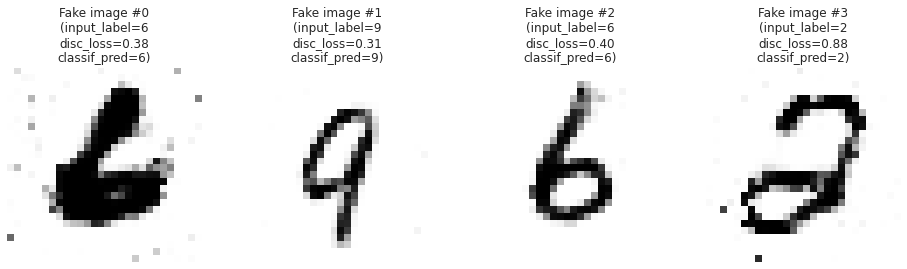


Epoch 00041: saving model to ./weights/cgan_pretrained=True_checkpoints.041.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0153 - discriminator_loss: 0.6244 - classifier_loss: 0.0551
Epoch 42/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0198 - discriminator_loss: 0.6242 - classifier_loss: 0.0474

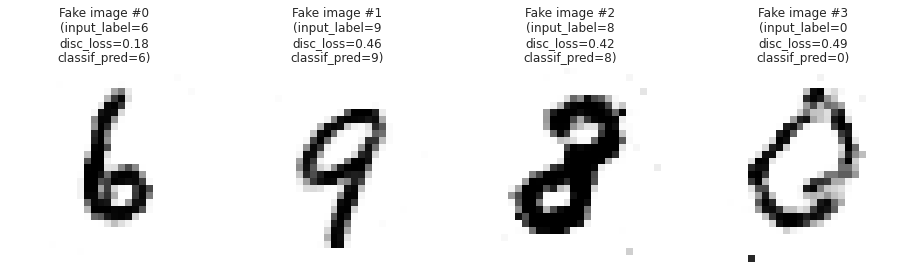


Epoch 00042: saving model to ./weights/cgan_pretrained=True_checkpoints.042.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0200 - discriminator_loss: 0.6245 - classifier_loss: 0.0474
Epoch 43/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0194 - discriminator_loss: 0.6257 - classifier_loss: 0.0533

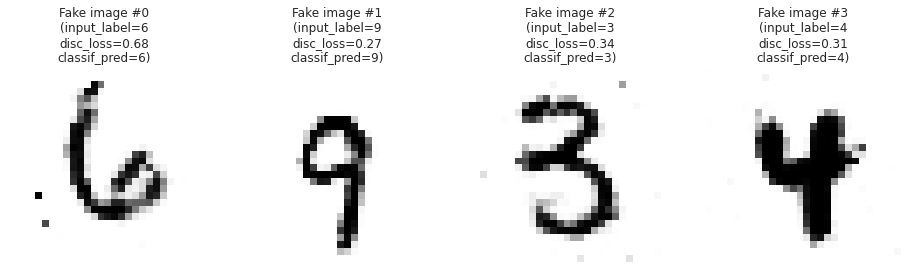


Epoch 00043: saving model to ./weights/cgan_pretrained=True_checkpoints.043.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0195 - discriminator_loss: 0.6258 - classifier_loss: 0.0534
Epoch 44/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0216 - discriminator_loss: 0.6241 - classifier_loss: 0.0446

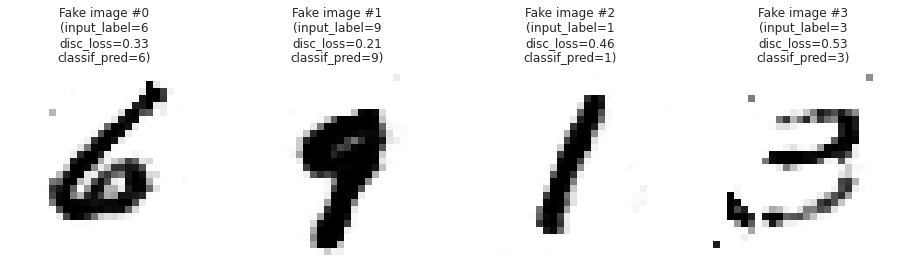


Epoch 00044: saving model to ./weights/cgan_pretrained=True_checkpoints.044.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0218 - discriminator_loss: 0.6241 - classifier_loss: 0.0447
Epoch 45/100
466/468 [============================>.] - ETA: 0s - generator_loss: 1.0305 - discriminator_loss: 0.6214 - classifier_loss: 0.0388

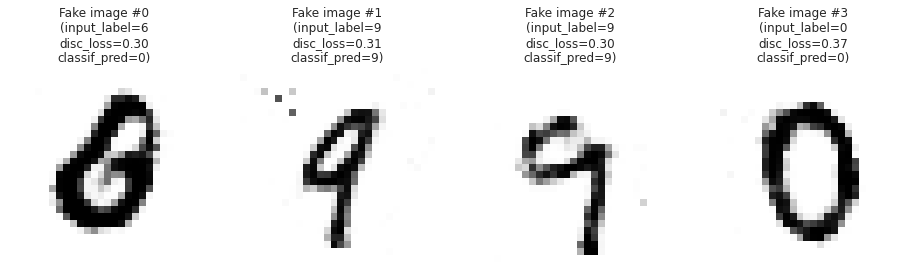


Epoch 00045: saving model to ./weights/cgan_pretrained=True_checkpoints.045.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0309 - discriminator_loss: 0.6214 - classifier_loss: 0.0388
Epoch 46/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0233 - discriminator_loss: 0.6233 - classifier_loss: 0.0404

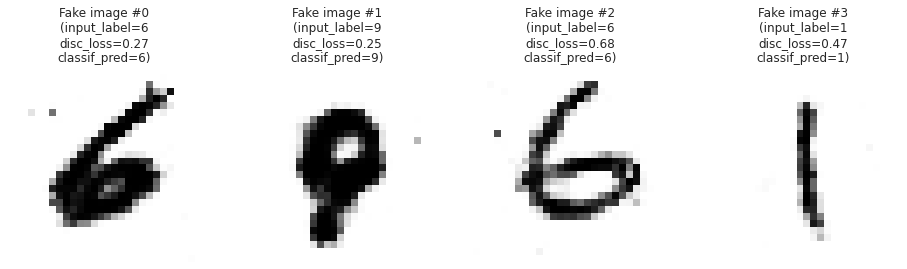


Epoch 00046: saving model to ./weights/cgan_pretrained=True_checkpoints.046.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0232 - discriminator_loss: 0.6234 - classifier_loss: 0.0404
Epoch 47/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0197 - discriminator_loss: 0.6243 - classifier_loss: 0.0391

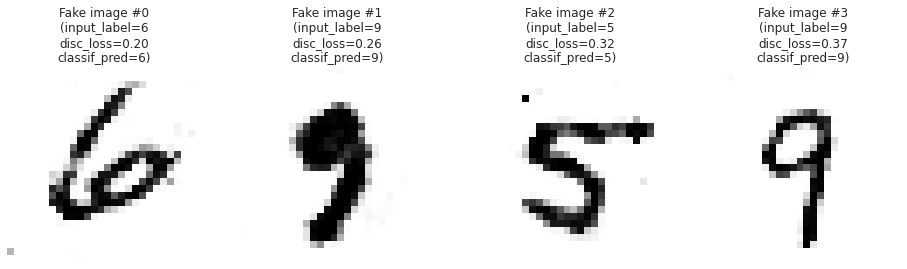


Epoch 00047: saving model to ./weights/cgan_pretrained=True_checkpoints.047.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0197 - discriminator_loss: 0.6244 - classifier_loss: 0.0391
Epoch 48/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0279 - discriminator_loss: 0.6221 - classifier_loss: 0.0435

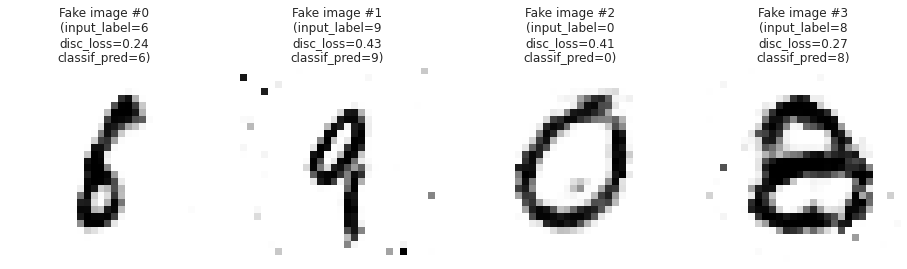


Epoch 00048: saving model to ./weights/cgan_pretrained=True_checkpoints.048.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0280 - discriminator_loss: 0.6224 - classifier_loss: 0.0434
Epoch 49/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0252 - discriminator_loss: 0.6226 - classifier_loss: 0.0445

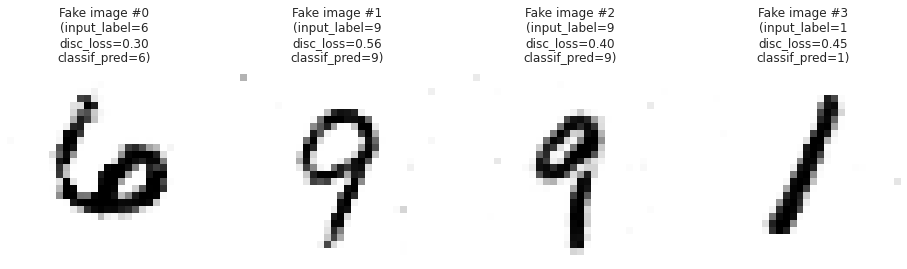


Epoch 00049: saving model to ./weights/cgan_pretrained=True_checkpoints.049.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0254 - discriminator_loss: 0.6227 - classifier_loss: 0.0445
Epoch 50/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0409 - discriminator_loss: 0.6220 - classifier_loss: 0.0482

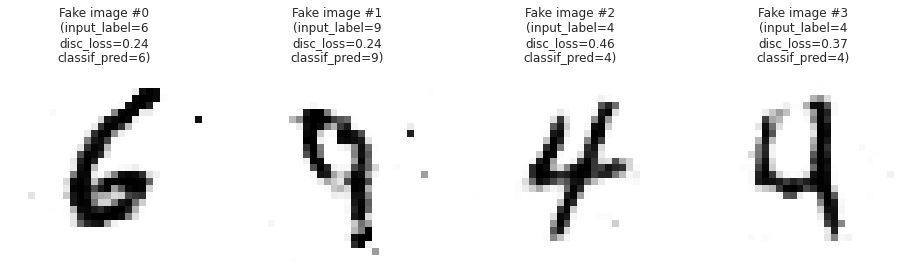


Epoch 00050: saving model to ./weights/cgan_pretrained=True_checkpoints.050.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0409 - discriminator_loss: 0.6221 - classifier_loss: 0.0481
Epoch 51/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0288 - discriminator_loss: 0.6238 - classifier_loss: 0.0381

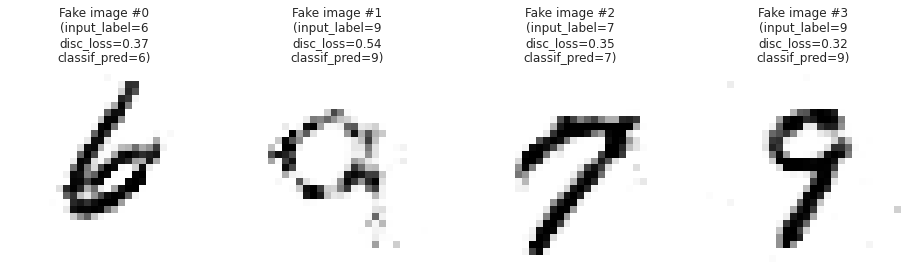


Epoch 00051: saving model to ./weights/cgan_pretrained=True_checkpoints.051.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0287 - discriminator_loss: 0.6240 - classifier_loss: 0.0380
Epoch 52/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0202 - discriminator_loss: 0.6276 - classifier_loss: 0.0409

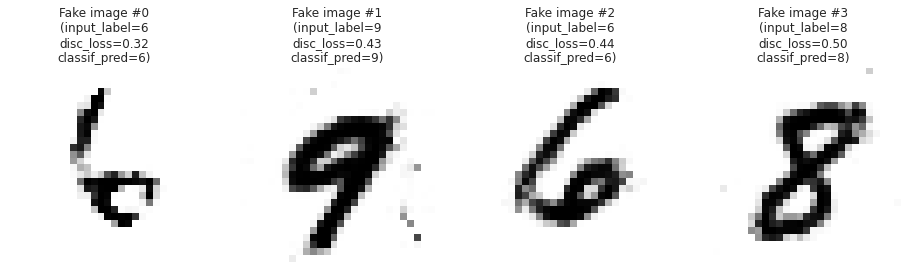


Epoch 00052: saving model to ./weights/cgan_pretrained=True_checkpoints.052.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0202 - discriminator_loss: 0.6278 - classifier_loss: 0.0411
Epoch 53/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0201 - discriminator_loss: 0.6239 - classifier_loss: 0.0389

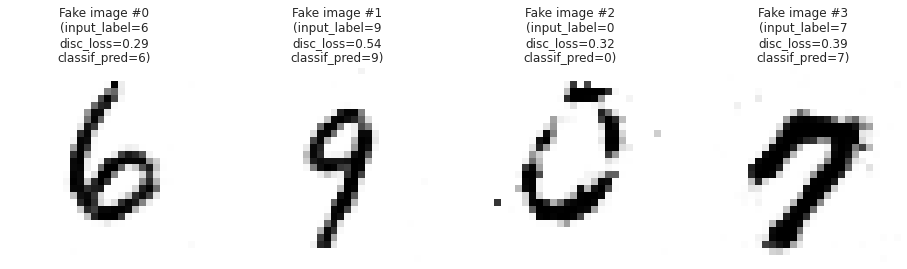


Epoch 00053: saving model to ./weights/cgan_pretrained=True_checkpoints.053.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0201 - discriminator_loss: 0.6241 - classifier_loss: 0.0389
Epoch 54/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0233 - discriminator_loss: 0.6238 - classifier_loss: 0.0437

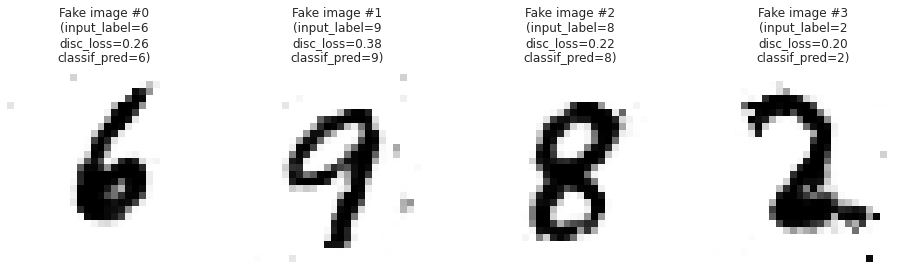


Epoch 00054: saving model to ./weights/cgan_pretrained=True_checkpoints.054.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0235 - discriminator_loss: 0.6240 - classifier_loss: 0.0437
Epoch 55/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0325 - discriminator_loss: 0.6220 - classifier_loss: 0.0417

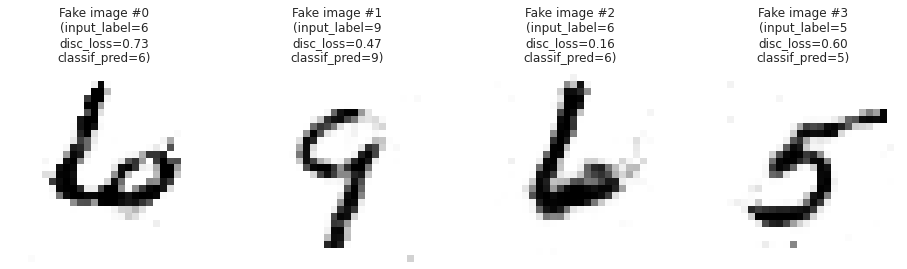


Epoch 00055: saving model to ./weights/cgan_pretrained=True_checkpoints.055.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0324 - discriminator_loss: 0.6223 - classifier_loss: 0.0417
Epoch 56/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0429 - discriminator_loss: 0.6207 - classifier_loss: 0.0383

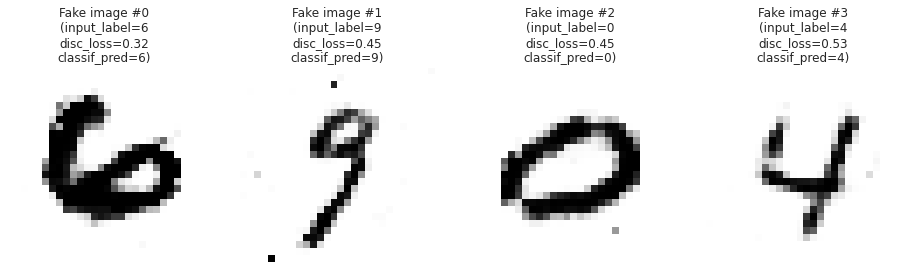


Epoch 00056: saving model to ./weights/cgan_pretrained=True_checkpoints.056.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0429 - discriminator_loss: 0.6210 - classifier_loss: 0.0385
Epoch 57/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0300 - discriminator_loss: 0.6259 - classifier_loss: 0.0366

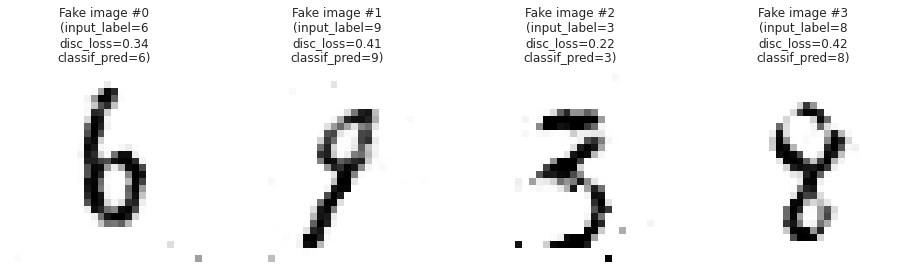


Epoch 00057: saving model to ./weights/cgan_pretrained=True_checkpoints.057.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0300 - discriminator_loss: 0.6260 - classifier_loss: 0.0366
Epoch 58/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0153 - discriminator_loss: 0.6261 - classifier_loss: 0.0310

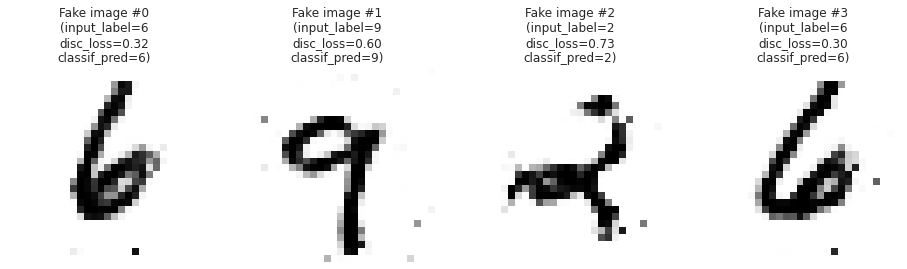


Epoch 00058: saving model to ./weights/cgan_pretrained=True_checkpoints.058.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0153 - discriminator_loss: 0.6261 - classifier_loss: 0.0310
Epoch 59/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0284 - discriminator_loss: 0.6238 - classifier_loss: 0.0332

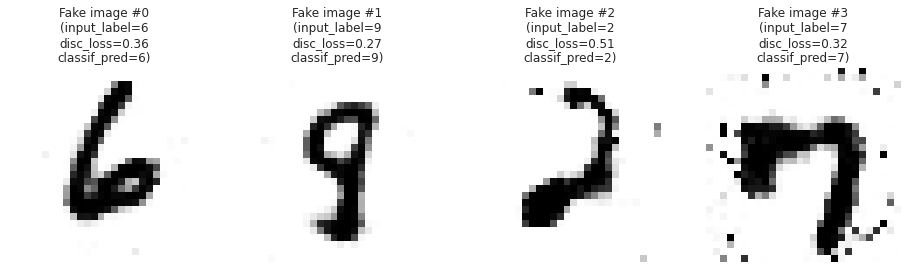


Epoch 00059: saving model to ./weights/cgan_pretrained=True_checkpoints.059.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0286 - discriminator_loss: 0.6239 - classifier_loss: 0.0333
Epoch 60/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0313 - discriminator_loss: 0.6226 - classifier_loss: 0.0325

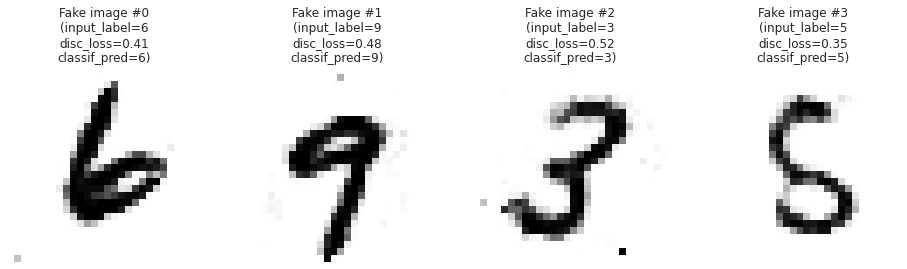


Epoch 00060: saving model to ./weights/cgan_pretrained=True_checkpoints.060.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0314 - discriminator_loss: 0.6227 - classifier_loss: 0.0326
Epoch 61/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0254 - discriminator_loss: 0.6256 - classifier_loss: 0.0334

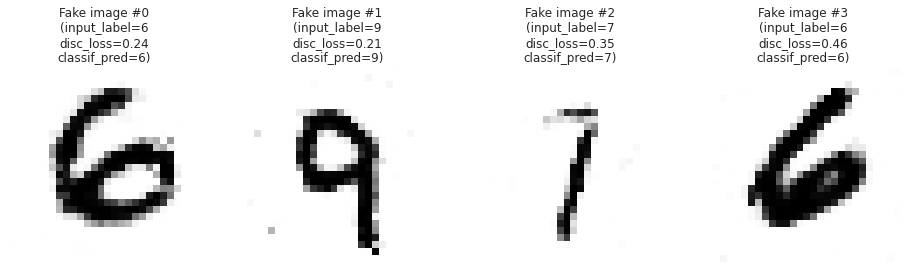


Epoch 00061: saving model to ./weights/cgan_pretrained=True_checkpoints.061.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0255 - discriminator_loss: 0.6257 - classifier_loss: 0.0333
Epoch 62/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0222 - discriminator_loss: 0.6261 - classifier_loss: 0.0386

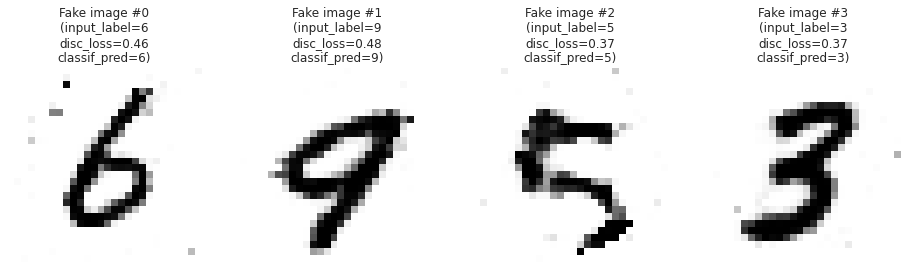


Epoch 00062: saving model to ./weights/cgan_pretrained=True_checkpoints.062.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0222 - discriminator_loss: 0.6262 - classifier_loss: 0.0385
Epoch 63/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0326 - discriminator_loss: 0.6221 - classifier_loss: 0.0357

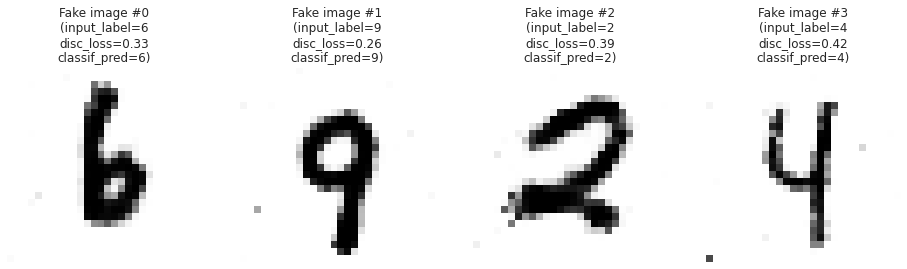


Epoch 00063: saving model to ./weights/cgan_pretrained=True_checkpoints.063.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0327 - discriminator_loss: 0.6223 - classifier_loss: 0.0356
Epoch 64/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0295 - discriminator_loss: 0.6229 - classifier_loss: 0.0356

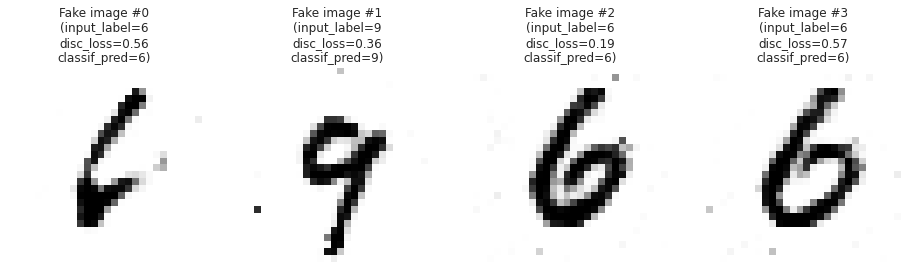


Epoch 00064: saving model to ./weights/cgan_pretrained=True_checkpoints.064.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0297 - discriminator_loss: 0.6231 - classifier_loss: 0.0356
Epoch 65/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0257 - discriminator_loss: 0.6244 - classifier_loss: 0.0383

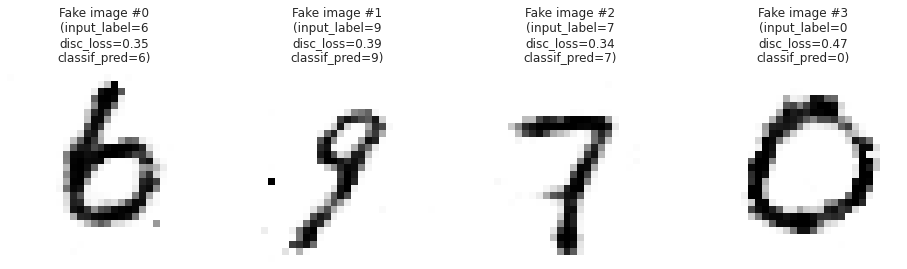


Epoch 00065: saving model to ./weights/cgan_pretrained=True_checkpoints.065.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0258 - discriminator_loss: 0.6246 - classifier_loss: 0.0382
Epoch 66/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0266 - discriminator_loss: 0.6243 - classifier_loss: 0.0305

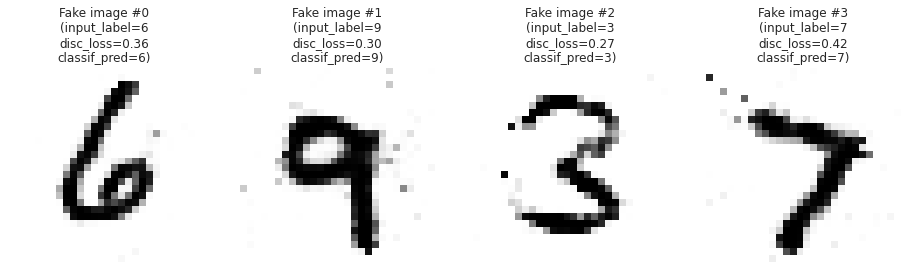


Epoch 00066: saving model to ./weights/cgan_pretrained=True_checkpoints.066.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0265 - discriminator_loss: 0.6244 - classifier_loss: 0.0305
Epoch 67/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0381 - discriminator_loss: 0.6202 - classifier_loss: 0.0304

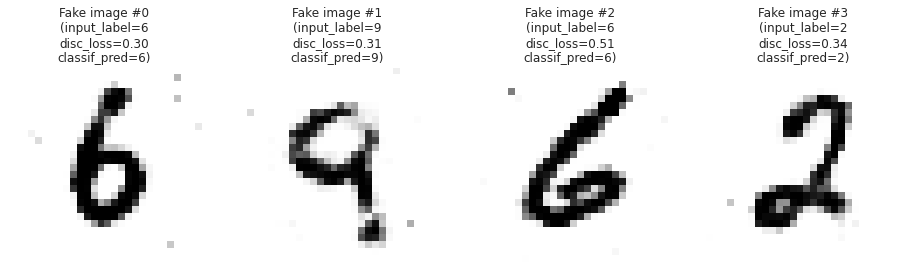


Epoch 00067: saving model to ./weights/cgan_pretrained=True_checkpoints.067.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0380 - discriminator_loss: 0.6202 - classifier_loss: 0.0303
Epoch 68/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0390 - discriminator_loss: 0.6218 - classifier_loss: 0.0349

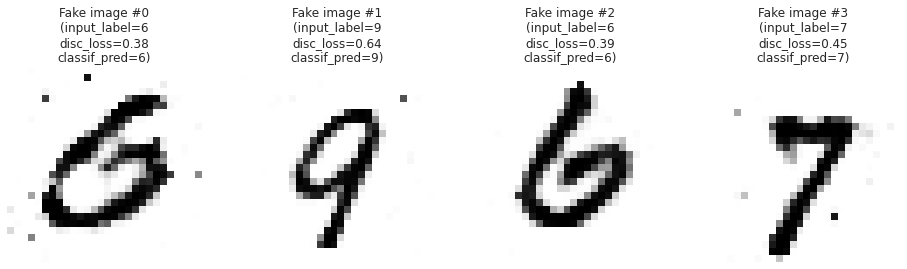


Epoch 00068: saving model to ./weights/cgan_pretrained=True_checkpoints.068.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0394 - discriminator_loss: 0.6218 - classifier_loss: 0.0351
Epoch 69/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0283 - discriminator_loss: 0.6239 - classifier_loss: 0.0359

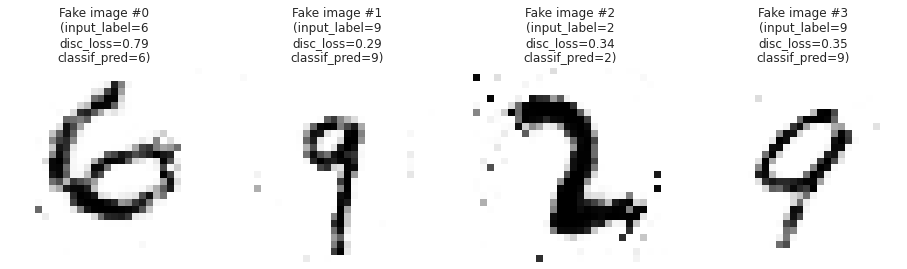


Epoch 00069: saving model to ./weights/cgan_pretrained=True_checkpoints.069.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0289 - discriminator_loss: 0.6241 - classifier_loss: 0.0359
Epoch 70/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0310 - discriminator_loss: 0.6236 - classifier_loss: 0.0346

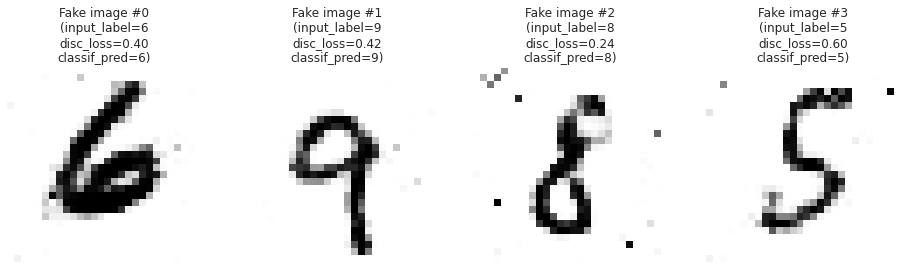


Epoch 00070: saving model to ./weights/cgan_pretrained=True_checkpoints.070.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0310 - discriminator_loss: 0.6237 - classifier_loss: 0.0347
Epoch 71/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0409 - discriminator_loss: 0.6193 - classifier_loss: 0.0349

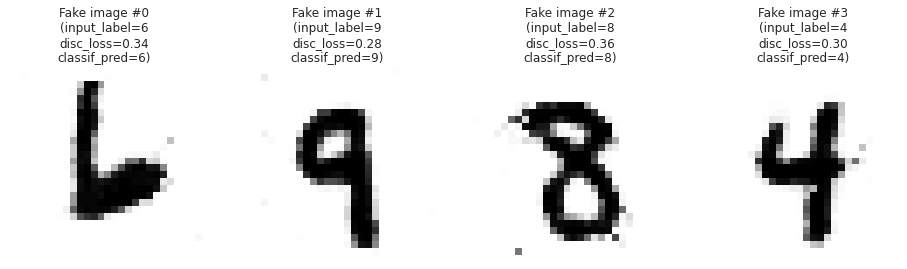


Epoch 00071: saving model to ./weights/cgan_pretrained=True_checkpoints.071.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0410 - discriminator_loss: 0.6195 - classifier_loss: 0.0348
Epoch 72/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0420 - discriminator_loss: 0.6208 - classifier_loss: 0.0315

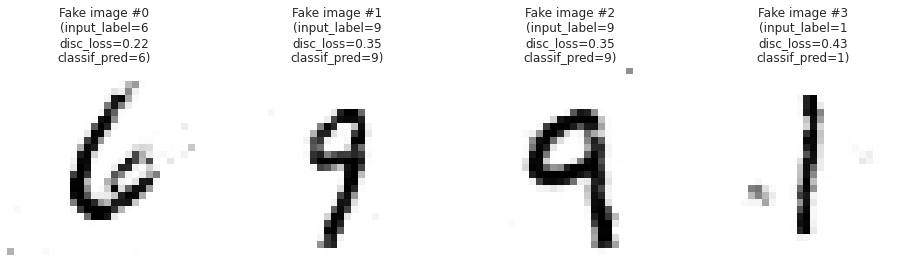


Epoch 00072: saving model to ./weights/cgan_pretrained=True_checkpoints.072.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0425 - discriminator_loss: 0.6209 - classifier_loss: 0.0315
Epoch 73/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0450 - discriminator_loss: 0.6205 - classifier_loss: 0.0345

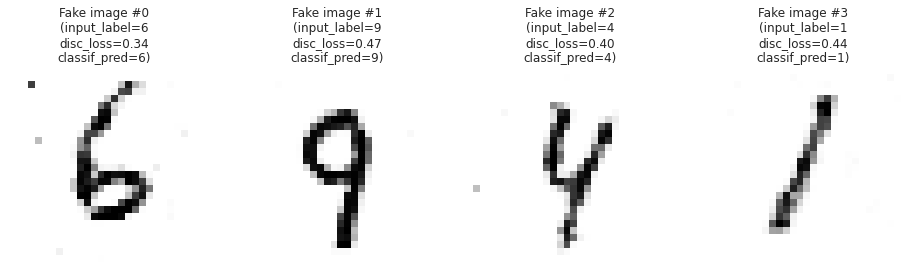


Epoch 00073: saving model to ./weights/cgan_pretrained=True_checkpoints.073.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0452 - discriminator_loss: 0.6206 - classifier_loss: 0.0346
Epoch 74/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0509 - discriminator_loss: 0.6191 - classifier_loss: 0.0282

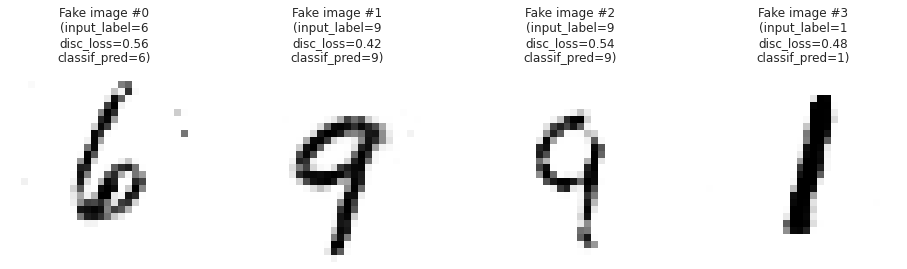


Epoch 00074: saving model to ./weights/cgan_pretrained=True_checkpoints.074.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0510 - discriminator_loss: 0.6193 - classifier_loss: 0.0281
Epoch 75/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0527 - discriminator_loss: 0.6191 - classifier_loss: 0.0254

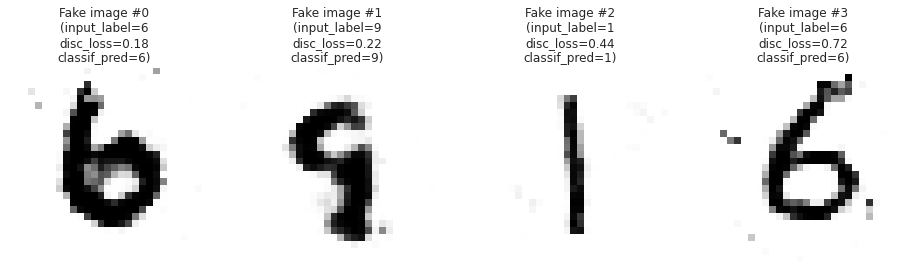


Epoch 00075: saving model to ./weights/cgan_pretrained=True_checkpoints.075.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0527 - discriminator_loss: 0.6191 - classifier_loss: 0.0253
Epoch 76/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0517 - discriminator_loss: 0.6191 - classifier_loss: 0.0336

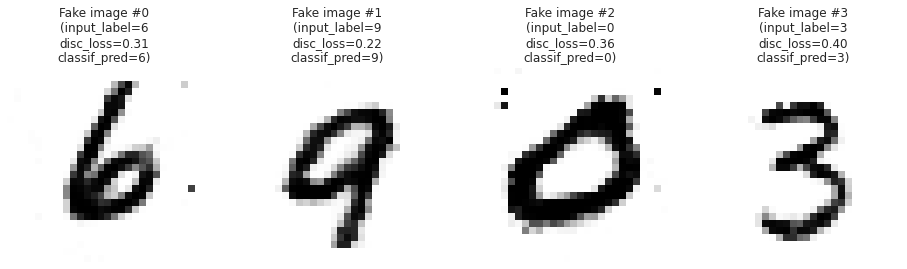


Epoch 00076: saving model to ./weights/cgan_pretrained=True_checkpoints.076.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0520 - discriminator_loss: 0.6192 - classifier_loss: 0.0338
Epoch 77/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0416 - discriminator_loss: 0.6223 - classifier_loss: 0.0333

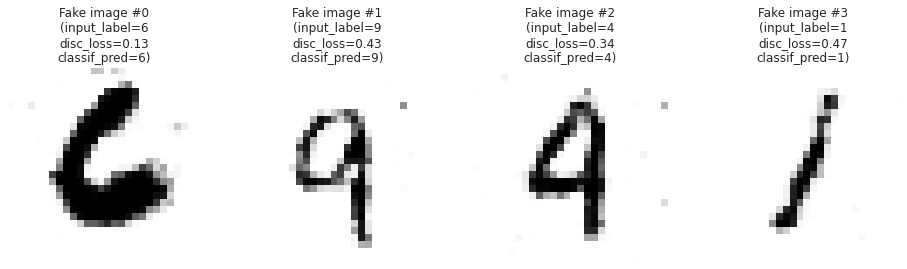


Epoch 00077: saving model to ./weights/cgan_pretrained=True_checkpoints.077.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0419 - discriminator_loss: 0.6224 - classifier_loss: 0.0332
Epoch 78/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0501 - discriminator_loss: 0.6189 - classifier_loss: 0.0248

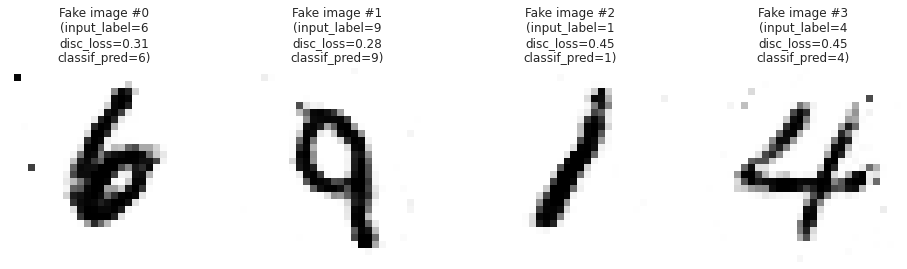


Epoch 00078: saving model to ./weights/cgan_pretrained=True_checkpoints.078.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0501 - discriminator_loss: 0.6190 - classifier_loss: 0.0248
Epoch 79/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0554 - discriminator_loss: 0.6165 - classifier_loss: 0.0249

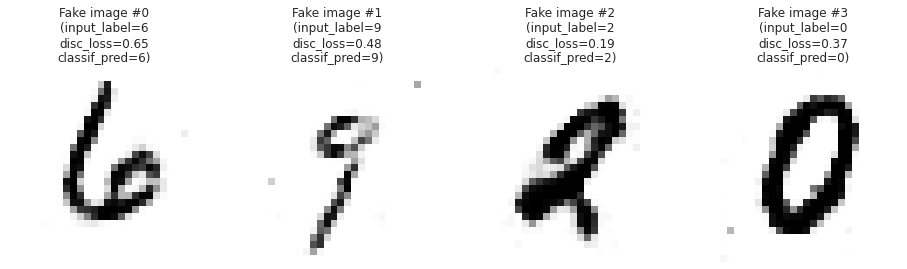


Epoch 00079: saving model to ./weights/cgan_pretrained=True_checkpoints.079.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0554 - discriminator_loss: 0.6167 - classifier_loss: 0.0249
Epoch 80/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0514 - discriminator_loss: 0.6203 - classifier_loss: 0.0303

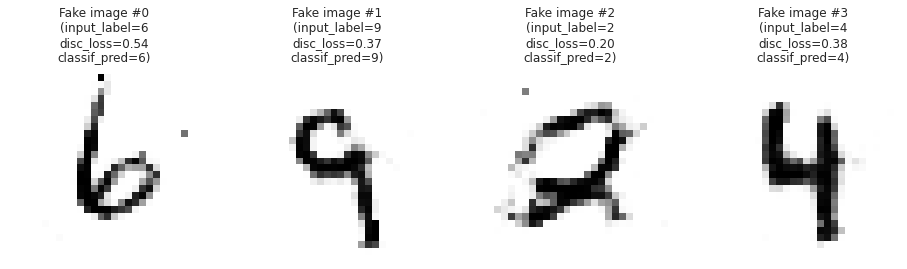


Epoch 00080: saving model to ./weights/cgan_pretrained=True_checkpoints.080.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0516 - discriminator_loss: 0.6204 - classifier_loss: 0.0304
Epoch 81/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0469 - discriminator_loss: 0.6212 - classifier_loss: 0.0326

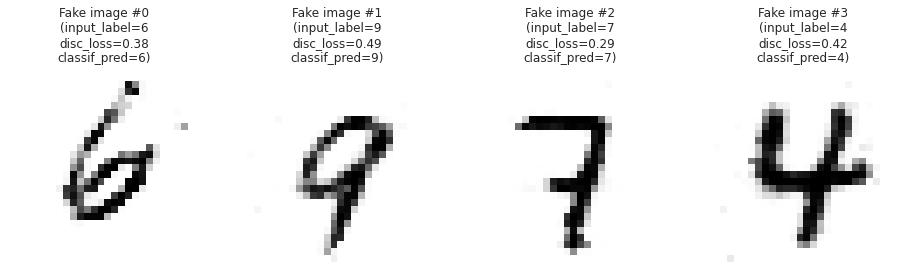


Epoch 00081: saving model to ./weights/cgan_pretrained=True_checkpoints.081.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0469 - discriminator_loss: 0.6213 - classifier_loss: 0.0328
Epoch 82/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0583 - discriminator_loss: 0.6186 - classifier_loss: 0.0303

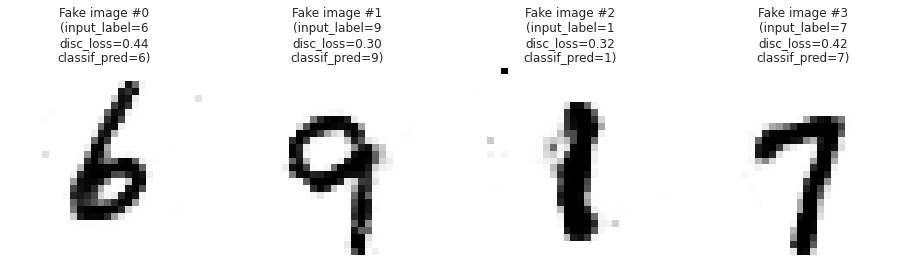


Epoch 00082: saving model to ./weights/cgan_pretrained=True_checkpoints.082.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0582 - discriminator_loss: 0.6187 - classifier_loss: 0.0303
Epoch 83/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0603 - discriminator_loss: 0.6181 - classifier_loss: 0.0302

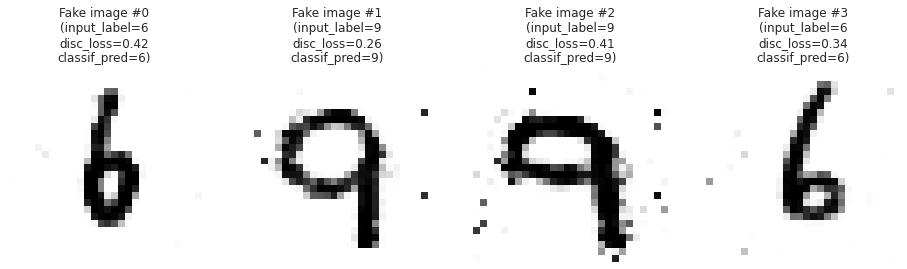


Epoch 00083: saving model to ./weights/cgan_pretrained=True_checkpoints.083.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0605 - discriminator_loss: 0.6183 - classifier_loss: 0.0301
Epoch 84/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0678 - discriminator_loss: 0.6161 - classifier_loss: 0.0269

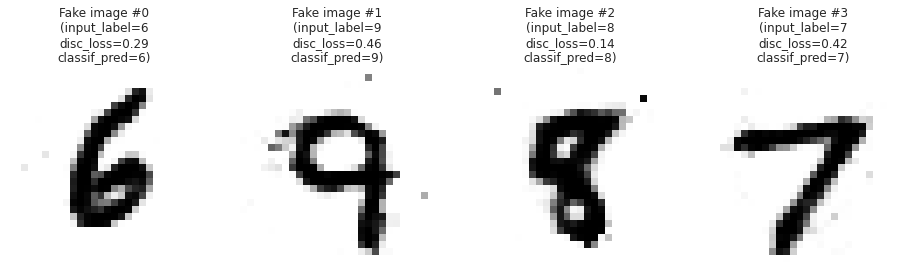


Epoch 00084: saving model to ./weights/cgan_pretrained=True_checkpoints.084.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0679 - discriminator_loss: 0.6161 - classifier_loss: 0.0268
Epoch 85/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0638 - discriminator_loss: 0.6175 - classifier_loss: 0.0263

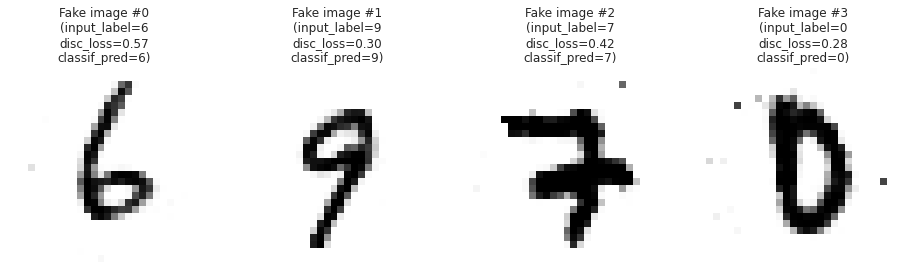


Epoch 00085: saving model to ./weights/cgan_pretrained=True_checkpoints.085.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0639 - discriminator_loss: 0.6176 - classifier_loss: 0.0262
Epoch 86/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0679 - discriminator_loss: 0.6170 - classifier_loss: 0.0292

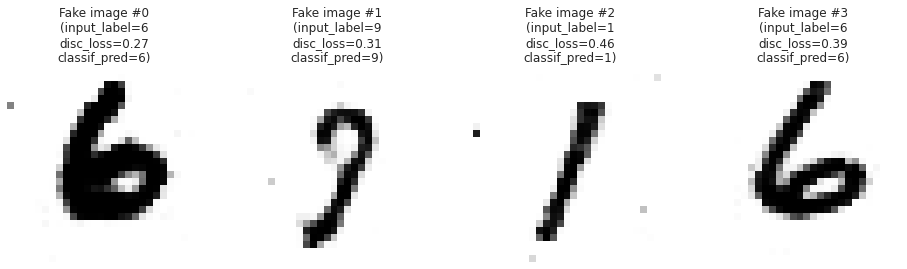


Epoch 00086: saving model to ./weights/cgan_pretrained=True_checkpoints.086.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0679 - discriminator_loss: 0.6171 - classifier_loss: 0.0293
Epoch 87/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0738 - discriminator_loss: 0.6145 - classifier_loss: 0.0305

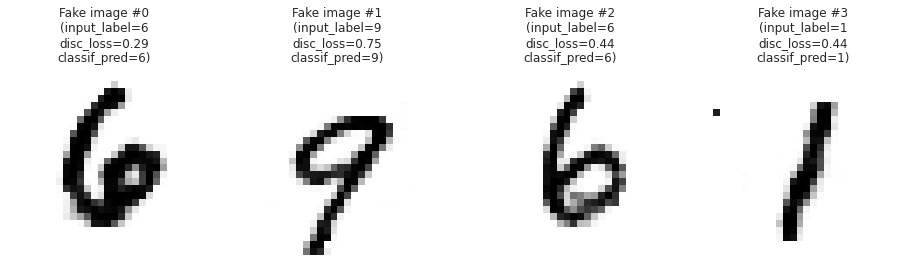


Epoch 00087: saving model to ./weights/cgan_pretrained=True_checkpoints.087.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0739 - discriminator_loss: 0.6147 - classifier_loss: 0.0304
Epoch 88/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0762 - discriminator_loss: 0.6138 - classifier_loss: 0.0263

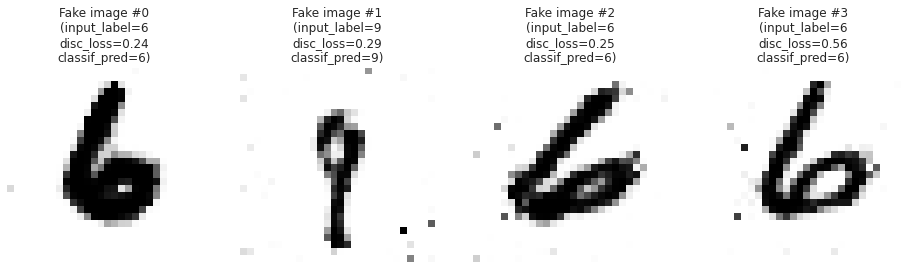


Epoch 00088: saving model to ./weights/cgan_pretrained=True_checkpoints.088.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0764 - discriminator_loss: 0.6139 - classifier_loss: 0.0263
Epoch 89/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0659 - discriminator_loss: 0.6179 - classifier_loss: 0.0239

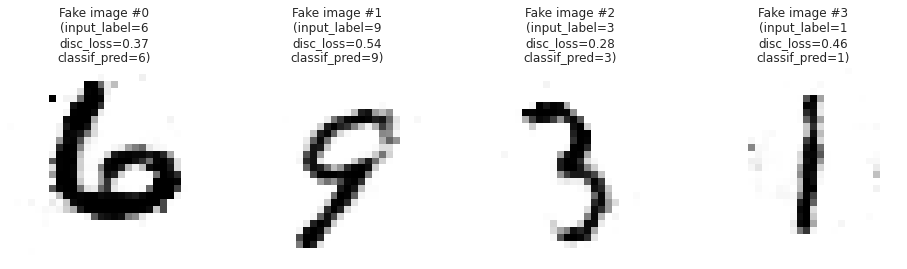


Epoch 00089: saving model to ./weights/cgan_pretrained=True_checkpoints.089.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0658 - discriminator_loss: 0.6180 - classifier_loss: 0.0240
Epoch 90/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0609 - discriminator_loss: 0.6181 - classifier_loss: 0.0225

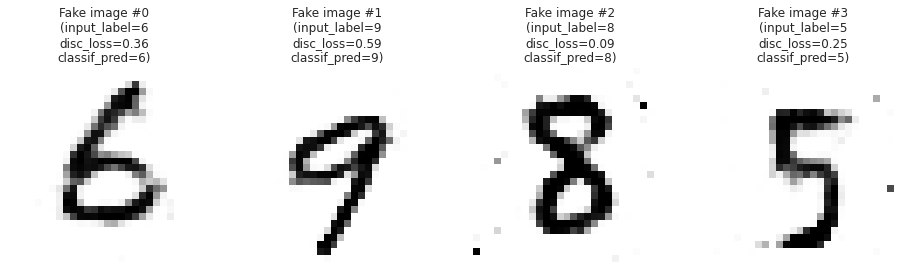


Epoch 00090: saving model to ./weights/cgan_pretrained=True_checkpoints.090.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0610 - discriminator_loss: 0.6184 - classifier_loss: 0.0225
Epoch 91/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0698 - discriminator_loss: 0.6156 - classifier_loss: 0.0266

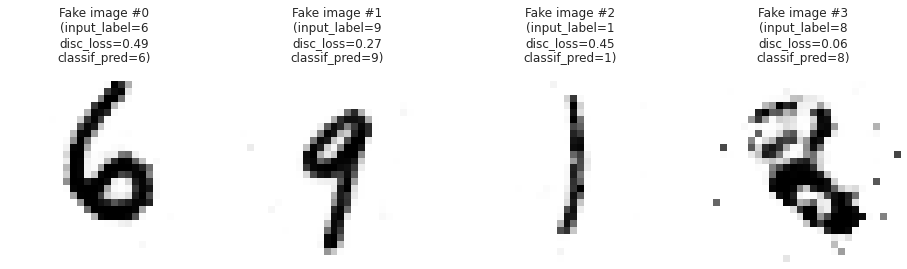


Epoch 00091: saving model to ./weights/cgan_pretrained=True_checkpoints.091.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0699 - discriminator_loss: 0.6156 - classifier_loss: 0.0266
Epoch 92/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0696 - discriminator_loss: 0.6152 - classifier_loss: 0.0221

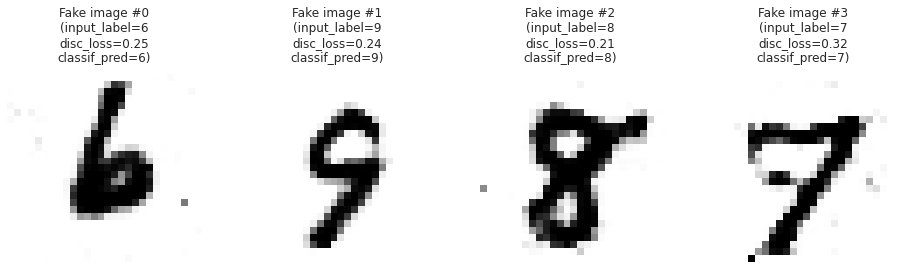


Epoch 00092: saving model to ./weights/cgan_pretrained=True_checkpoints.092.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0698 - discriminator_loss: 0.6153 - classifier_loss: 0.0221
Epoch 93/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0760 - discriminator_loss: 0.6160 - classifier_loss: 0.0279

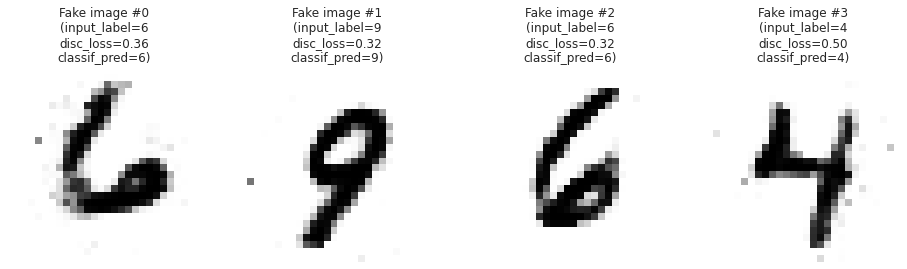


Epoch 00093: saving model to ./weights/cgan_pretrained=True_checkpoints.093.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0758 - discriminator_loss: 0.6161 - classifier_loss: 0.0281
Epoch 94/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0784 - discriminator_loss: 0.6148 - classifier_loss: 0.0312

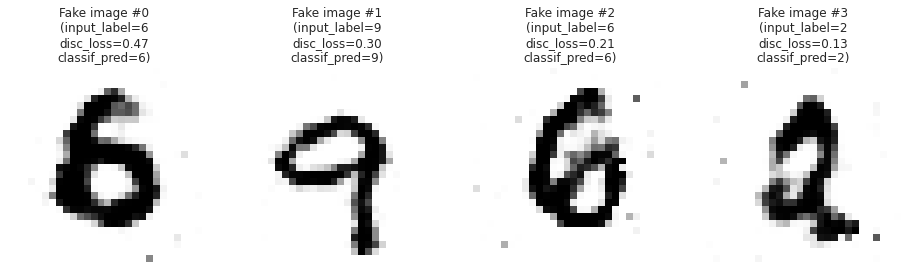


Epoch 00094: saving model to ./weights/cgan_pretrained=True_checkpoints.094.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0784 - discriminator_loss: 0.6151 - classifier_loss: 0.0311
Epoch 95/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0722 - discriminator_loss: 0.6151 - classifier_loss: 0.0229

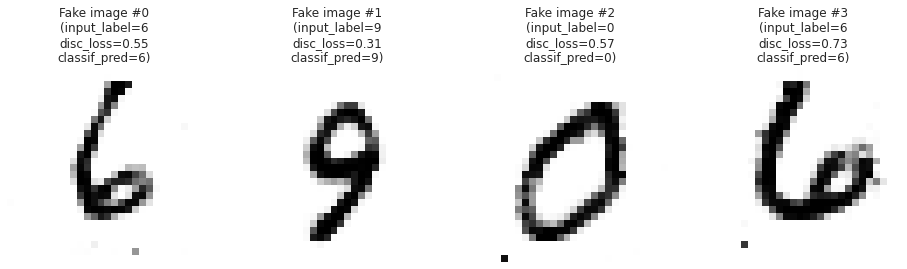


Epoch 00095: saving model to ./weights/cgan_pretrained=True_checkpoints.095.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0723 - discriminator_loss: 0.6151 - classifier_loss: 0.0229
Epoch 96/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0641 - discriminator_loss: 0.6194 - classifier_loss: 0.0216

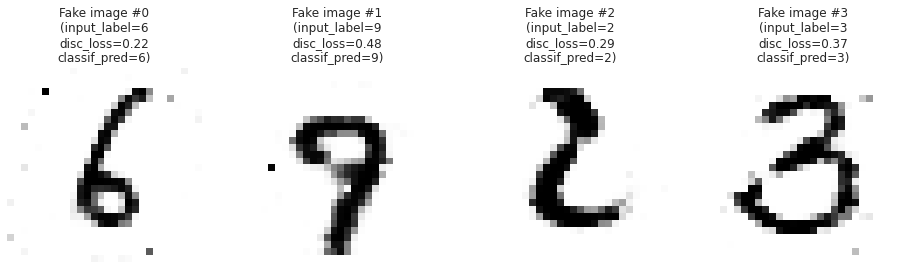


Epoch 00096: saving model to ./weights/cgan_pretrained=True_checkpoints.096.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0643 - discriminator_loss: 0.6197 - classifier_loss: 0.0215
Epoch 97/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0639 - discriminator_loss: 0.6185 - classifier_loss: 0.0255

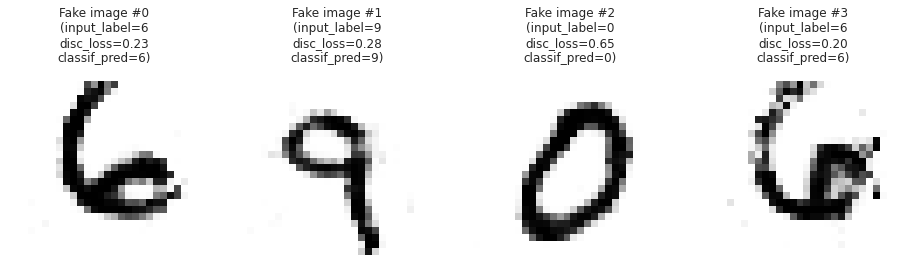


Epoch 00097: saving model to ./weights/cgan_pretrained=True_checkpoints.097.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0641 - discriminator_loss: 0.6186 - classifier_loss: 0.0254
Epoch 98/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0581 - discriminator_loss: 0.6193 - classifier_loss: 0.0232

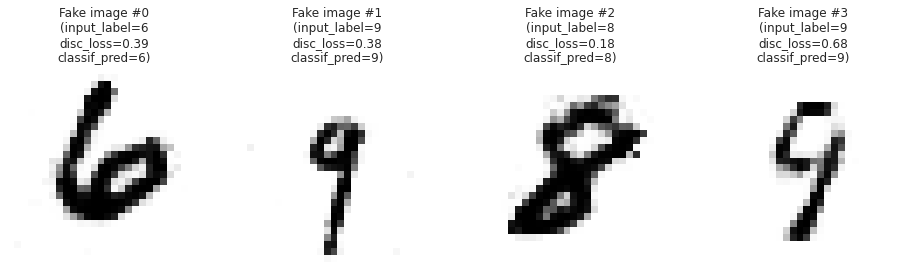


Epoch 00098: saving model to ./weights/cgan_pretrained=True_checkpoints.098.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0584 - discriminator_loss: 0.6196 - classifier_loss: 0.0232
Epoch 99/100
467/468 [============================>.] - ETA: 0s - generator_loss: 1.0683 - discriminator_loss: 0.6167 - classifier_loss: 0.0224

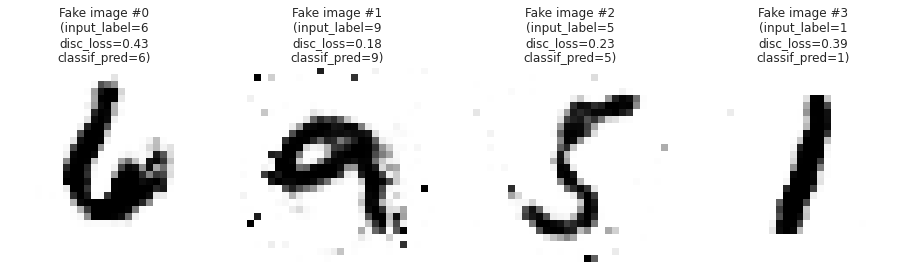


Epoch 00099: saving model to ./weights/cgan_pretrained=True_checkpoints.099.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0689 - discriminator_loss: 0.6169 - classifier_loss: 0.0224
Epoch 100/100
468/468 [==============================] - ETA: 0s - generator_loss: 1.0728 - discriminator_loss: 0.6174 - classifier_loss: 0.0262

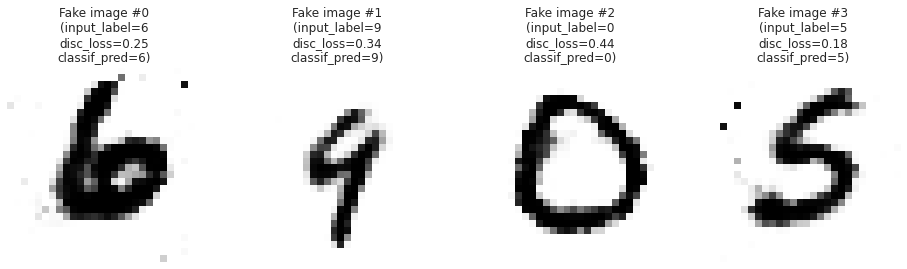


Epoch 00100: saving model to ./weights/cgan_pretrained=True_checkpoints.100.h5
468/468 [==============================] - 13s 28ms/step - generator_loss: 1.0731 - discriminator_loss: 0.6175 - classifier_loss: 0.0262


In [ ]:
if TRAIN_CGAN:
    
    print(f"Training cGAN with classifier (combined/alternate trainings)")
    
    ####
    # ALTERNATE TRAININGS (of the classifier and cGAN)
    ####
    
    files = (os.listdir(WEIGHTS_DIR))
    files = [f for f in files if "classifier" in f]
    files = sorted(files)
    print(f"Loading checkpoint '{files[-1]}'")
    classifier_copy = keras.models.load_model(f"{WEIGHTS_DIR}/{files[-1]}")
    gangan = cGan(
        generator=build_generator(), 
        discriminator=build_discriminator(), 
        classifier=classifier_copy,
        pretrained=False,
    )
    gangan.compile()
    
    files = (os.listdir(WEIGHTS_DIR))
    files = [f for f in files if "cgan_pretrained=False" in f]
    files = sorted(files)
    print(f"Loading checkpoint '{files[-1]}'")
    status = gangan.load_weights(f"{WEIGHTS_DIR}/{files[-1]}")
    print(f"status={status}")
    gangan.pretrained = True  # <========================================== TRUE!
    print(f"pretrained={gangan.pretrained}")

    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint("./weights/cgan_pretrained=True_checkpoints.{epoch:03d}.h5", verbose=VERBOSE) 
    
    gangan.fit(
        tf.data.Dataset.zip((mnist_x_train_dataset, mnist_y_train_dataset)),  # mnist_y_train_dataset won't be used as classifier is not None!
        epochs=CGAN_EPOCHS,
        callbacks=[gangan_plotter, checkpoint],
        verbose=VERBOSE,
    )

#### h) Checking out the final results

#### BEFORE (without cGAN)

In [ ]:
# classifier on MNIST
x = preprocess_test_image(mnist_x_test)
y = mnist_y_test
print(x.shape, y.shape)
loss, acc = classifier.evaluate(x, y)
print(f"Classifier test accuracy: {'%.4f' % acc} (MNIST)")

(10000, 28, 28, 1) (10000, 1)
313/313 [==============================] - 1s 5ms/step - loss: 3.3427 - accuracy: 0.6714
Classifier test accuracy: 0.6714 (MNIST)


sigma=0.20608490979213007


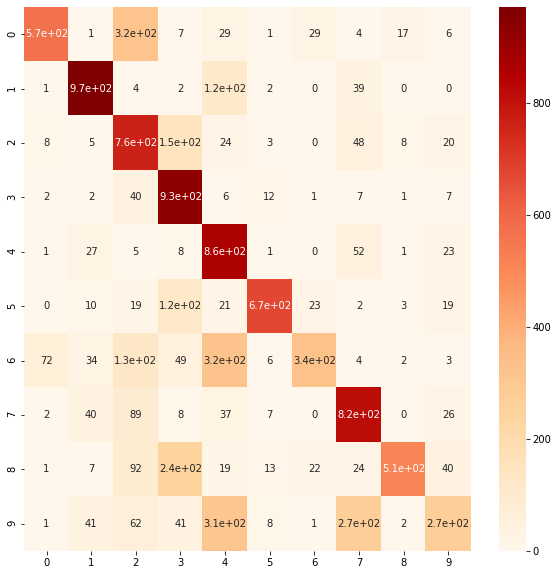

In [ ]:
preds = classifier.predict(preprocess_test_image(mnist_x_test))
y_preds = np.argmax(preds, axis=1)

# Plot heatmap of the predictions on the SVHN test dataset
plt.figure(figsize=(10,10))
M = confusion_matrix(mnist_y_test, y_preds)
sigma = np.linalg.norm(M - M.T) / 2.0 / np.linalg.norm(M)
print(f"sigma={sigma}")
sns.heatmap(M, cmap='OrRd',annot = True);

#### AFTER (with cGAN)

In [ ]:
files = (os.listdir(WEIGHTS_DIR))
files = [f for f in files if "cgan_pretrained=True" in f]
files = sorted(files)
print(f"Loading checkpoint '{files[-1]}'")
status = gangan.load_weights(f"{WEIGHTS_DIR}/{files[-1]}")
print(f"status={status}")

# classifier on MNIST
x = preprocess_test_image(mnist_x_test)
y = mnist_y_test
print(x.shape, y.shape)
gangan.classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
loss, acc = gangan.classifier.evaluate(x, y)
print(f"Classifier test accuracy: {'%.4f' % acc} (MNIST)")

Loading checkpoint 'cgan_pretrained=True_checkpoints.100.h5'
status=None
(10000, 28, 28, 1) (10000, 1)
313/313 [==============================] - 1s 5ms/step - loss: 0.0409 - accuracy: 0.9900
Classifier test accuracy: 0.9900 (MNIST)


sigma=0.003905007637416199


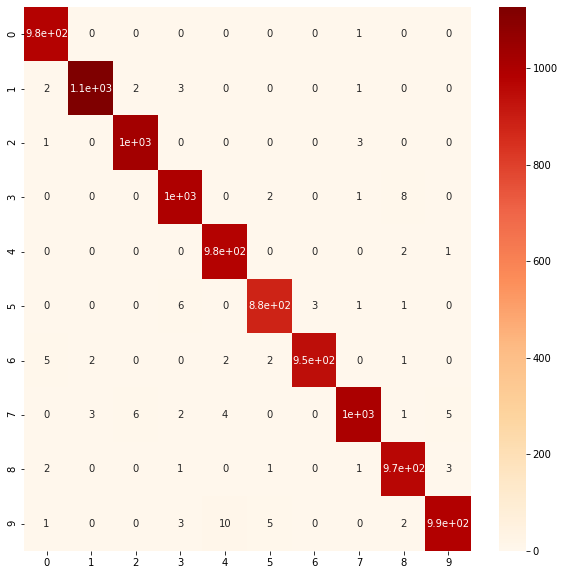

In [ ]:
preds = gangan.classifier.predict(preprocess_test_image(mnist_x_test))
y_preds = np.argmax(preds, axis=1)

# Plot heatmap of the predictions on the SVHN test dataset
plt.figure(figsize=(10,10))
M = confusion_matrix(mnist_y_test, y_preds)
sigma = np.linalg.norm(M - M.T) / 2.0 / np.linalg.norm(M)
print(f"sigma={sigma}")
sns.heatmap(M, cmap='OrRd',annot = True);

---

**Final results:**

- Shift noise on MNIST test dataset - without cGAN: **0.206**

- Shift noise on MNIST test dataset - without cGAN: **0.004**

- Final classification accuracy on SVHN test dataset (supervised) : **+98%**

- Final classification accuracy on MNIST test dataset (unsupervised): **+99%**

(approx. 2 hours for the whole training procedure)